In [10]:
## escape error
!pip install matplotlib==2.2.5

  Using cached https://files.pythonhosted.org/packages/a5/aa/1e7161110095dc8540cc0ec9564bad624c1d5dd3f40ec376b89d00134a5f/matplotlib-2.2.5-cp37-cp37m-macosx_10_9_x86_64.whl
  Found existing installation: matplotlib 3.1.0
    Uninstalling matplotlib-3.1.0:
      Successfully uninstalled matplotlib-3.1.0


In [10]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import gym

from JSAnimation.IPython_display import display_animation
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
%matplotlib inline
from IPython.display import display

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from pathlib import Path

# Allow duplicate libraries
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [11]:
# Save the result of Open AI Gym as gif file
# http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
#     patch = plt.imshow(frames[0])
    
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    plt.axis('off')

    images = []
    for f in frames:
        im = plt.imshow(f, animated=True)
        images.append([im])

    anim = animation.ArtistAnimation(fig, images, interval=50, repeat=True)
    
    pathname = Path("/Users/kouki/files/programs/kaira/movie_cartpole_DQN.gif")
    anim.save(pathname, writer='pillow')
    display(display_animation(anim, default_mode='loop'))

In [12]:
# By using namedtuple, you can store the value in pairs with the field name.
# convenient to access the values by their field names.
# https://docs.python.jp/3/library/collections.html#collections.namedtuple

# Set namedtuple to save the CartPole's 4 states
from collections import namedtuple
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [13]:
# Set consts
ENV: str = 'CartPole-v0'  # subject name
GAMMA: float = 0.99  # discount rate
MAX_STEPS: int = 200  # number of steps in 1 episode
NUM_EPISODES: int = 500  # number of max eposodes

BATCH_SIZE = 32
CAPACITY = 10000

In [14]:
# Set memory class
class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # max length of memory
        self.memory = []  # save experiences
        self.index = 0  # index to be saved

    def push(self, state, action, state_next, reward):
        '''
        Save transition = (state, action, state_next, reward) to memory
        '''

        # If the memory is not full, add more
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        # save by using namedtuple
        self.memory[self.index] = Transition(state, action, state_next, reward)

        # Move the index to be saved by one
        self.index = (self.index + 1) % self.capacity  

    def sample(self, batch_size):
        '''
        Get the stored contents randonly by batch_size.
        '''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''
        Length of memory
        '''
        return len(self.memory)

In [15]:
# Run DQN
# Set Q learning by network class
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # action of CartPole(Right or Left)

        # memory object which saves experiences
        self.memory = ReplayMemory(CAPACITY)

        # Build neural network
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # shape of network

        # Optimization method
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''
        Learn Network binding parameters by Experience Replay
        '''

        # 1.1 continue while the memory size is smaller than BATCH_SIZE
        if len(self.memory) < BATCH_SIZE:
            return

        # 2.1 Extract a BATCH_SIZE of data from the memory
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 Transform each variable into a form corresponds to the mini-batch.
        # transitions: (state, action, state_next, reward)×BATCH_SIZE
        # -> (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # 2.3 Transform the elements into a shape that corresponds to the mini-batch 
        # and make it a variable can be handled by the network.
        # [torch.FloatTensor of size 1x4] * BATCH_SIZE
        # -> torch.FloatTensor of size BATCH_SIZEx4
        # cat means Concatenates
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # 3.1 Switch the network to evaluate mode.
        self.model.eval()

        # 3.2 Find the Q(s_t, a_t) output by the network
        # self.model(state_batch): [torch.FloatTensor of size BATCH_SIZEx2]
        # find the Q value corresponding to the executed action a_t.
        # find a_t's index in action_batch(right ot left)
        # then gather Q
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 find max{Q(s_t+1, a)}
        # however, note the presence of the following transitions
        # create an index mask to check if cartpole is not done and if there is a next_state.
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        
        # init values
        next_state_values = torch.zeros(BATCH_SIZE)

        # find the maximum Q-value masked by non_final_mask
        # with max(1), find the [value, index] of the maximum value in the column direction
        # output Q（index=0）
        # then detach value
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 Find the Q(s_t, a_t) value from the Q learning formula
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # 4.1 Switch the network to train mode.
        self.model.train()

        # 4.2 calculate loss （smooth_l1_loss is Huberloss）
        # loss: [minibatch x 1]
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 update parameters
        self.optimizer.zero_grad()  # reset grad
        loss.backward()  # calculate back propagetion
        self.optimizer.step()  # update parameters

    def decide_action(self, state, episode):
        '''
        Determine your actions based on your current state.
        '''
        # gradually adopt only the optimal behavior by ε-greedy method
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            # get the index of the max value of the network output.
            # max(1)[1].view(1,1): [torch.LongTensor of size 1]　 -> size 1x1
            self.model.eval()  # Switch the network to evaluate mode.
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
        else:
          # return binary action randomly
          # action: [torch.LongTensor of size 1x1]
          action = torch.LongTensor(
              [[random.randrange(self.num_actions)]])

        return action

In [16]:
# CartPole class
class Agent:
    def __init__(self, num_states, num_actions):
        '''
        Set the state and the number of actions.
        '''
        self.brain = Brain(num_states, num_actions)  # create brain

    def update_q_function(self):
        '''
        Update Q function
        '''
        self.brain.replay()

    def get_action(self, state, episode):
        '''
        Decide action
        '''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''
        Save the content of(state, action, state_next, reward) to memory
        '''
        self.brain.memory.push(state, action, state_next, reward)

In [17]:
# Class of environment which excutes CartPole
class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # Set subject name
        num_states = self.env.observation_space.shape[0]  # get number of state(4)
        num_actions = self.env.action_space.n  # get right or left
        self.agent = Agent(num_states, num_actions)  # create agent

        
    def run(self):
        '''
        Execute
        '''
        episode_10_list = np.zeros(10)  # Stores steps for 10 consecutive episodes and uses the average number of steps for output
        complete_episodes = 0  # count of attempts to stand for more than 195 consecutive steps
        episode_final = False  # final episode flag
        frames = []  # Variable to store the image to make the last episode a movie.

        for episode in range(NUM_EPISODES):  # Repeat for maximum number of trials
            observation = self.env.reset()  # init environment

            state = observation  # set state
            state = torch.from_numpy(state).type(torch.FloatTensor)  # NumPy variable -> PyTorch Tensor
            state = torch.unsqueeze(state, 0)  # size 4 -> size 1x4

            for step in range(MAX_STEPS):  # roop of 1 episode

                if episode_final is True:  # in the final episode, add the images for each time to frames
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # find action

                # find s_{t+1} and done flag by action a_t
                # get content from action by specifying .item()
                observation_next, _, done, _ = self.env.step(
                    action.item())  # no use reward and info

                # Give a reward , evaluate the end of the episode and set the state_next
                if done:  # the number of steps over 200 or the angle more than a certain angle.
                    state_next = None  # next state is none

                    # add to list of steps in the last 10 episodes
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # If lose, get a penalty of -1
                        complete_episodes = 0  # Reset consecutive success count
                    else:
                        reward = torch.FloatTensor([1.0])  # if success, get a reward of 1
                        complete_episodes = complete_episodes + 1  # update consecutive success count
                else:
                    reward = torch.FloatTensor([0.0])  # reward is 0 by default
                    state_next = observation_next  # update state
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy variable -> PyTorch Tensor
                    state_next = torch.unsqueeze(state_next, 0)  # size 4 -> size 1x4

                # add experience to memory
                self.agent.memorize(state, action, state_next, reward)

                # update Q sunction by Experience Replay
                self.agent.update_q_function()

                # update state
                state = state_next

                # Processing at the end
                if done:
                    print('%d Episode: Finished after %d steps：average of 10 episodes = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # draw and save gif
                display_frames_as_gif(frames)
                break

            # If it keeps passing 200 steps for 10 episodes, print succeed.
            if complete_episodes >= 10:
                print('10 consecutive successes!')
                episode_final = True  # set next episode as final

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 32 steps：average of 10 episodes = 3.2
1 Episode: Finished after 10 steps：average of 10 episodes = 4.2
2 Episode: Finished after 12 steps：average of 10 episodes = 5.4
3 Episode: Finished after 8 steps：average of 10 episodes = 6.2
4 Episode: Finished after 9 steps：average of 10 episodes = 7.1
5 Episode: Finished after 9 steps：average of 10 episodes = 8.0
6 Episode: Finished after 9 steps：average of 10 episodes = 8.9
7 Episode: Finished after 9 steps：average of 10 episodes = 9.8
8 Episode: Finished after 10 steps：average of 10 episodes = 10.8
9 Episode: Finished after 10 steps：average of 10 episodes = 11.8
10 Episode: Finished after 8 steps：average of 10 episodes = 9.4
11 Episode: Finished after 9 steps：average of 10 episodes = 9.3
12 Epis

/Users/kouki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


17 Episode: Finished after 14 steps：average of 10 episodes = 11.7
18 Episode: Finished after 14 steps：average of 10 episodes = 12.1
19 Episode: Finished after 13 steps：average of 10 episodes = 12.4
20 Episode: Finished after 13 steps：average of 10 episodes = 12.9
21 Episode: Finished after 15 steps：average of 10 episodes = 13.5
22 Episode: Finished after 12 steps：average of 10 episodes = 13.2
23 Episode: Finished after 19 steps：average of 10 episodes = 13.7
24 Episode: Finished after 23 steps：average of 10 episodes = 15.0
25 Episode: Finished after 26 steps：average of 10 episodes = 16.4
26 Episode: Finished after 16 steps：average of 10 episodes = 16.5
27 Episode: Finished after 32 steps：average of 10 episodes = 18.3
28 Episode: Finished after 27 steps：average of 10 episodes = 19.6
29 Episode: Finished after 19 steps：average of 10 episodes = 20.2
30 Episode: Finished after 19 steps：average of 10 episodes = 20.8
31 Episode: Finished after 19 steps：average of 10 episodes = 21.2
32 Episode


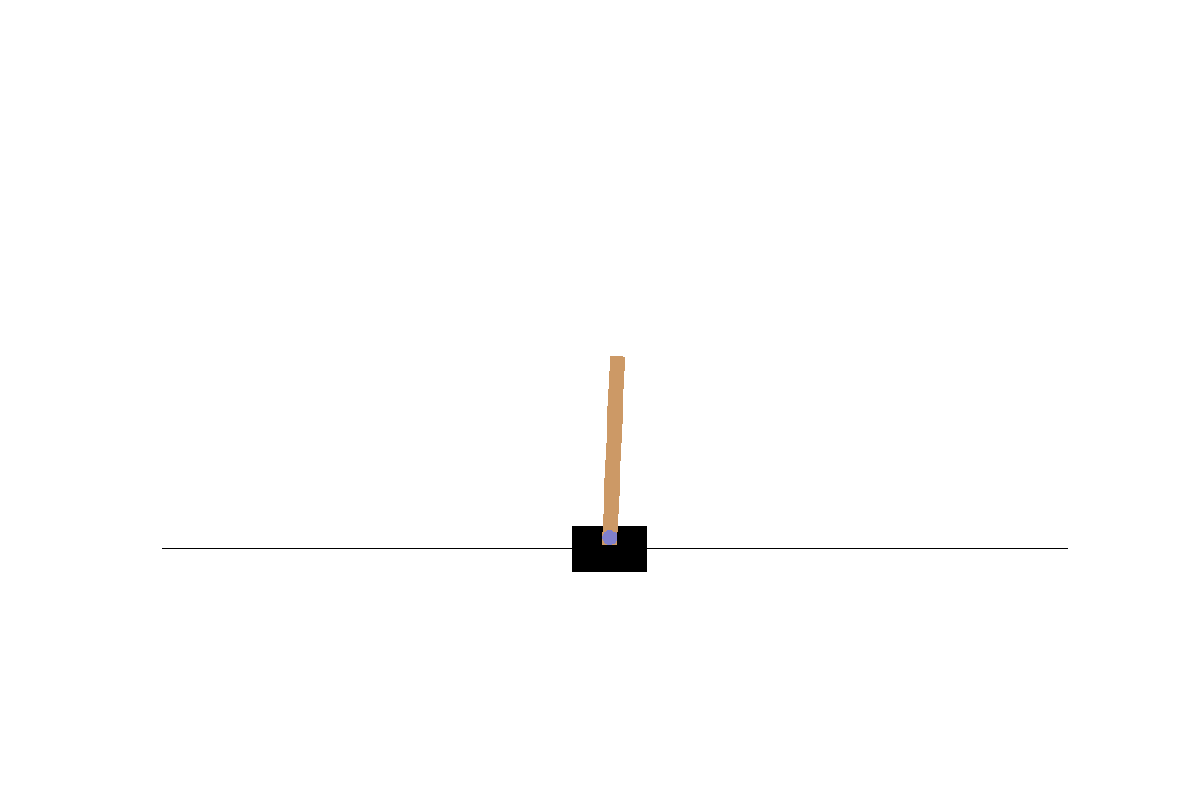
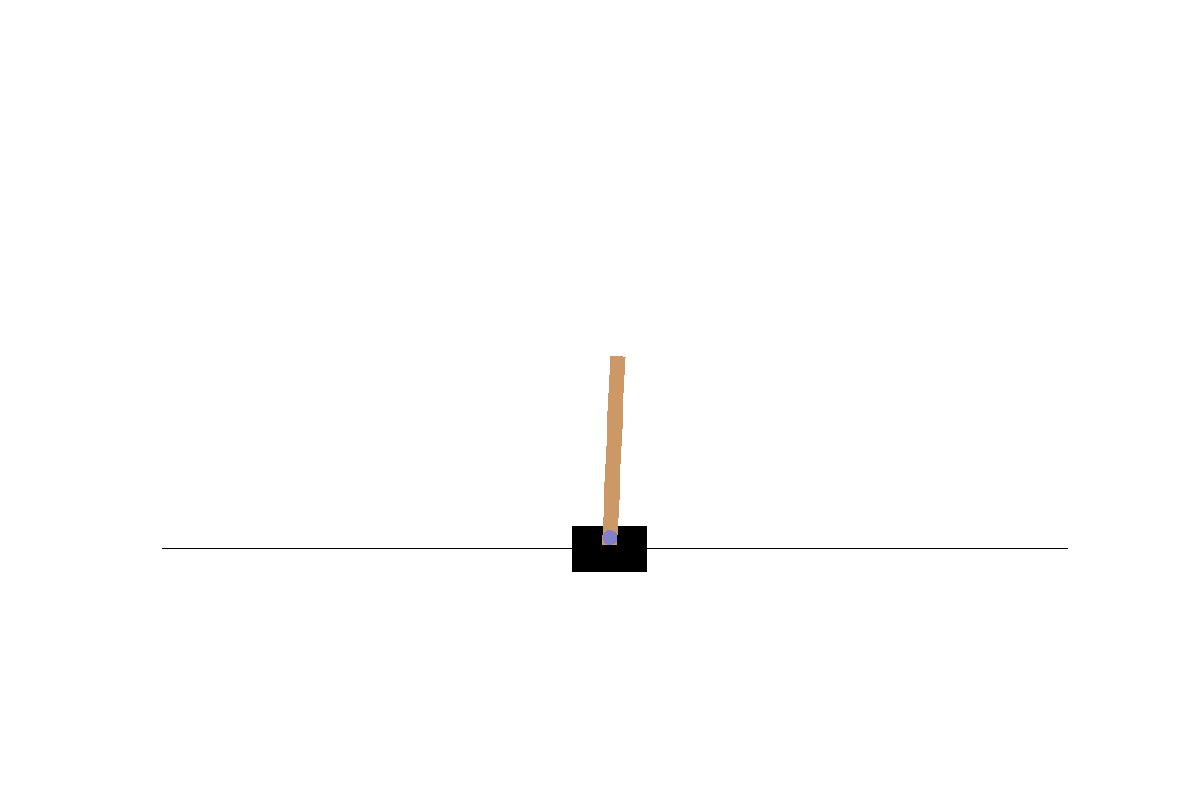
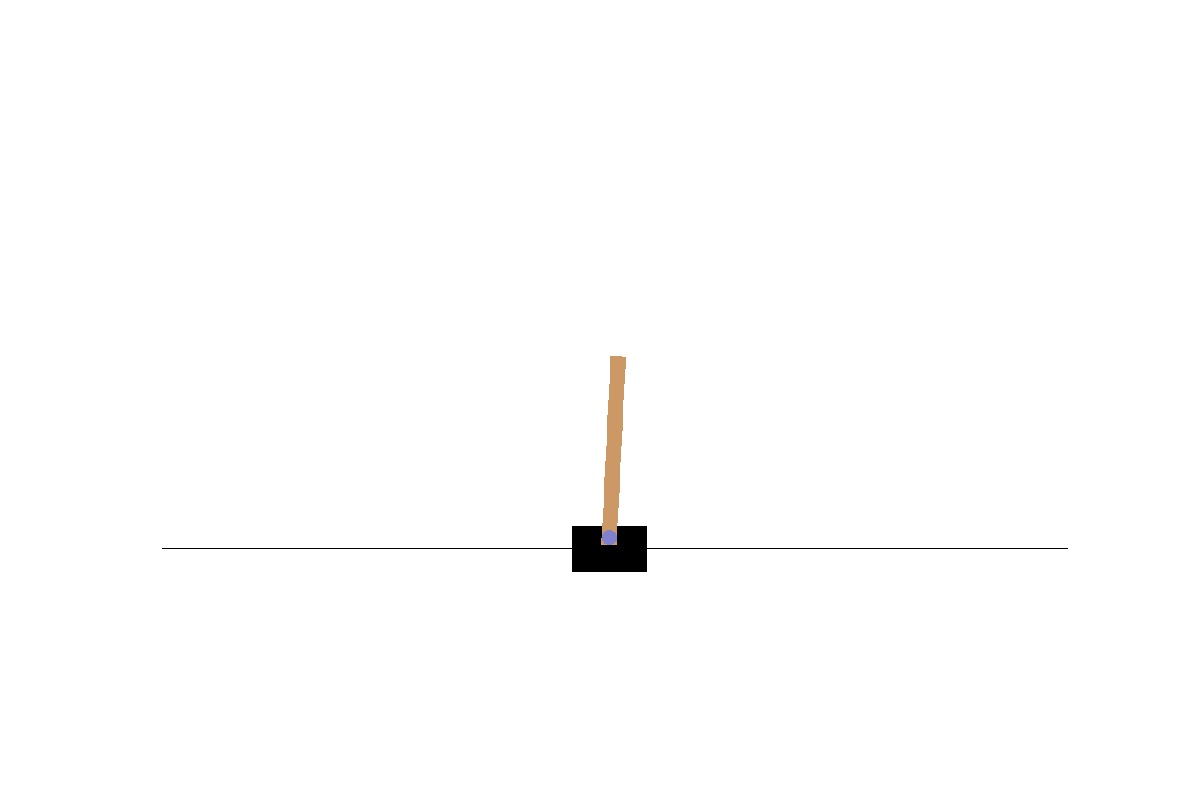
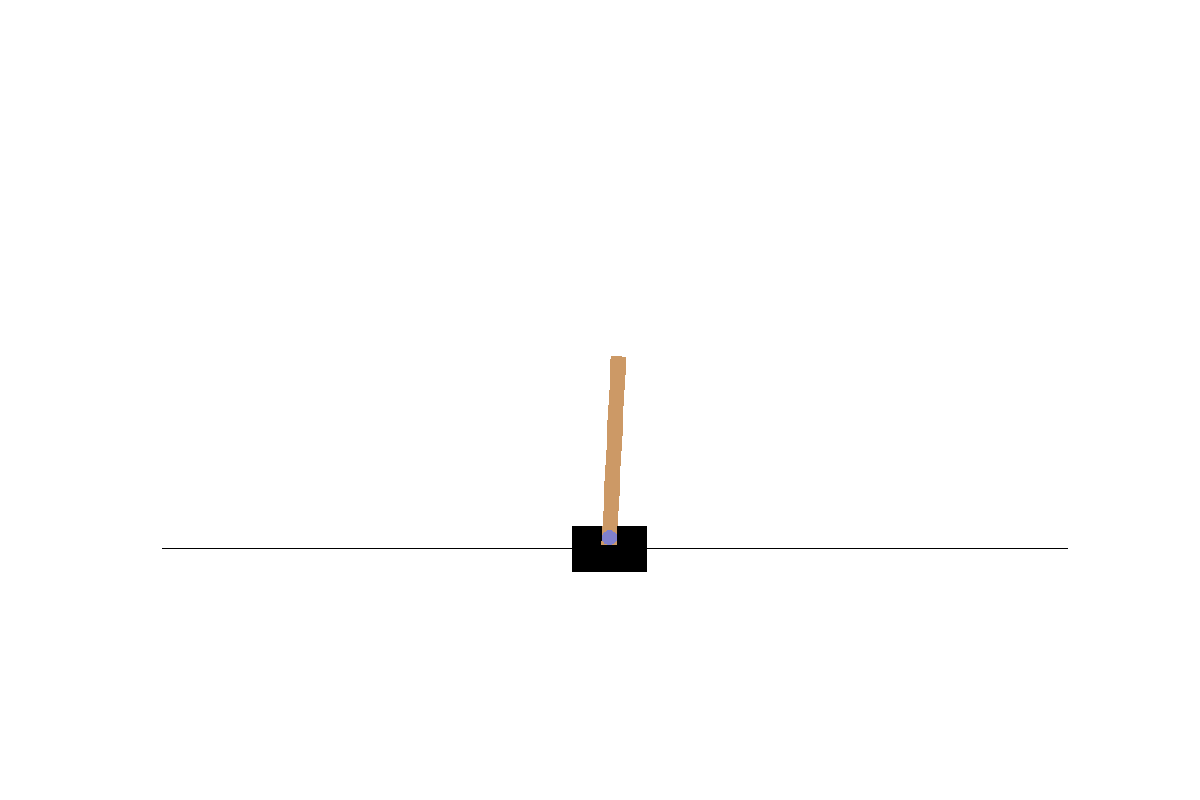
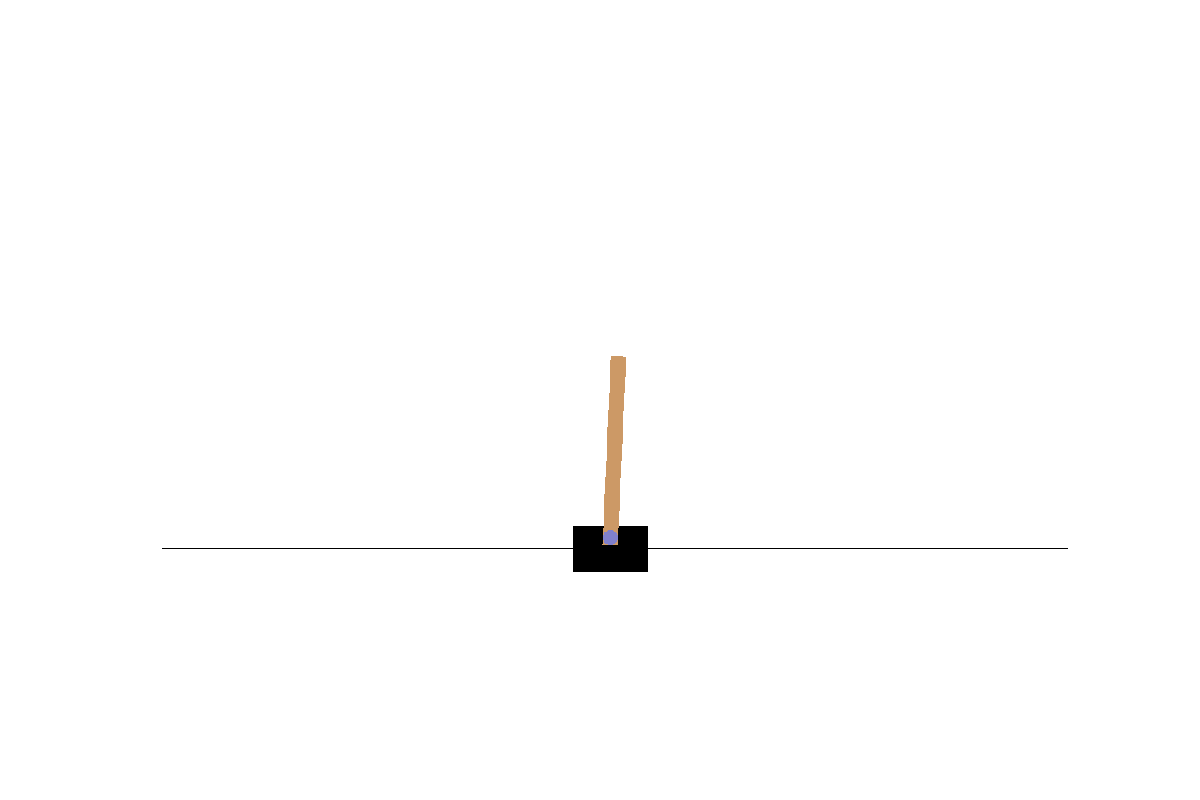
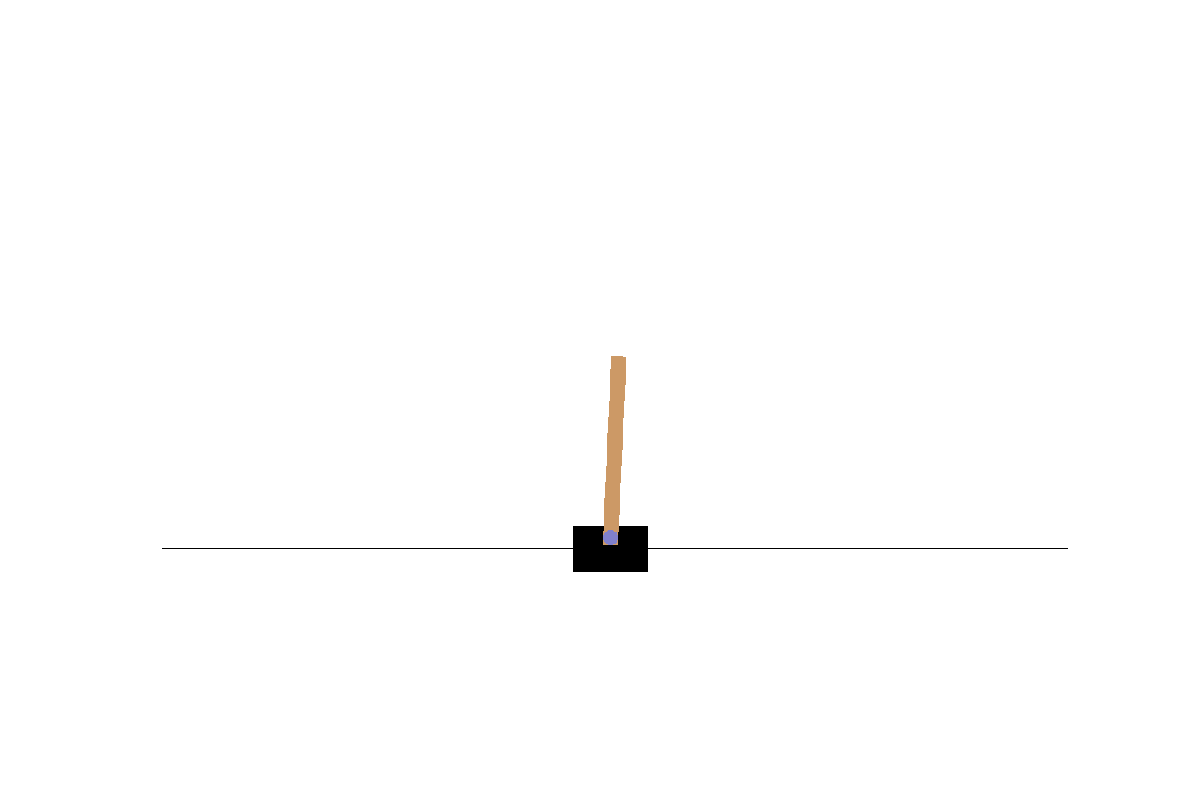
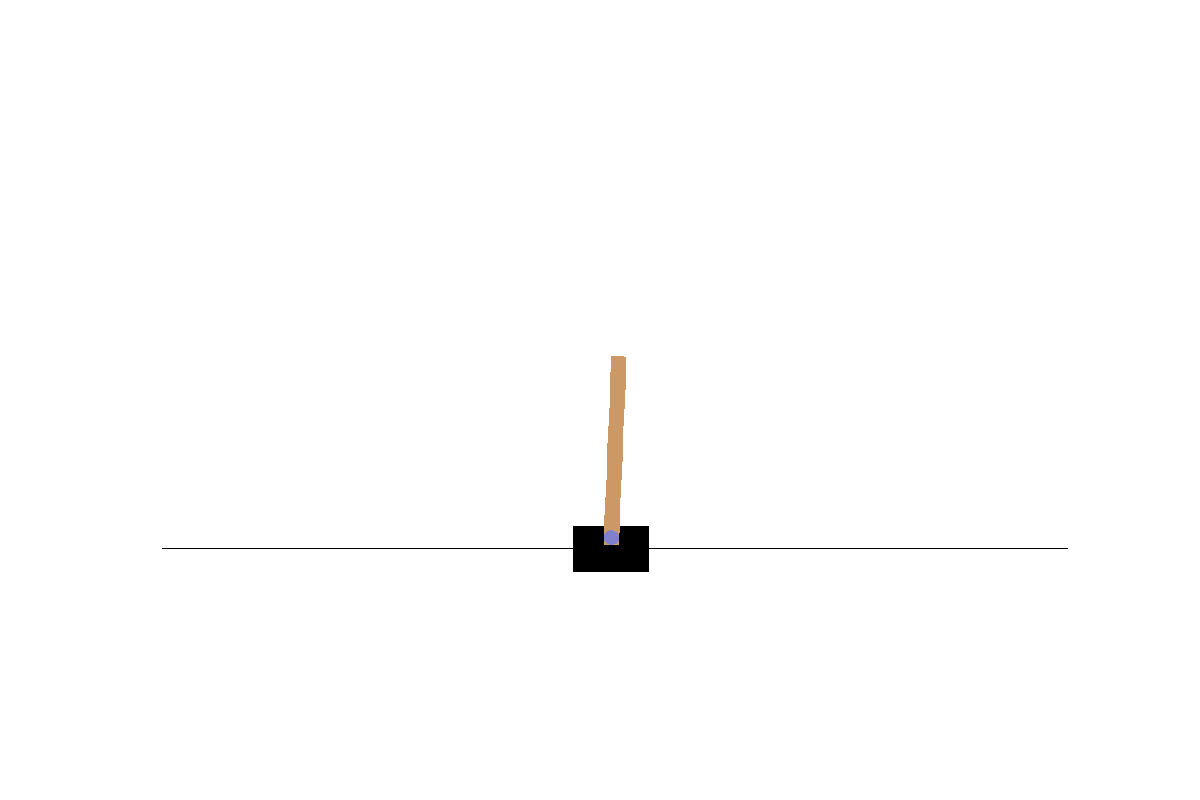
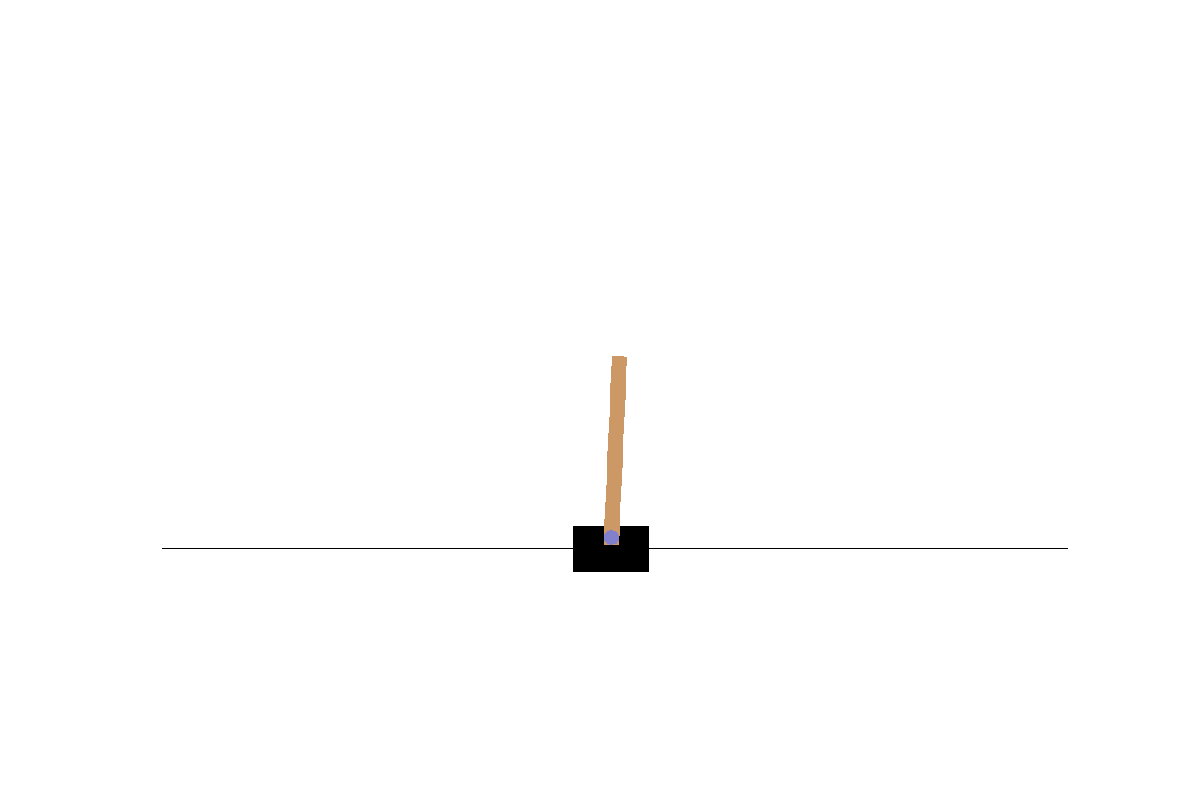
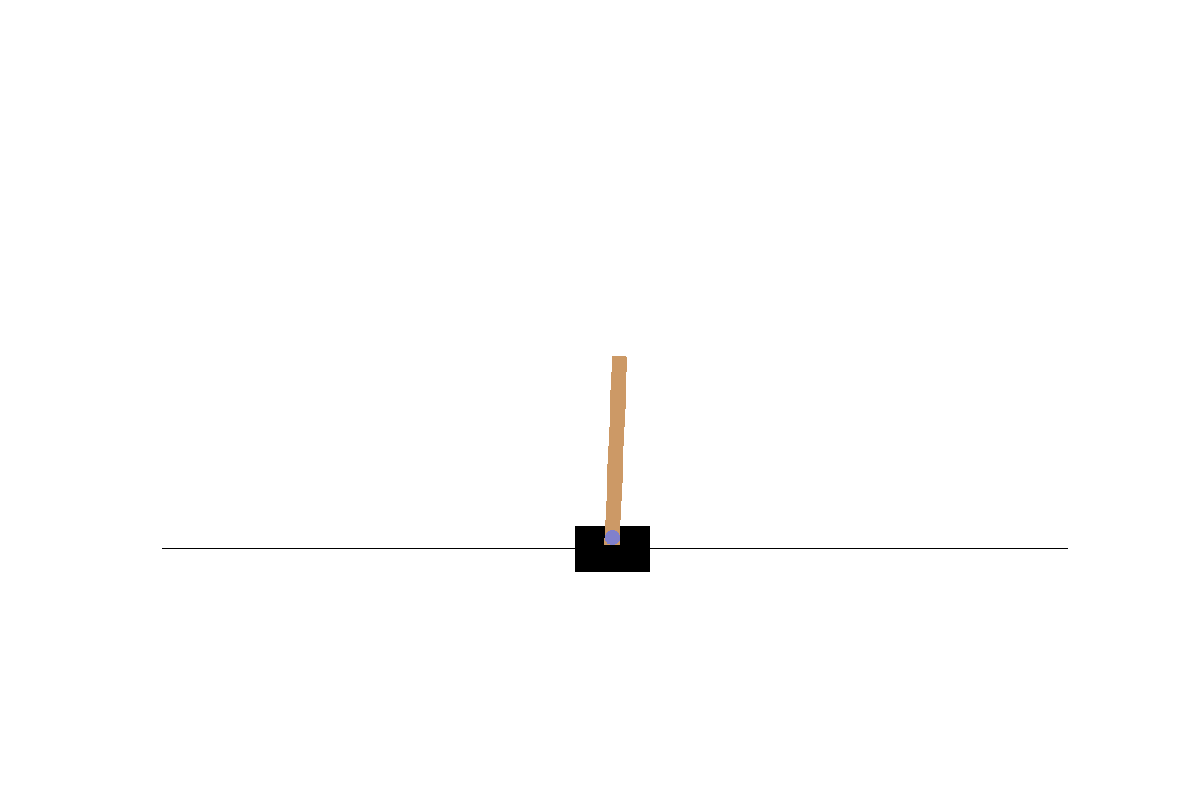
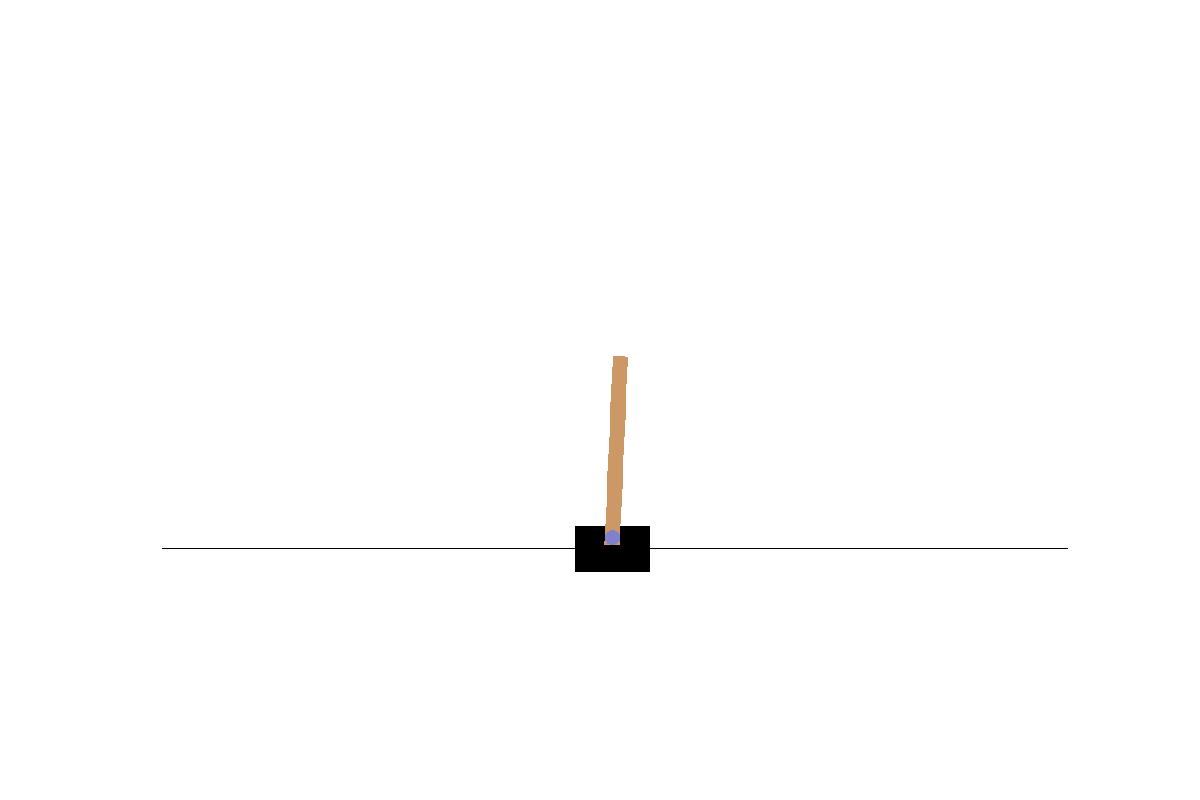
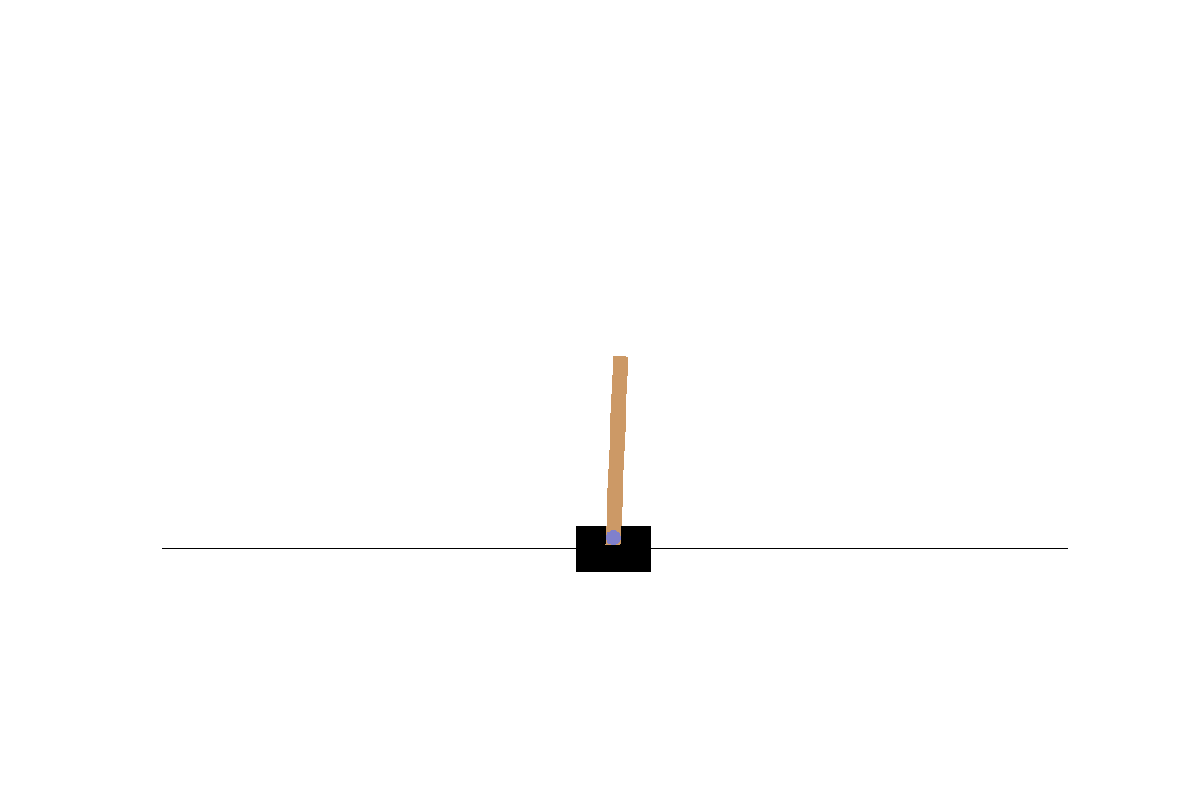
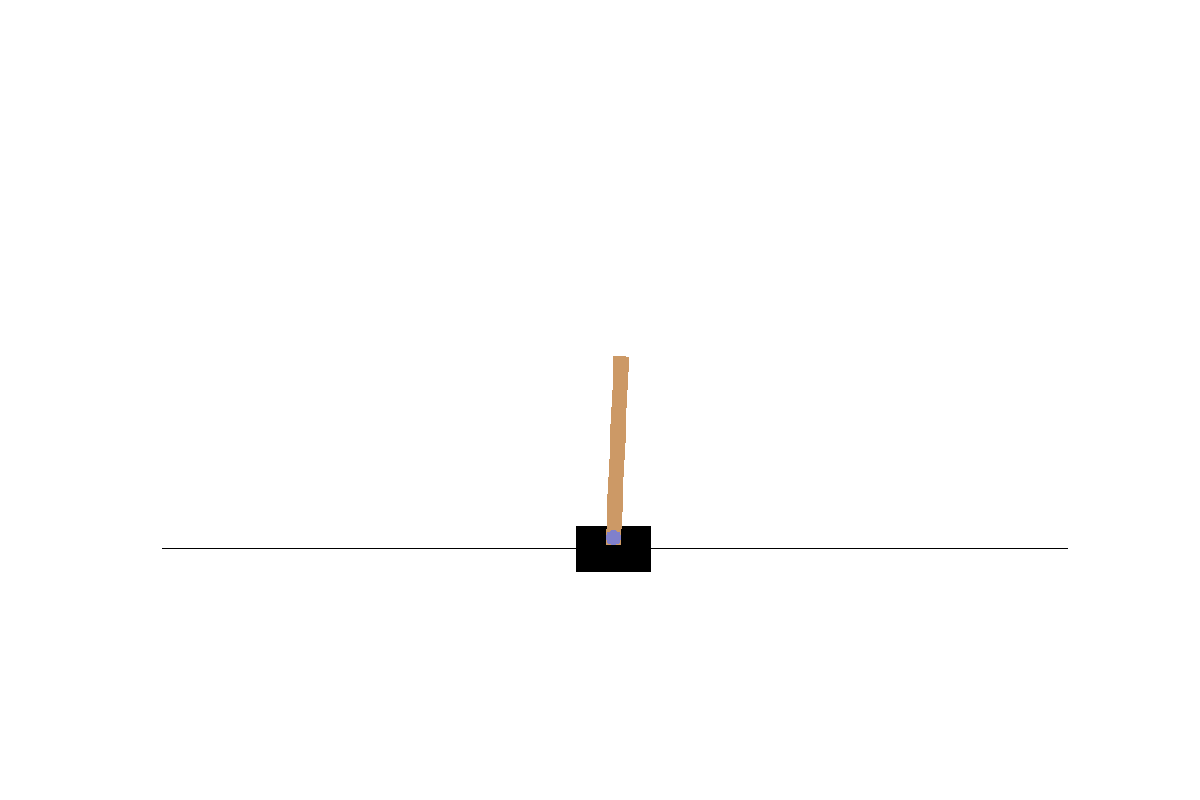
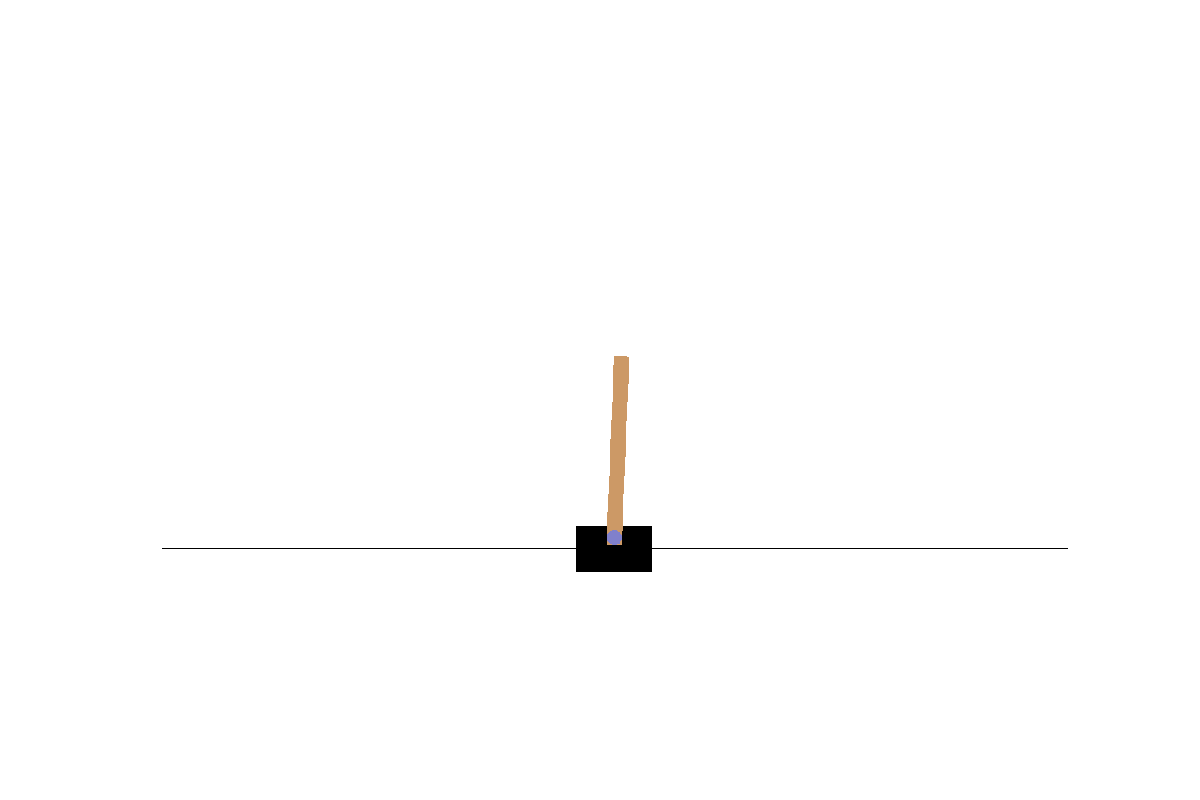
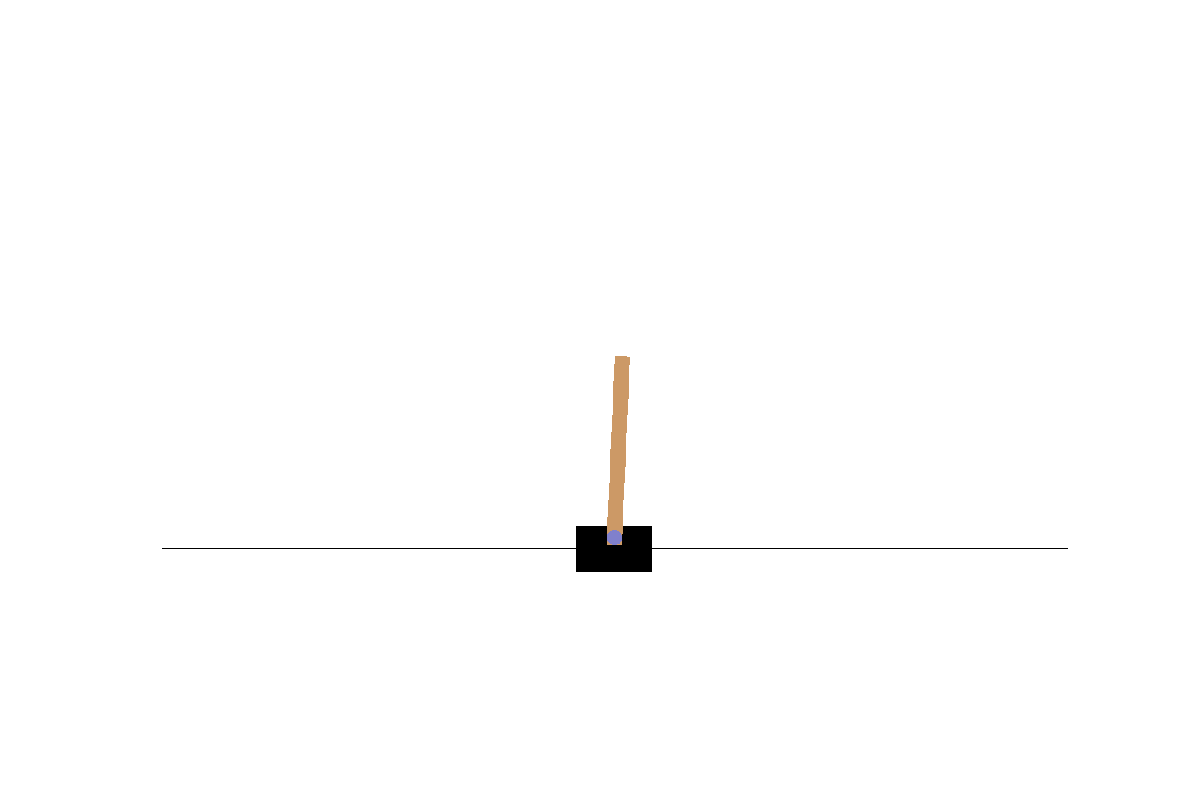
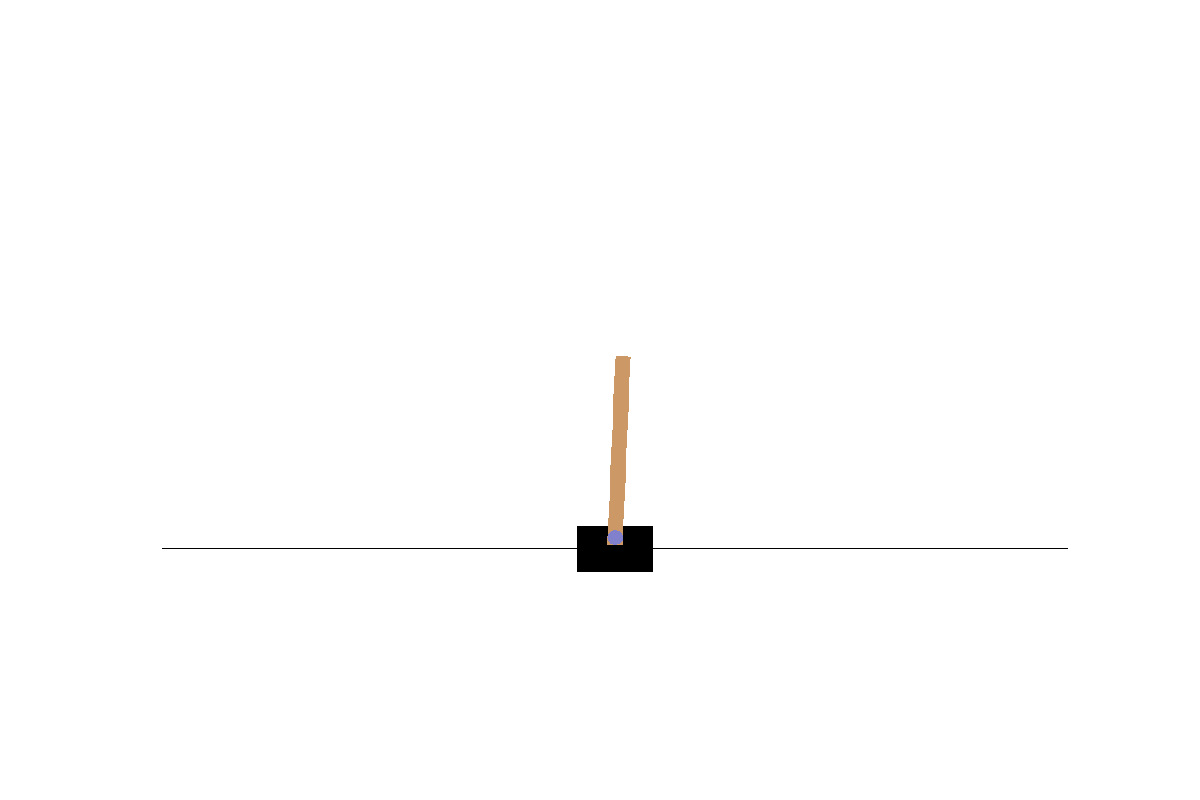
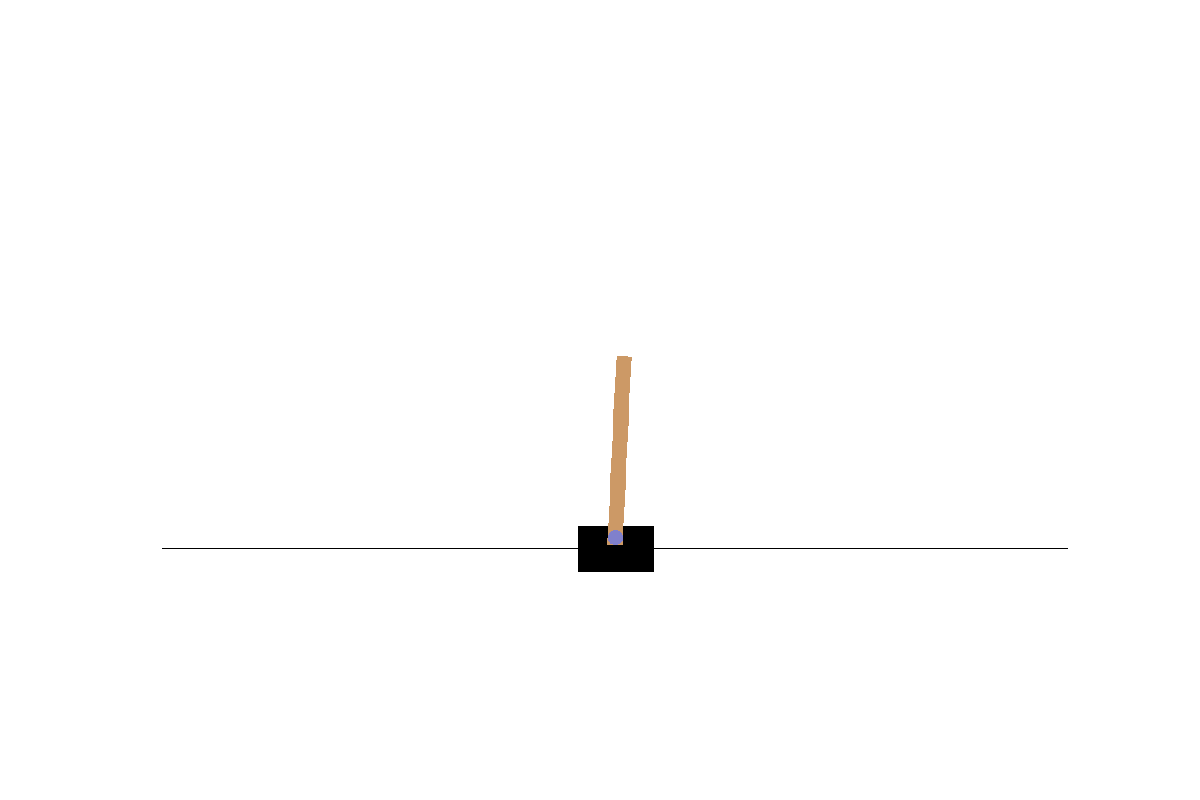
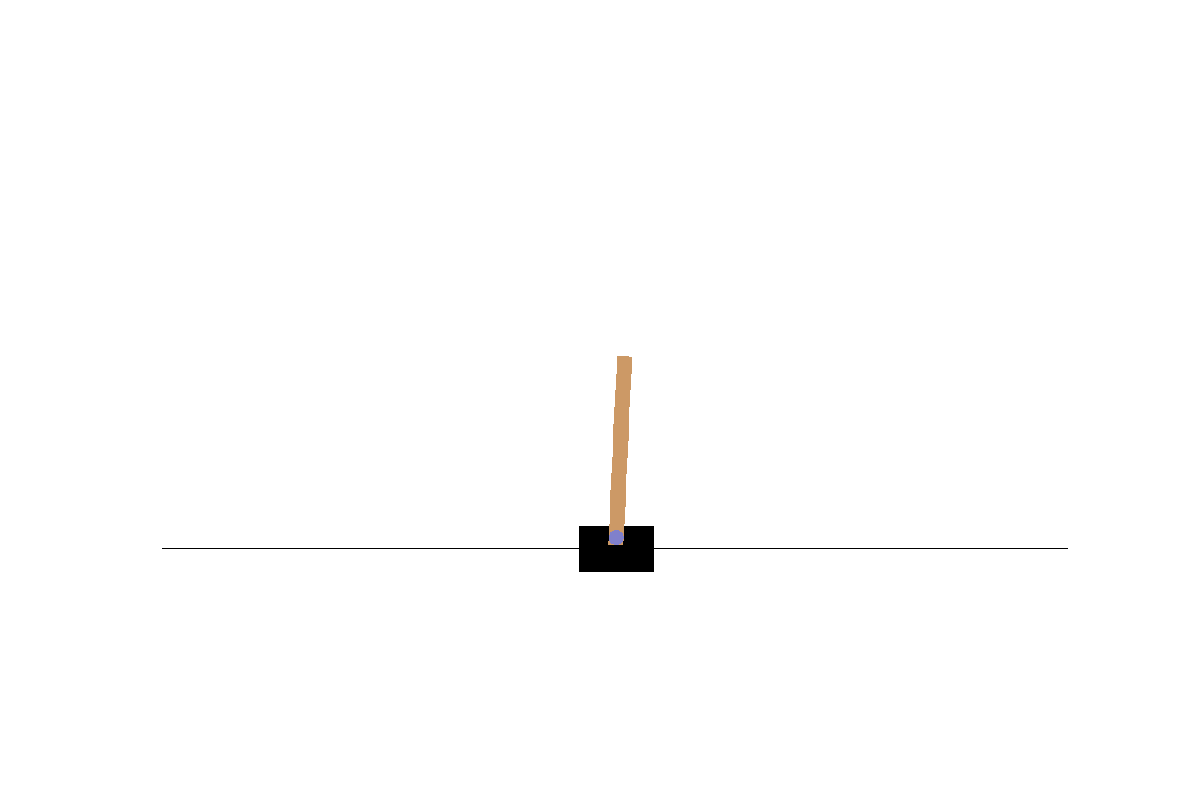
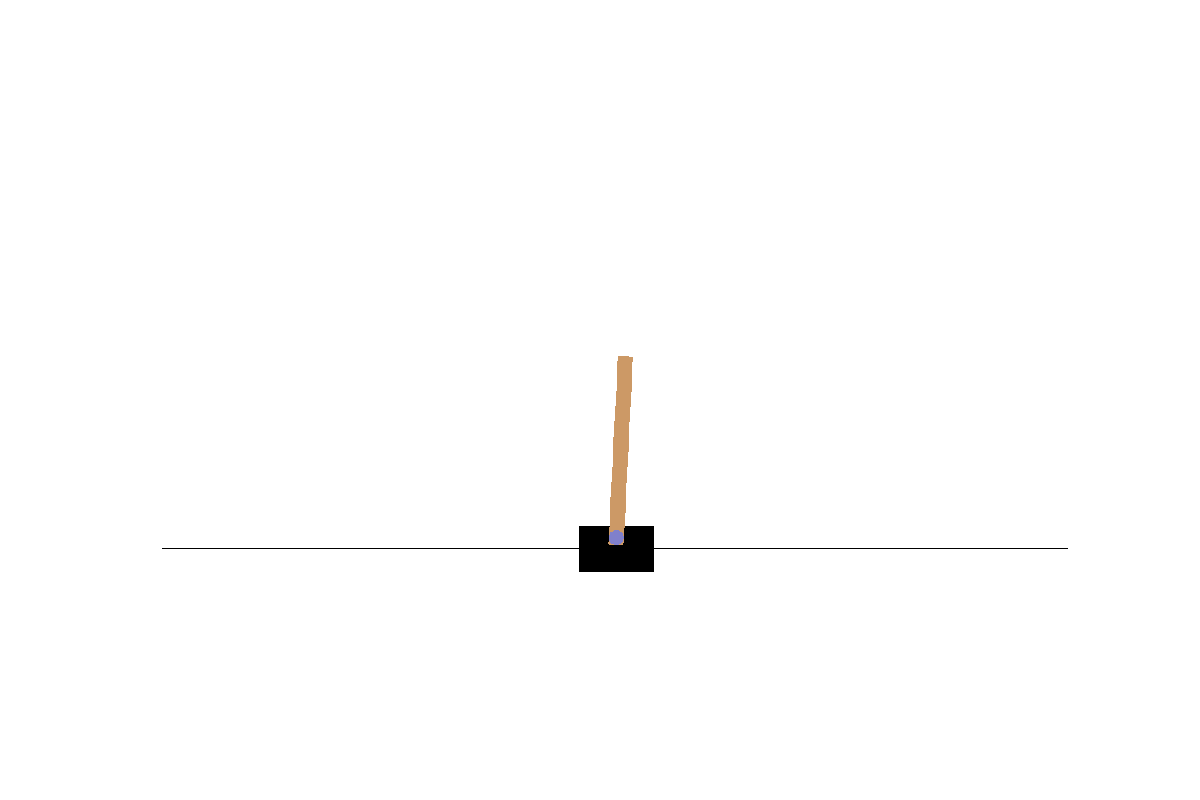
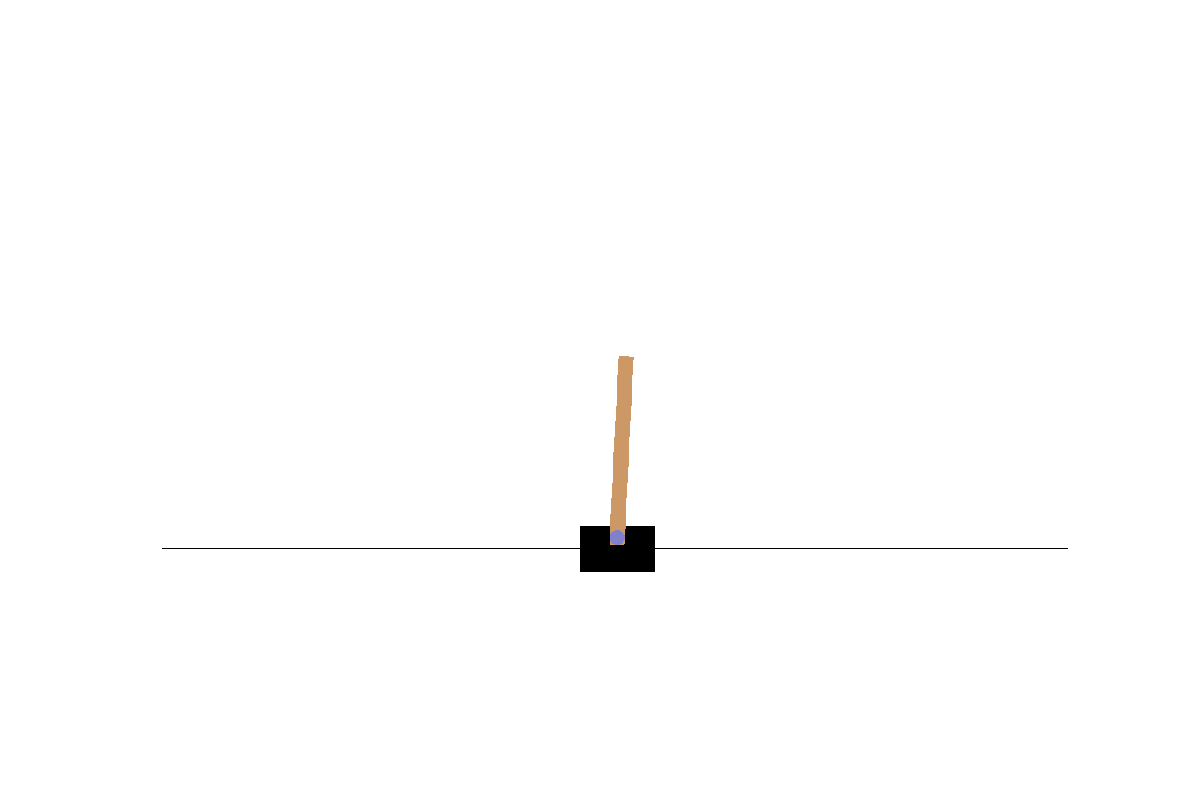
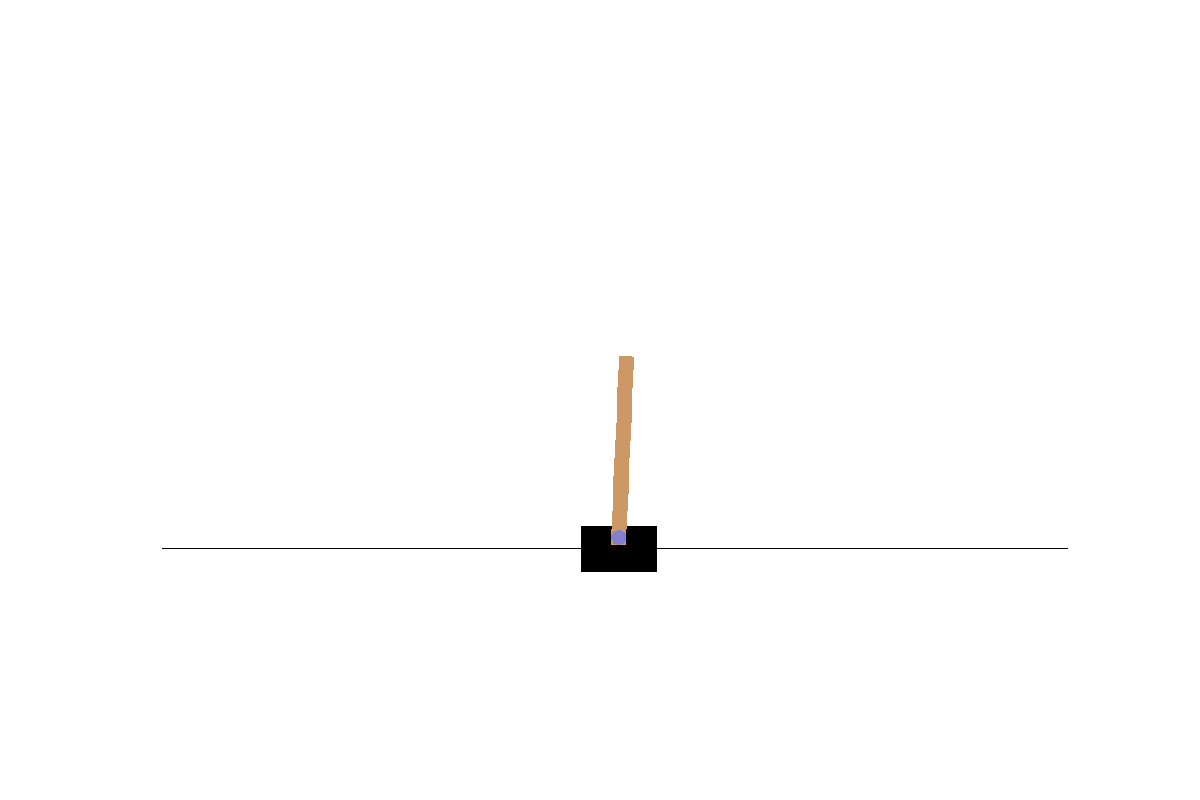
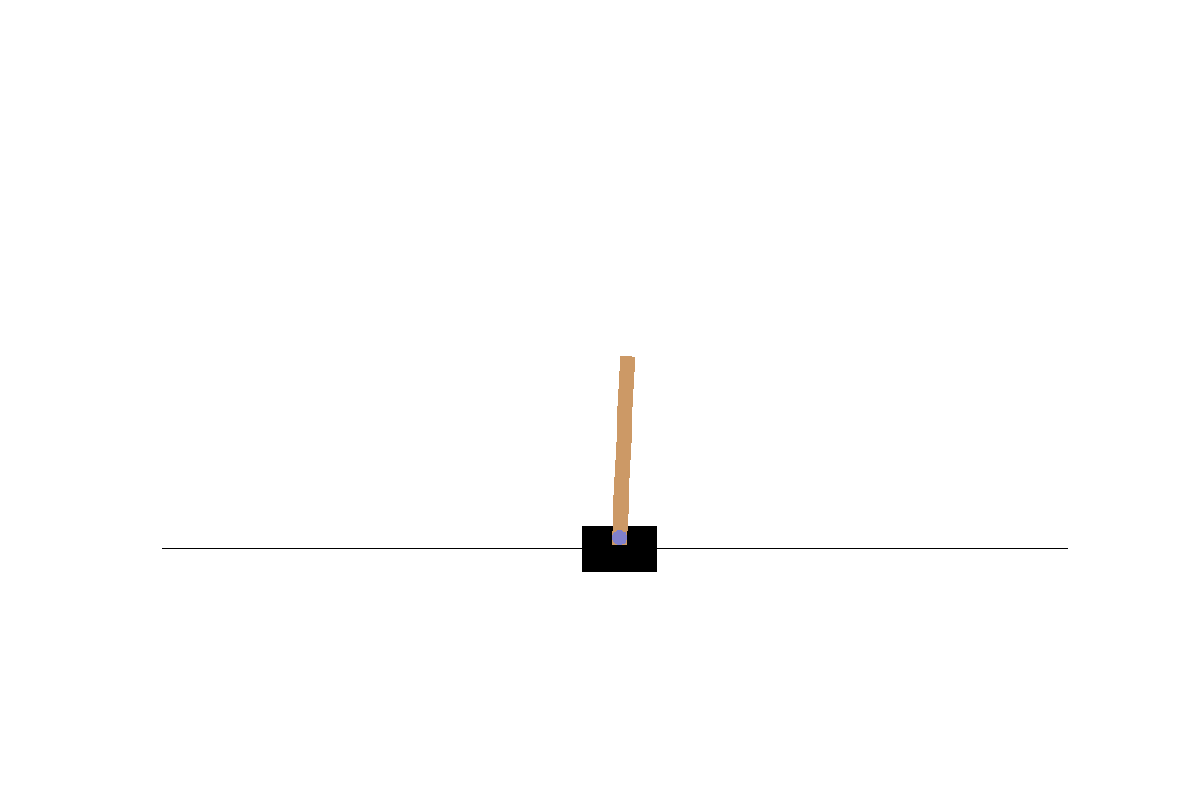
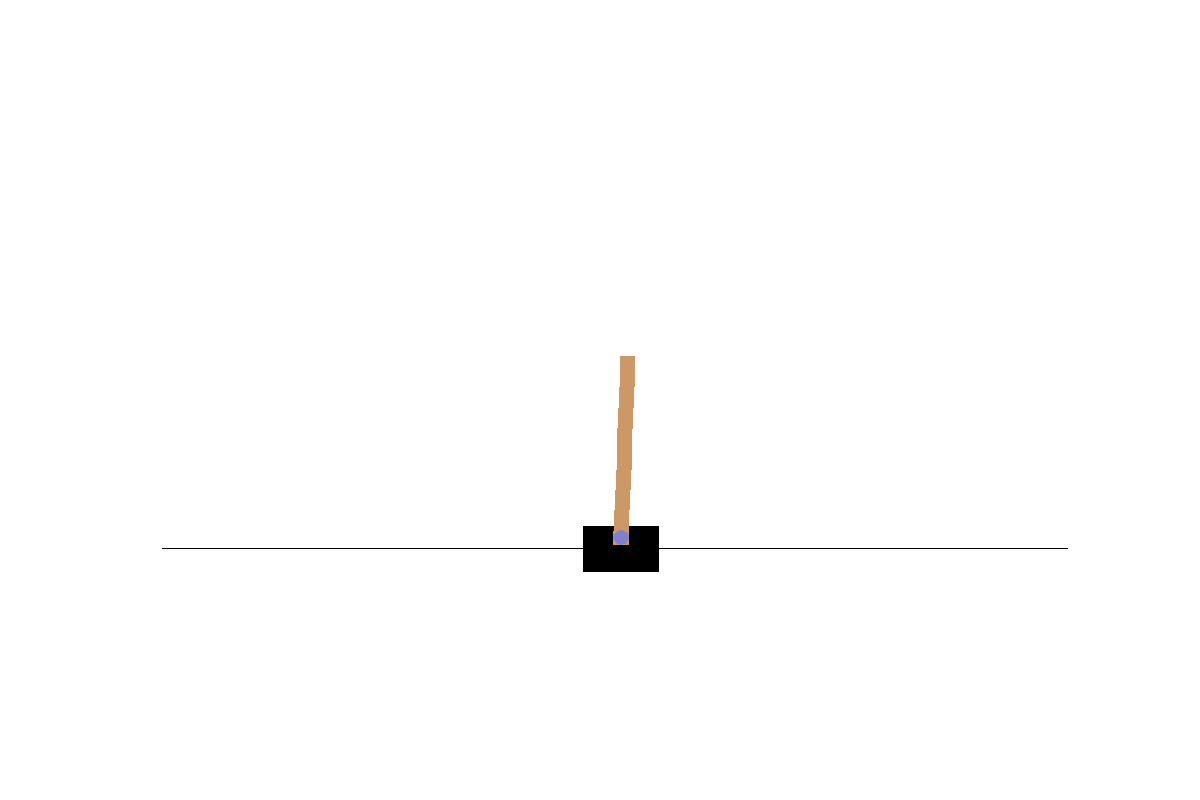
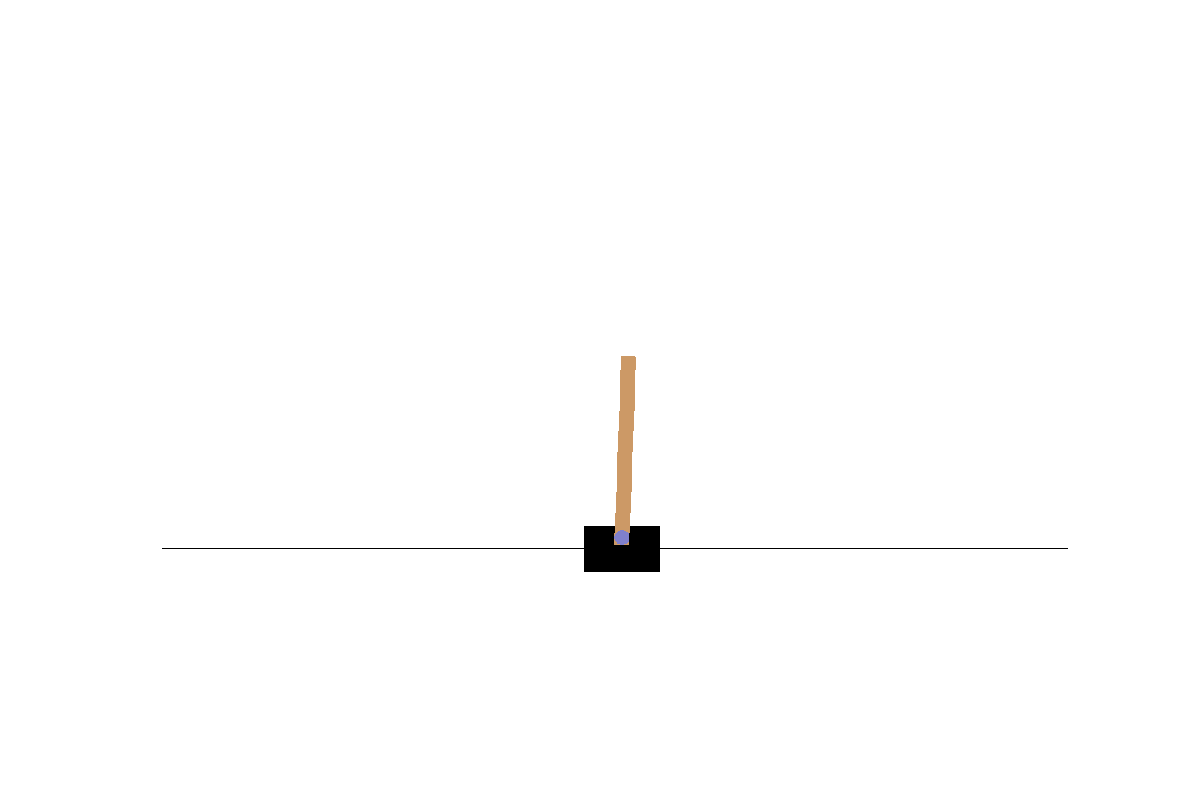
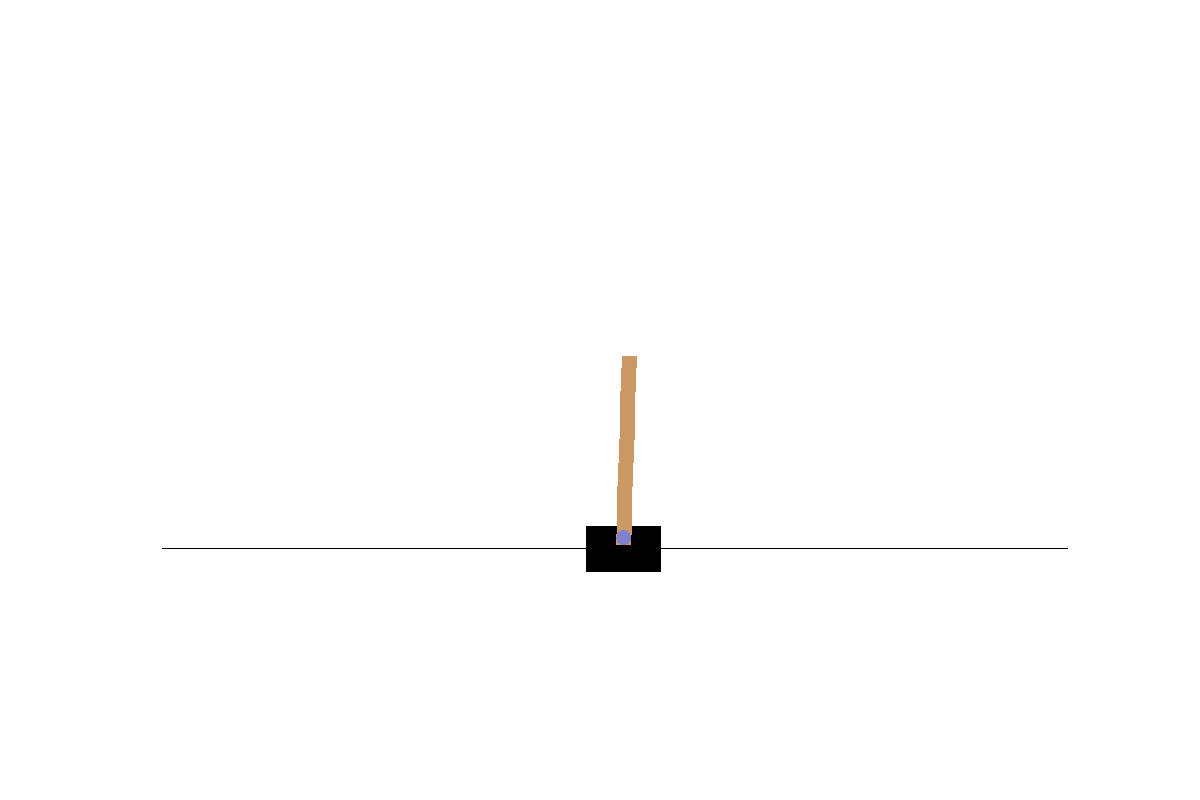
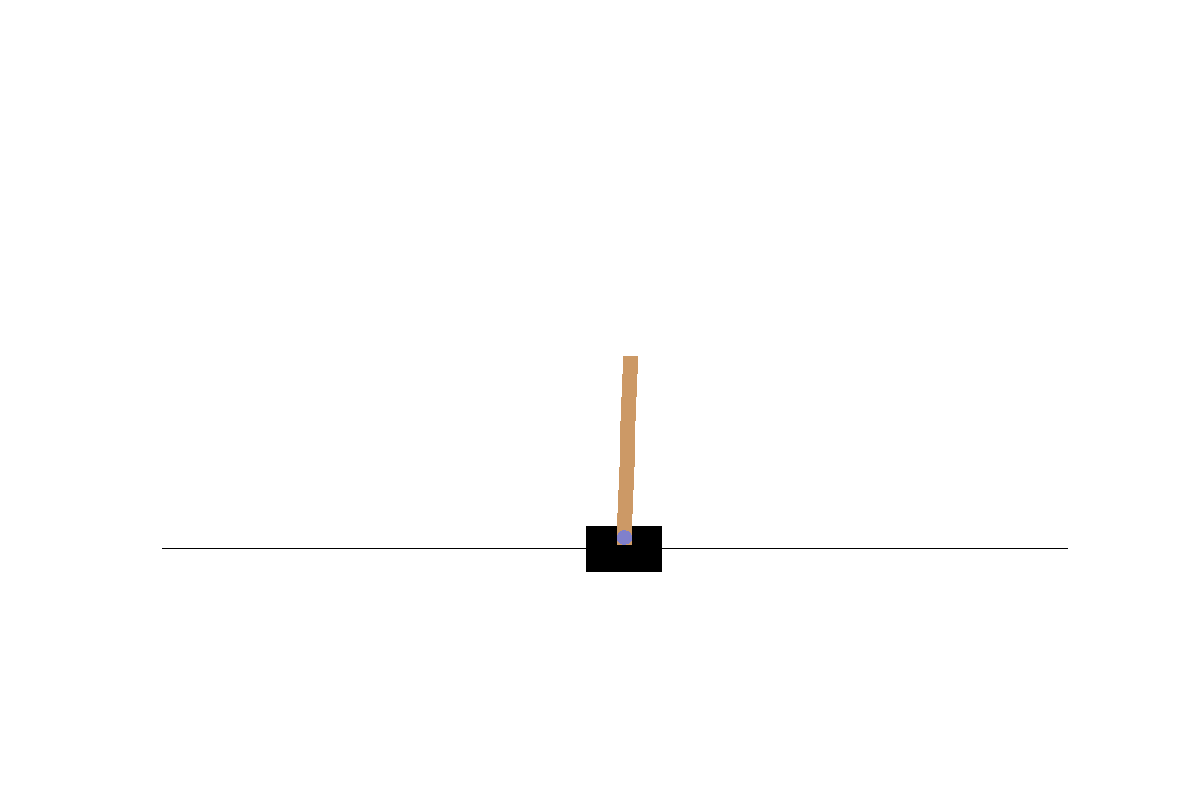
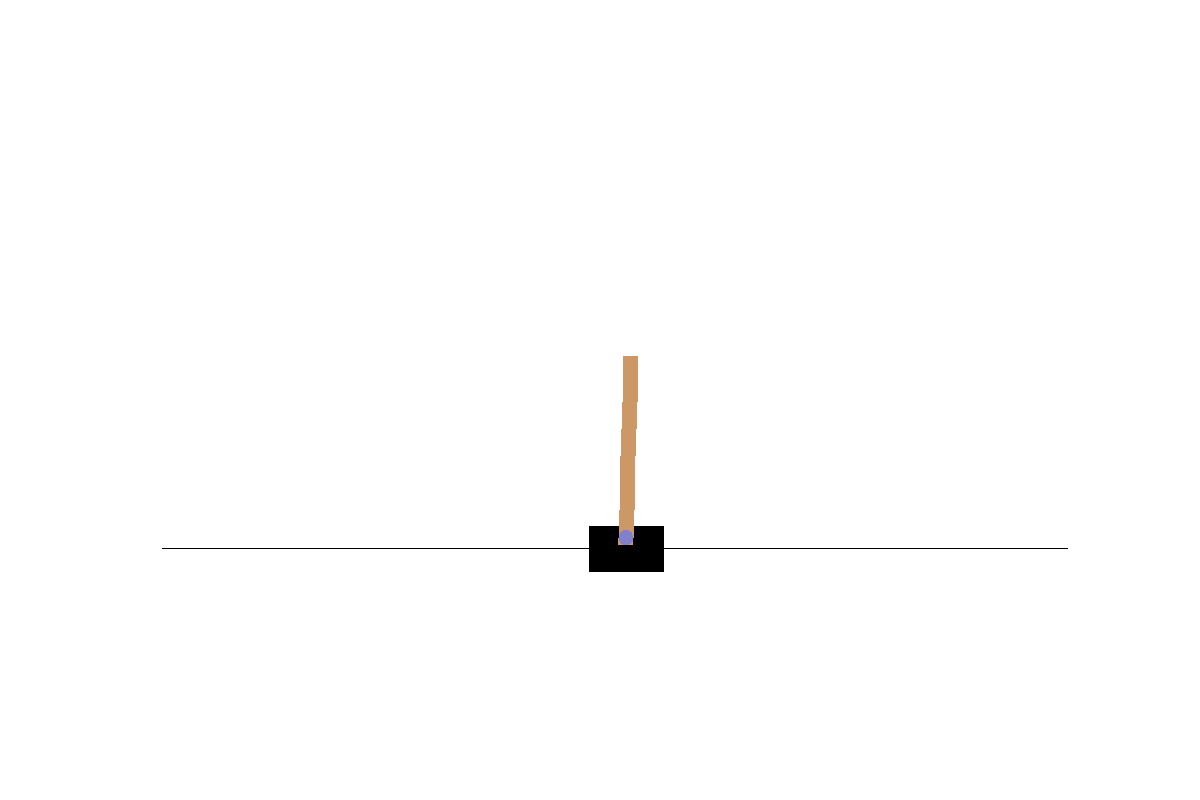
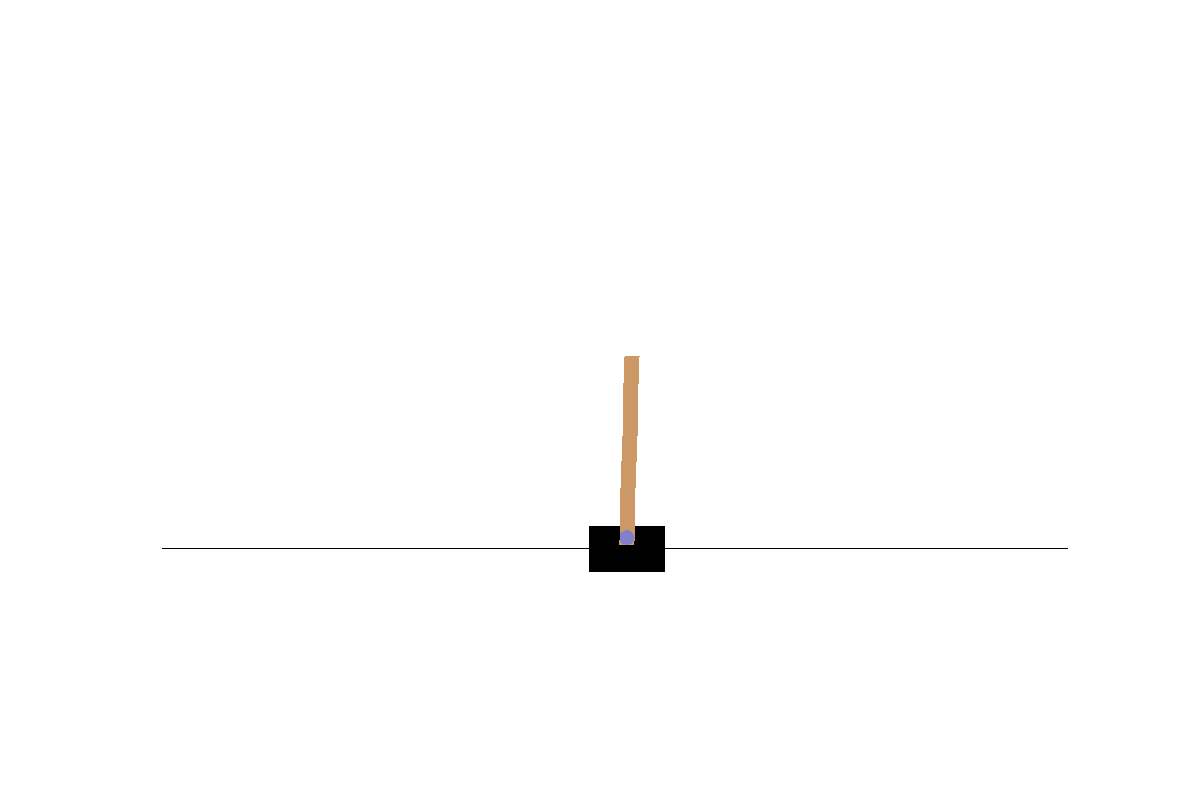
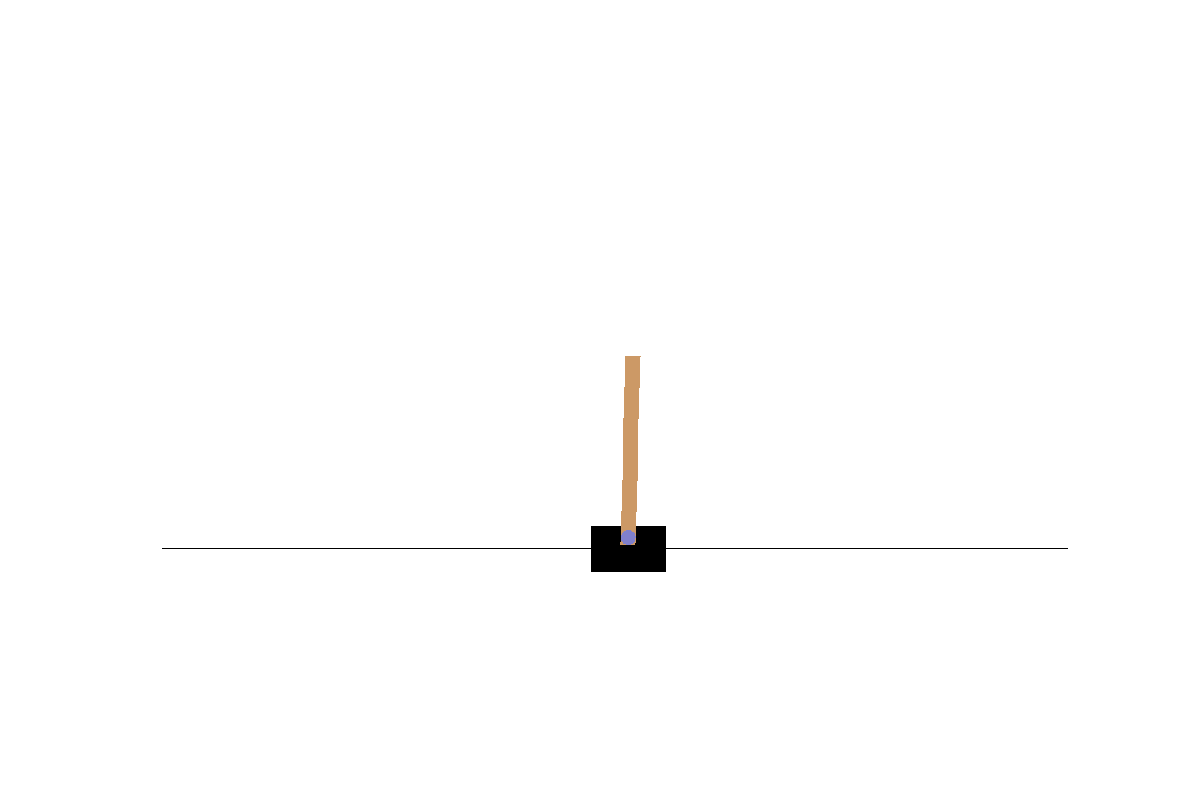
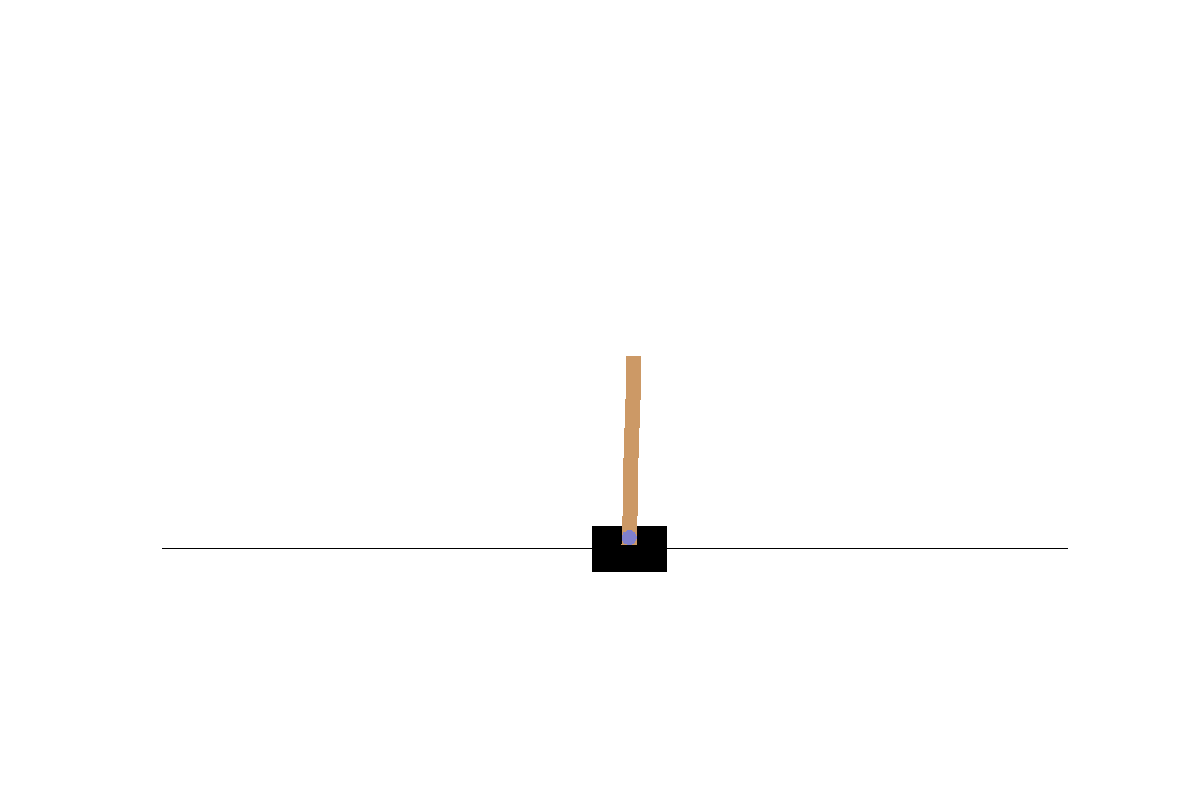
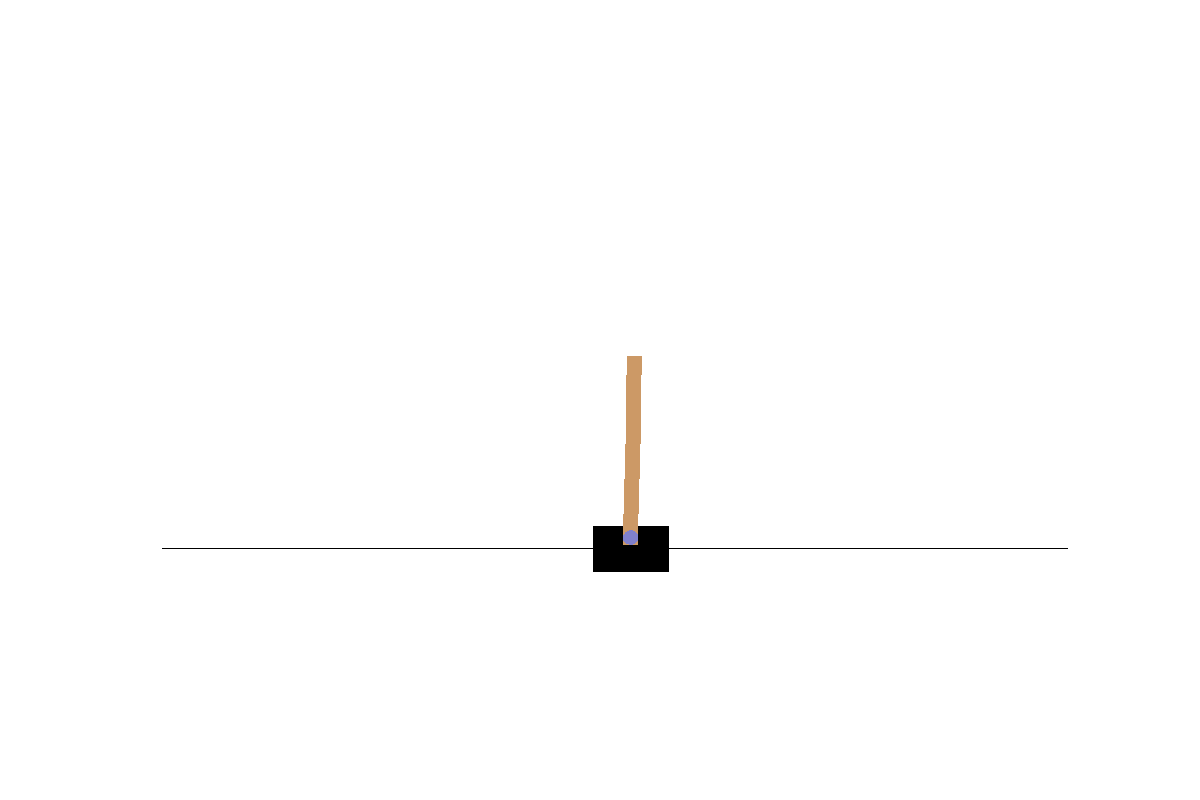
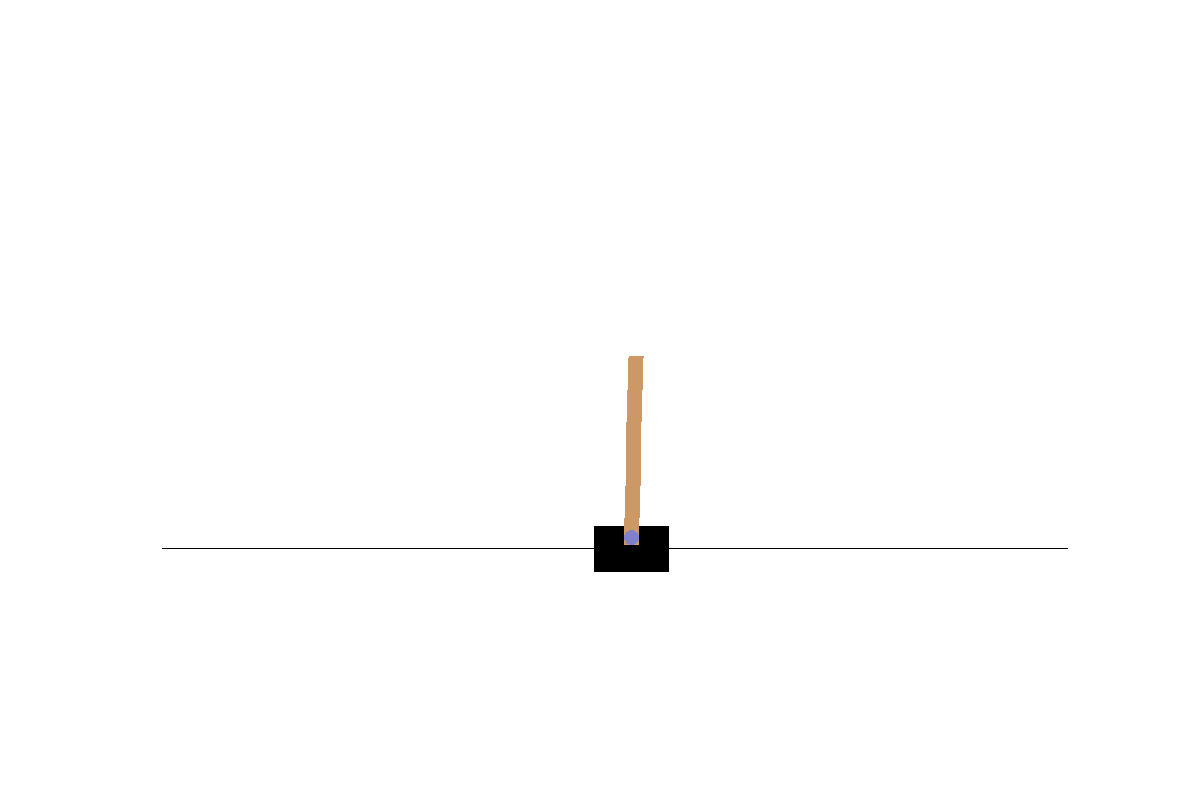
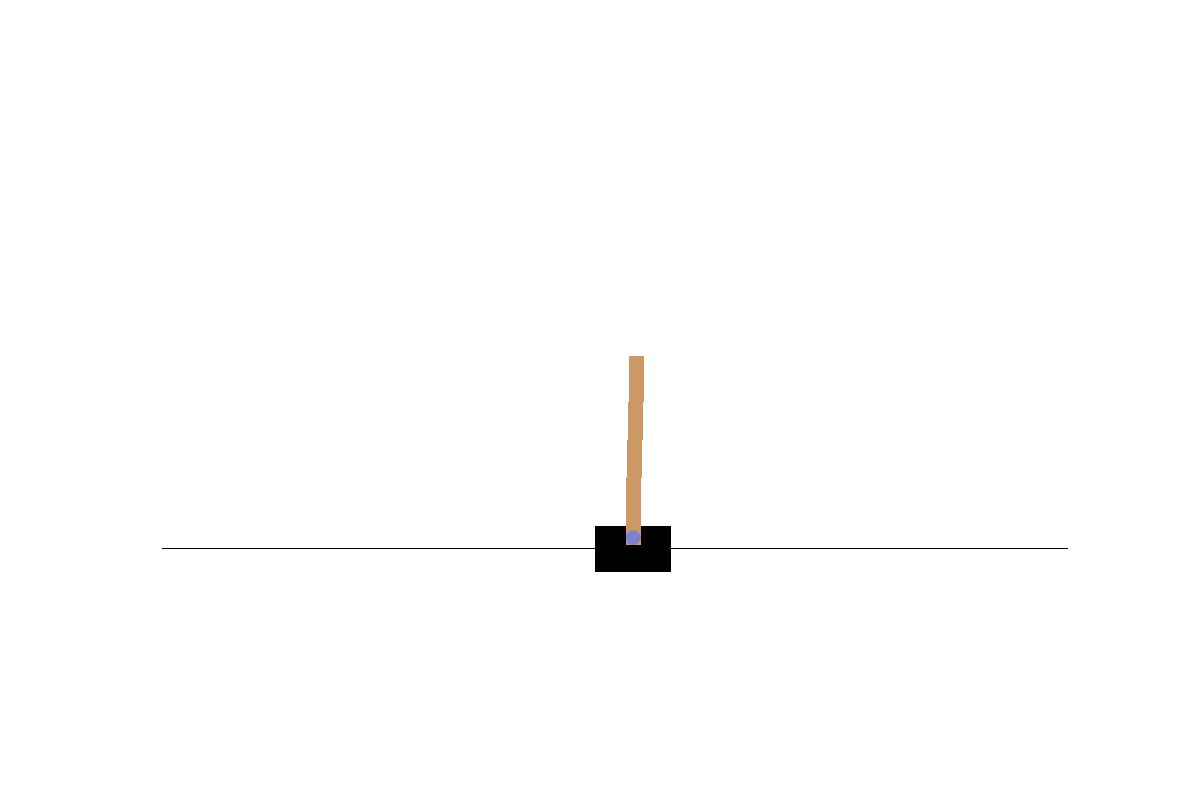
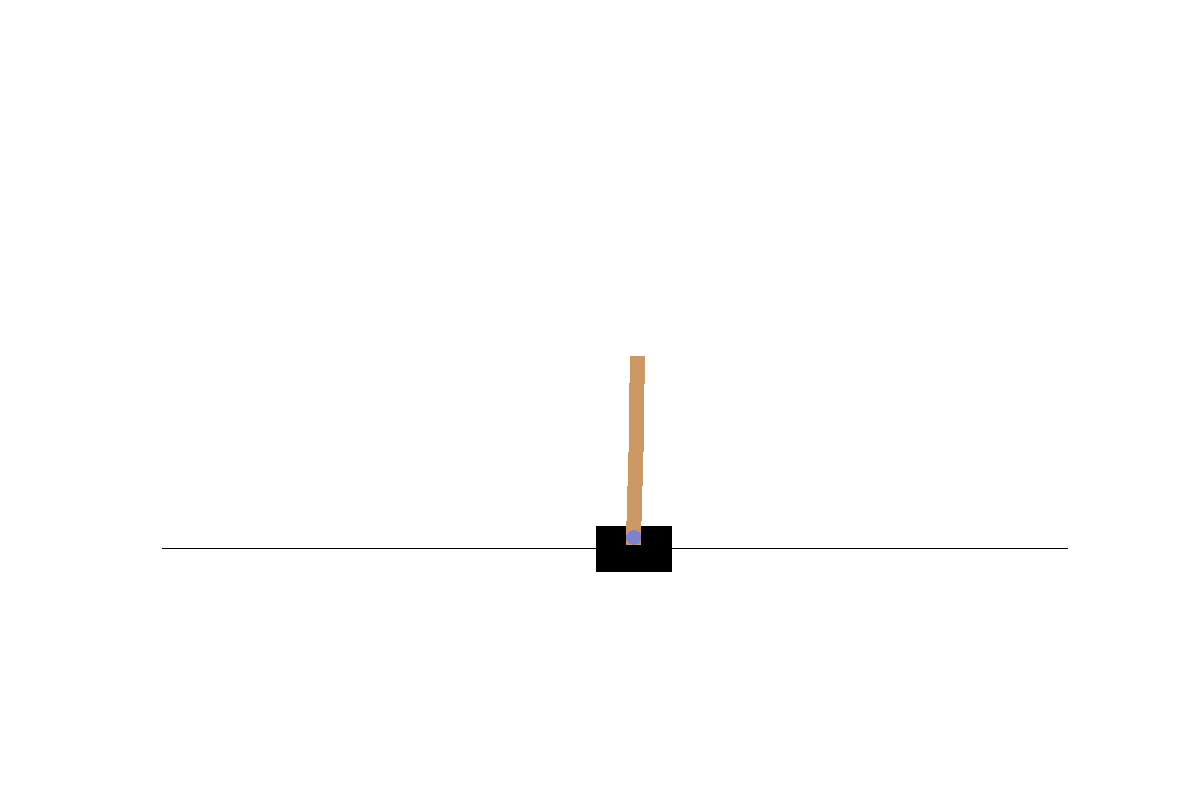
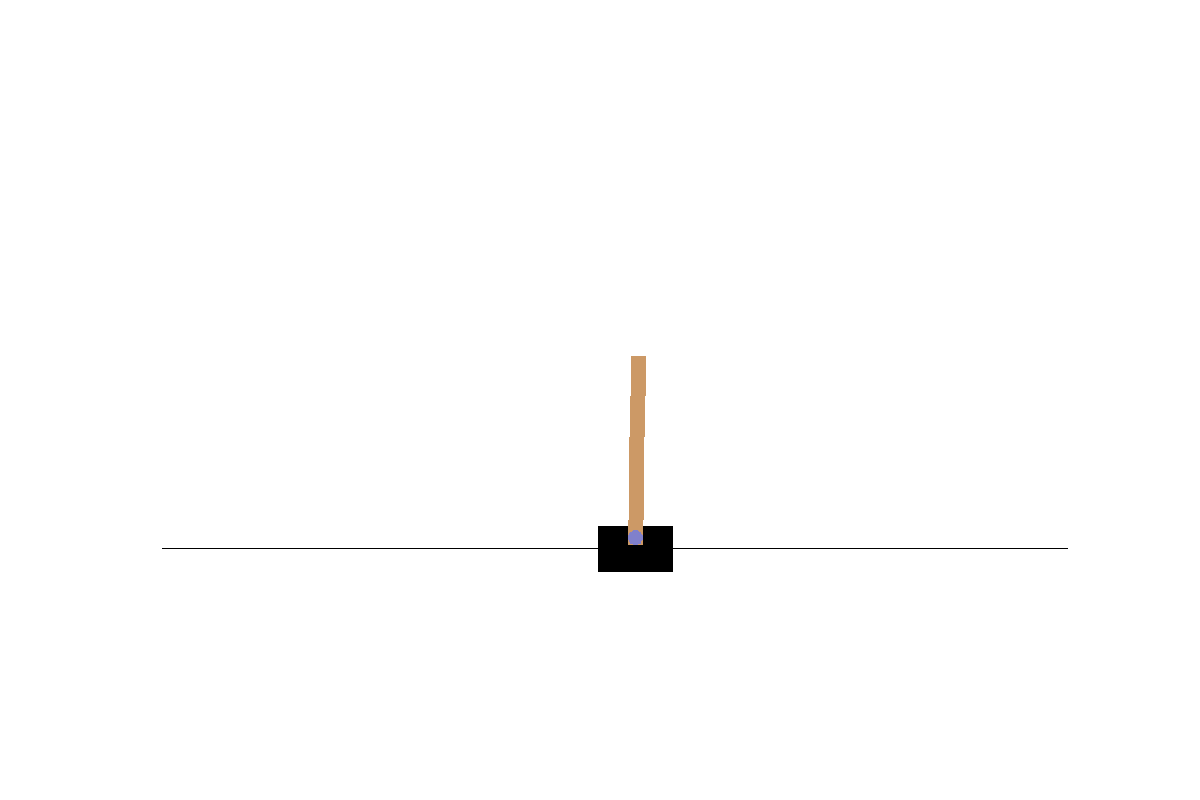
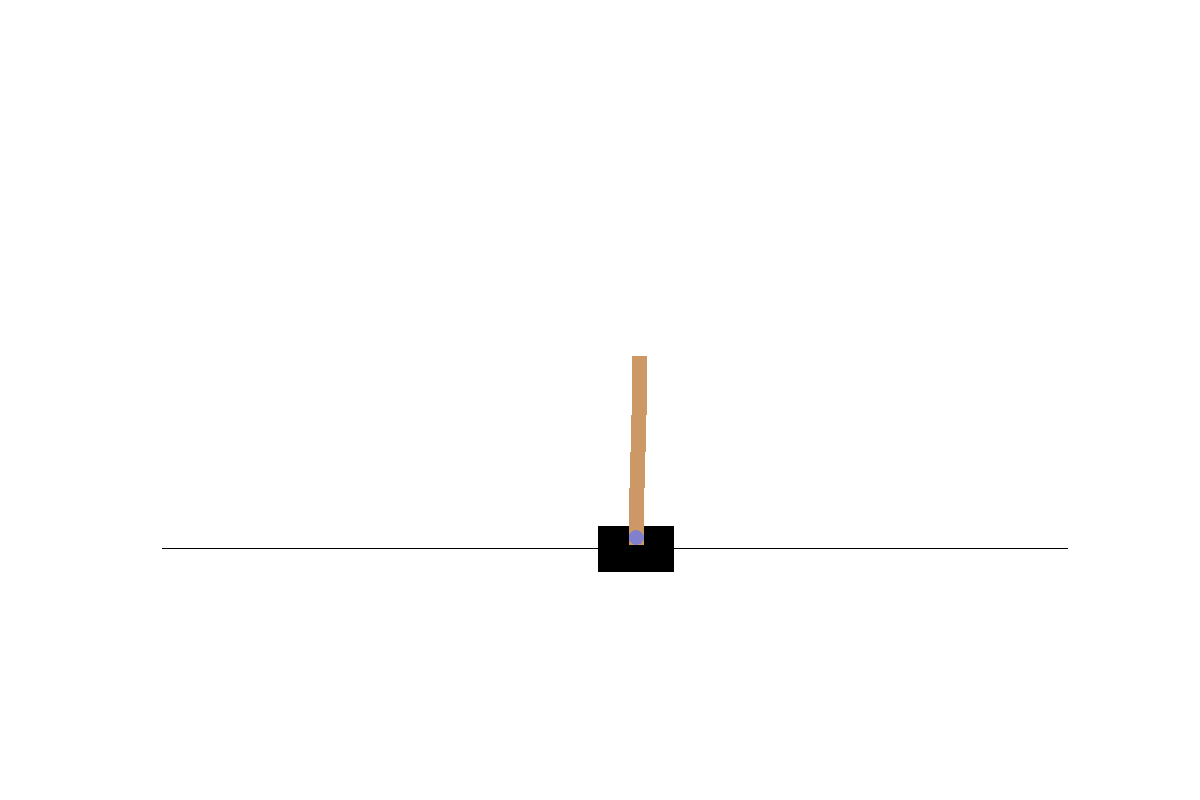
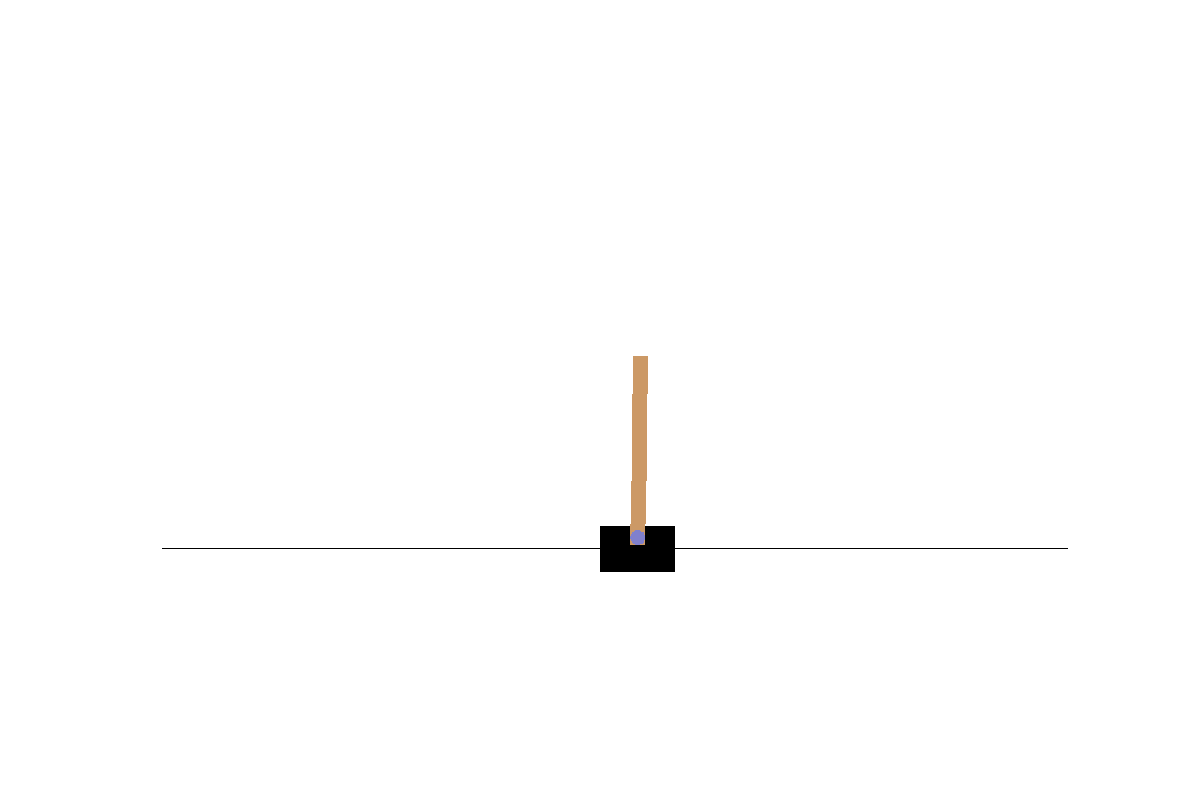
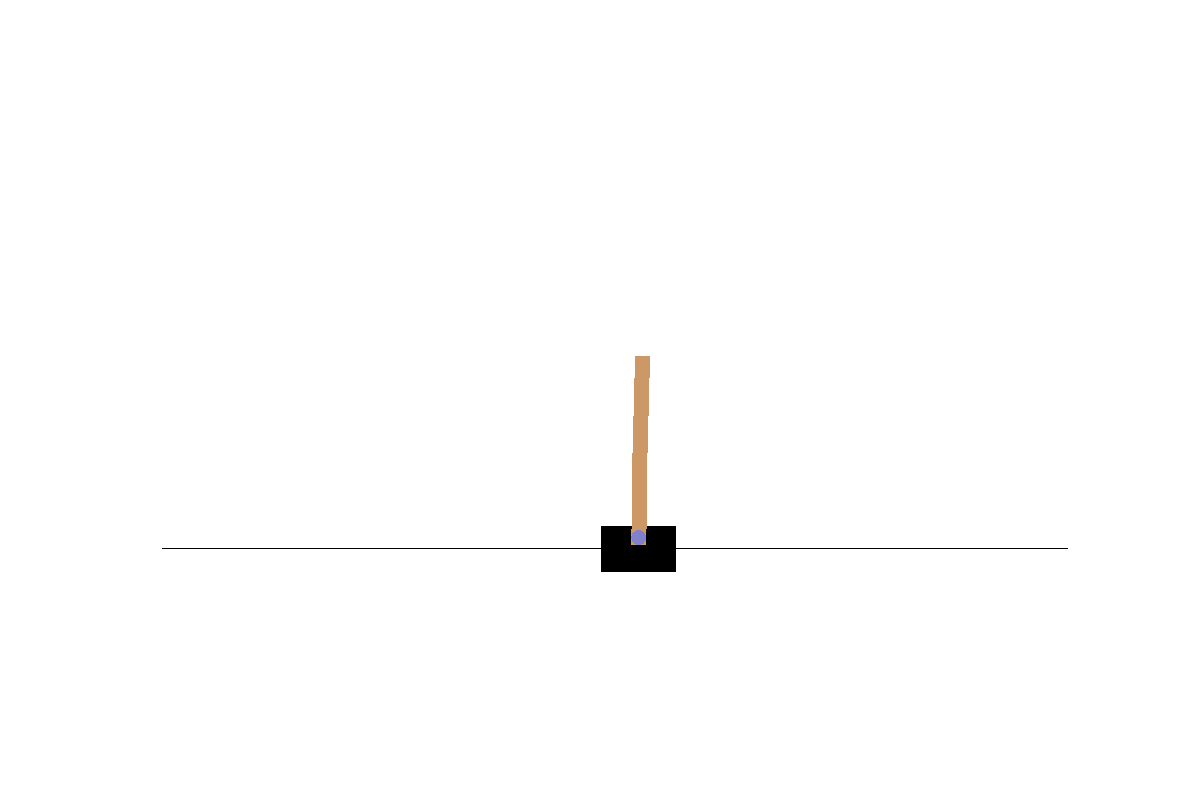
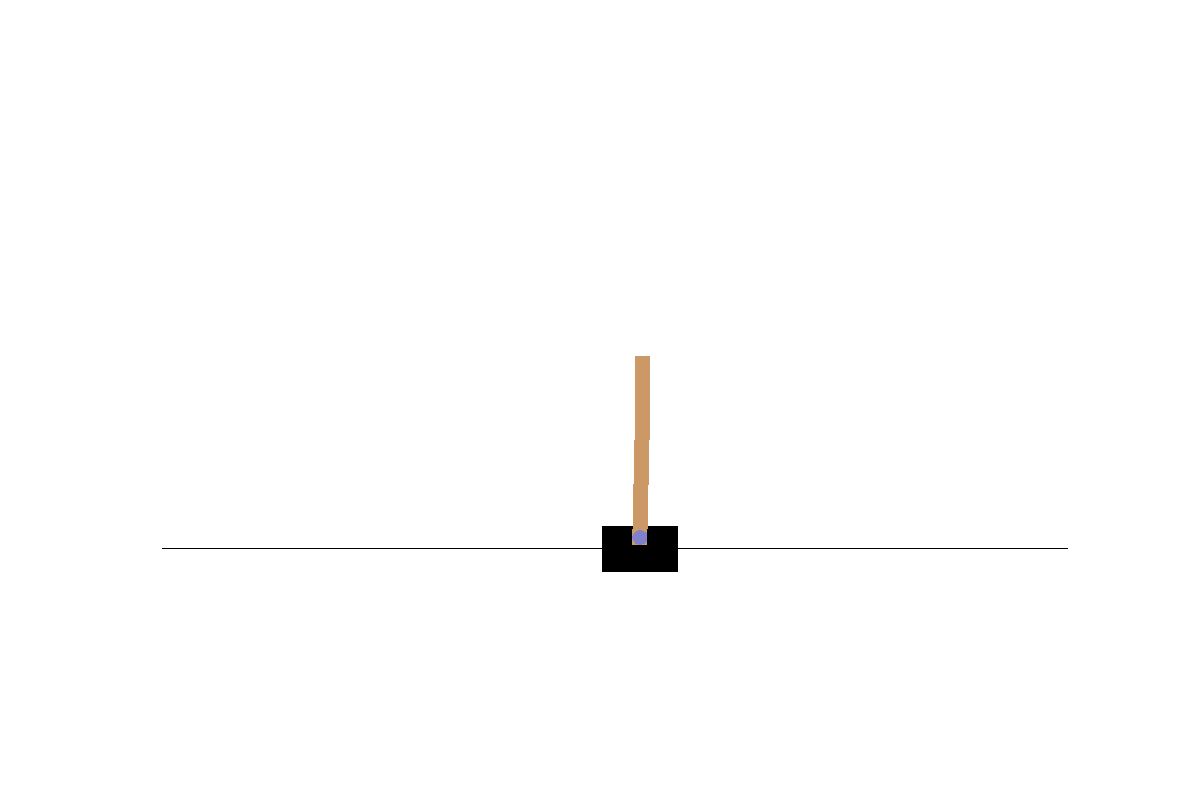
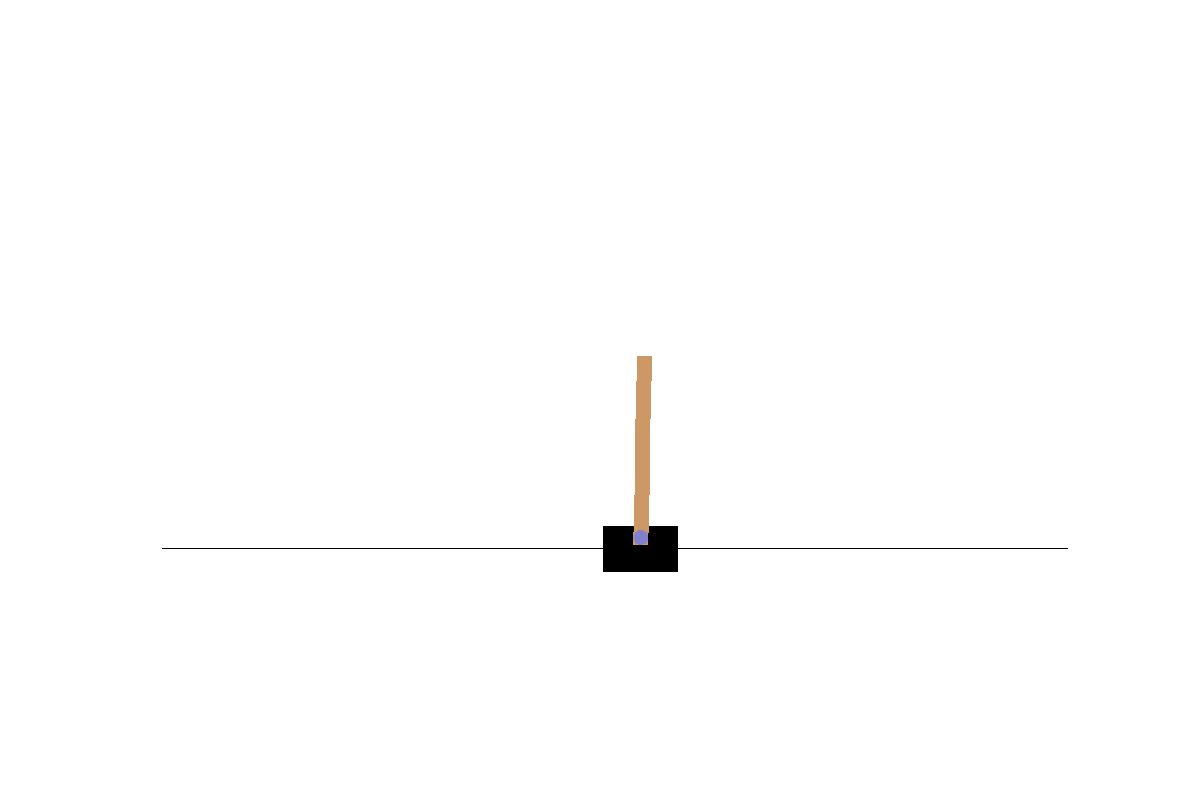
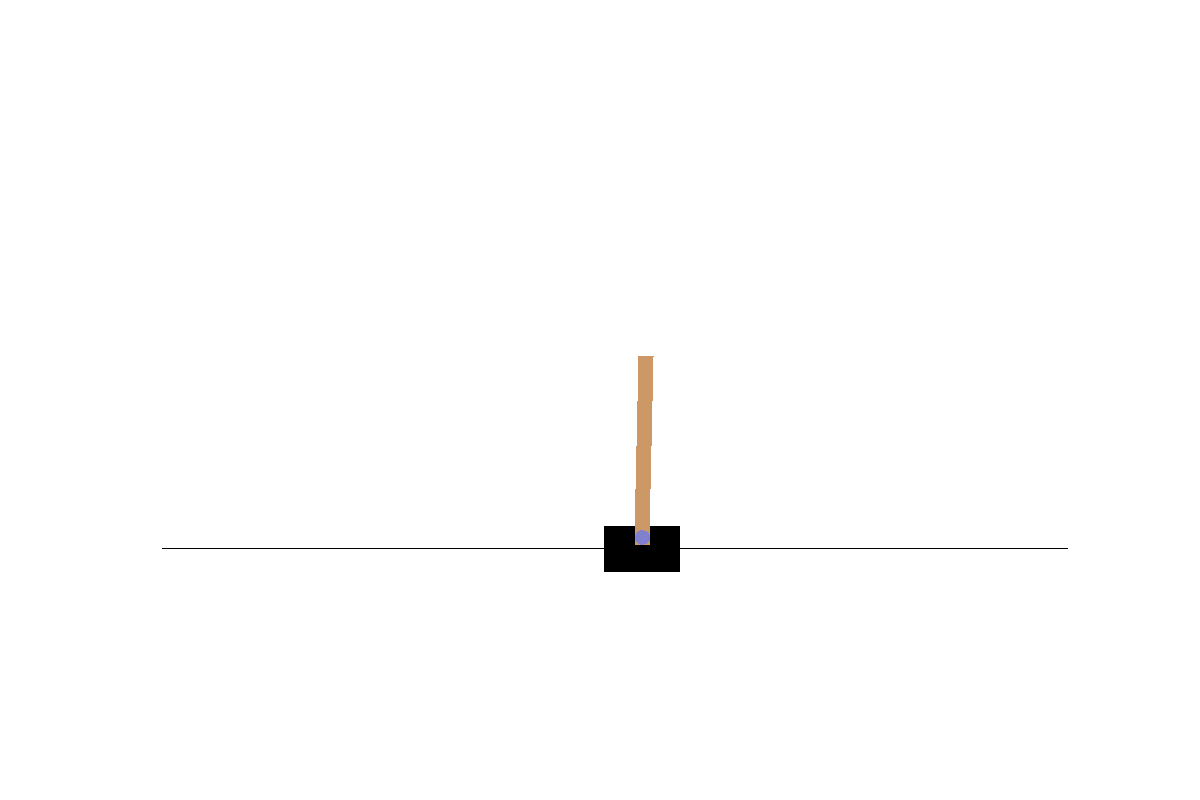
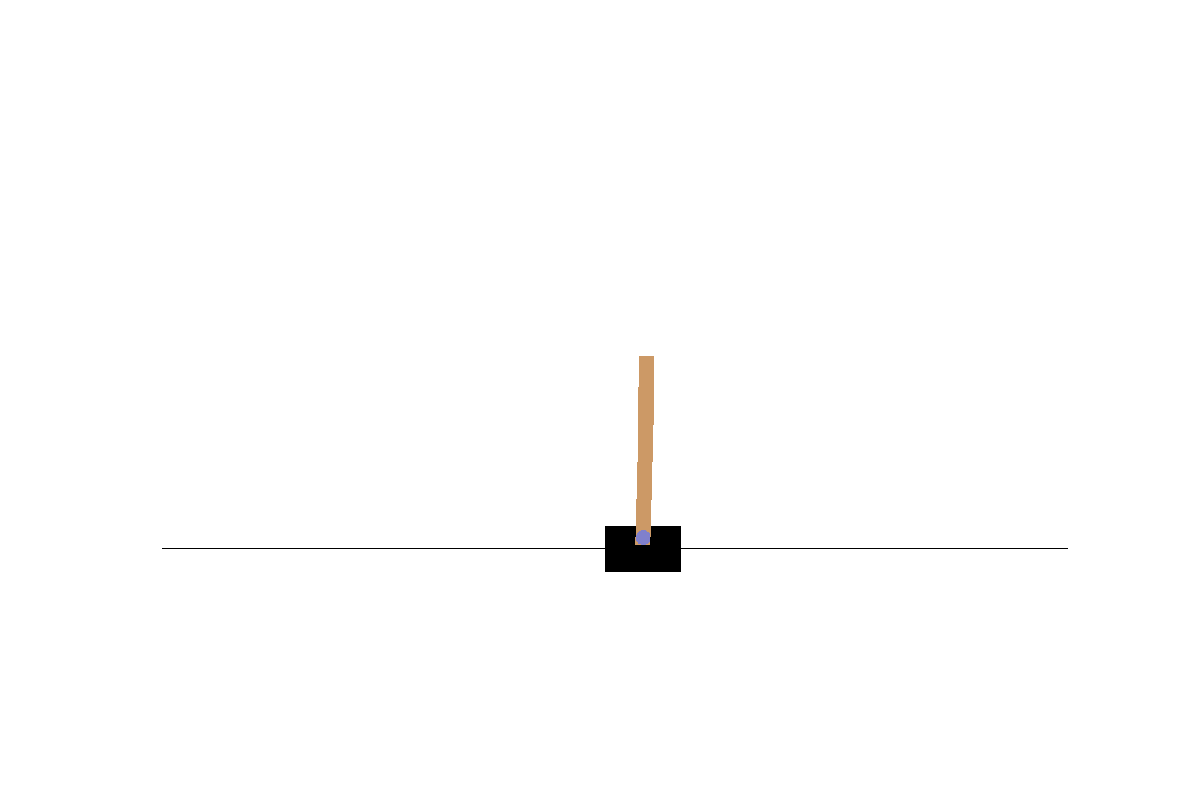
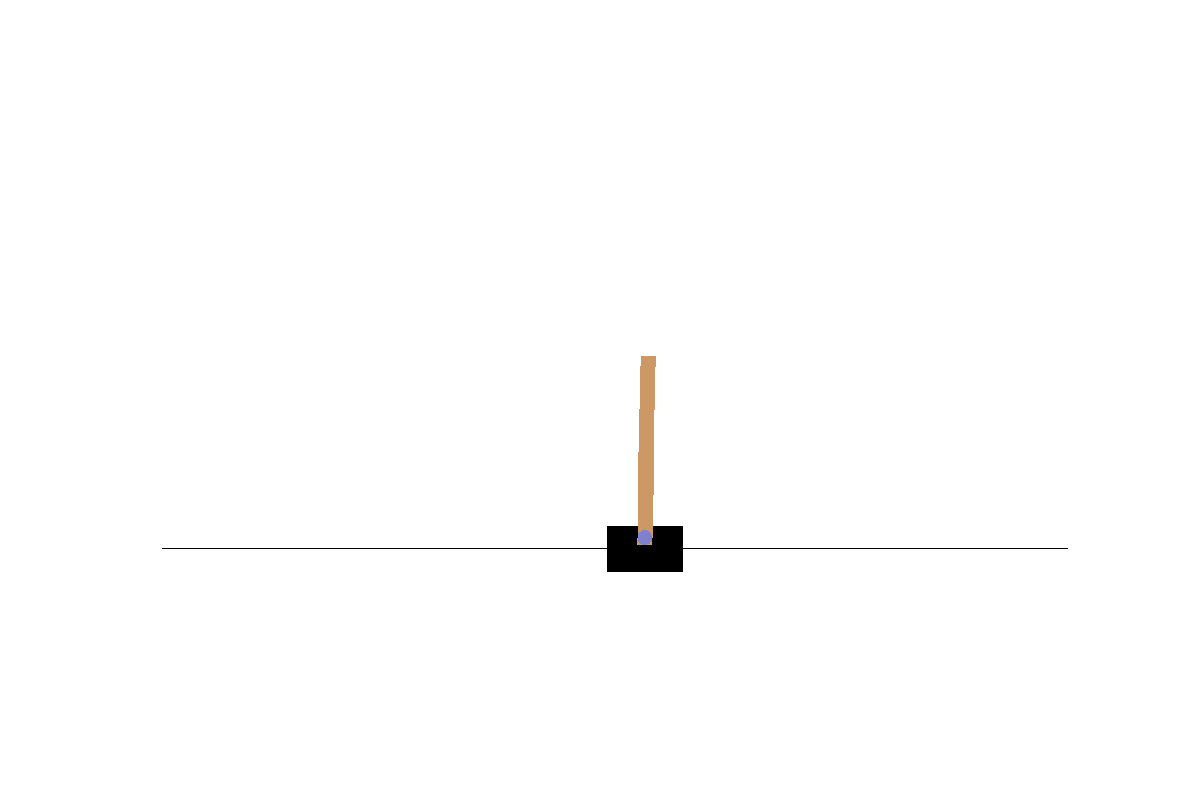
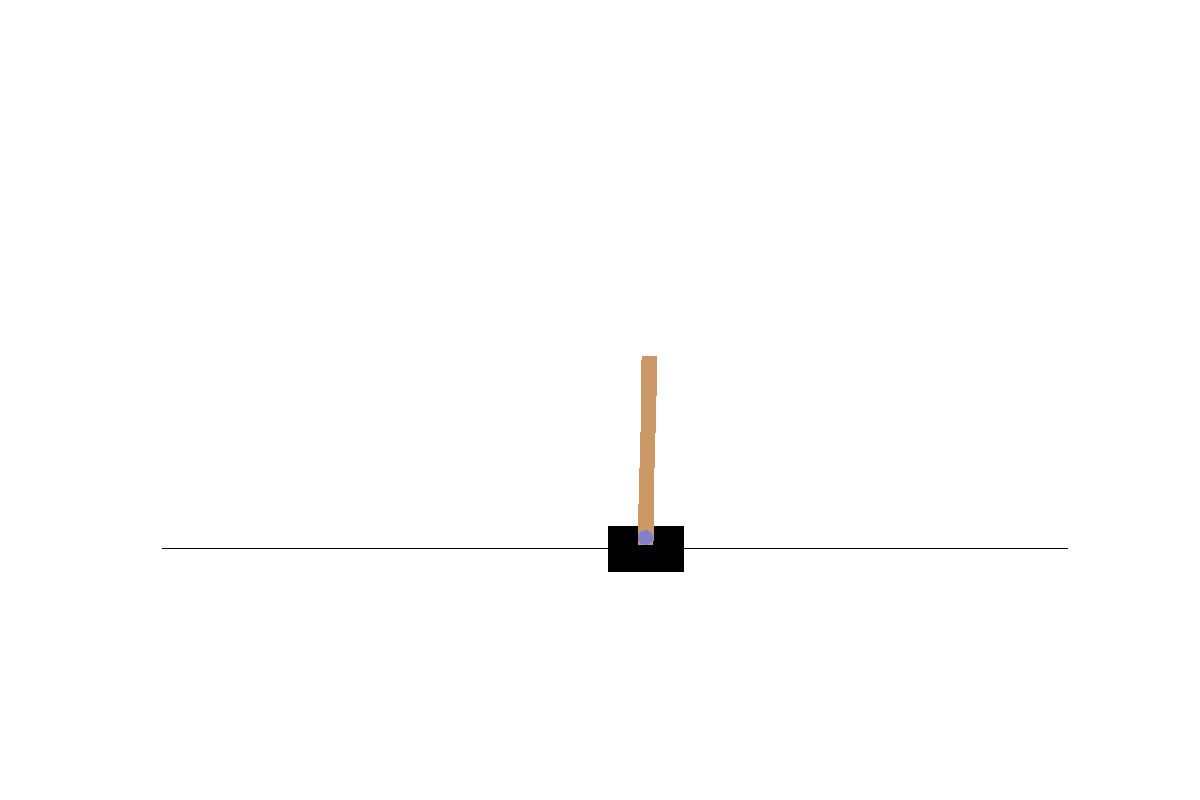
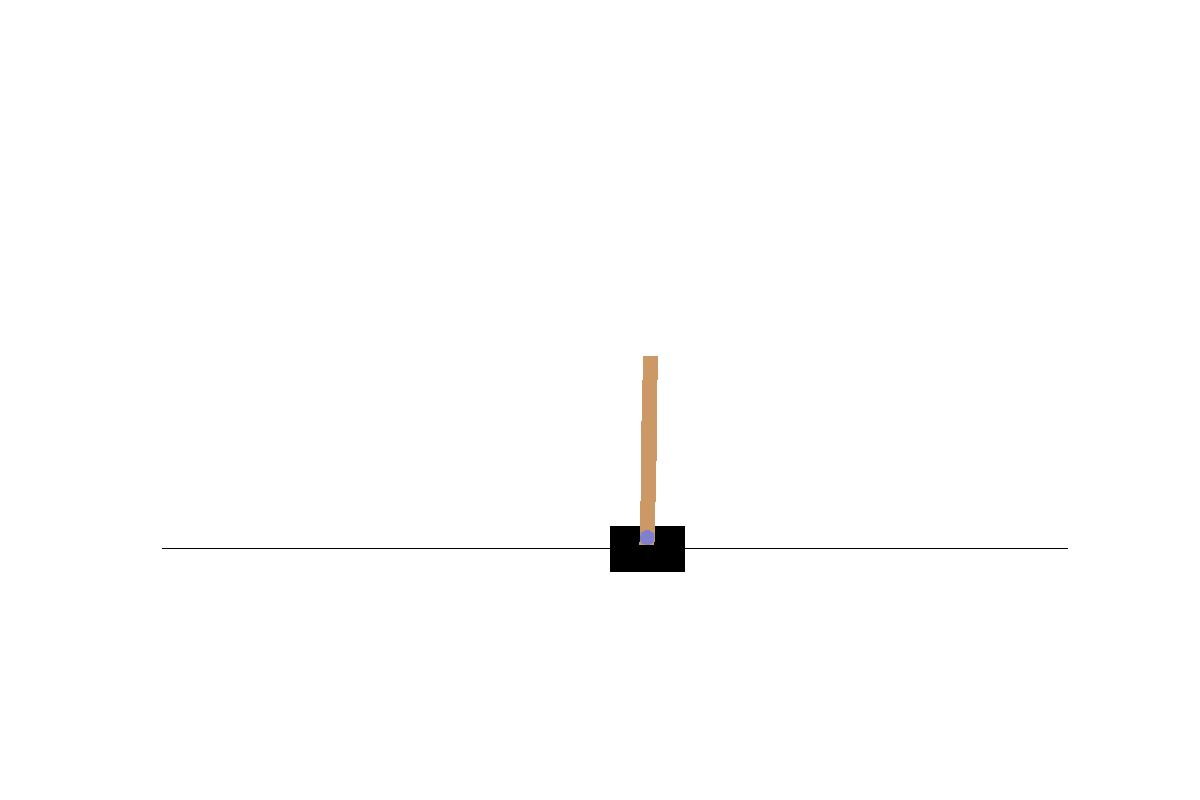
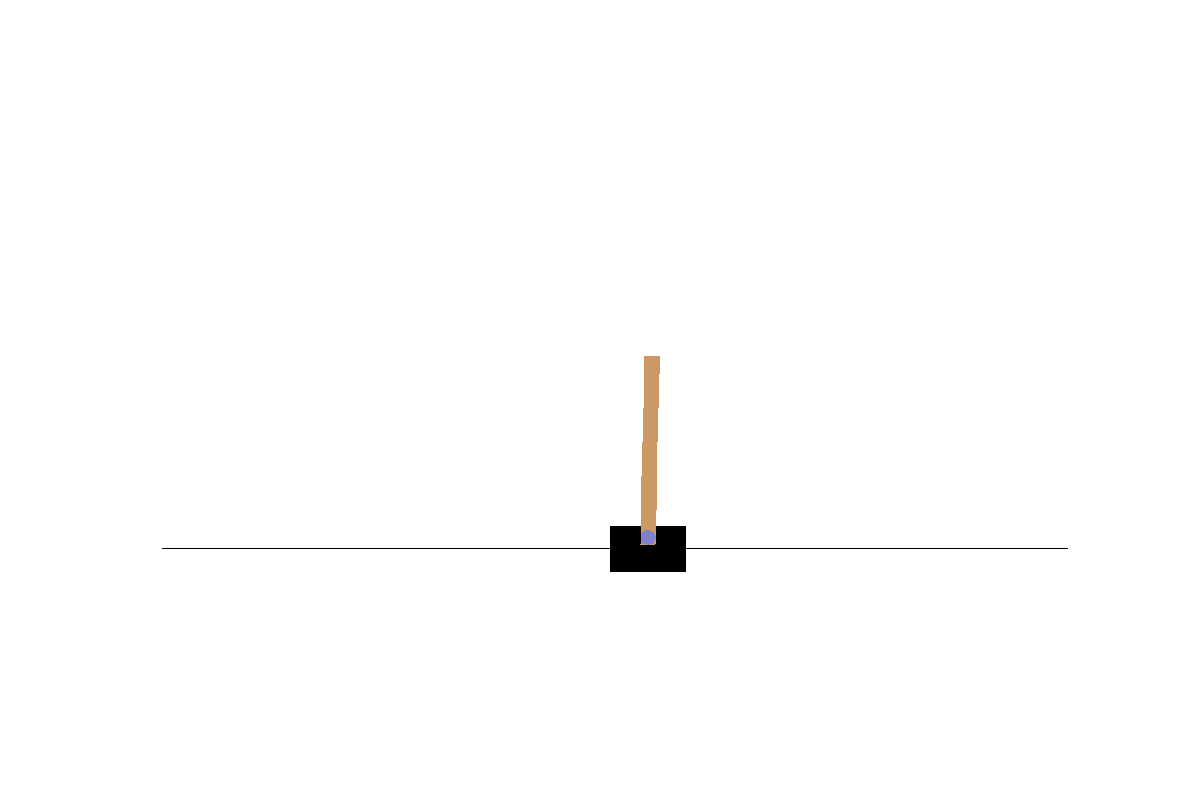
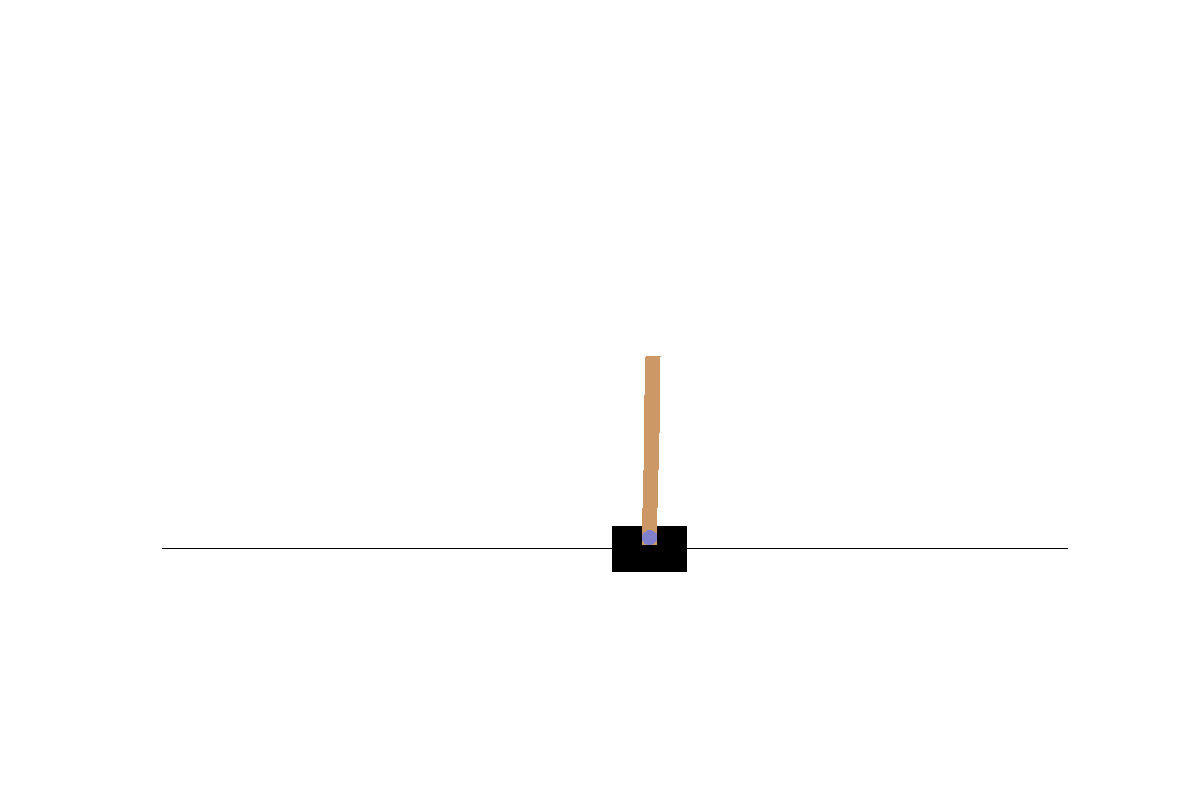
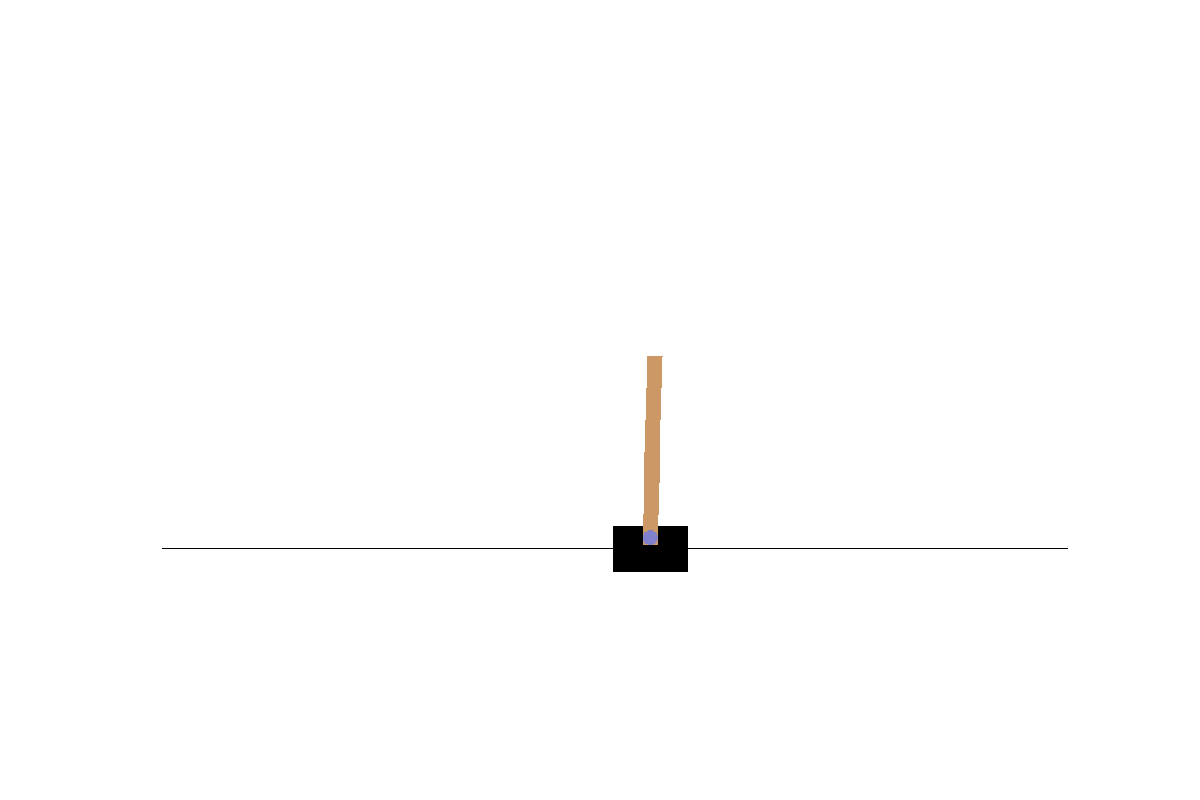
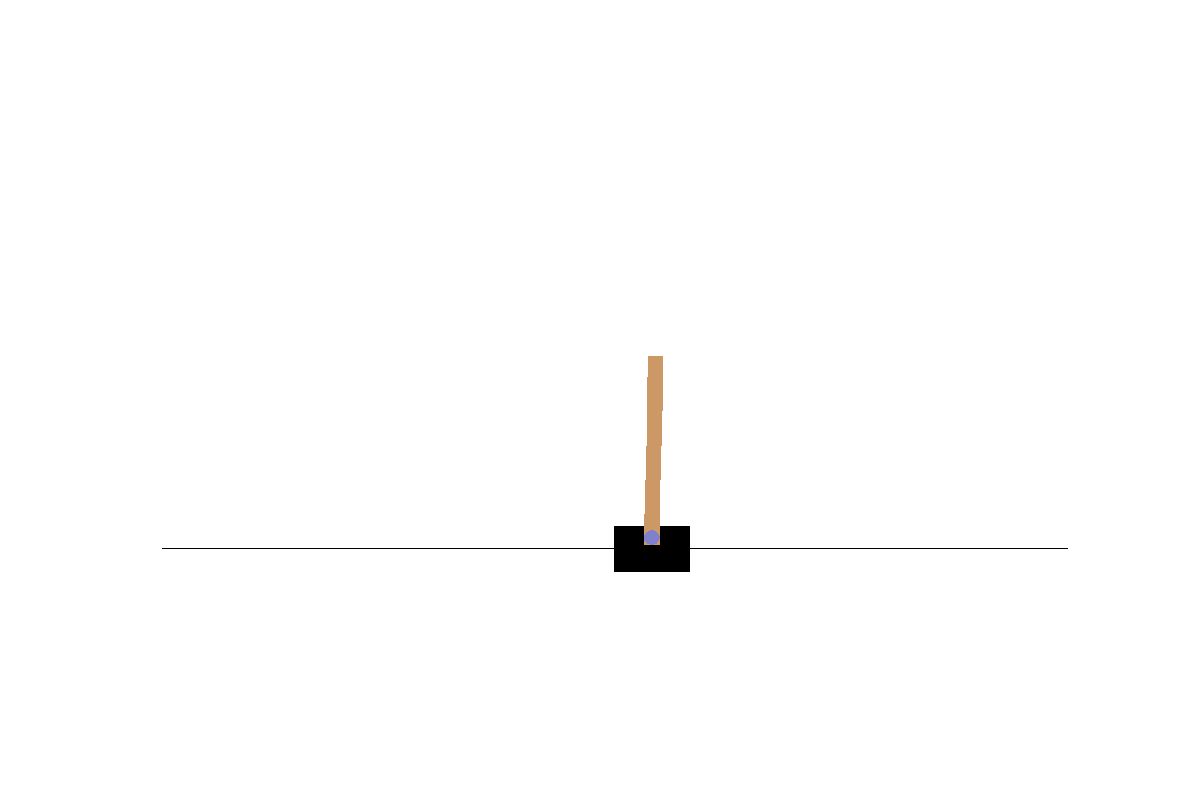
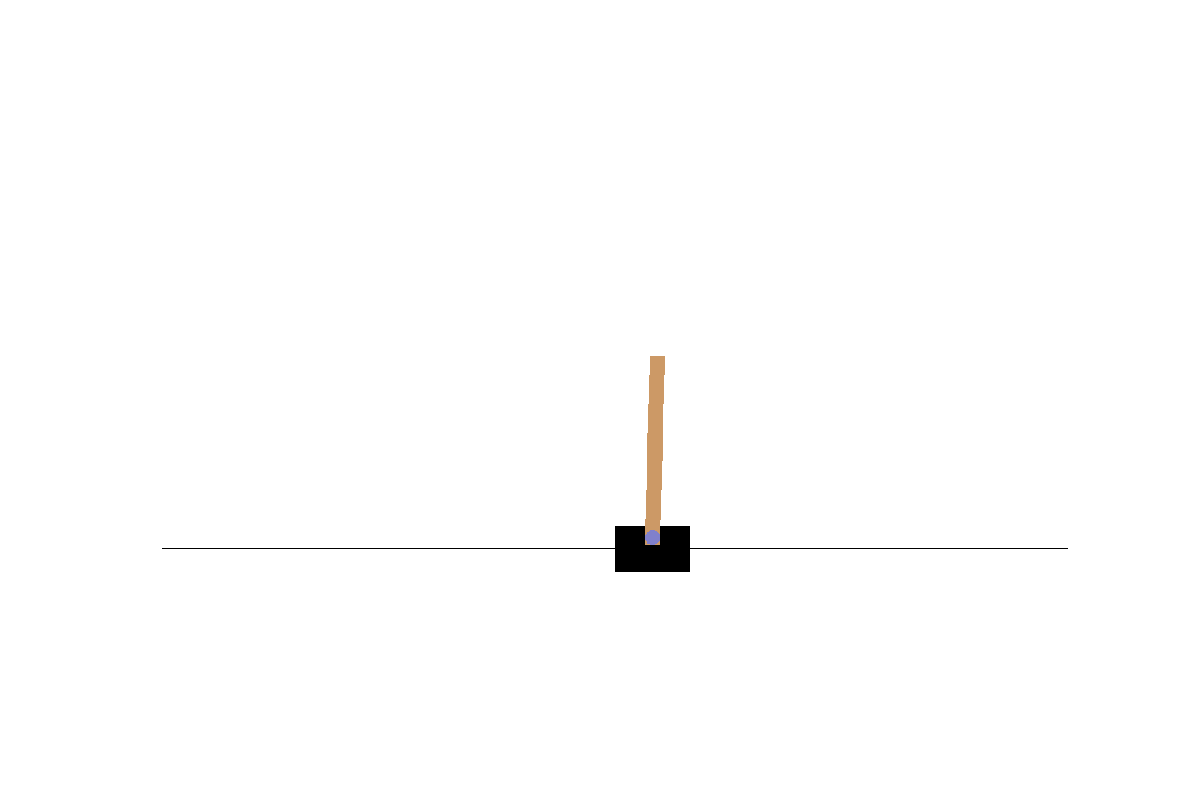
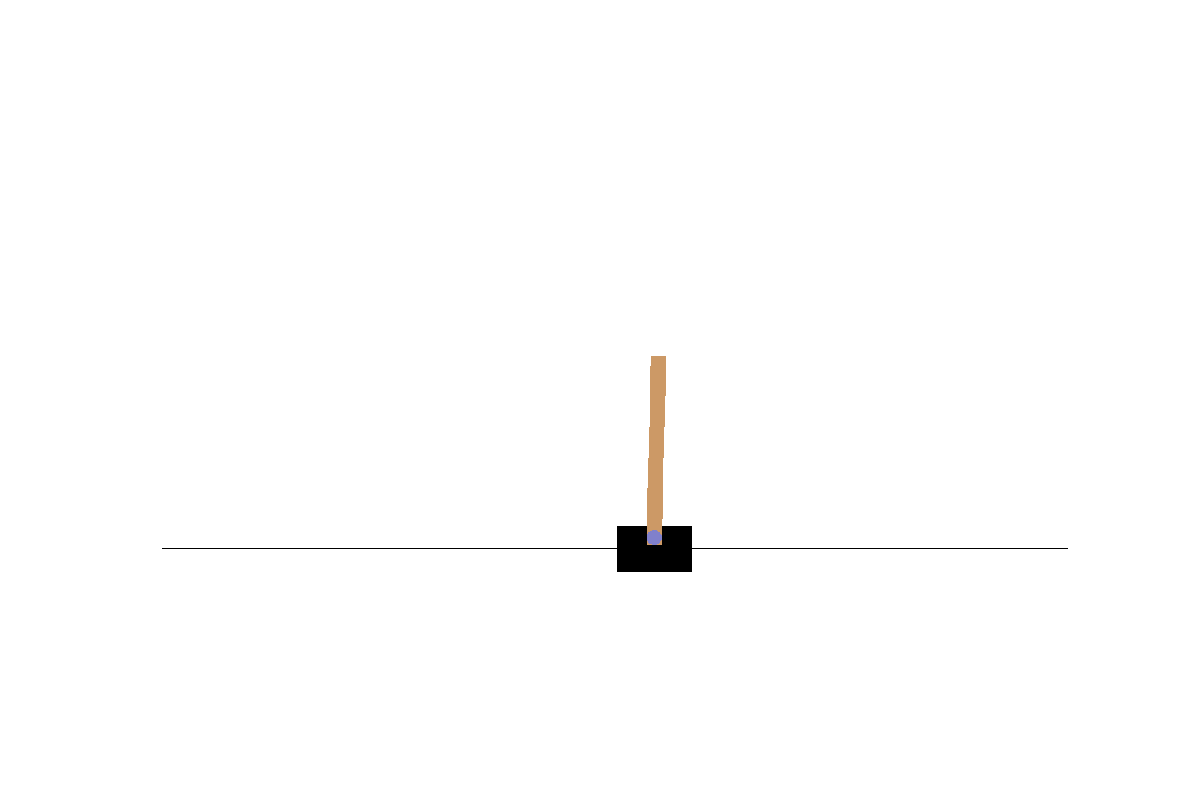
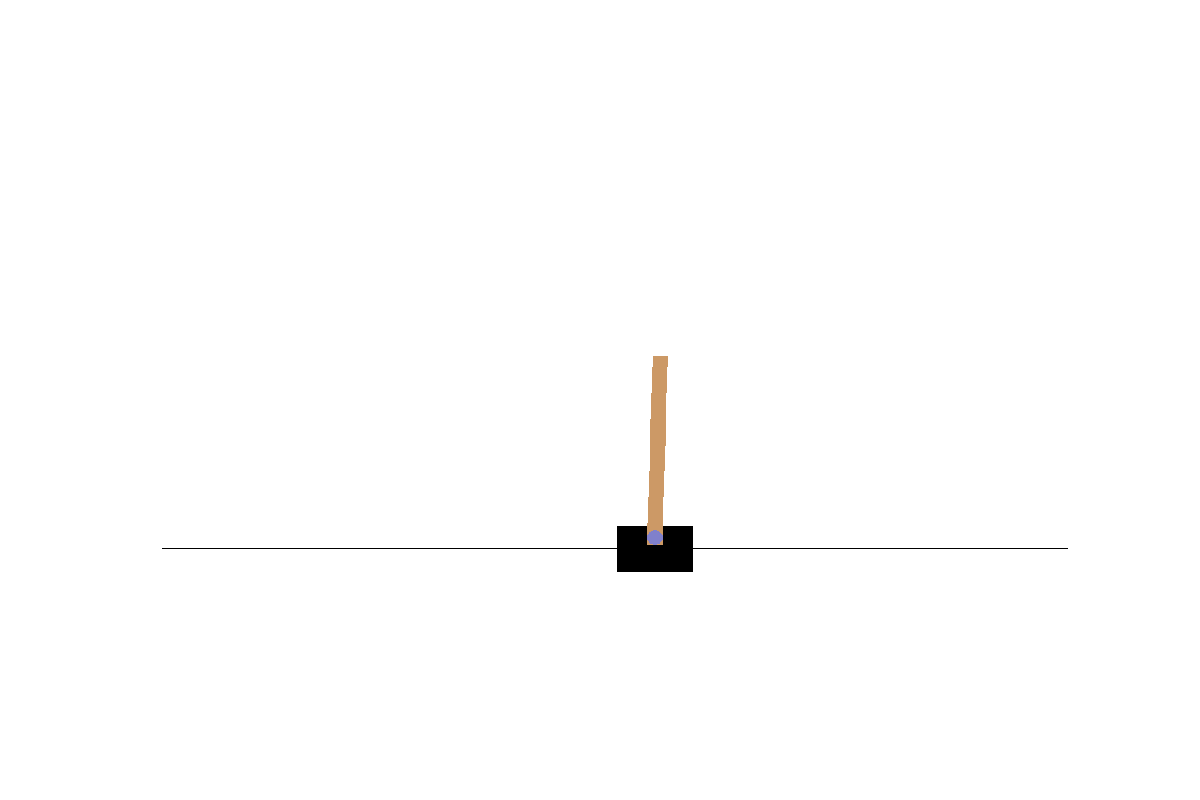
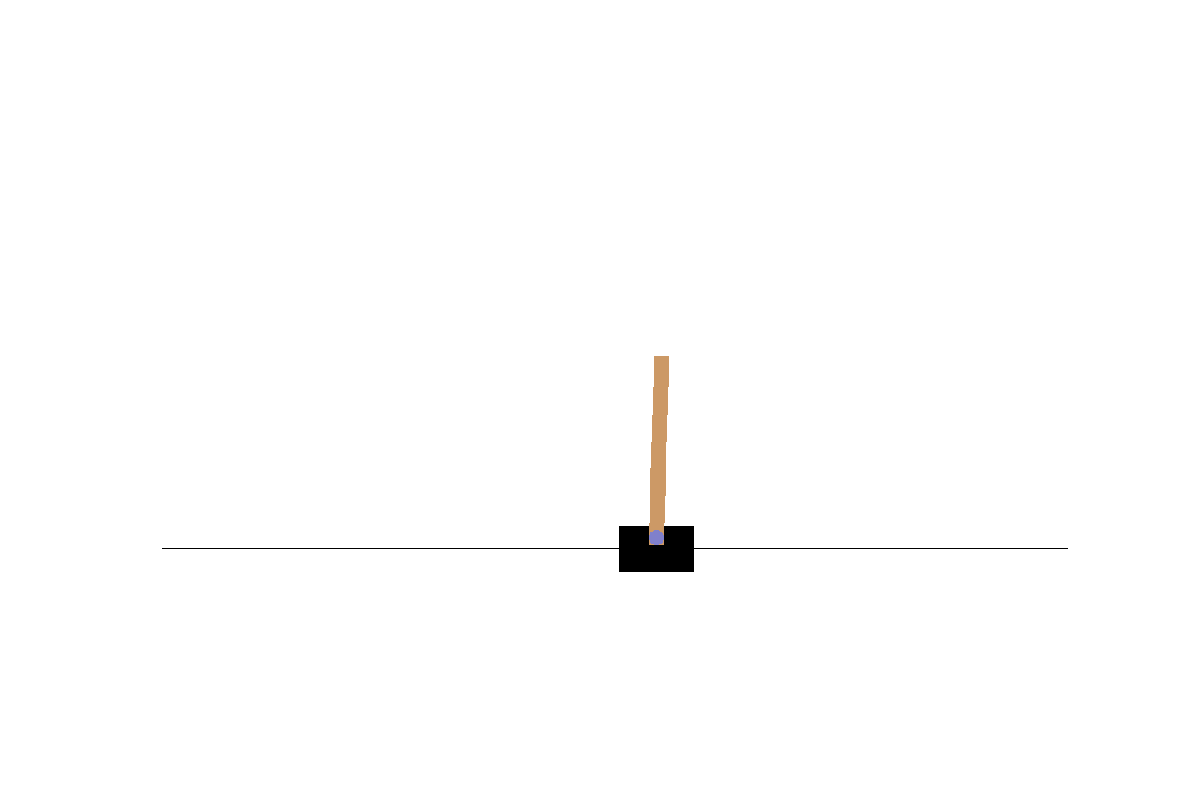
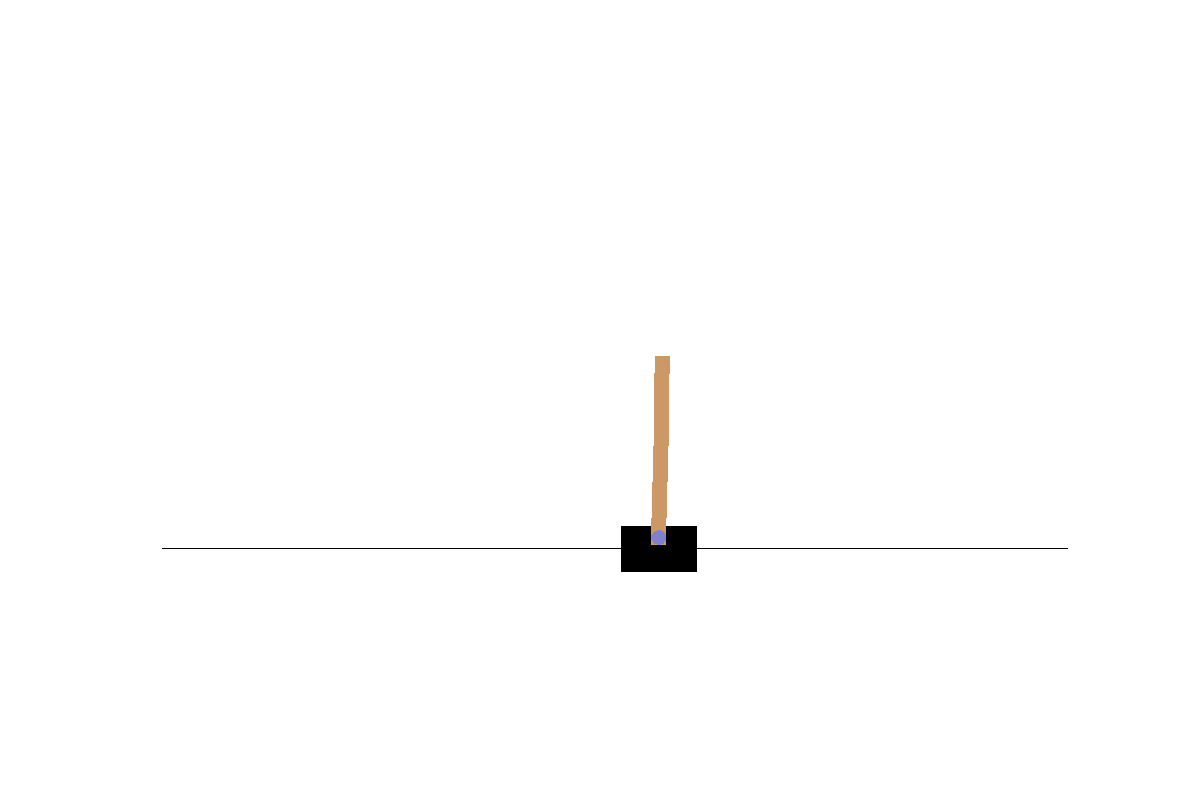
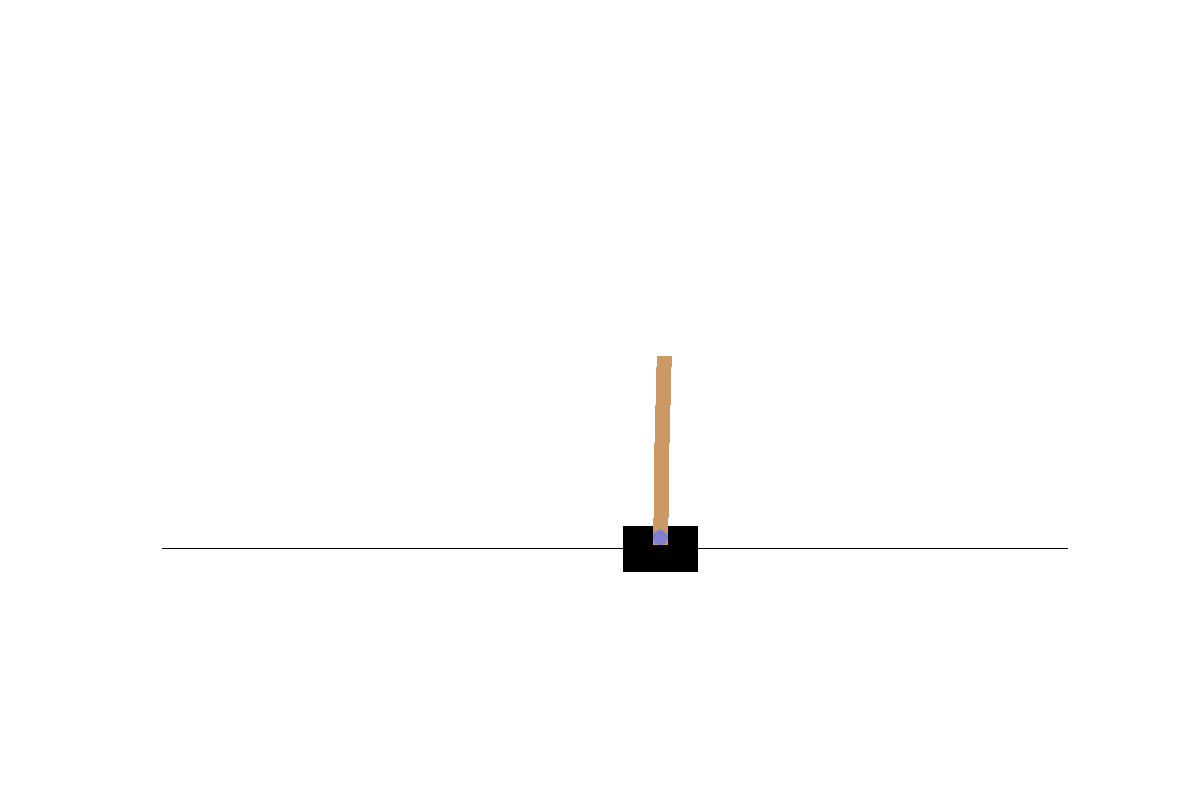
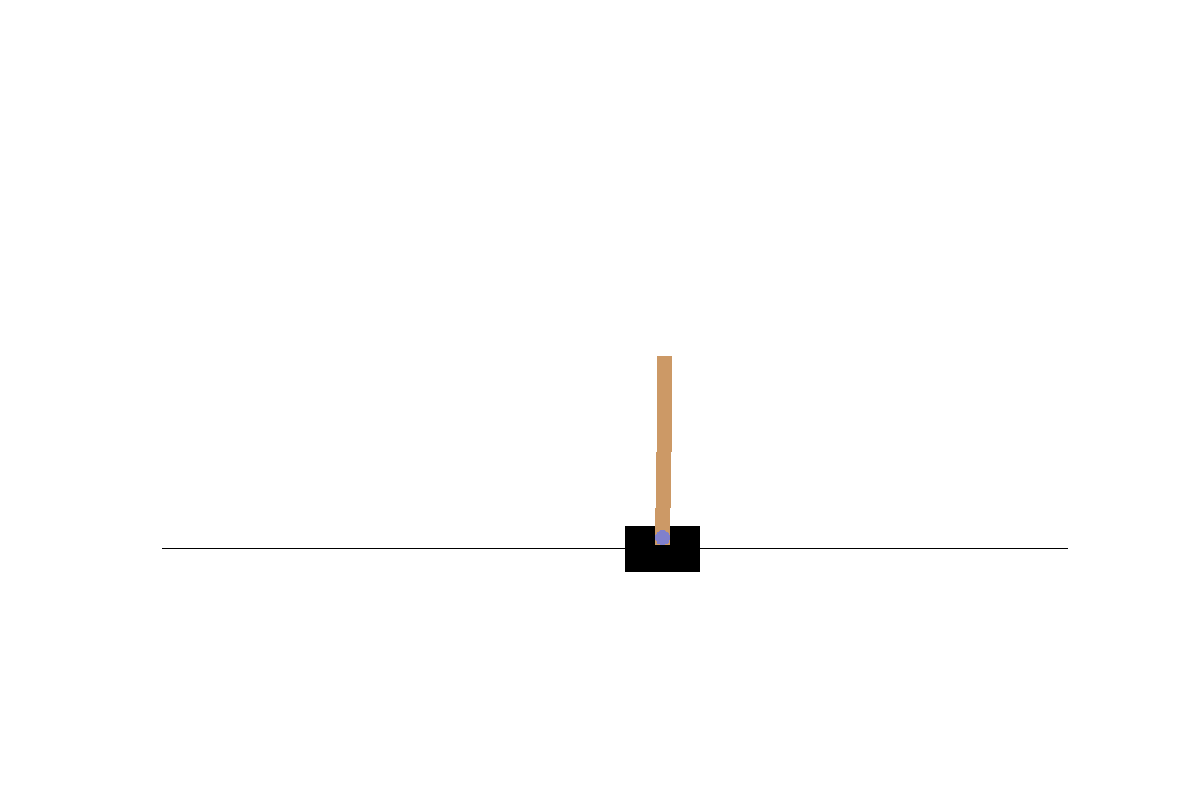
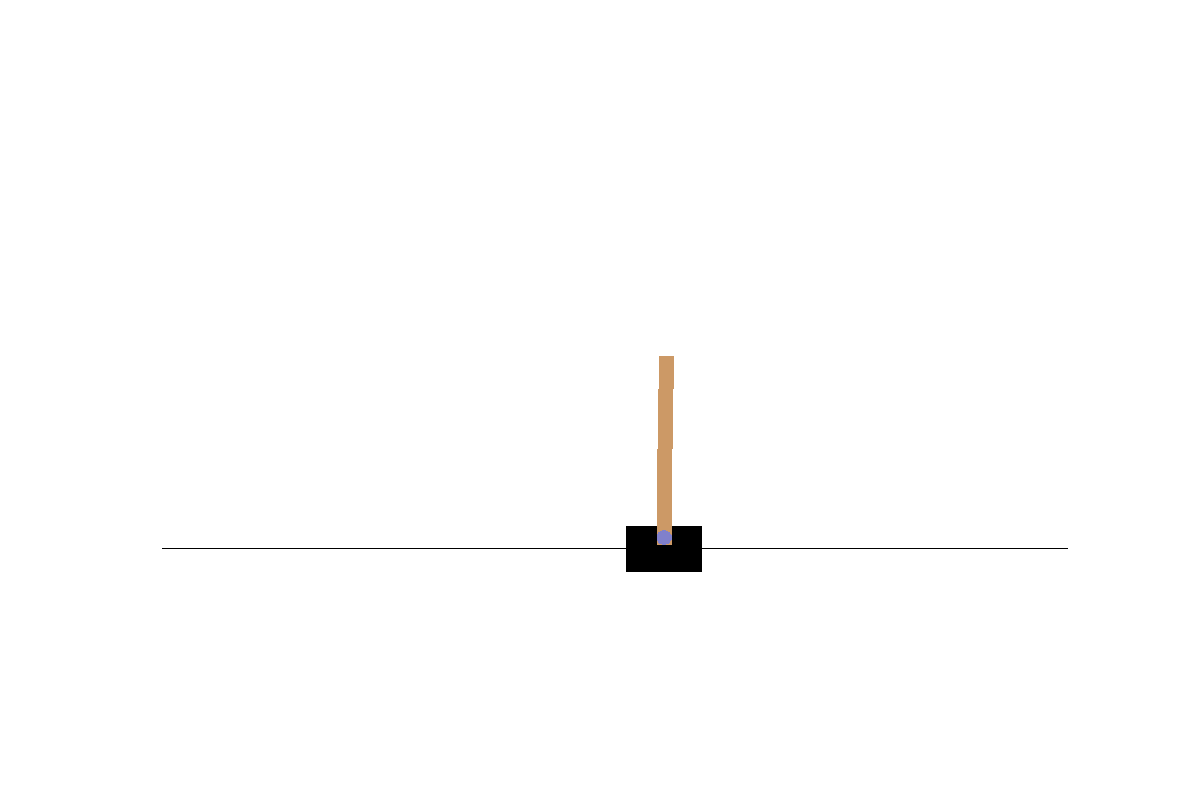
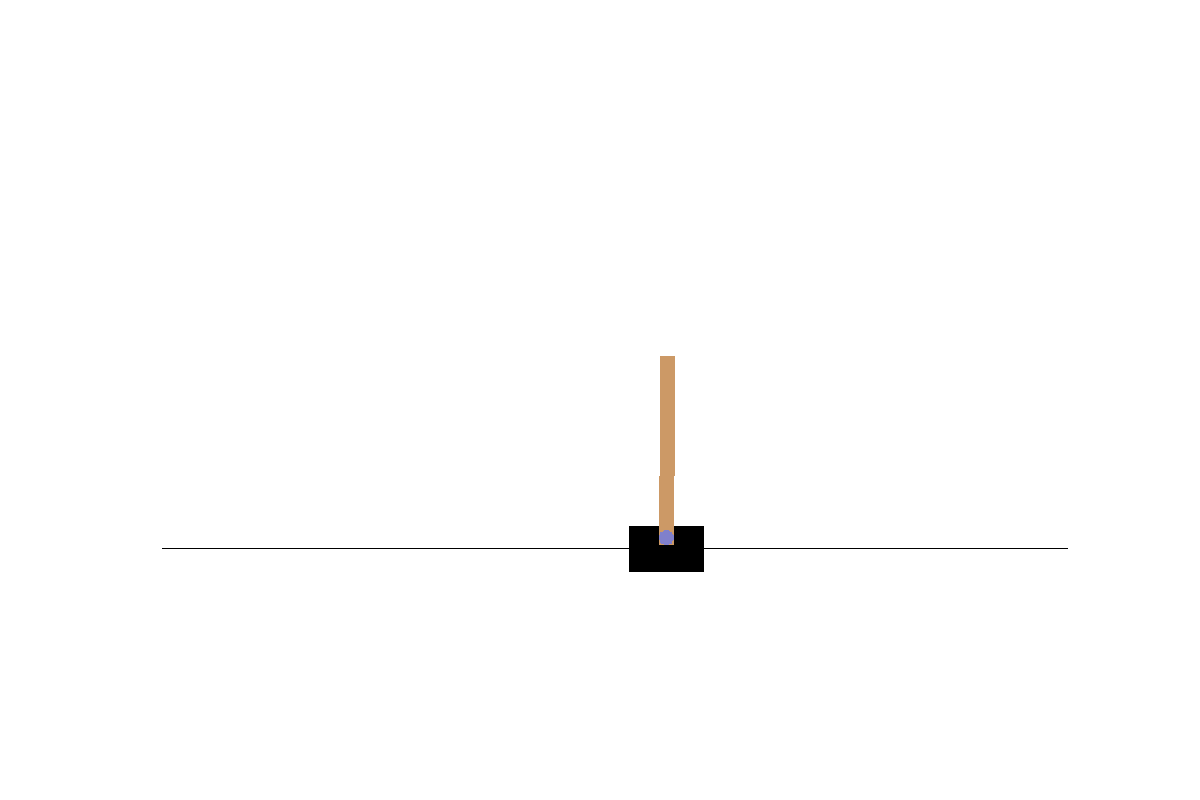
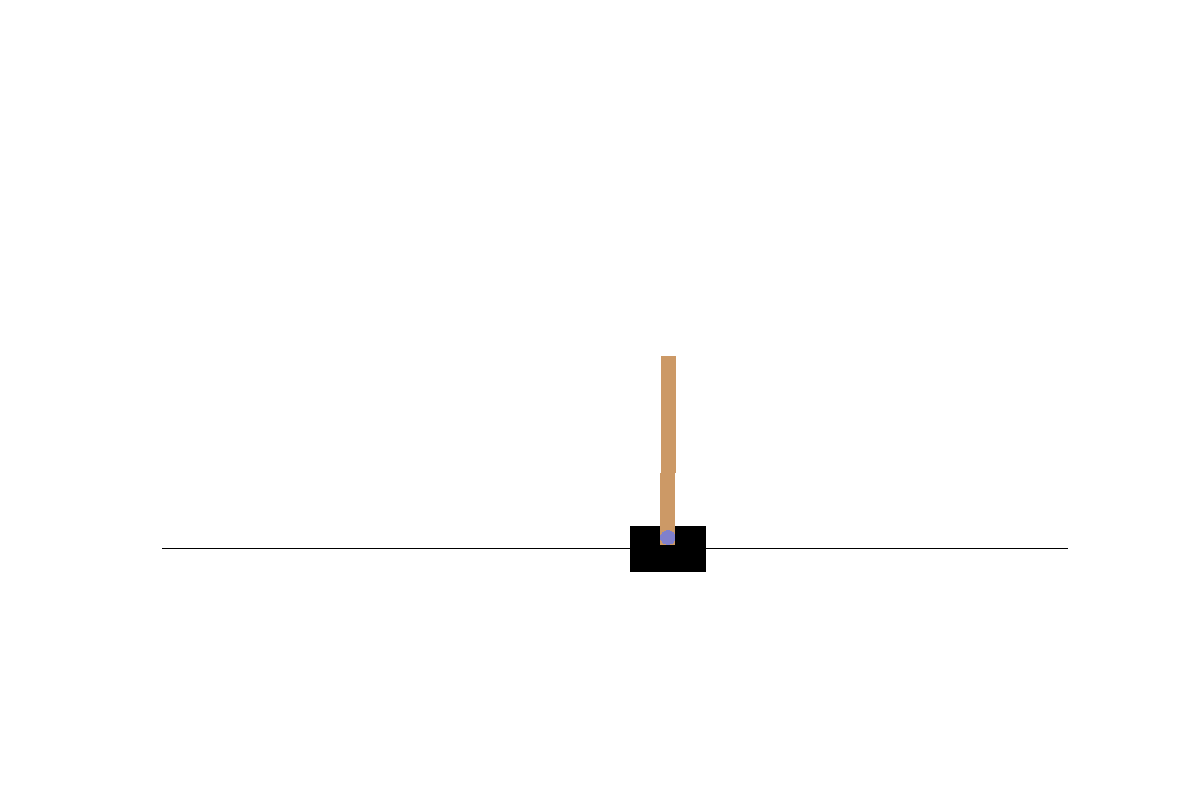
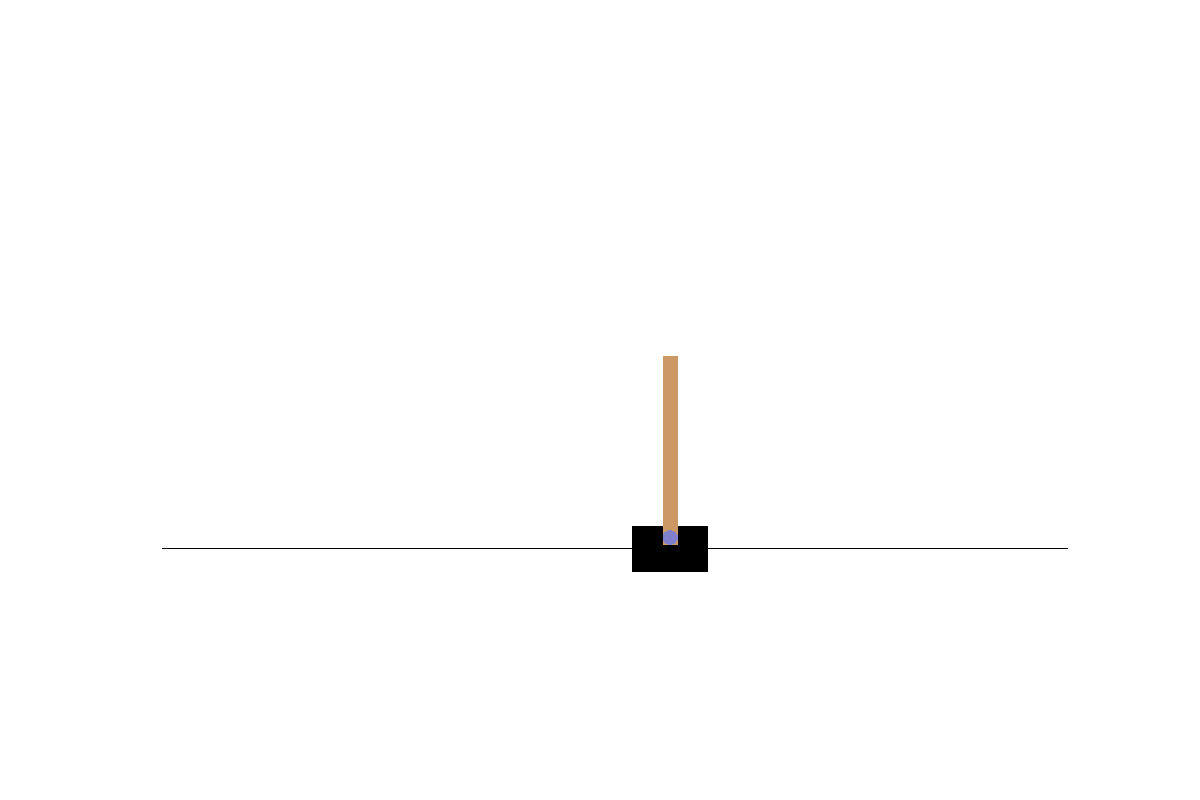
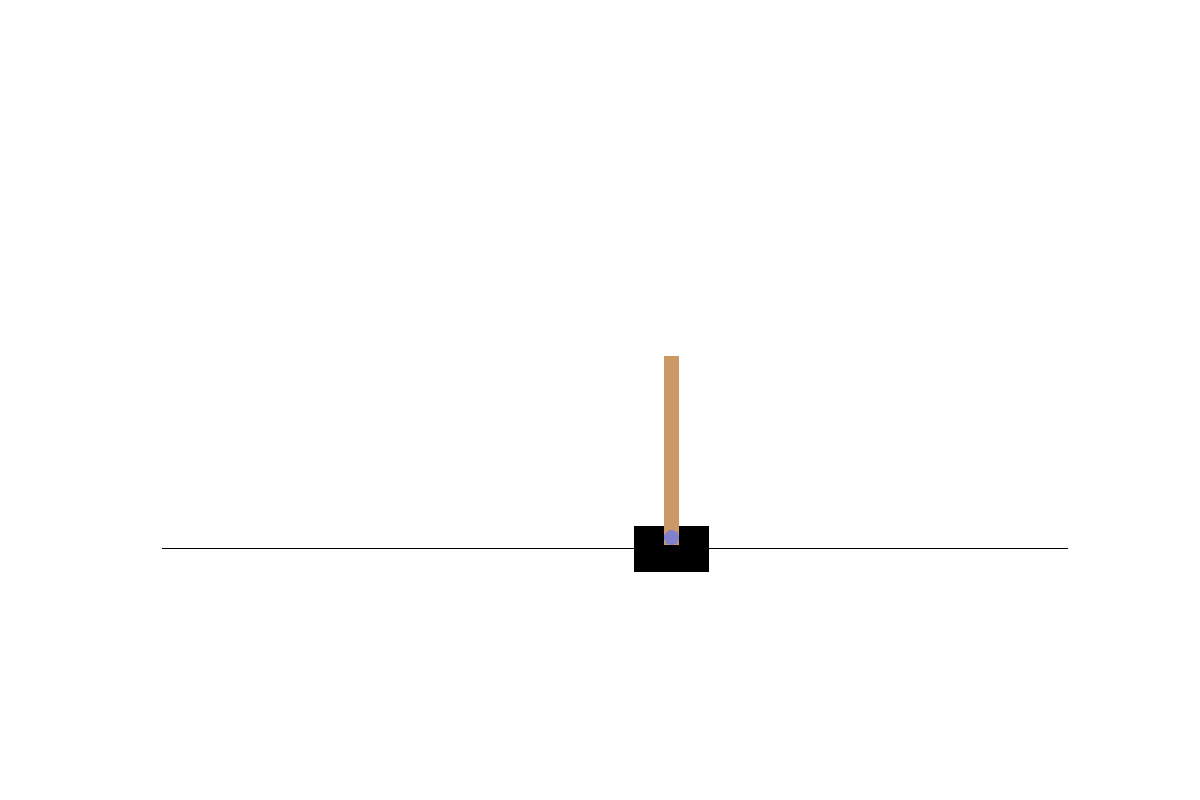
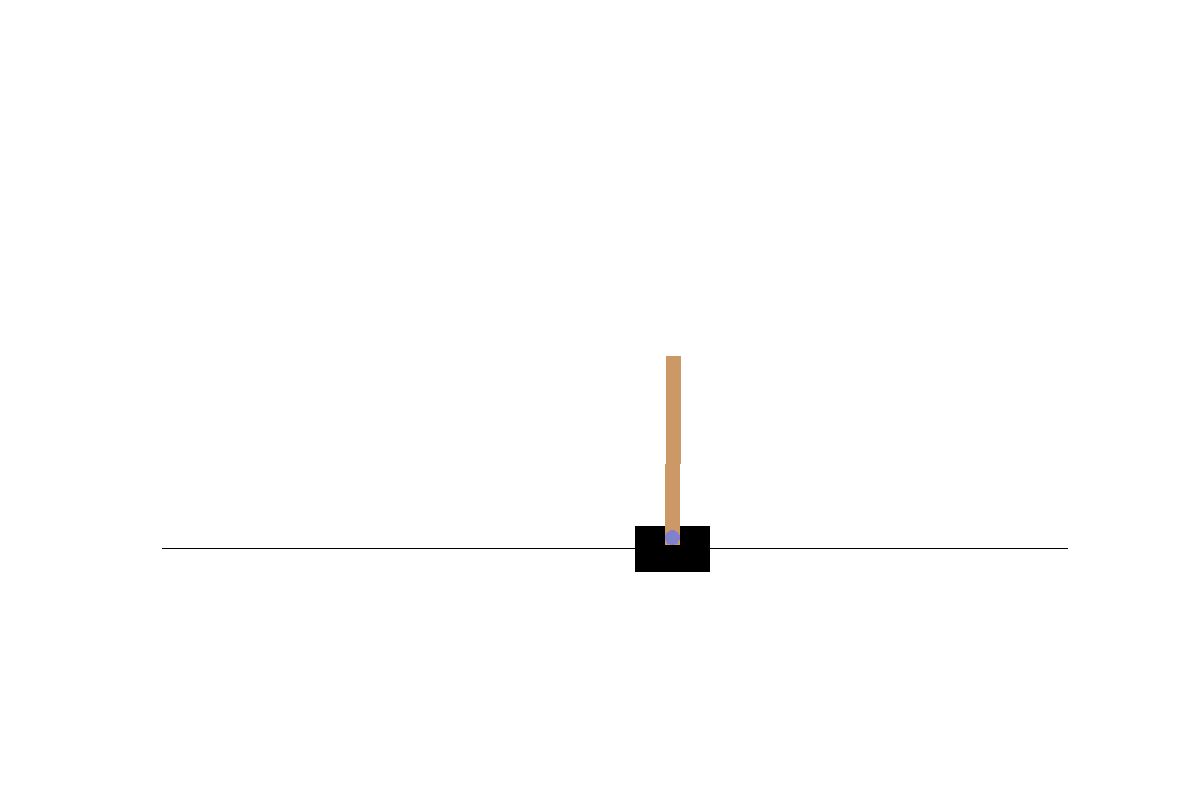
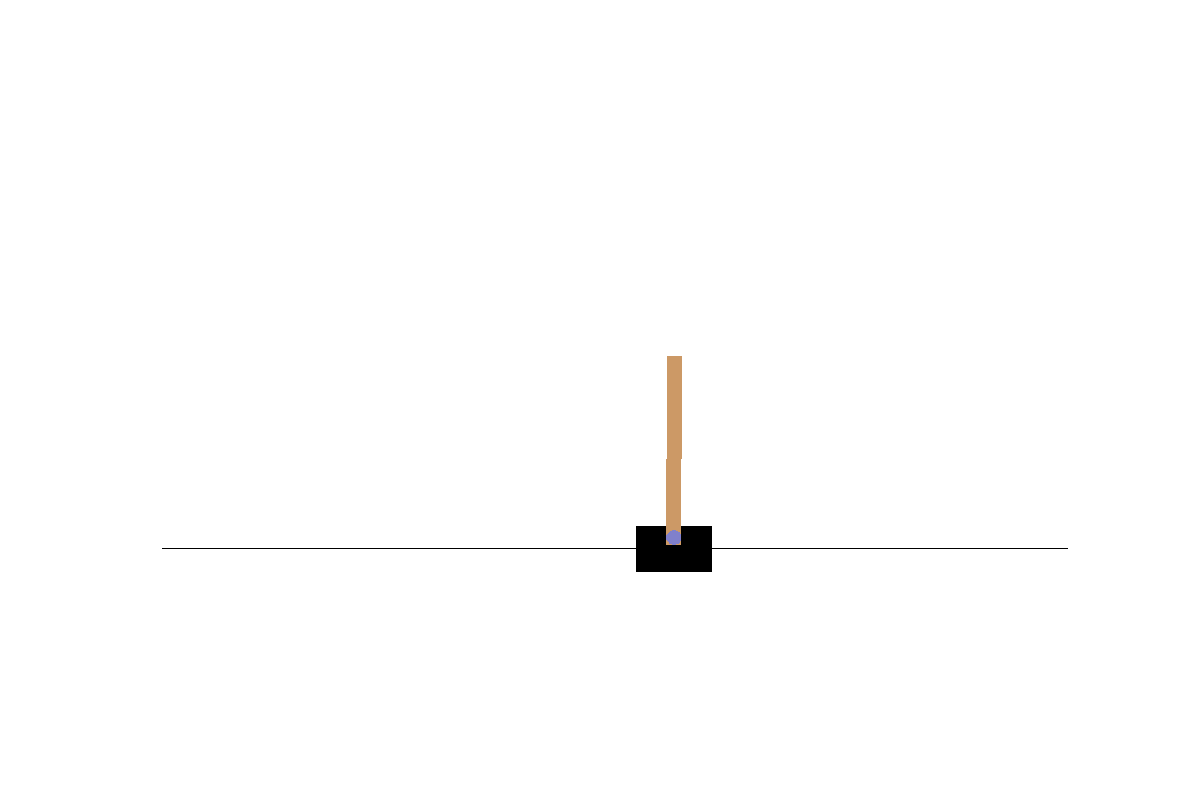
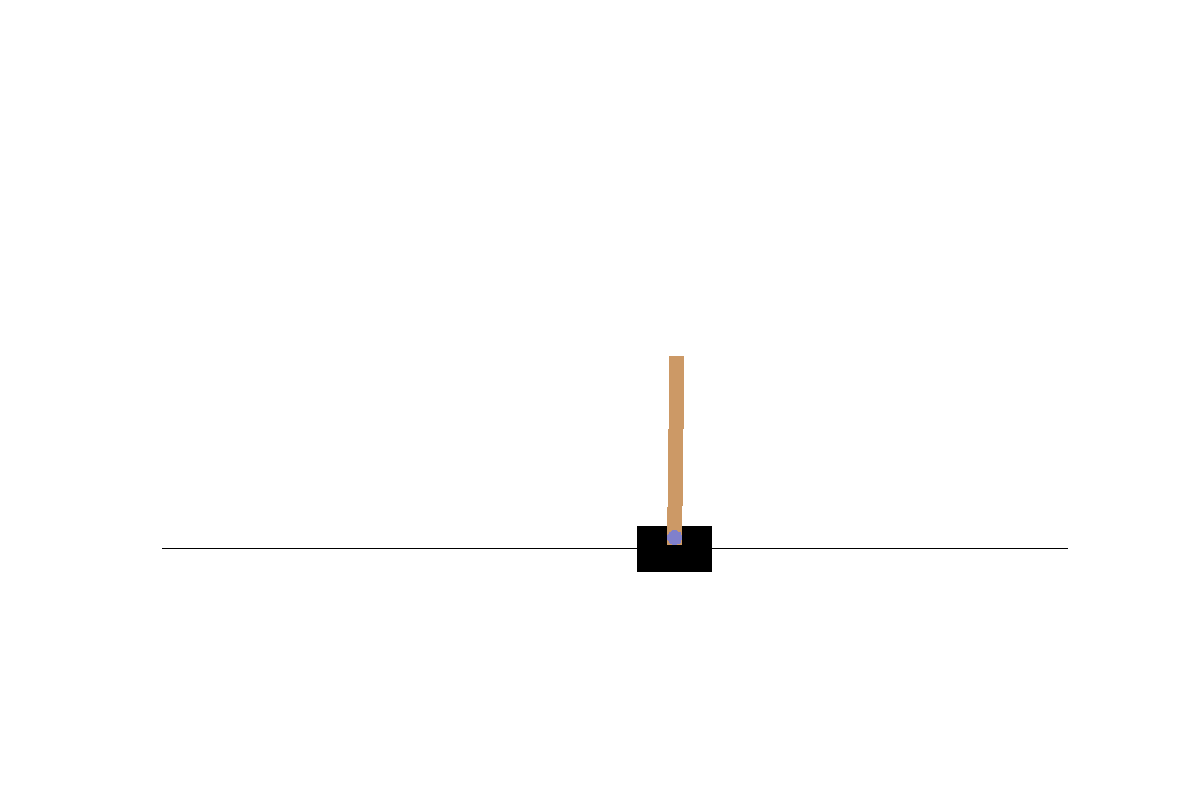
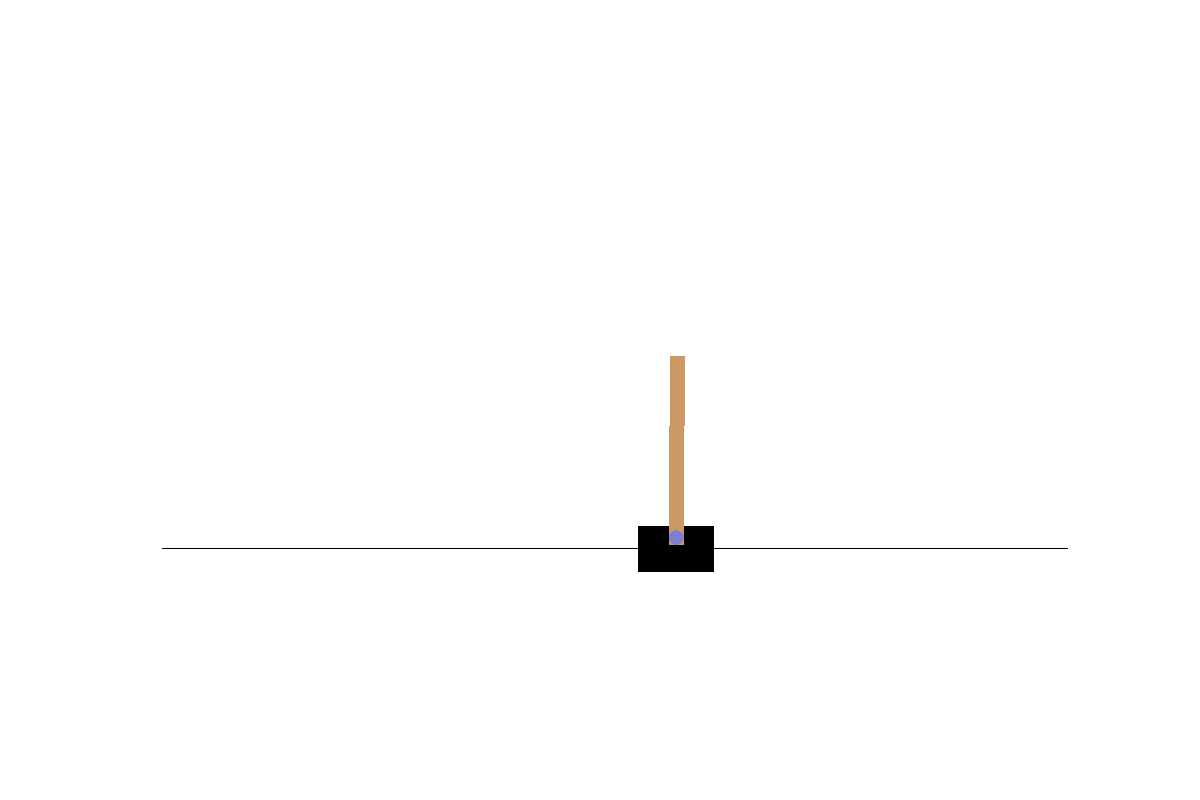
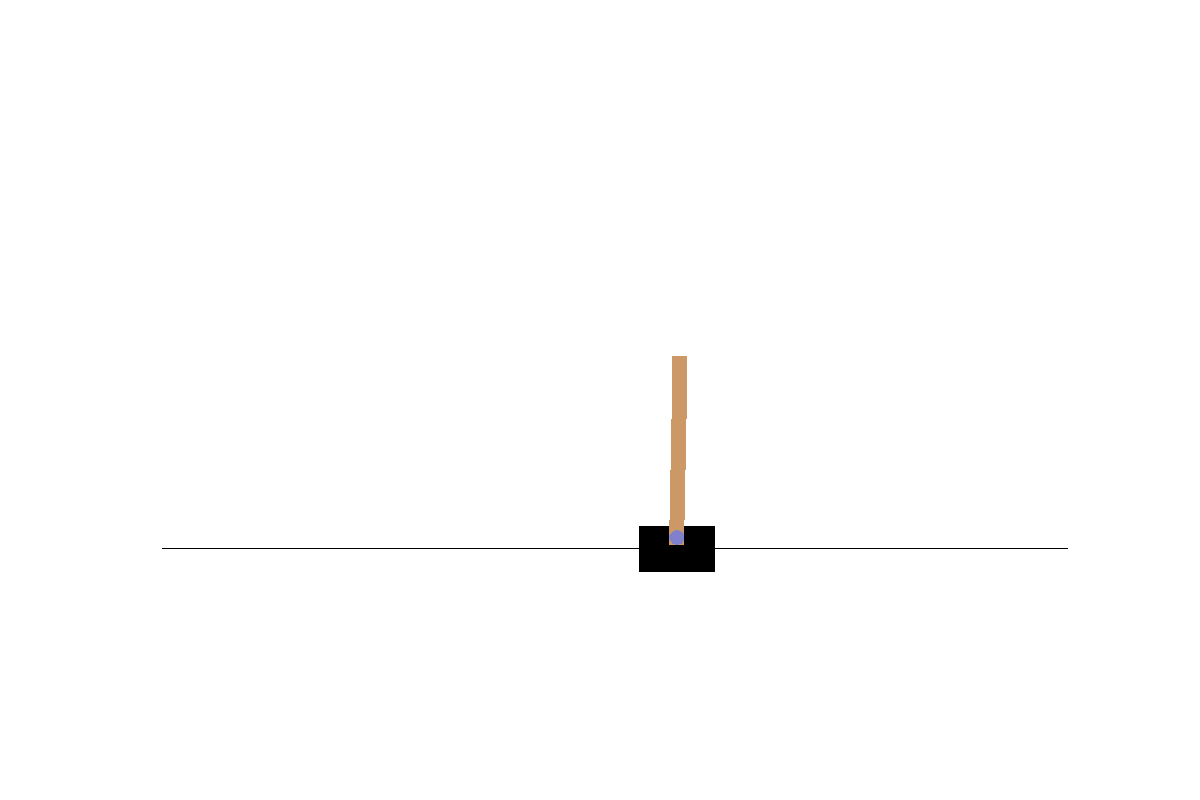
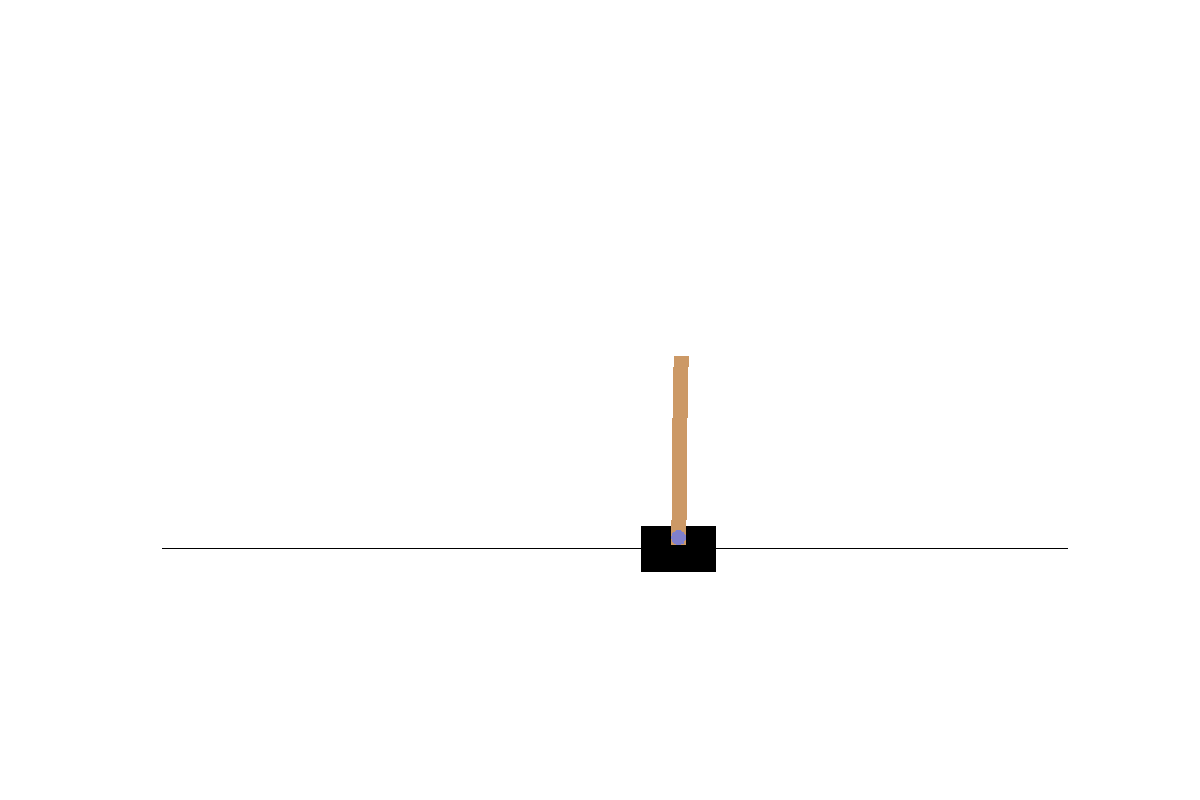
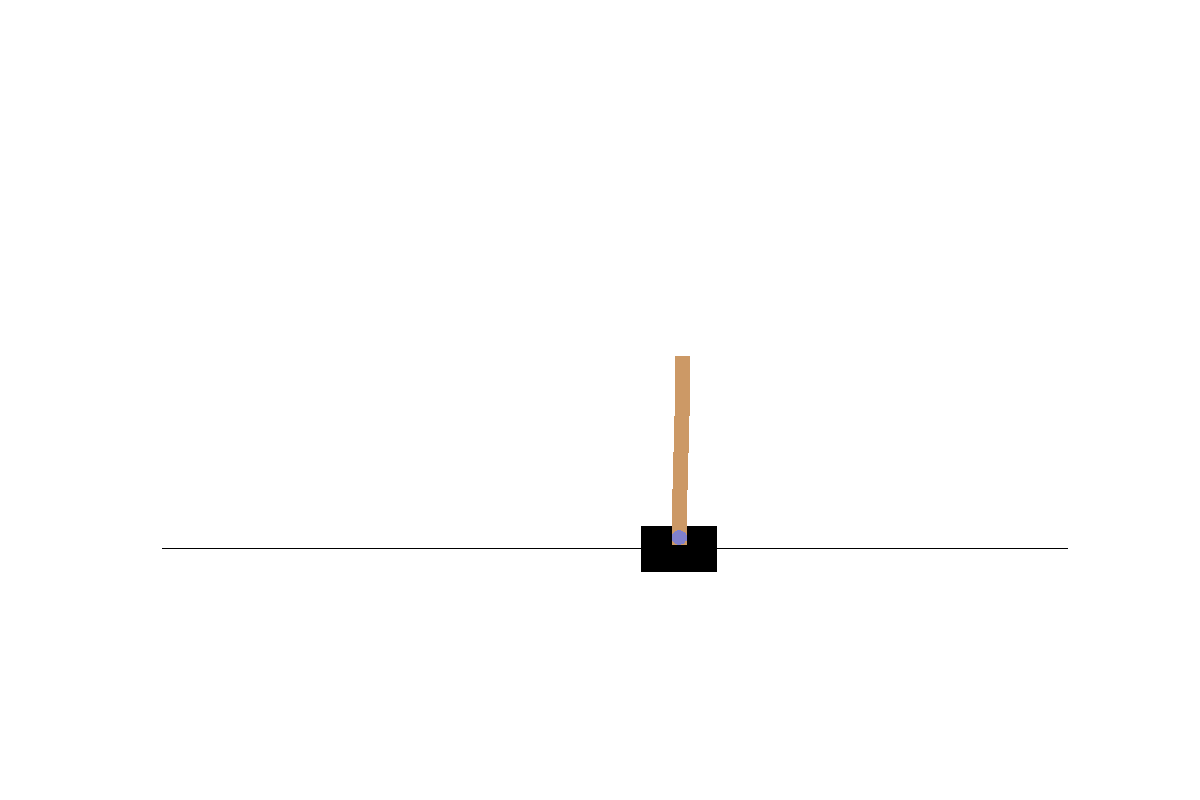
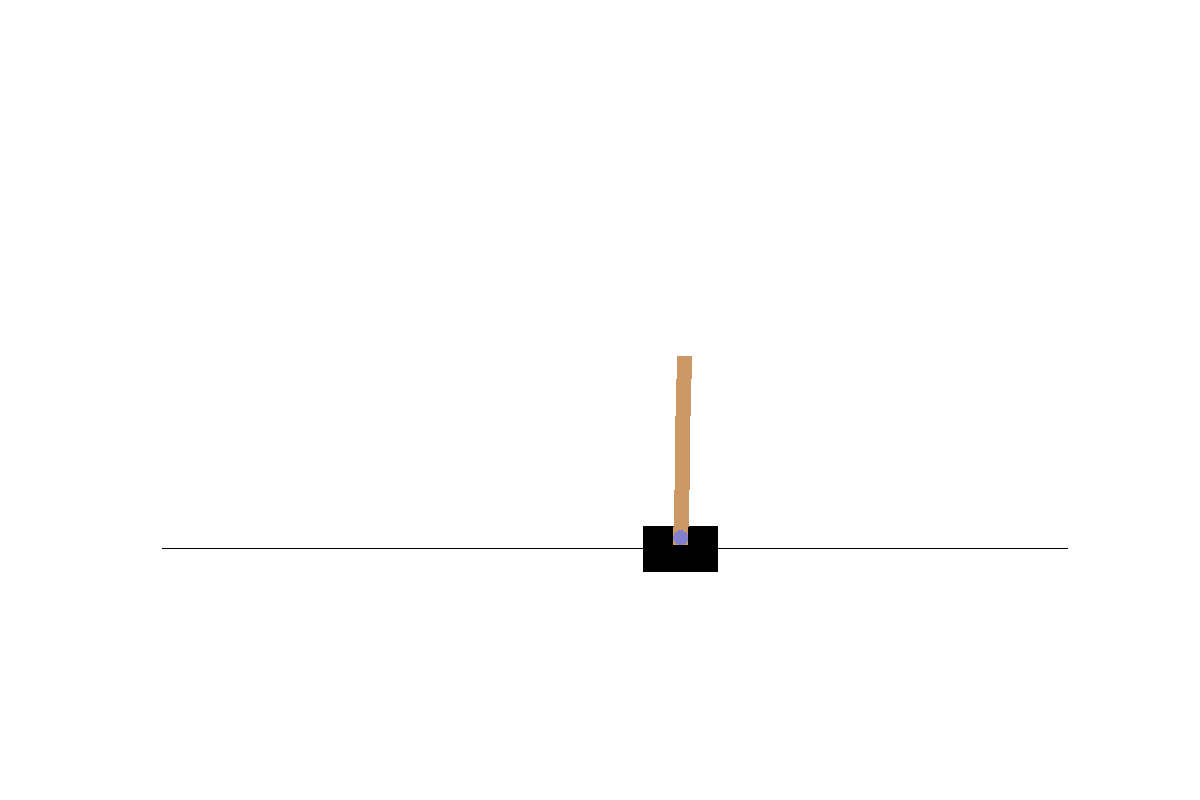
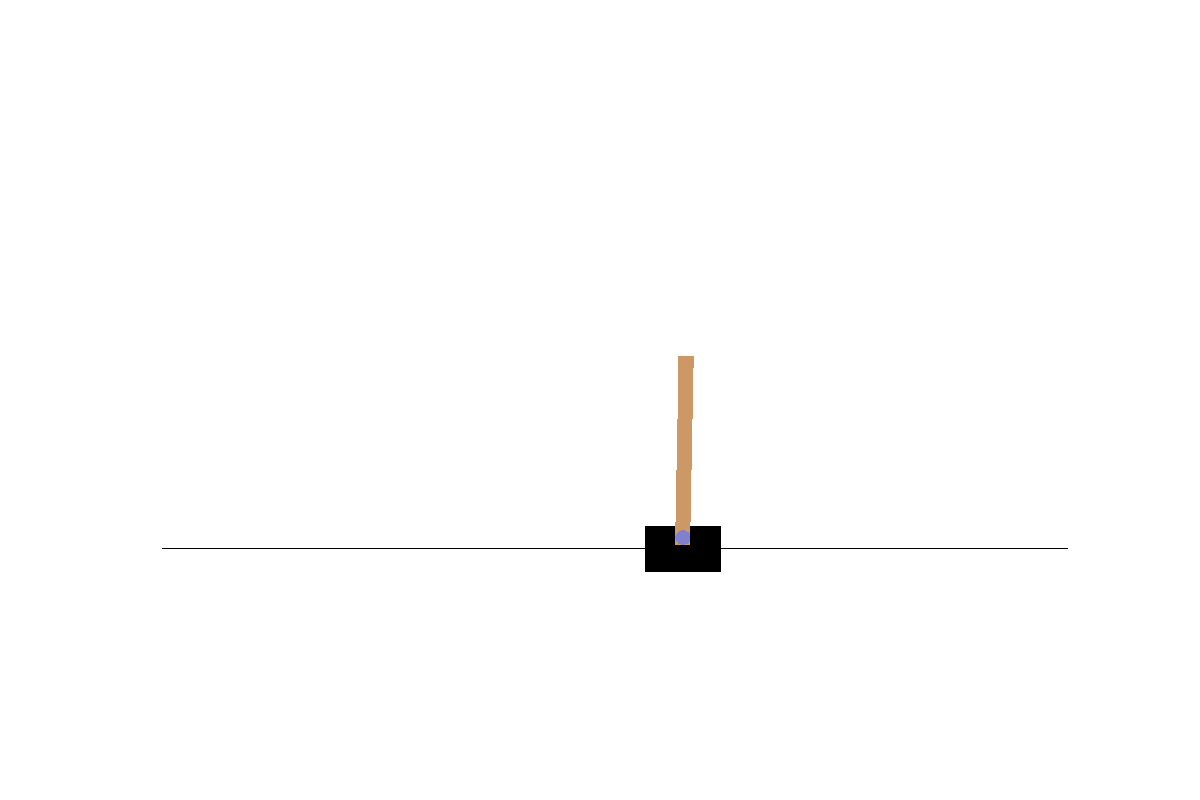
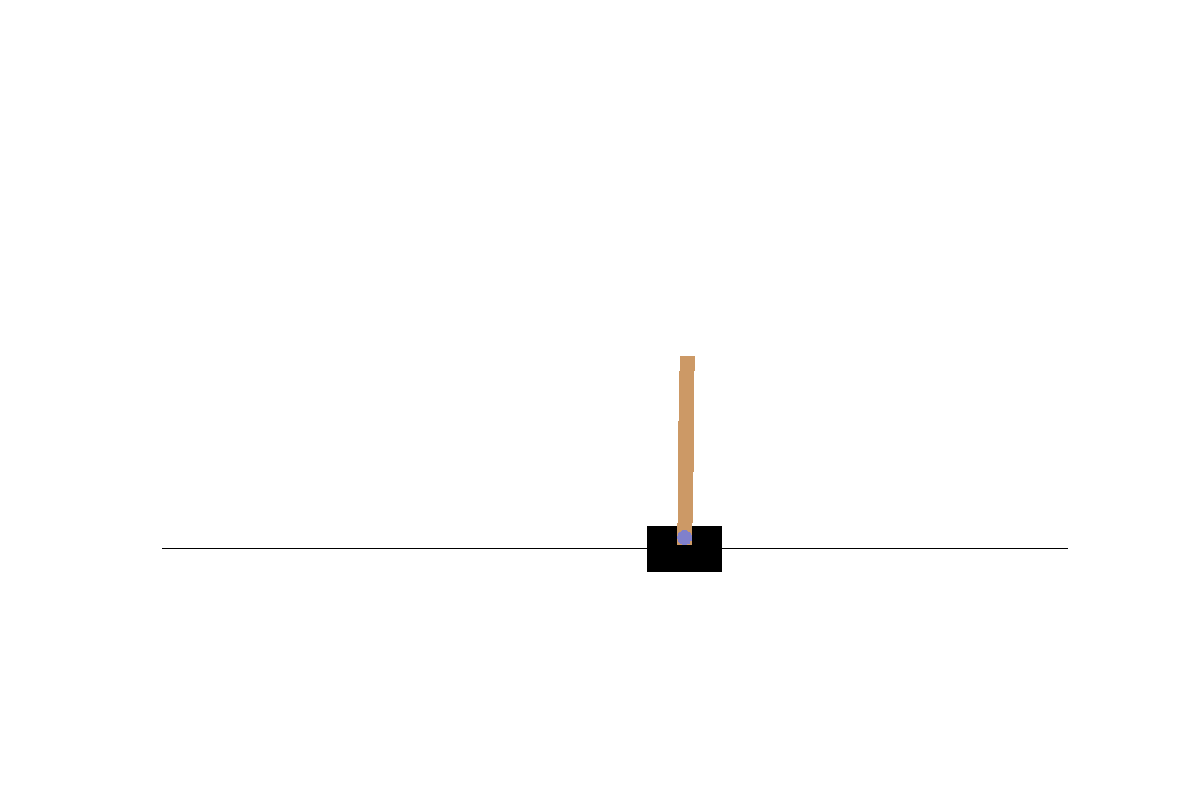
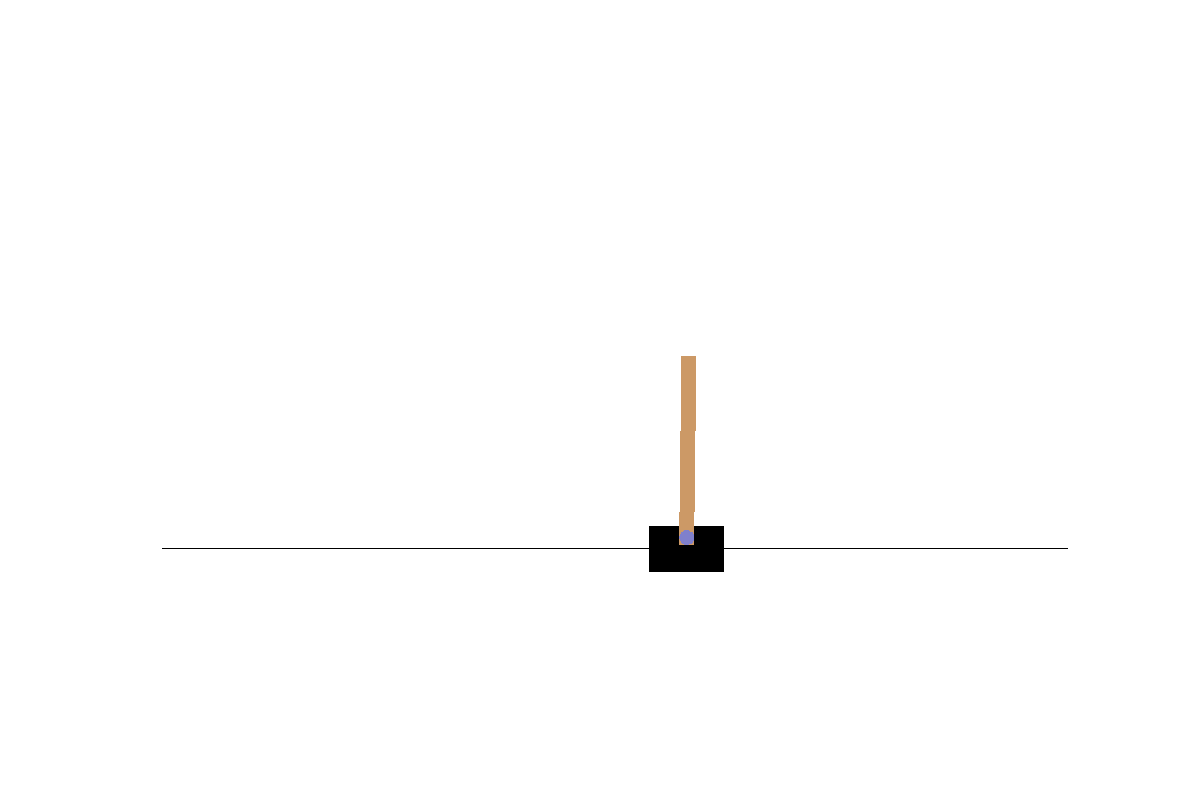
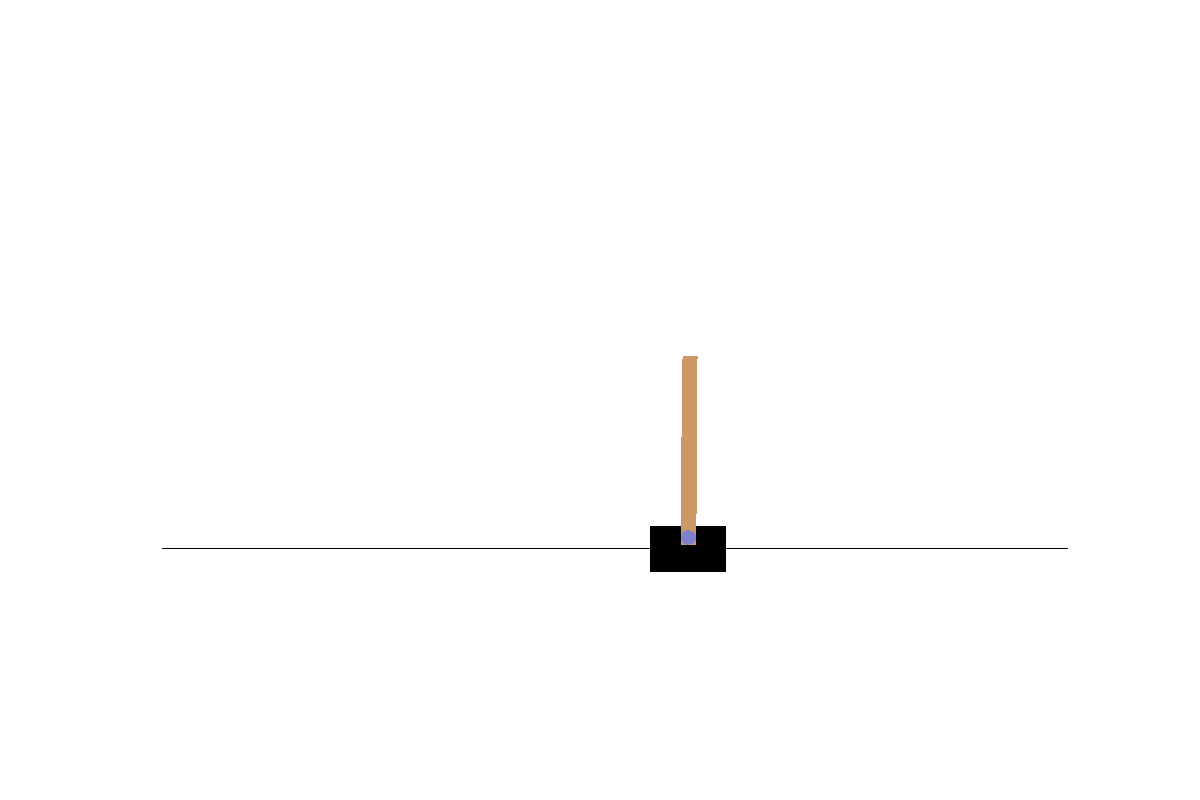
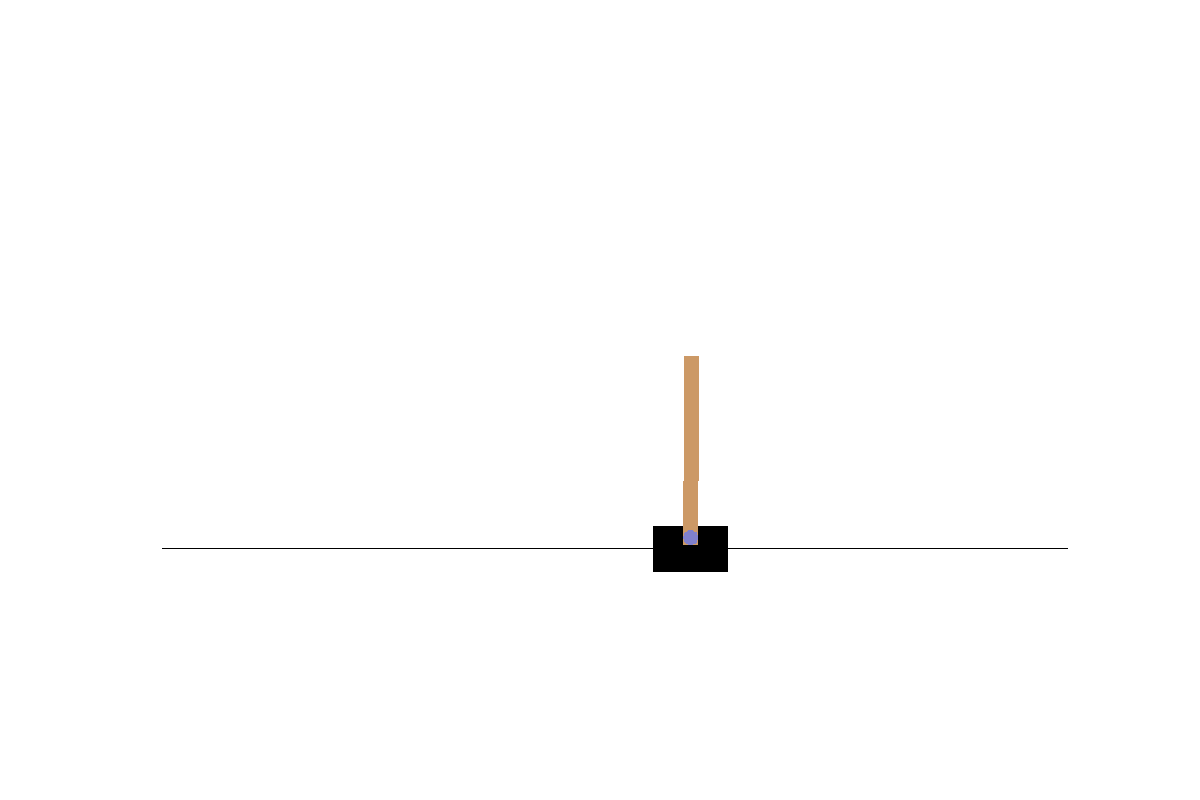
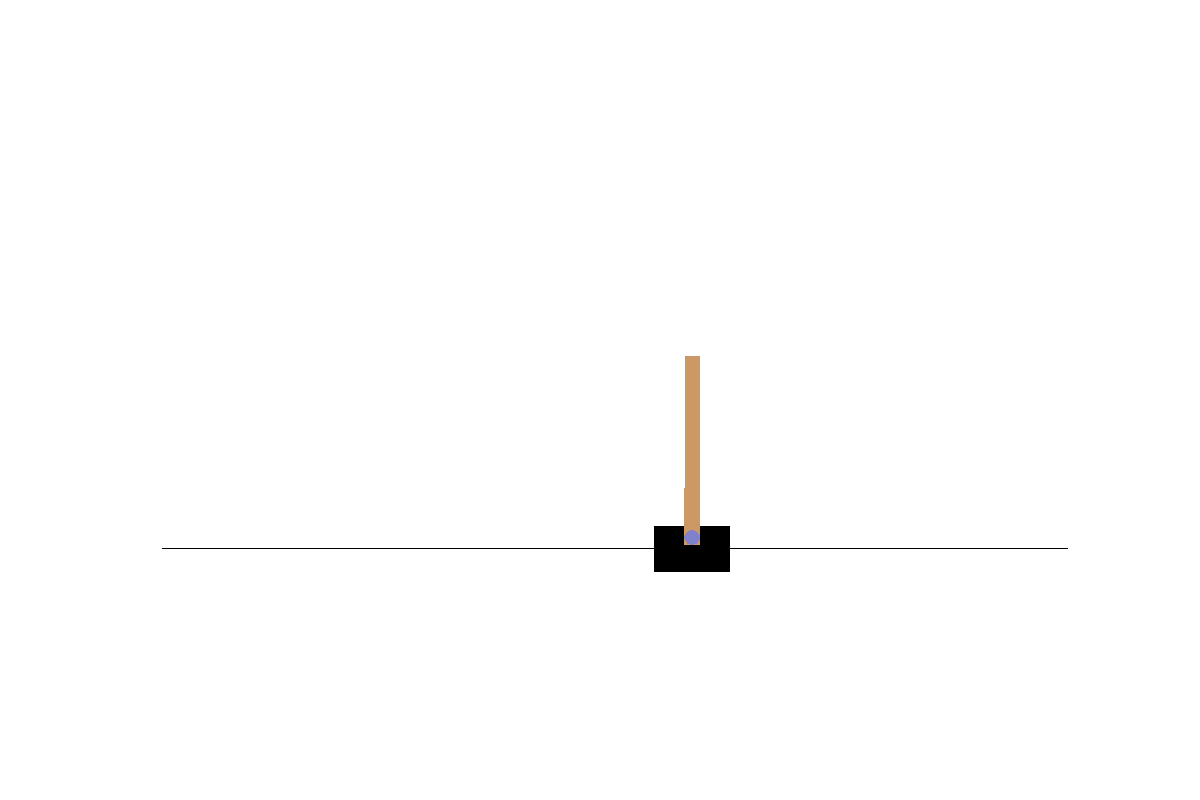
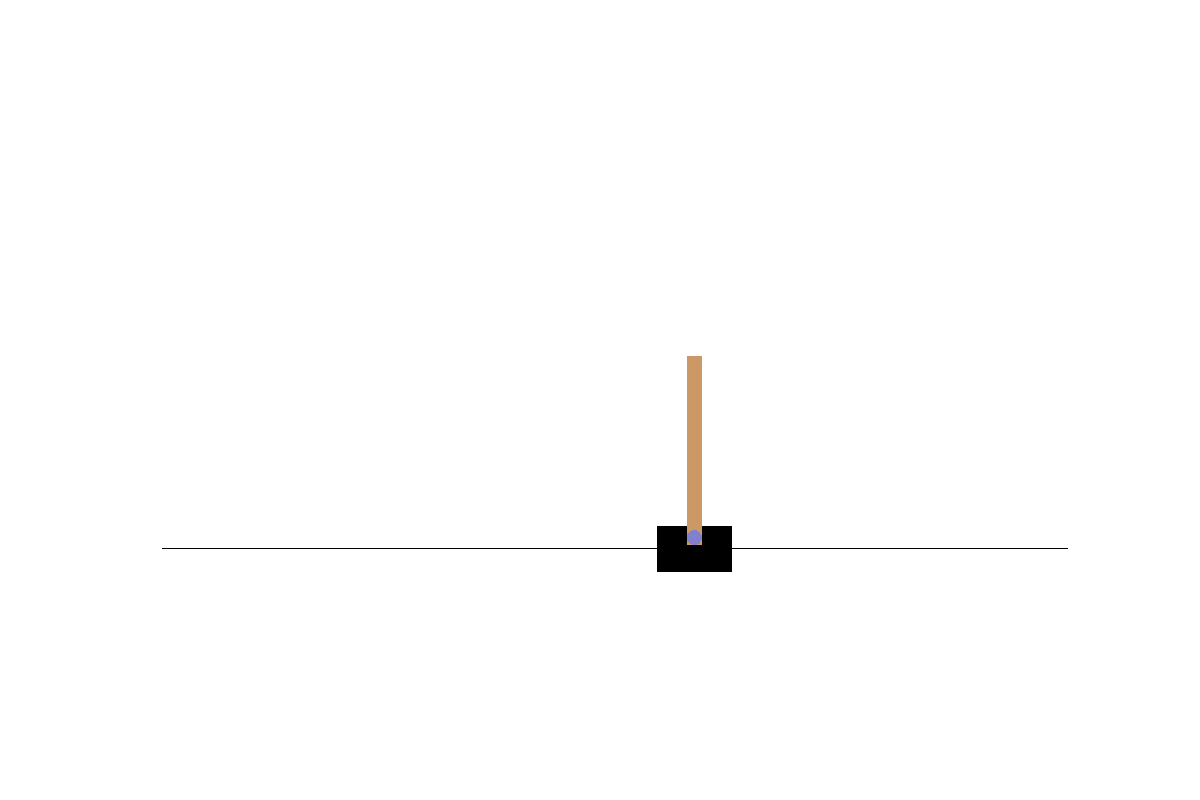
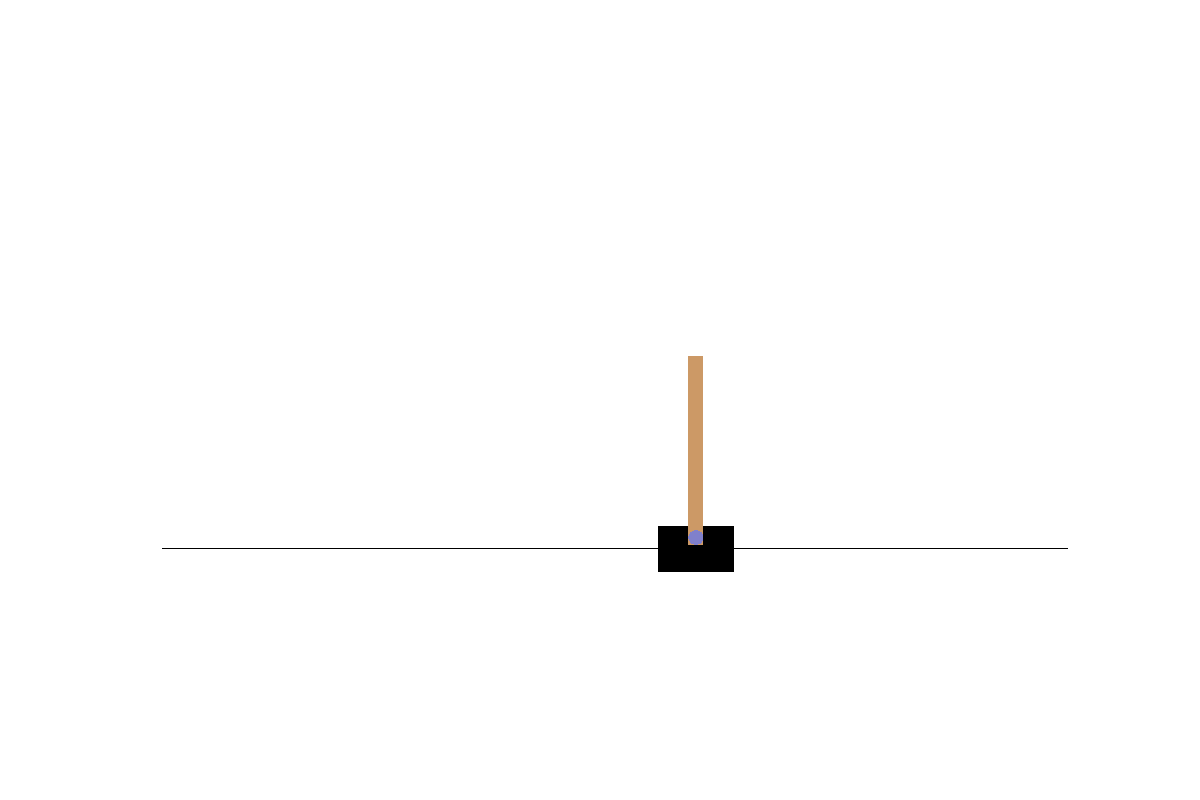
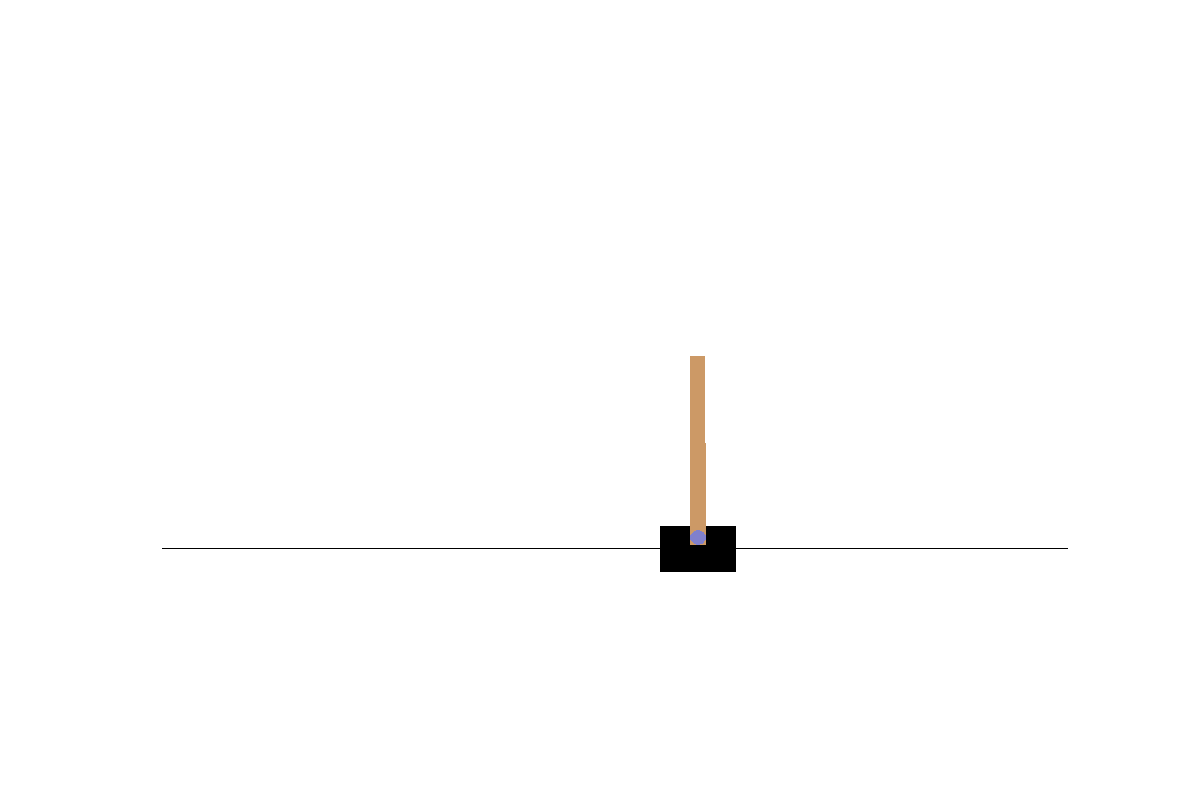
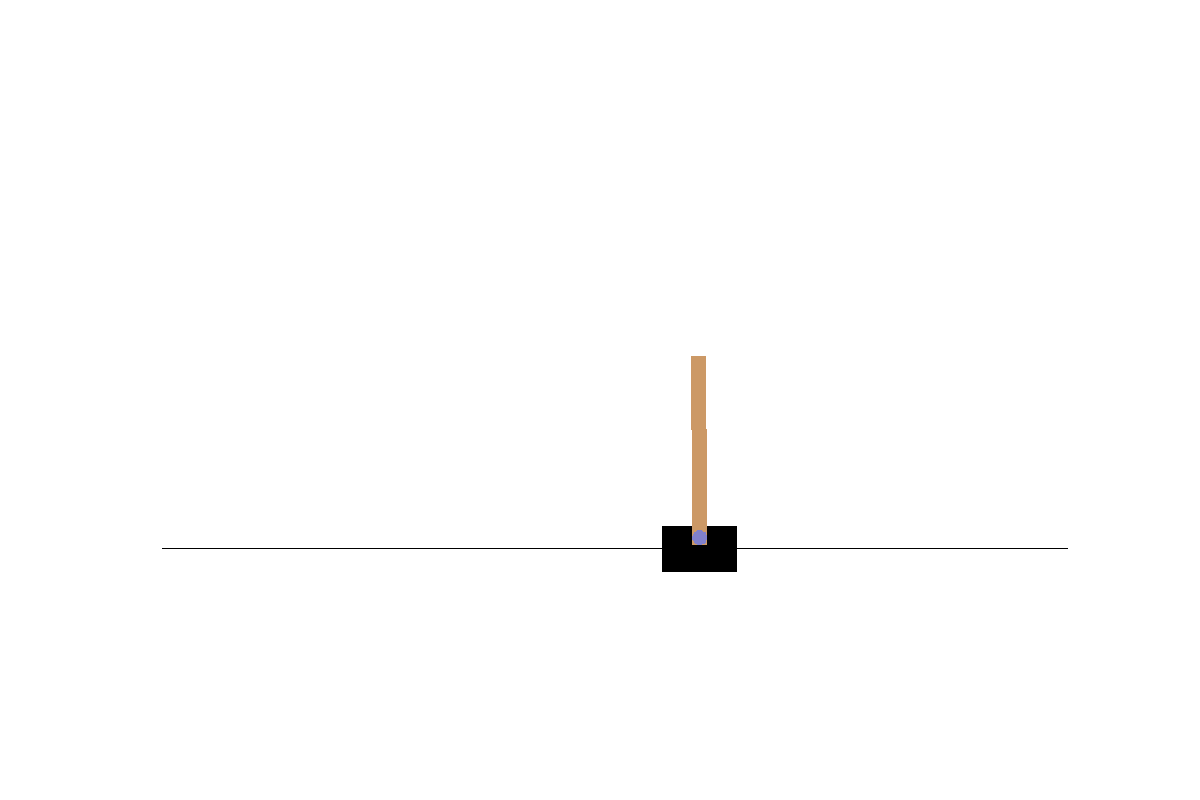
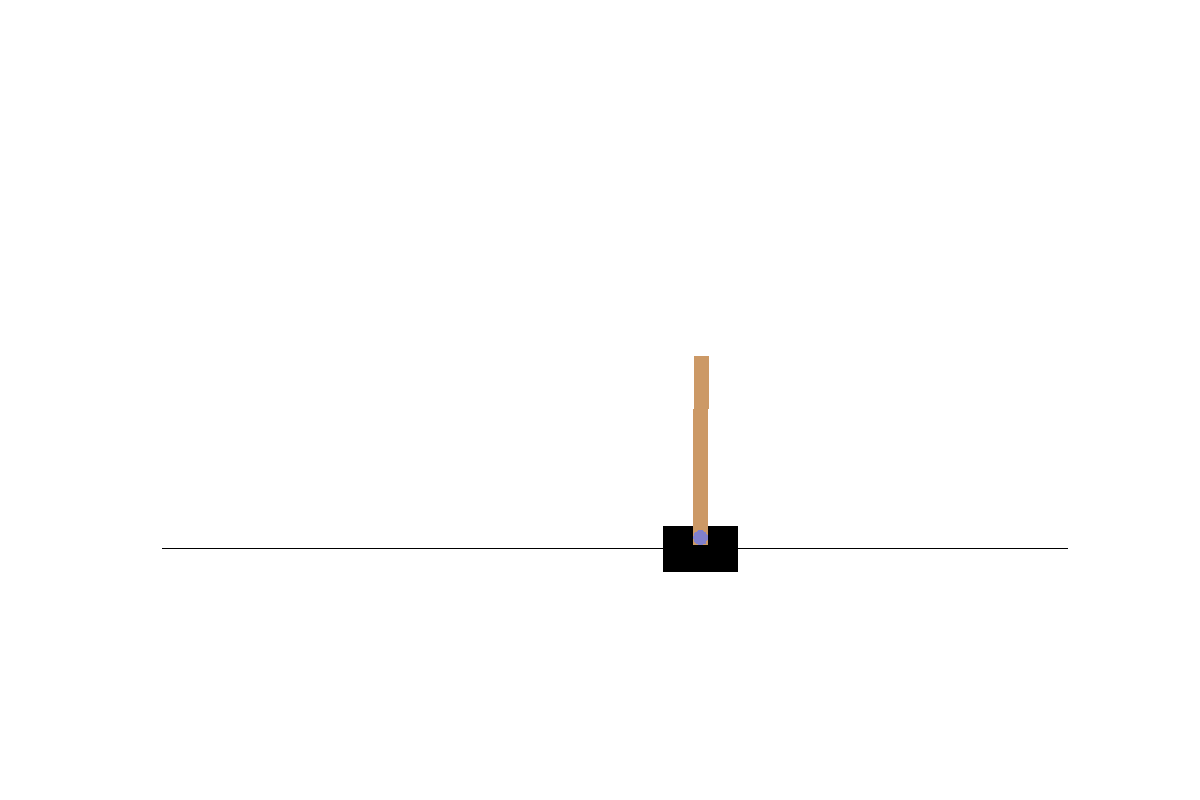
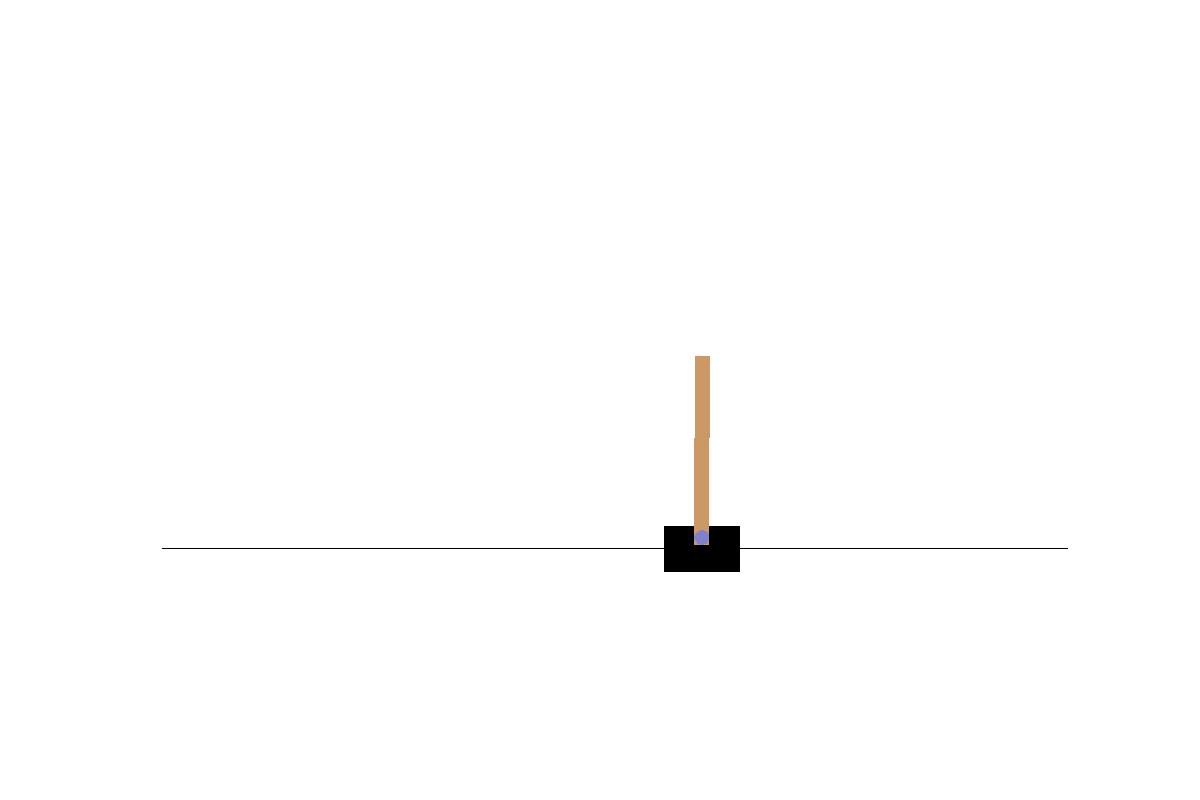
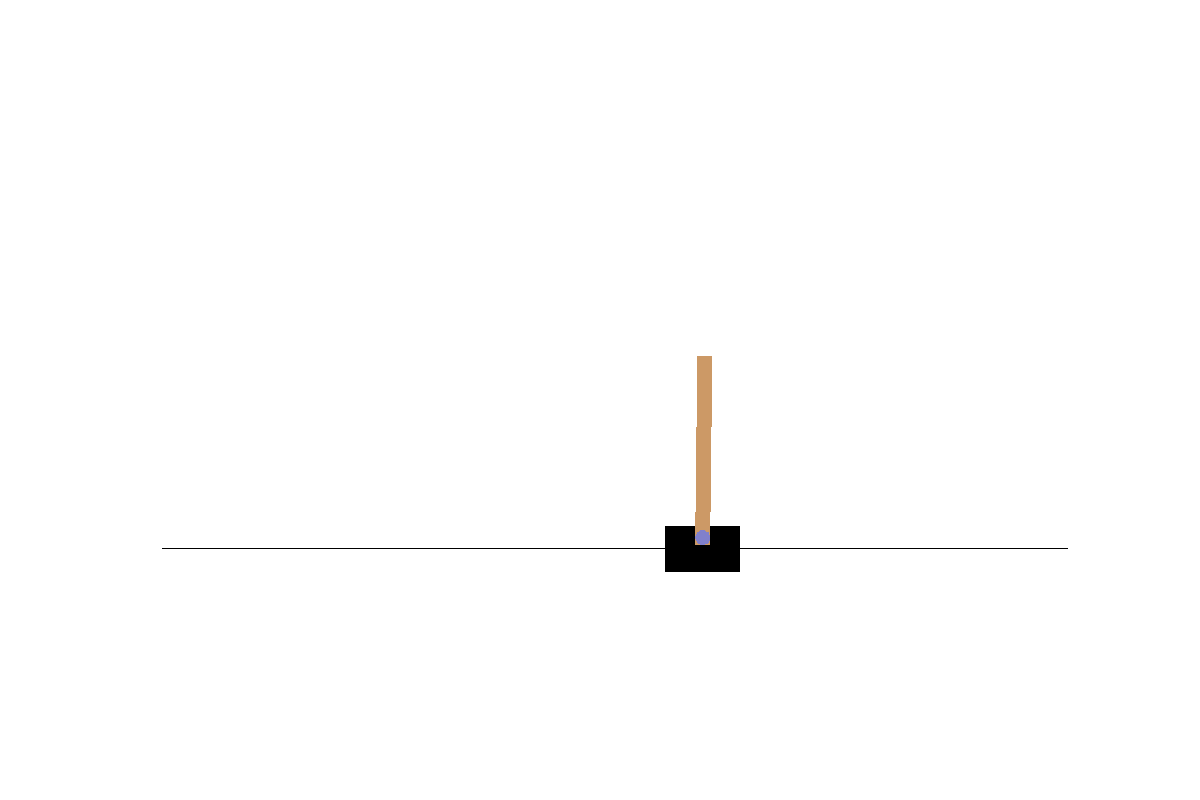
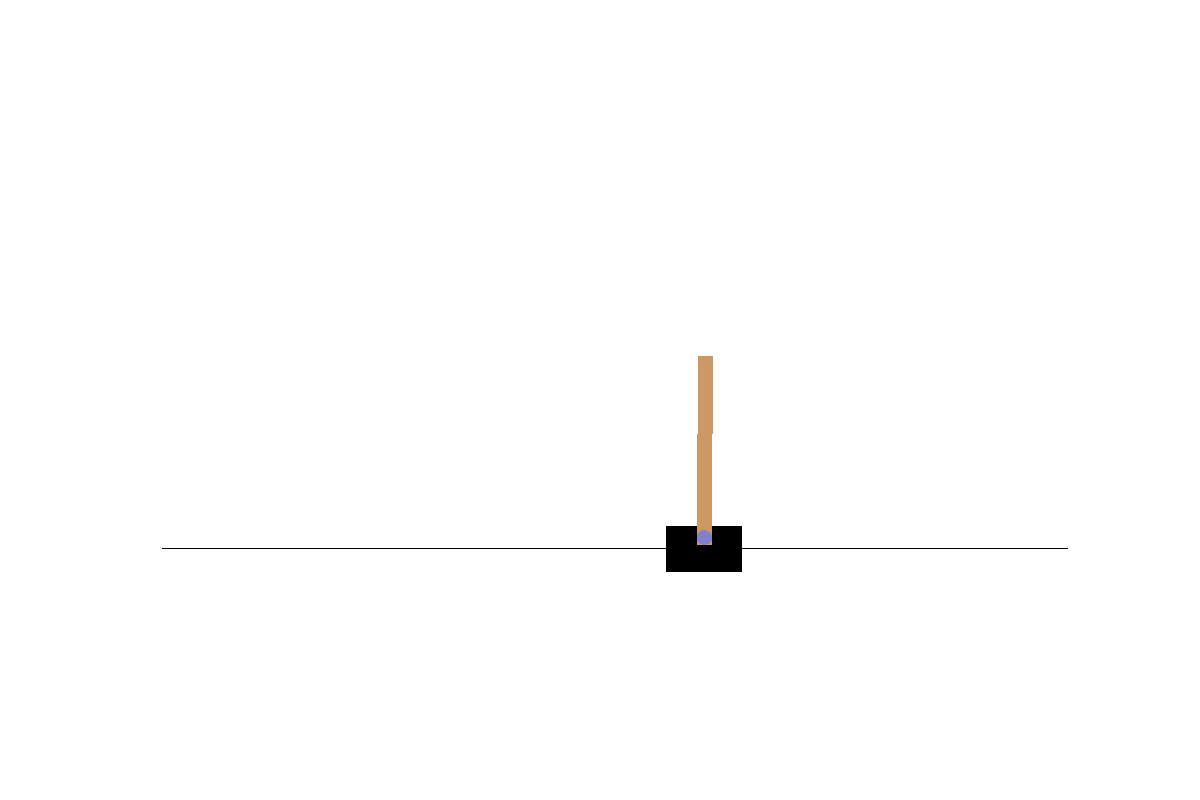
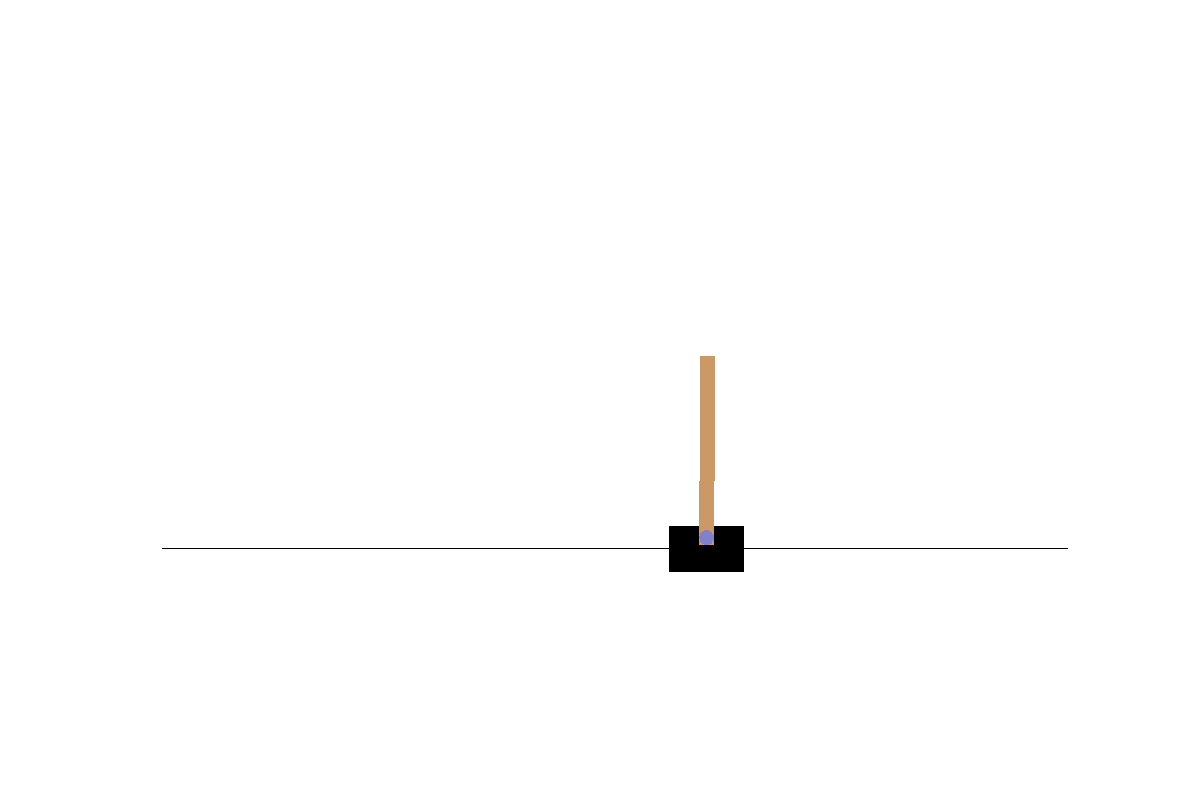
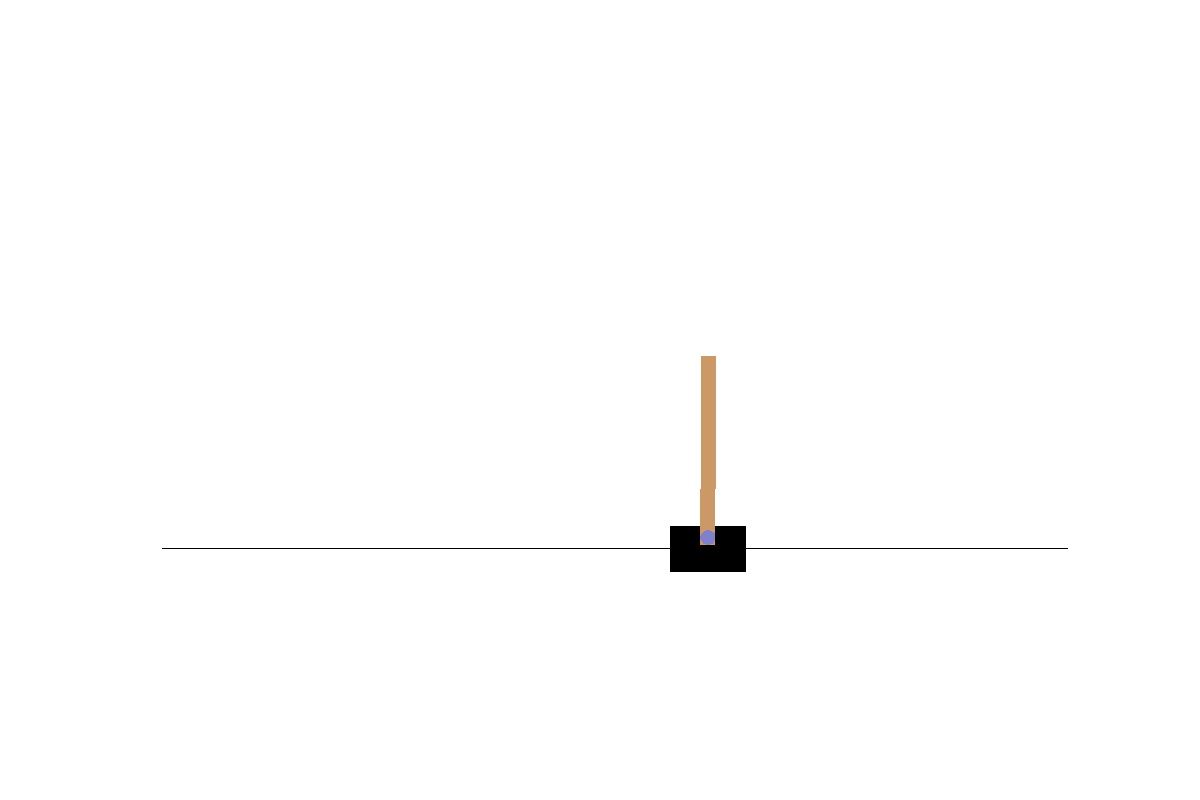
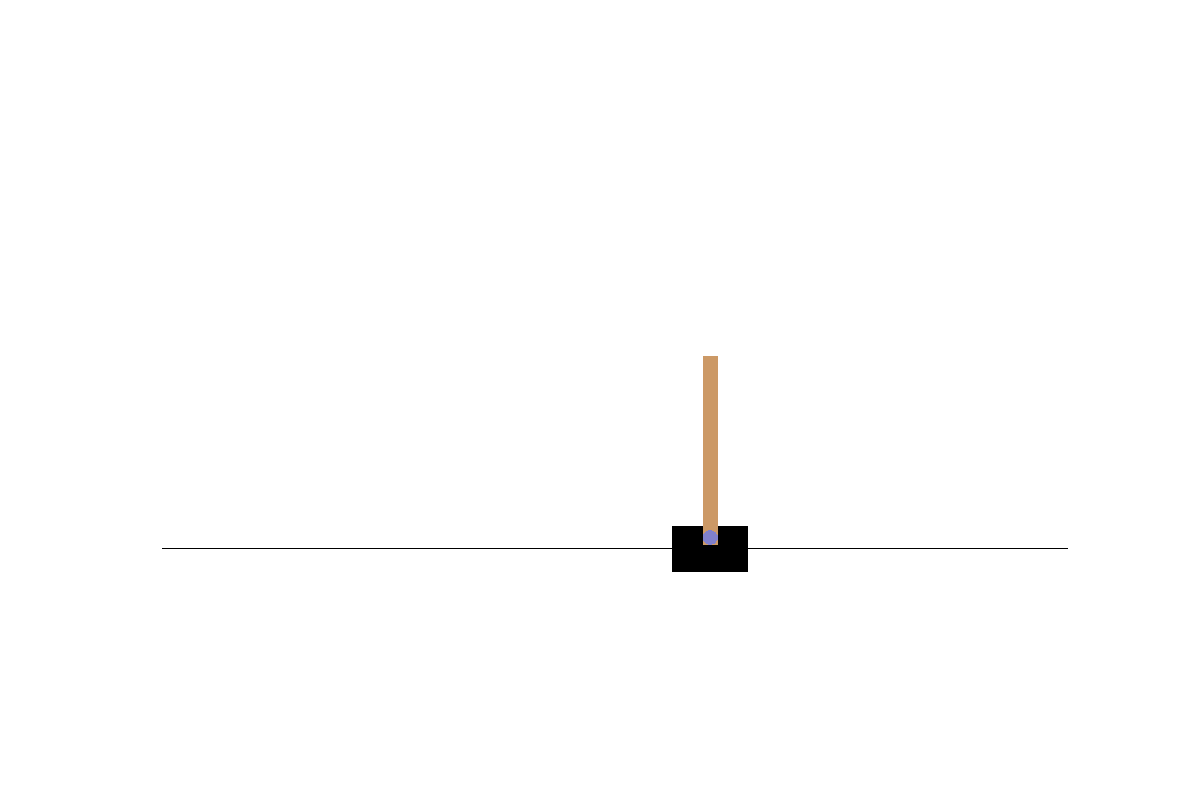
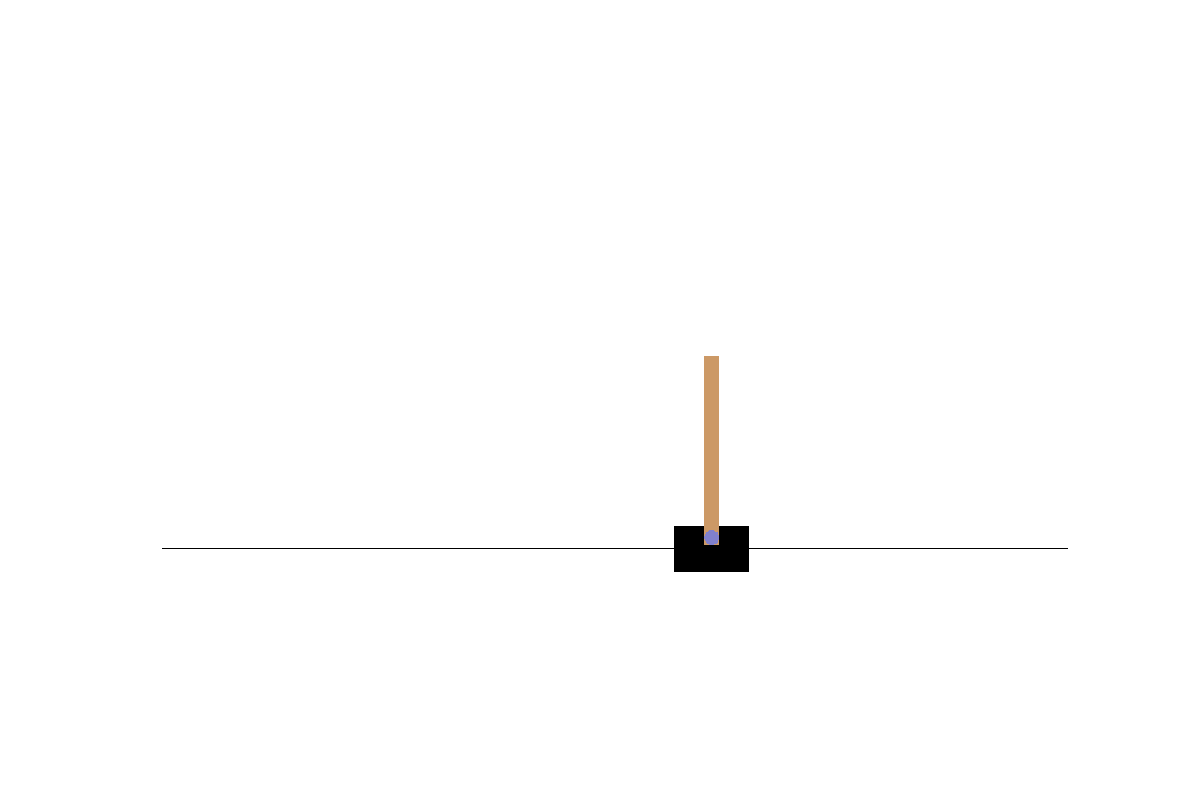
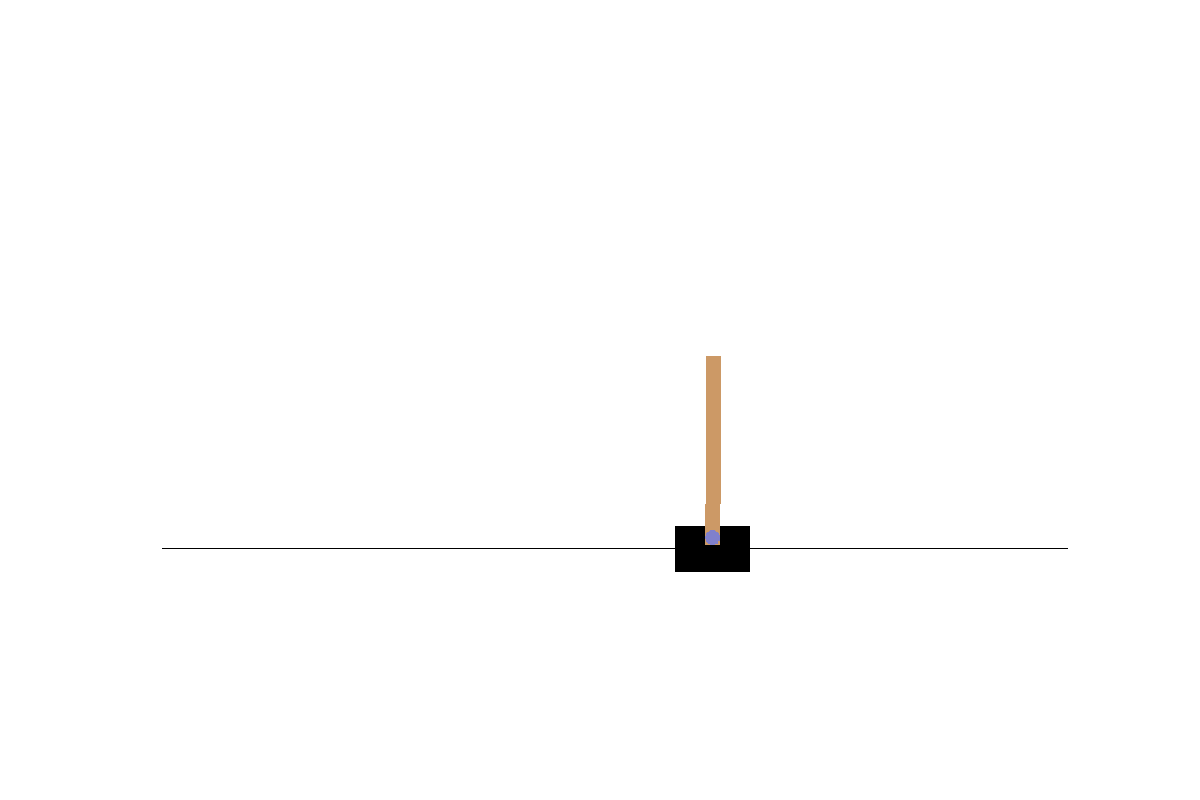
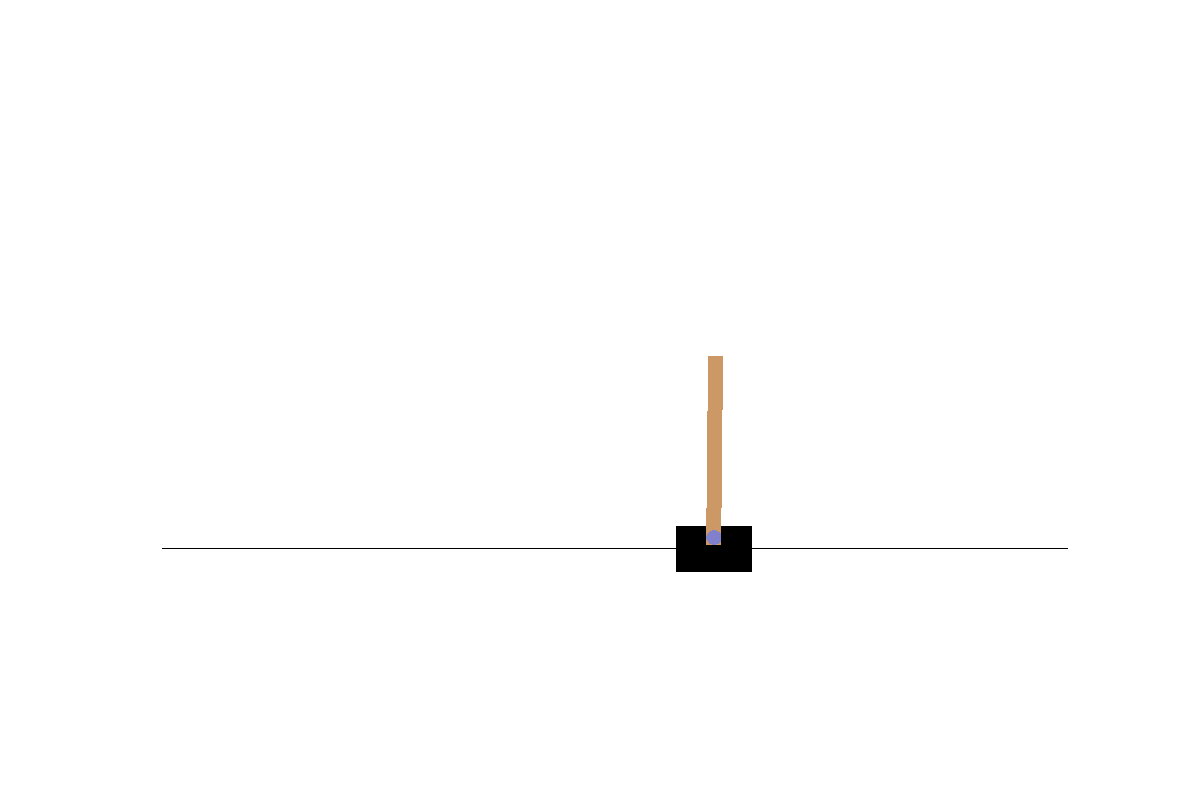
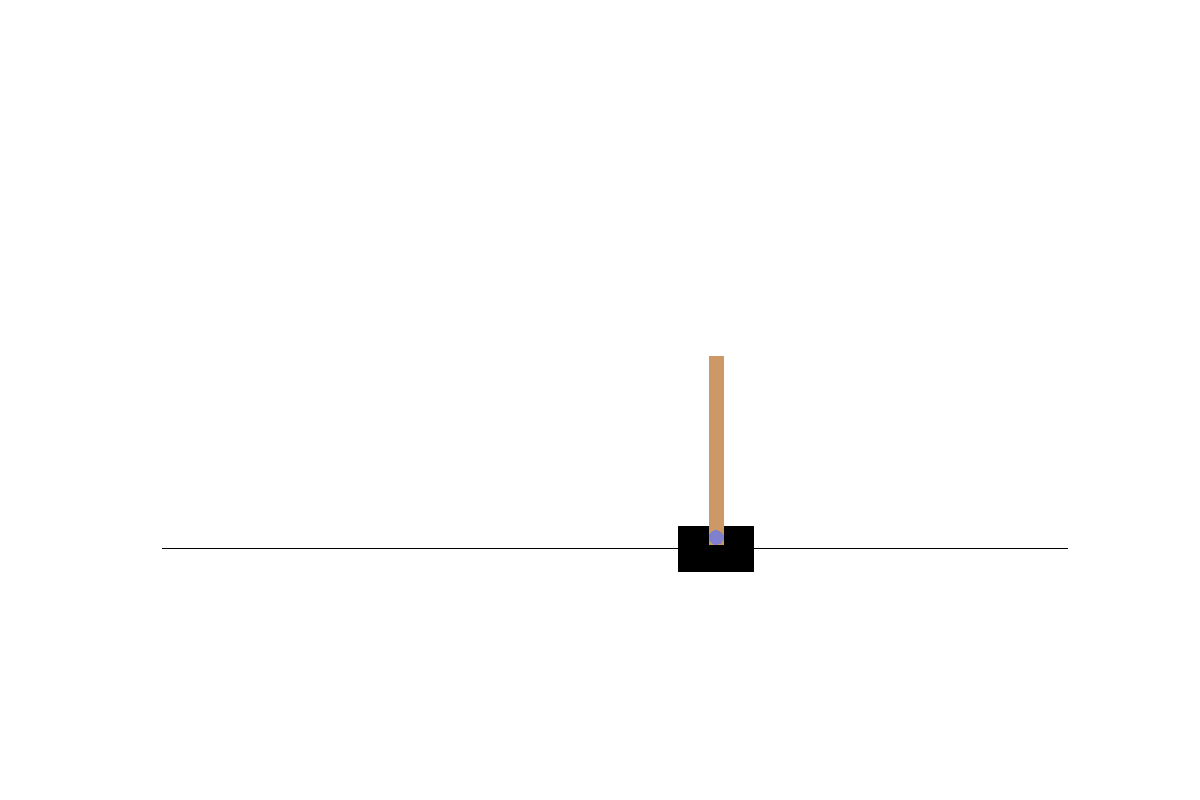
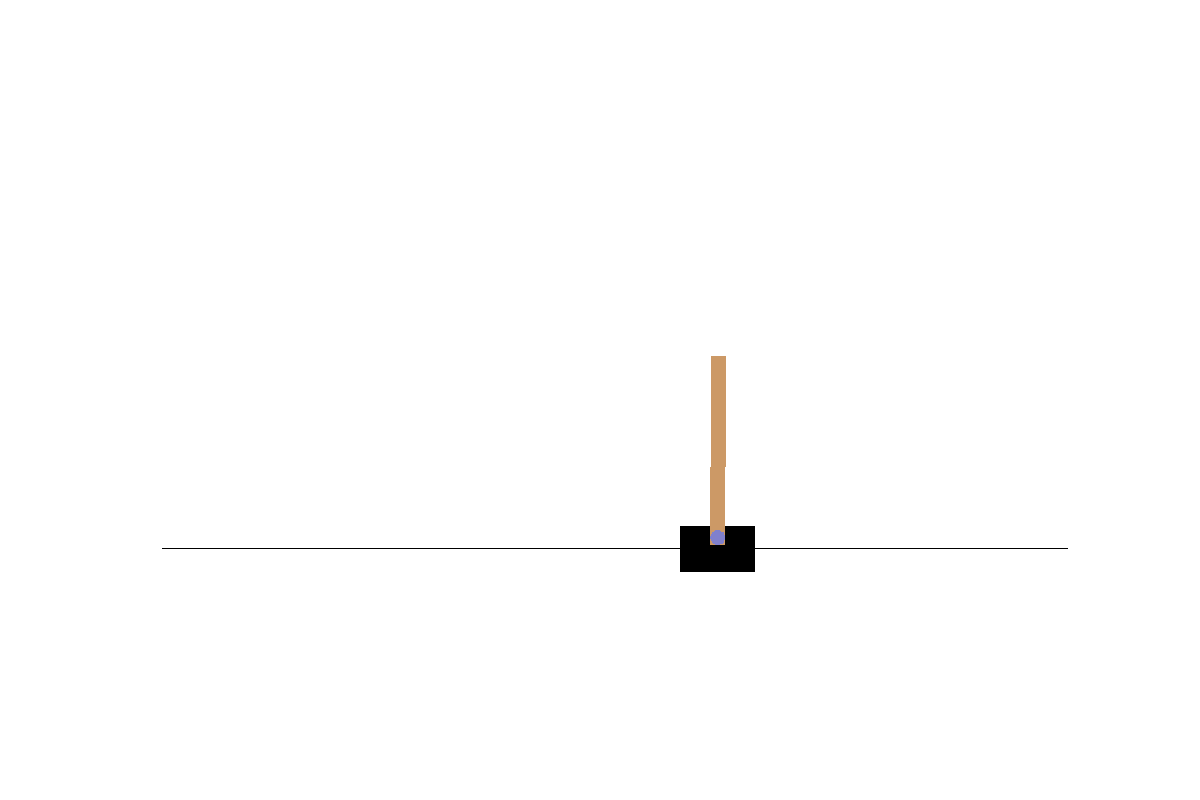
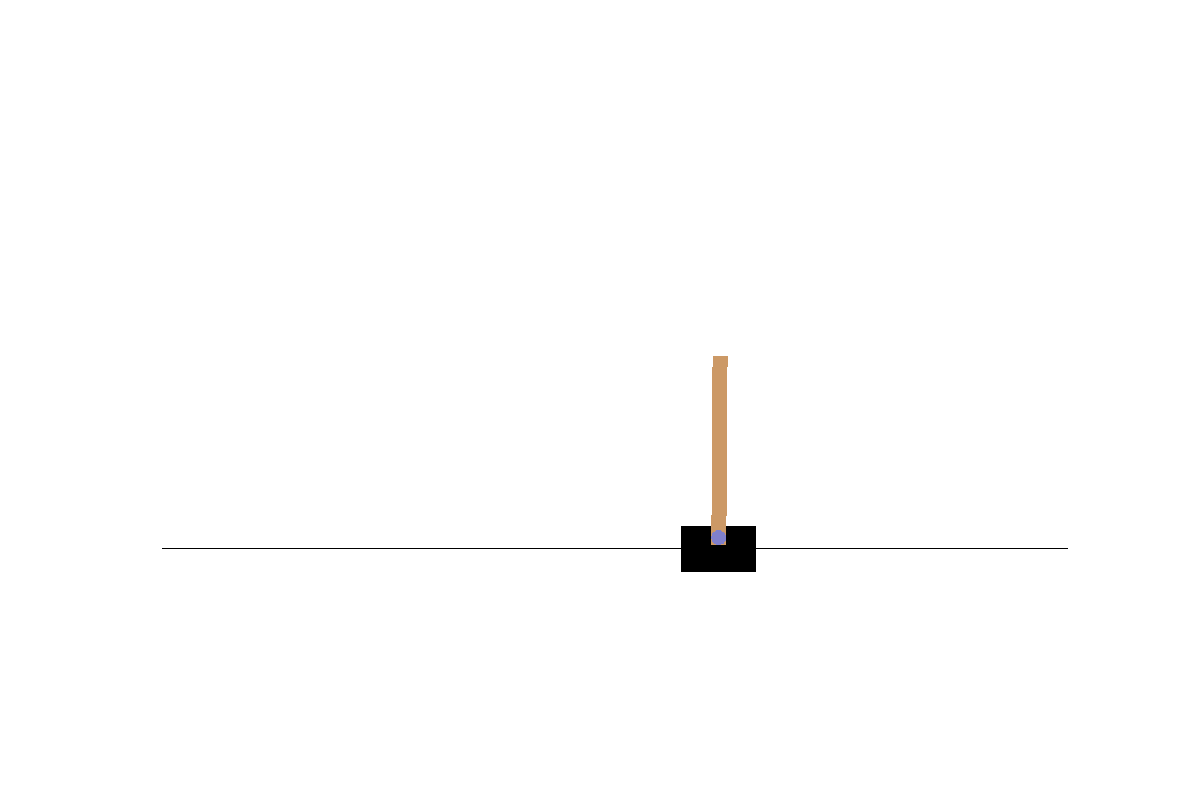
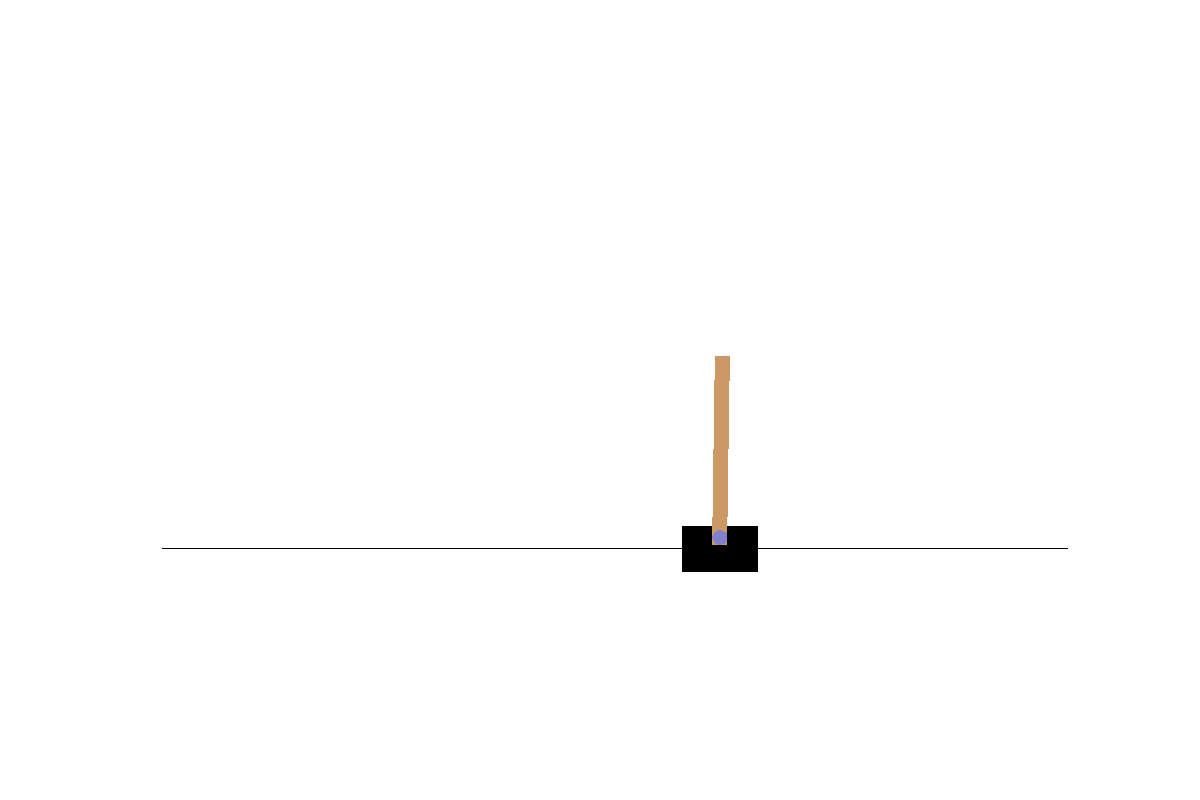
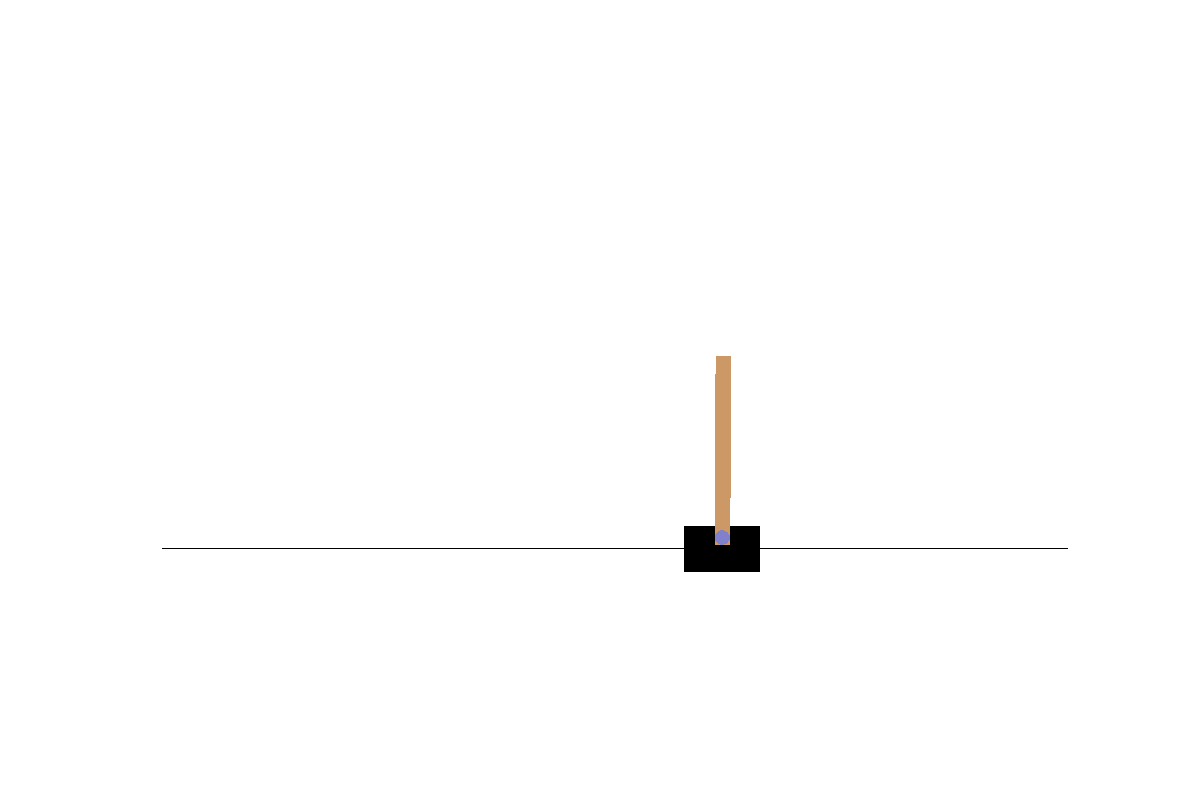
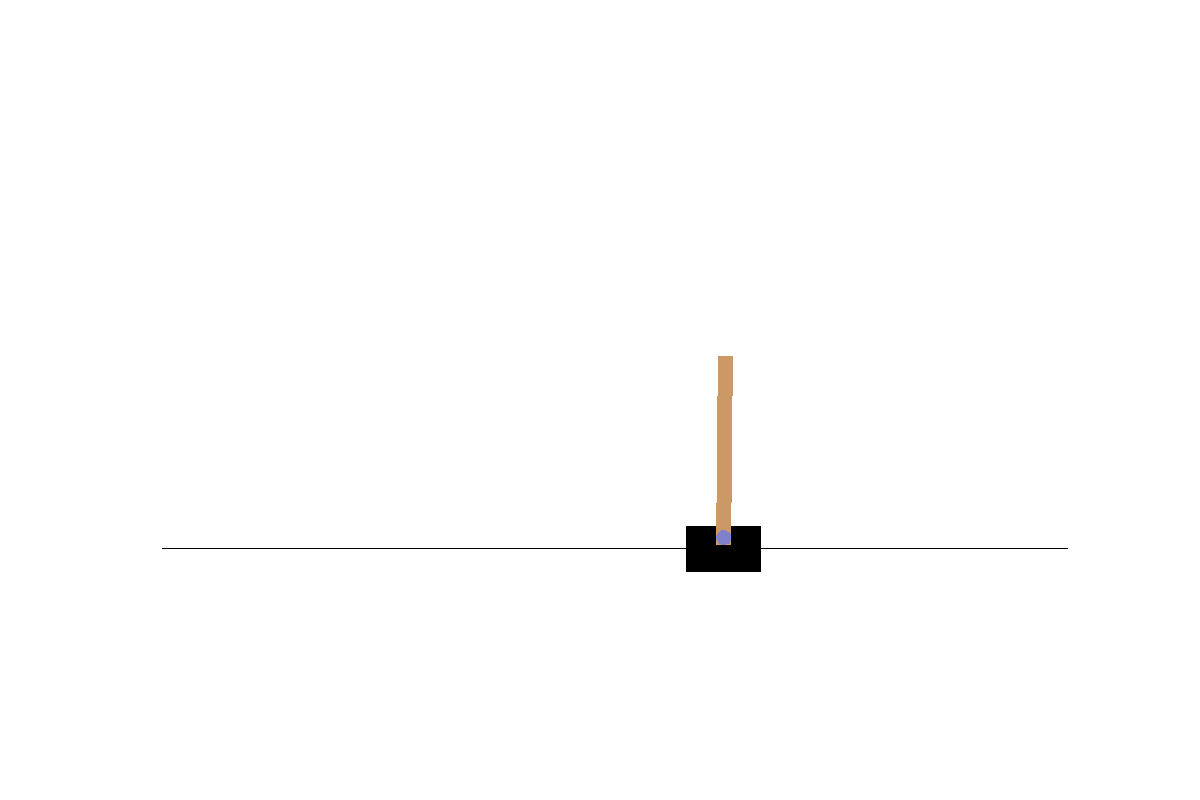
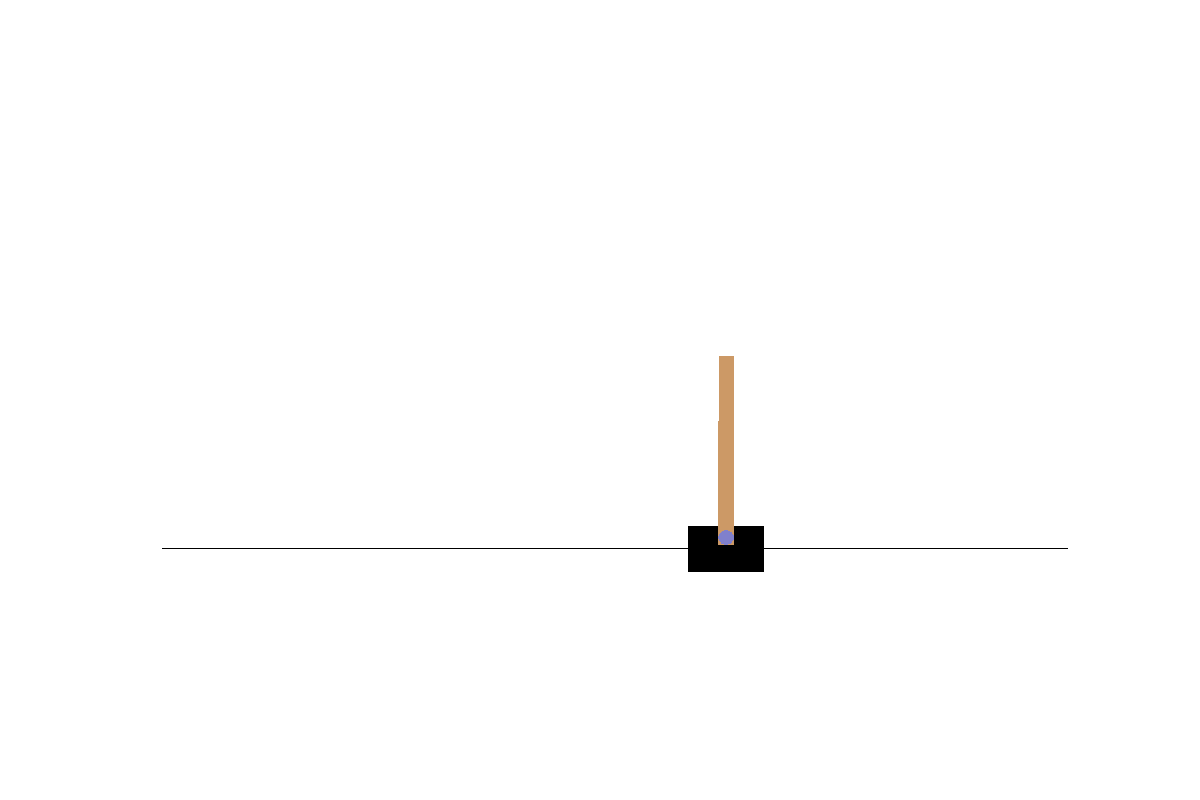
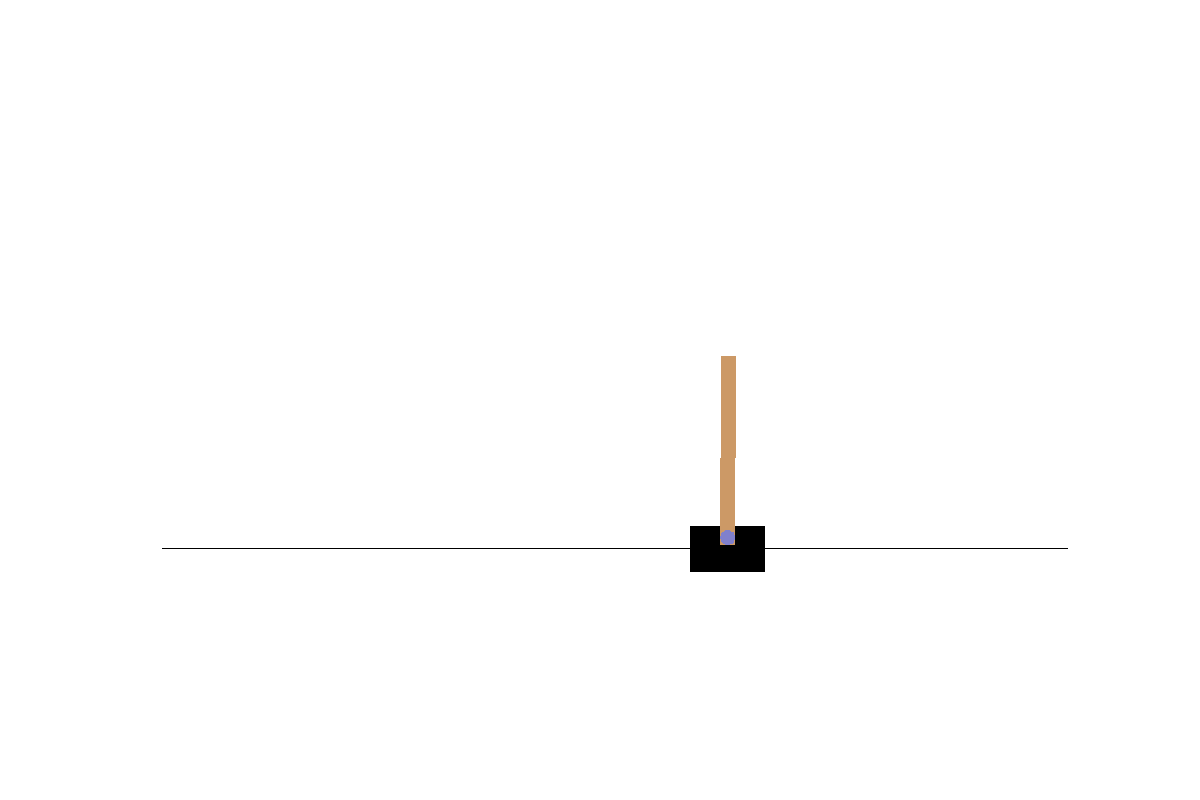
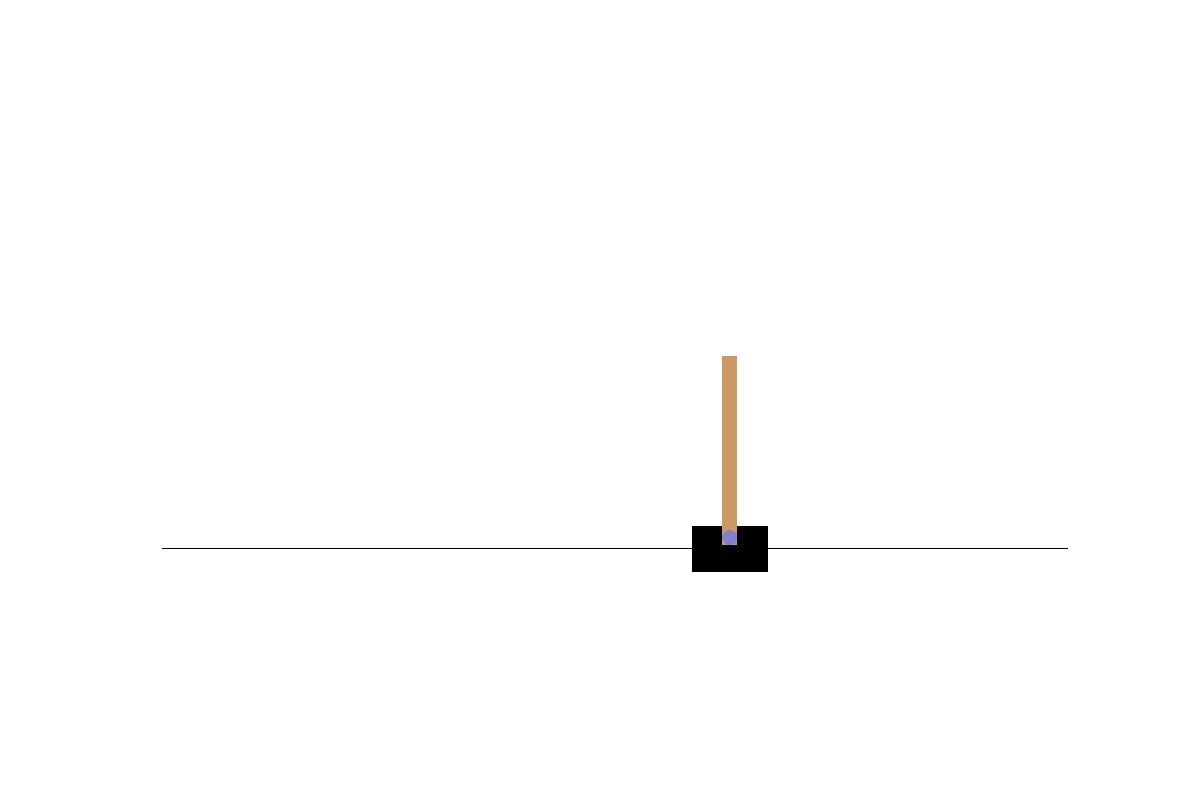
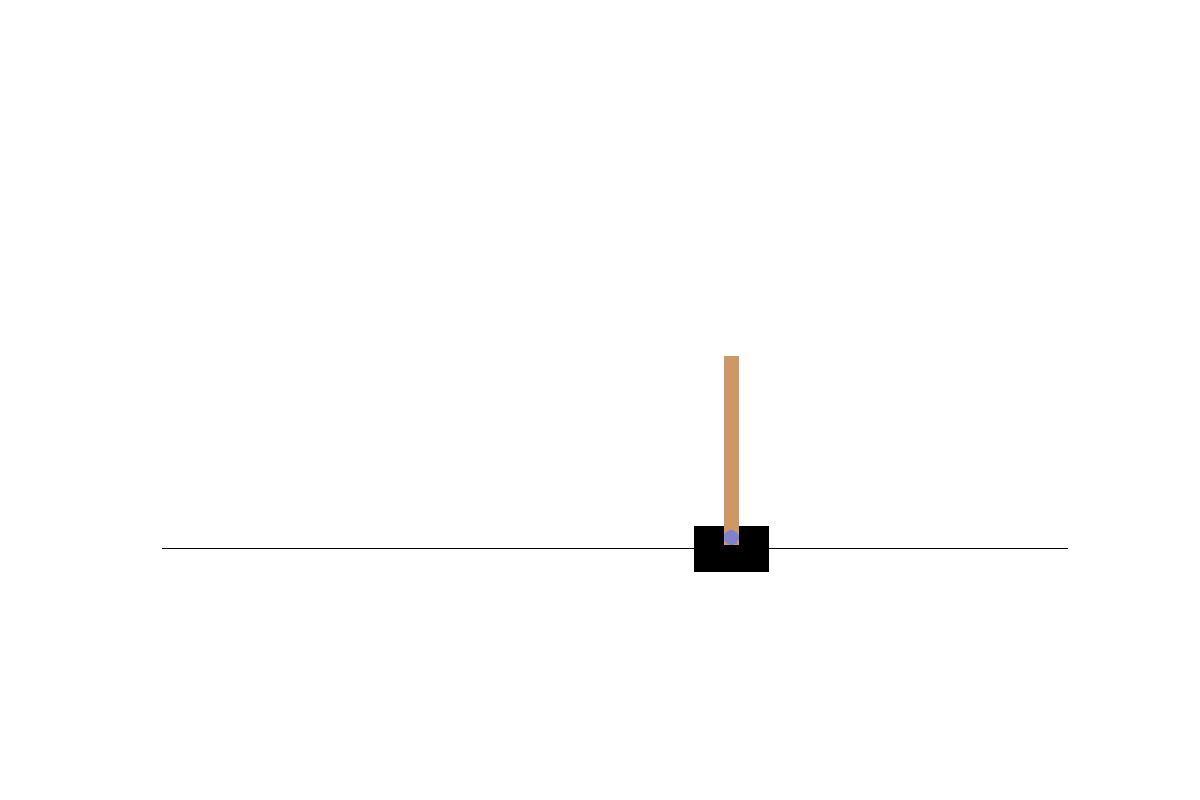
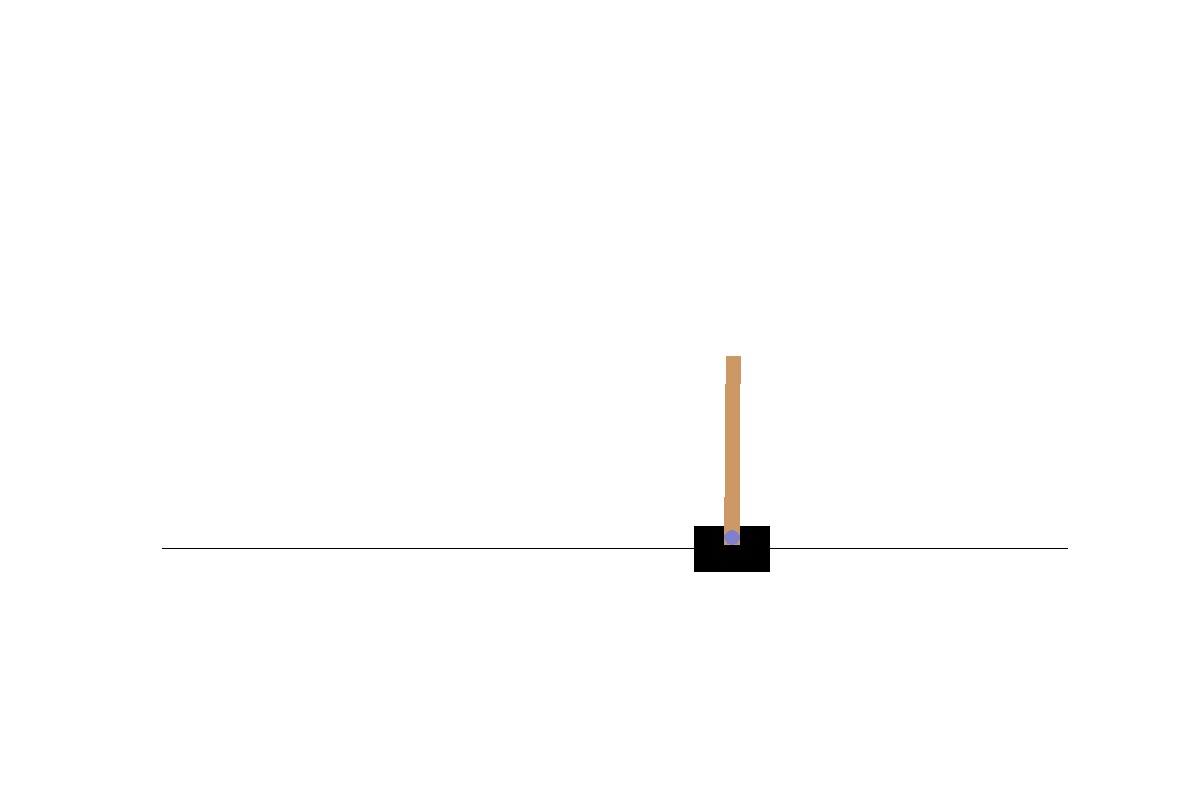
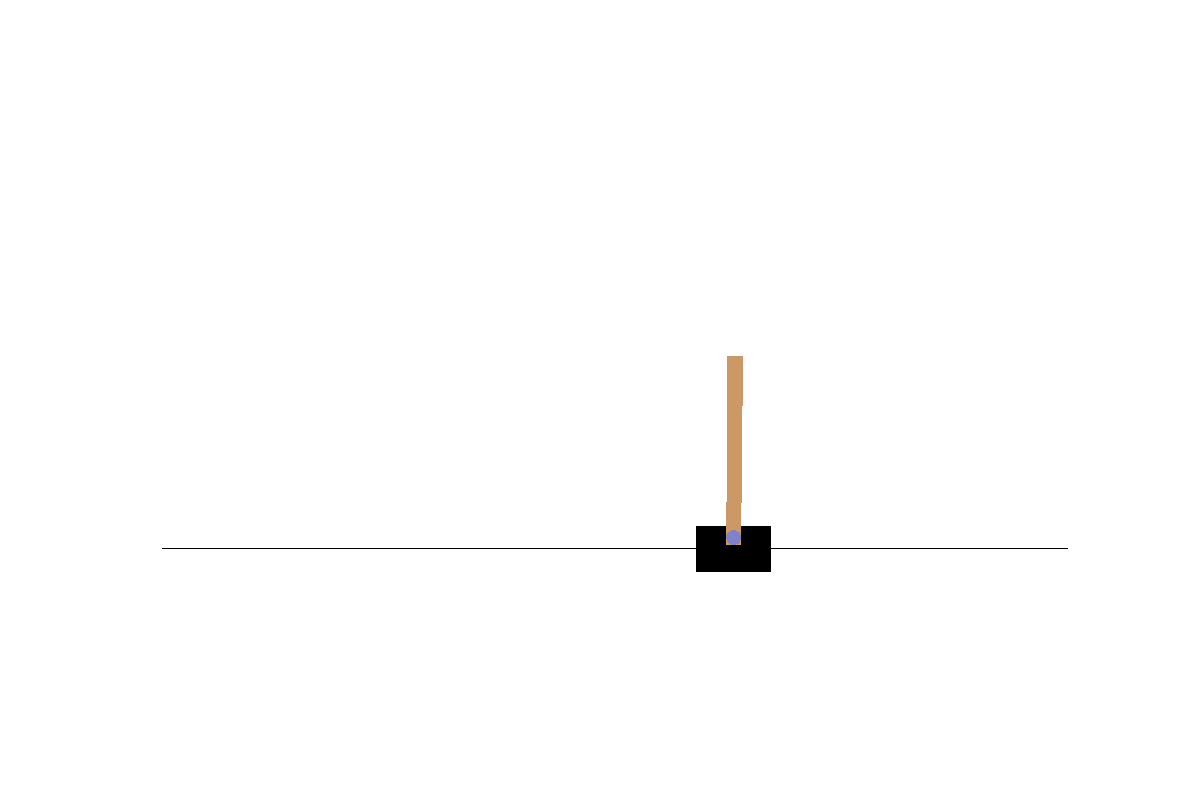
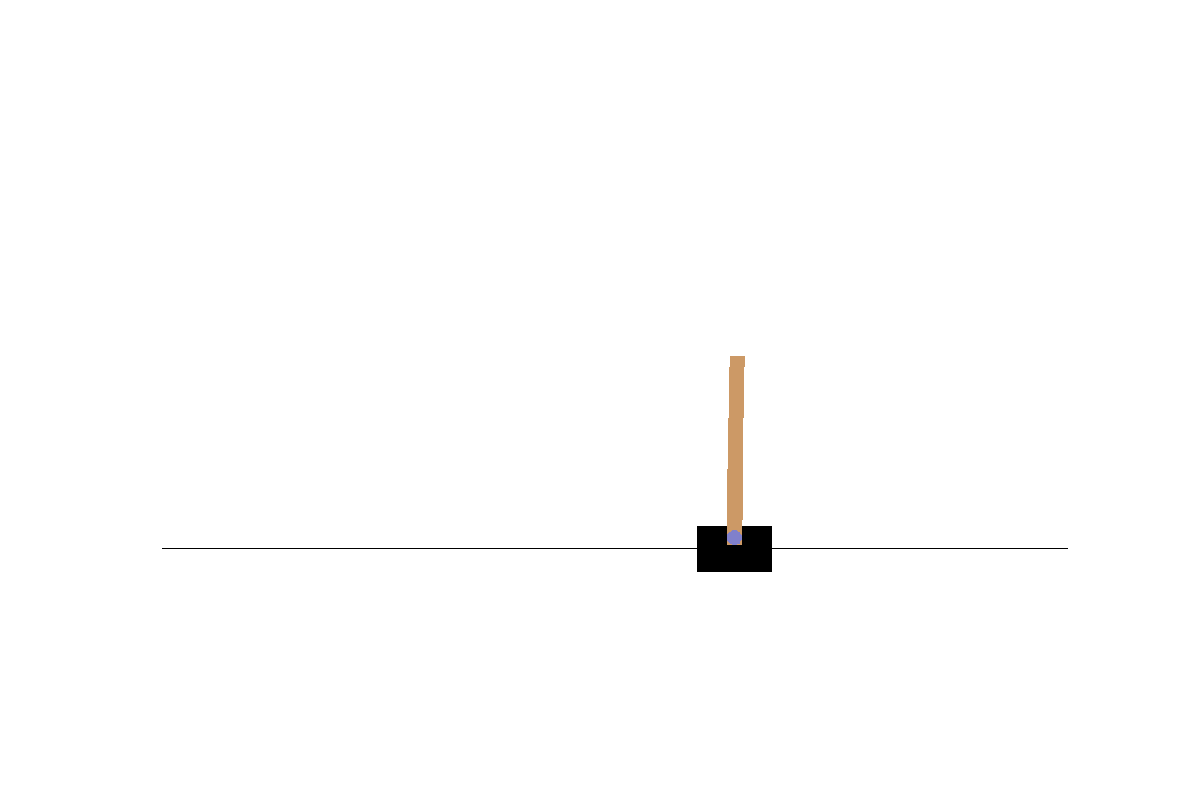
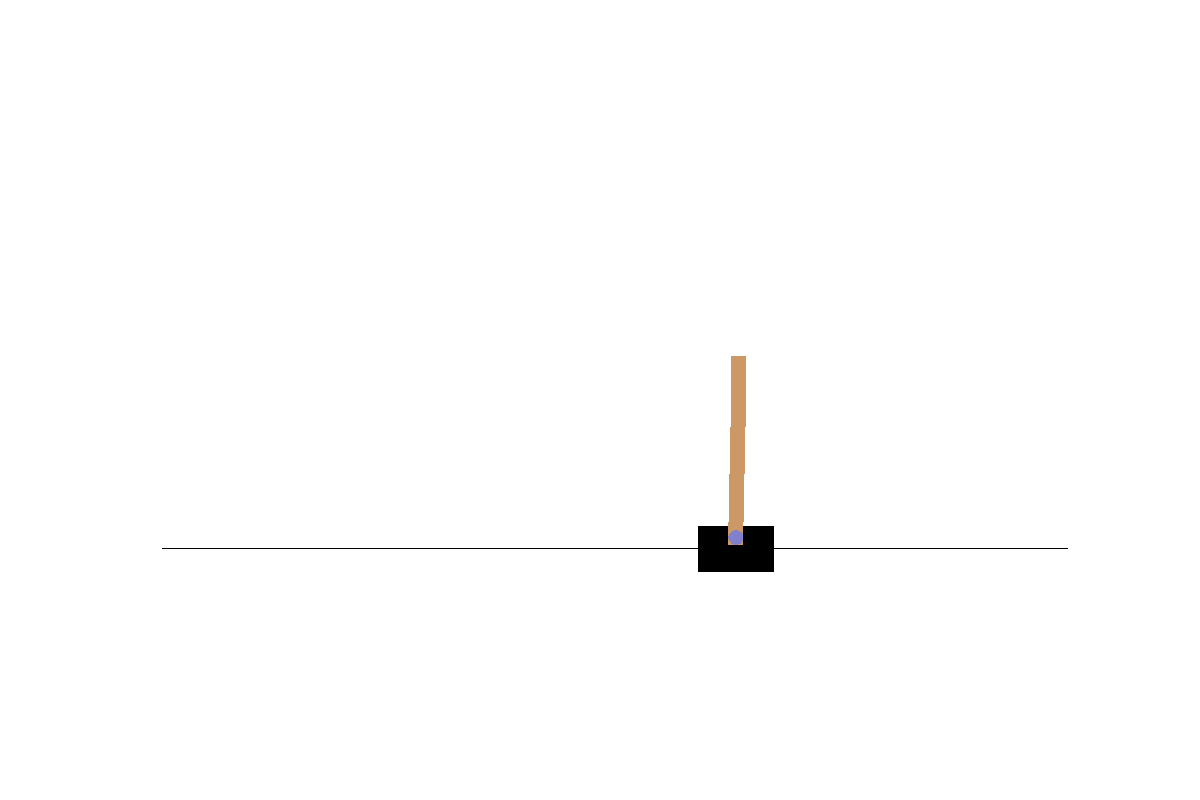
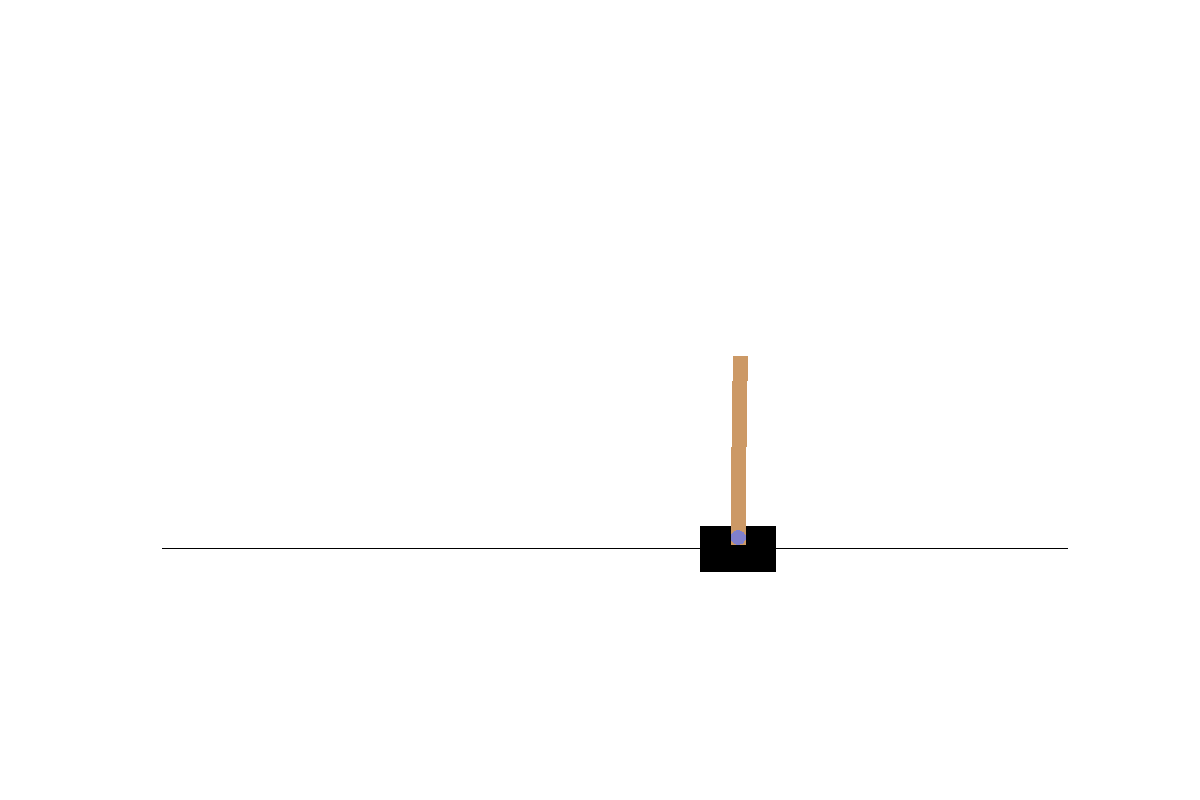
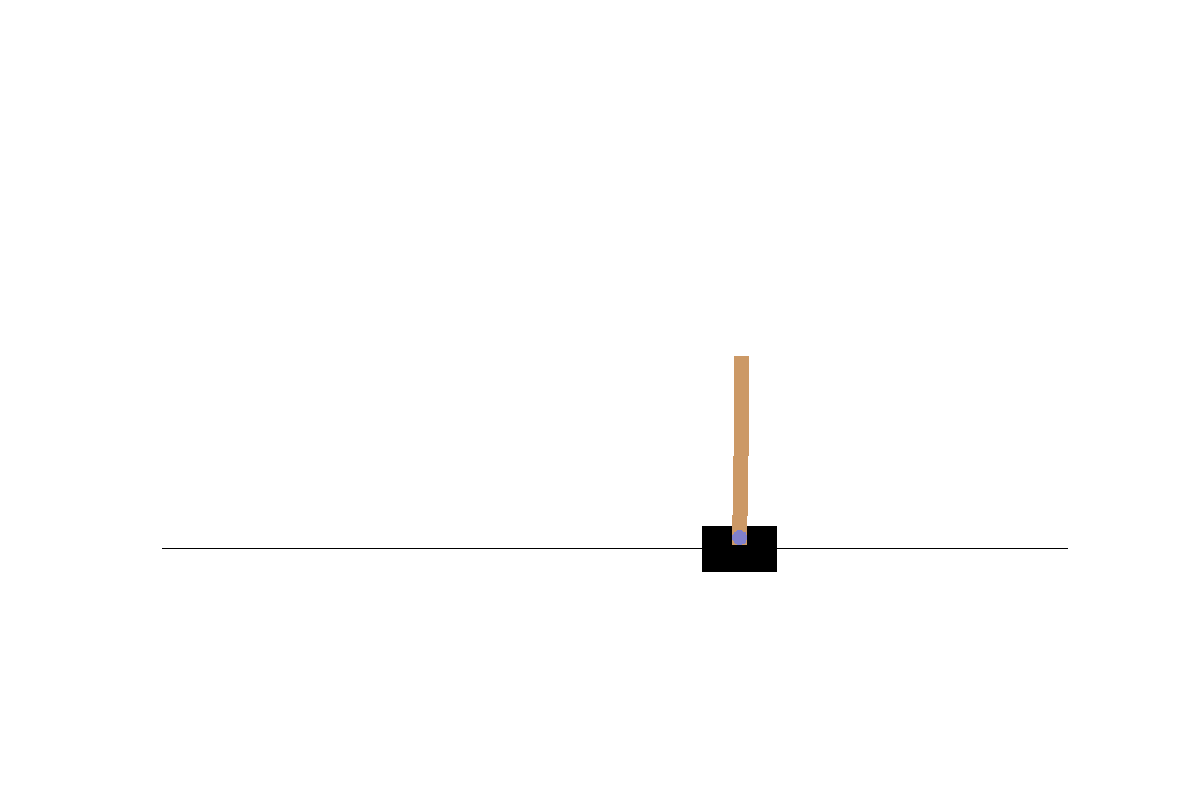
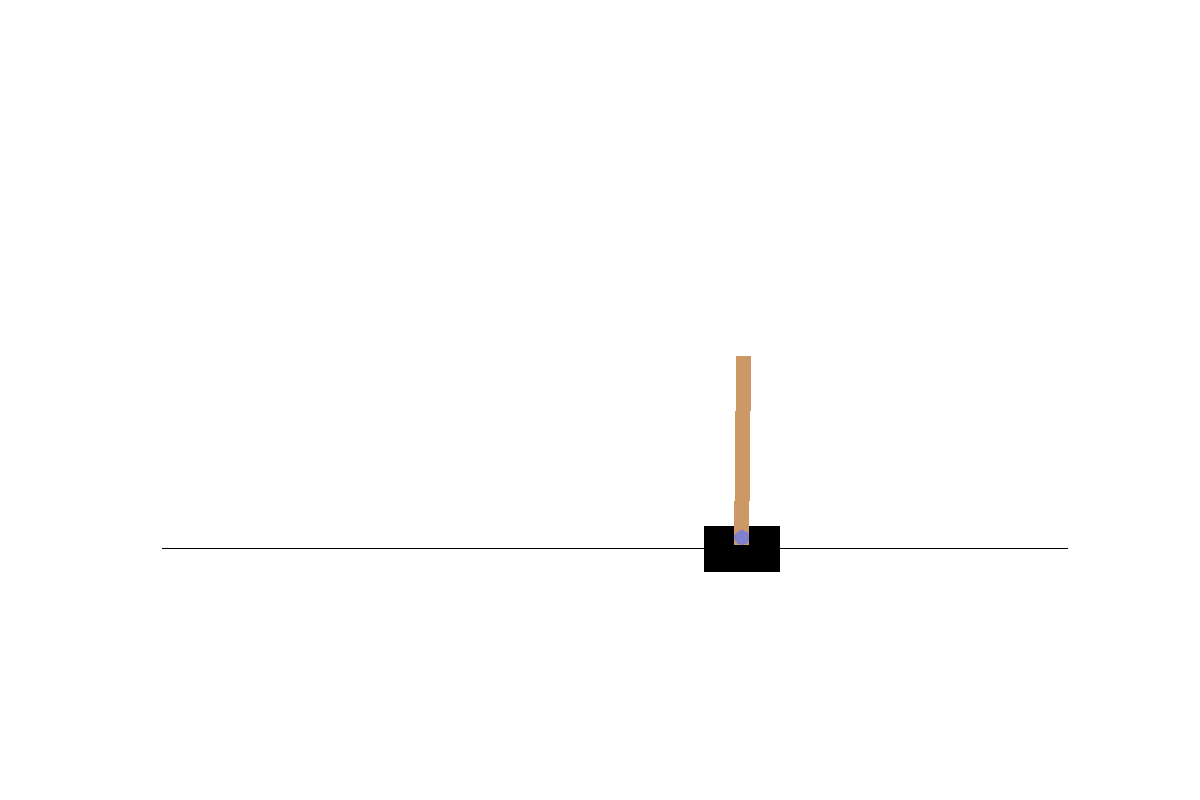
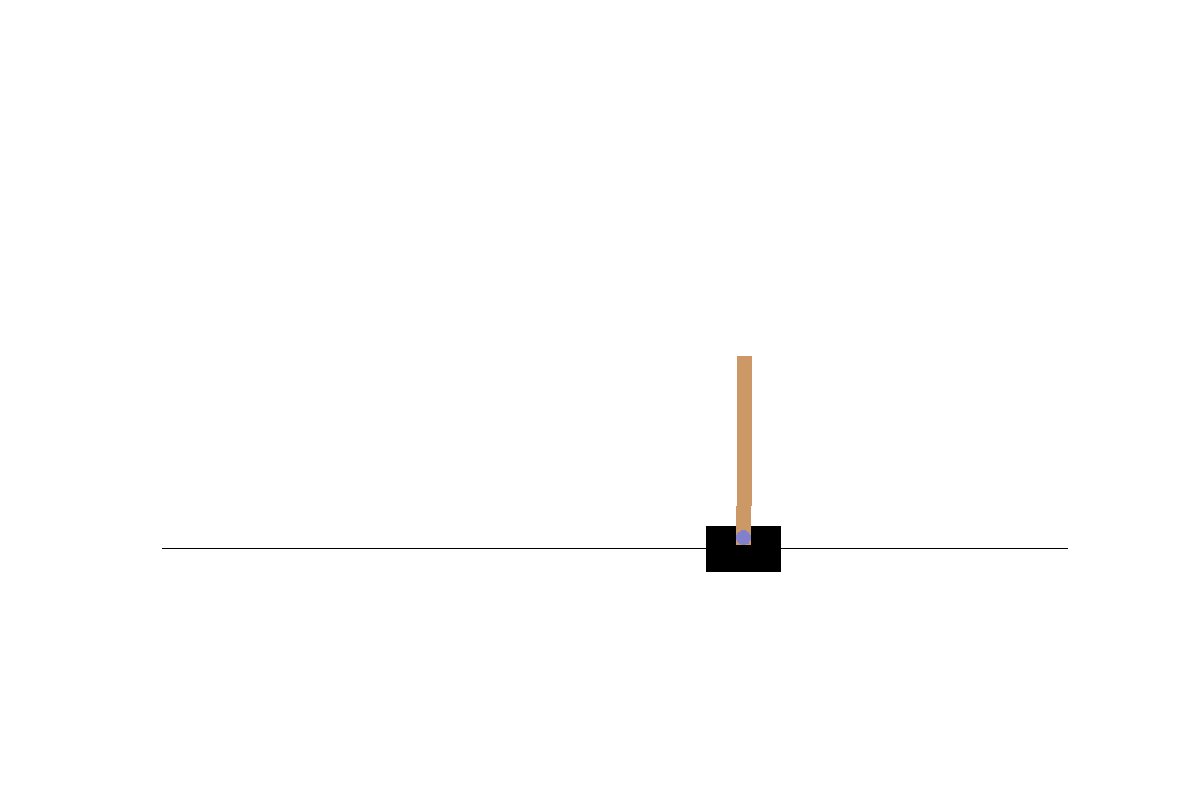
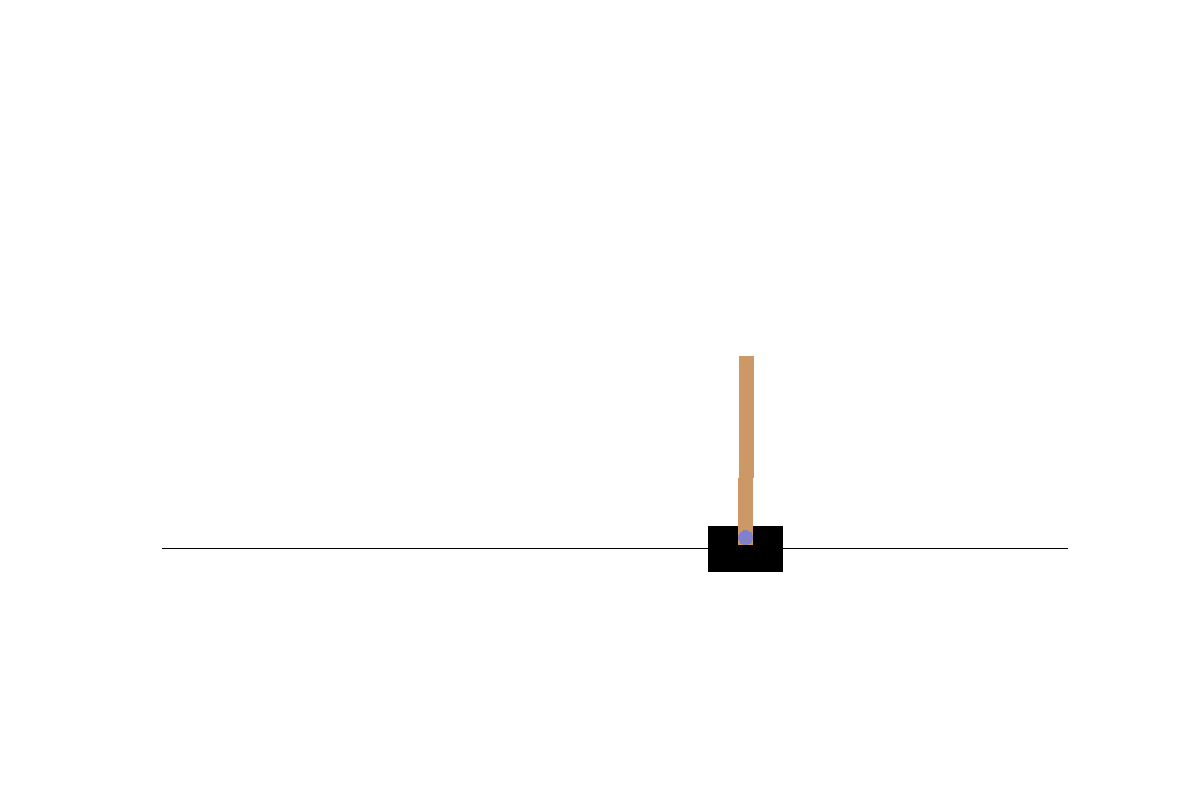
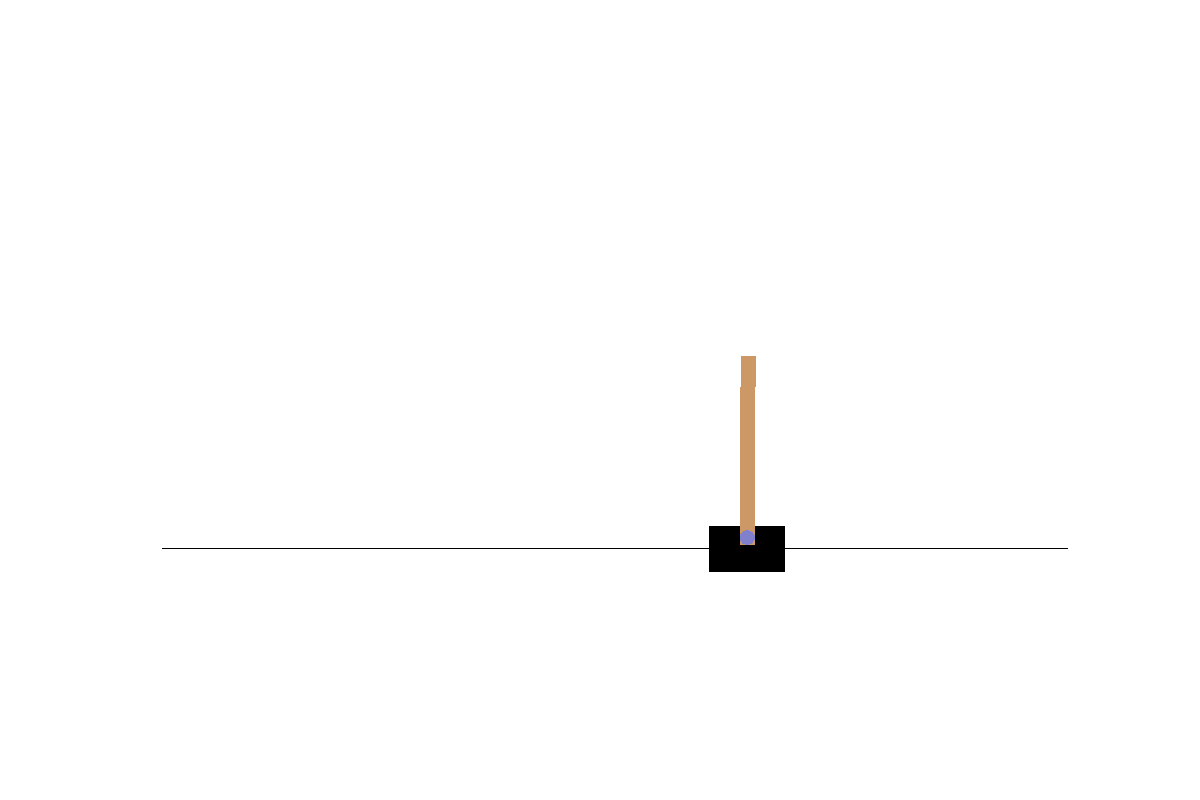
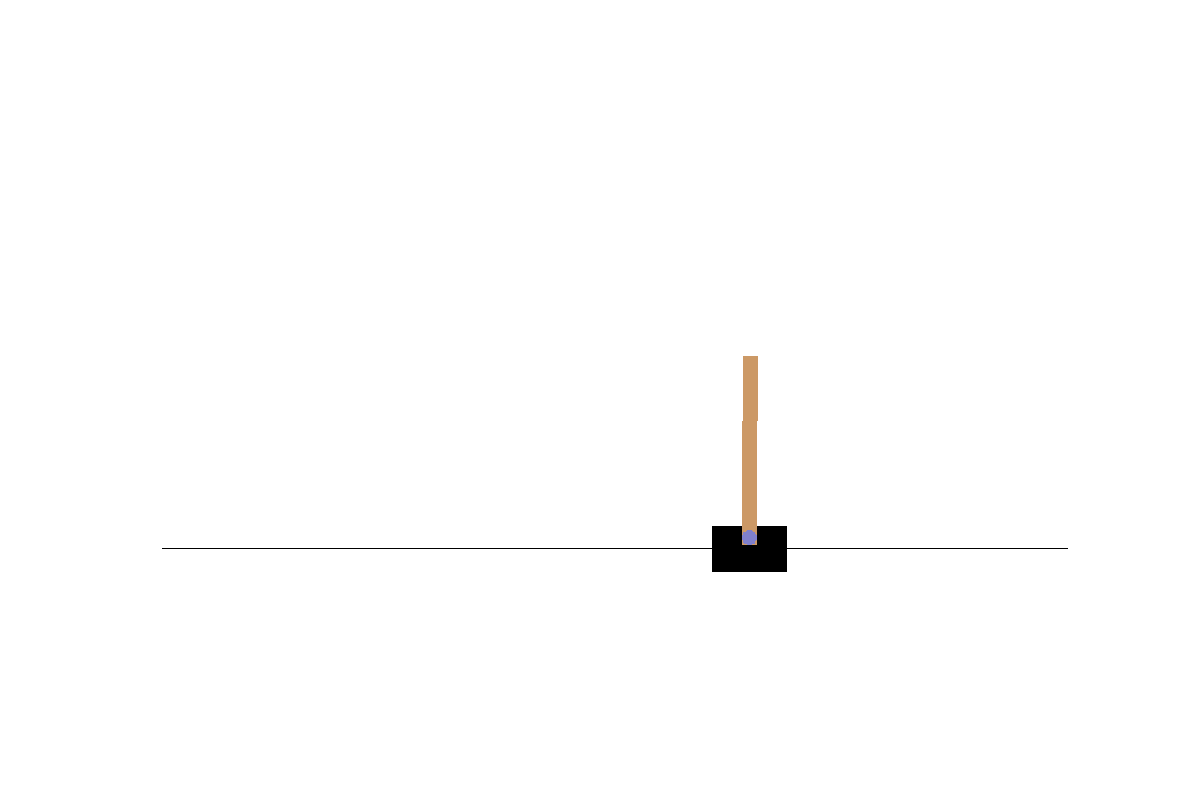
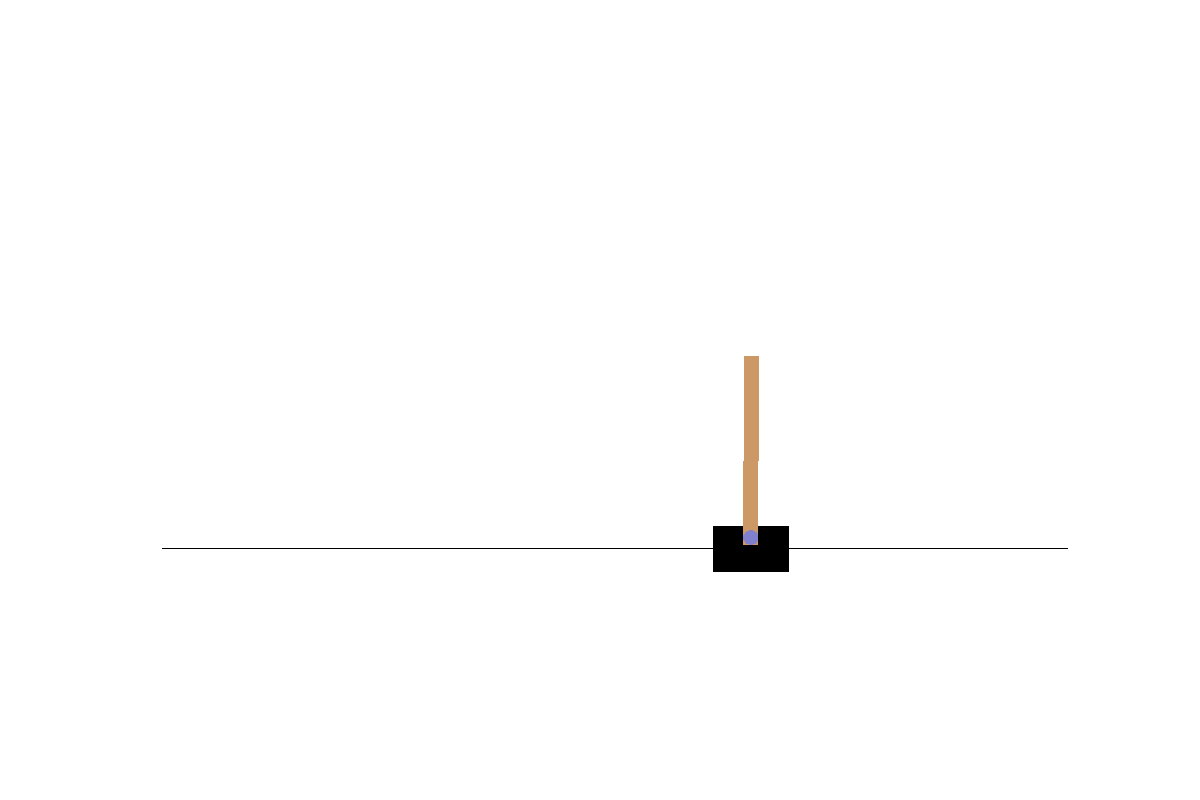
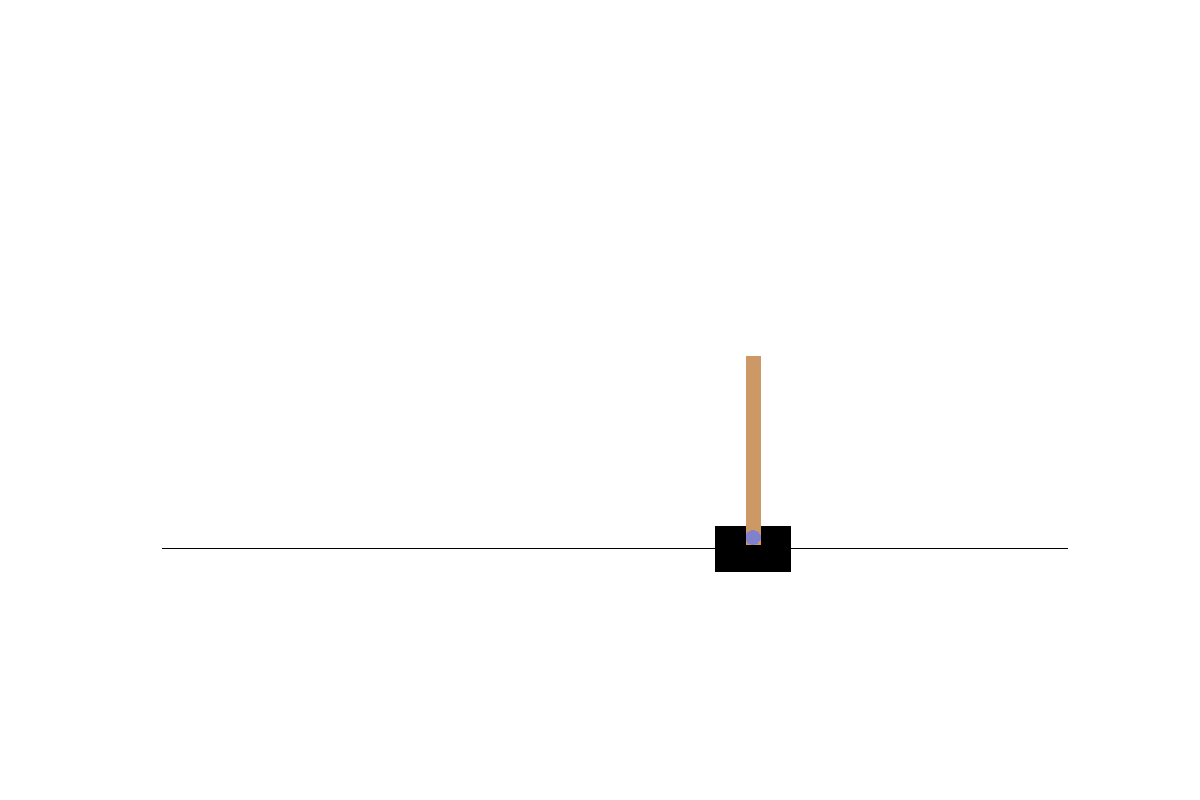
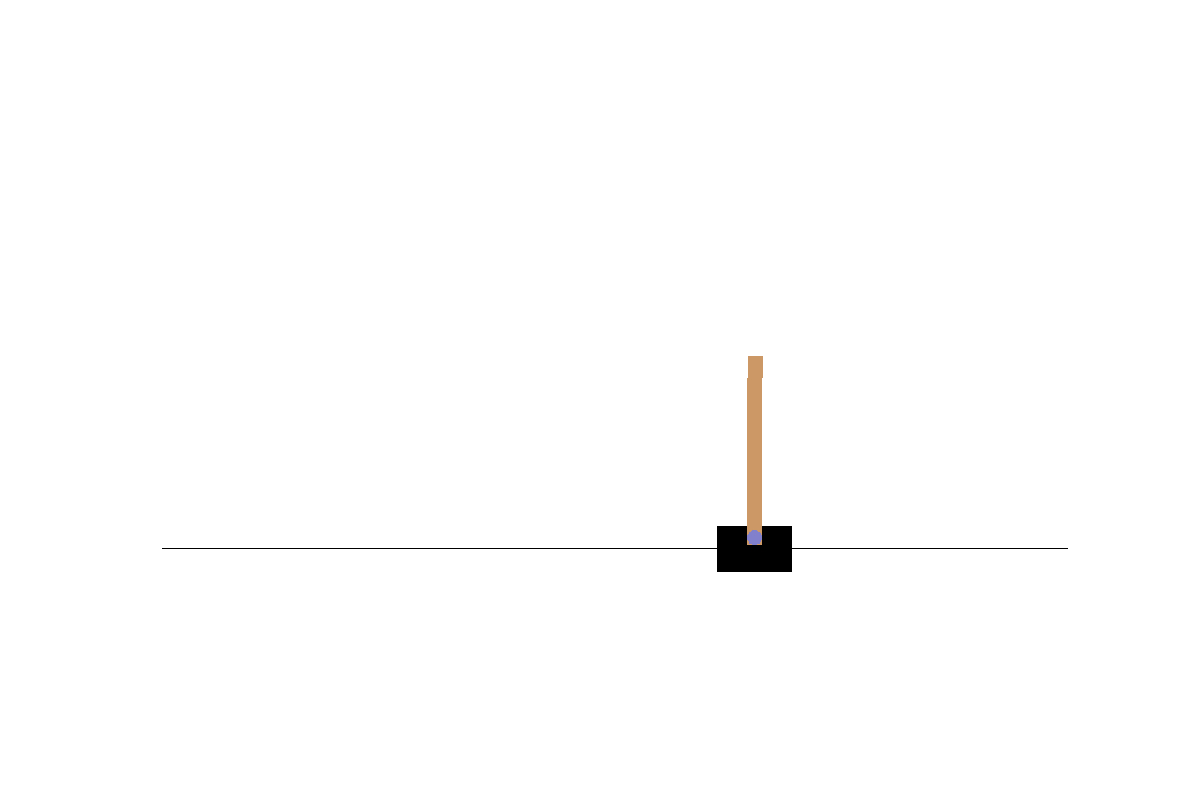
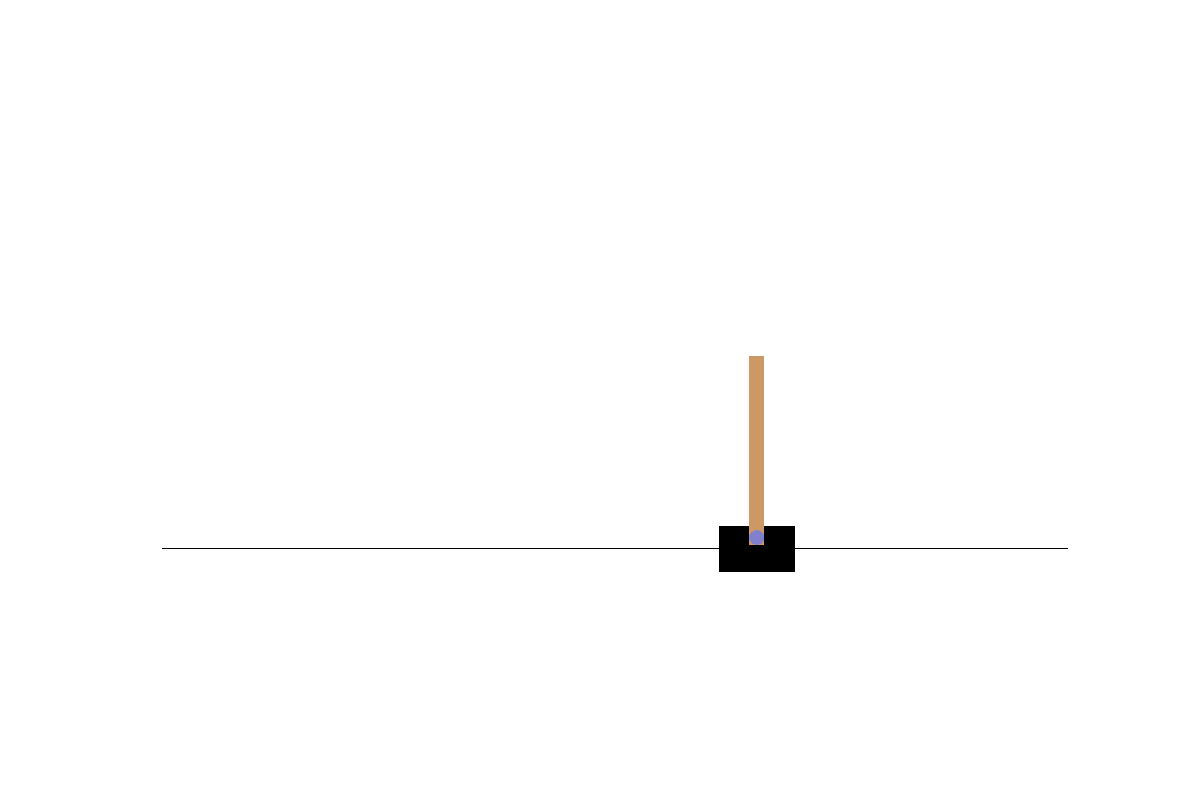
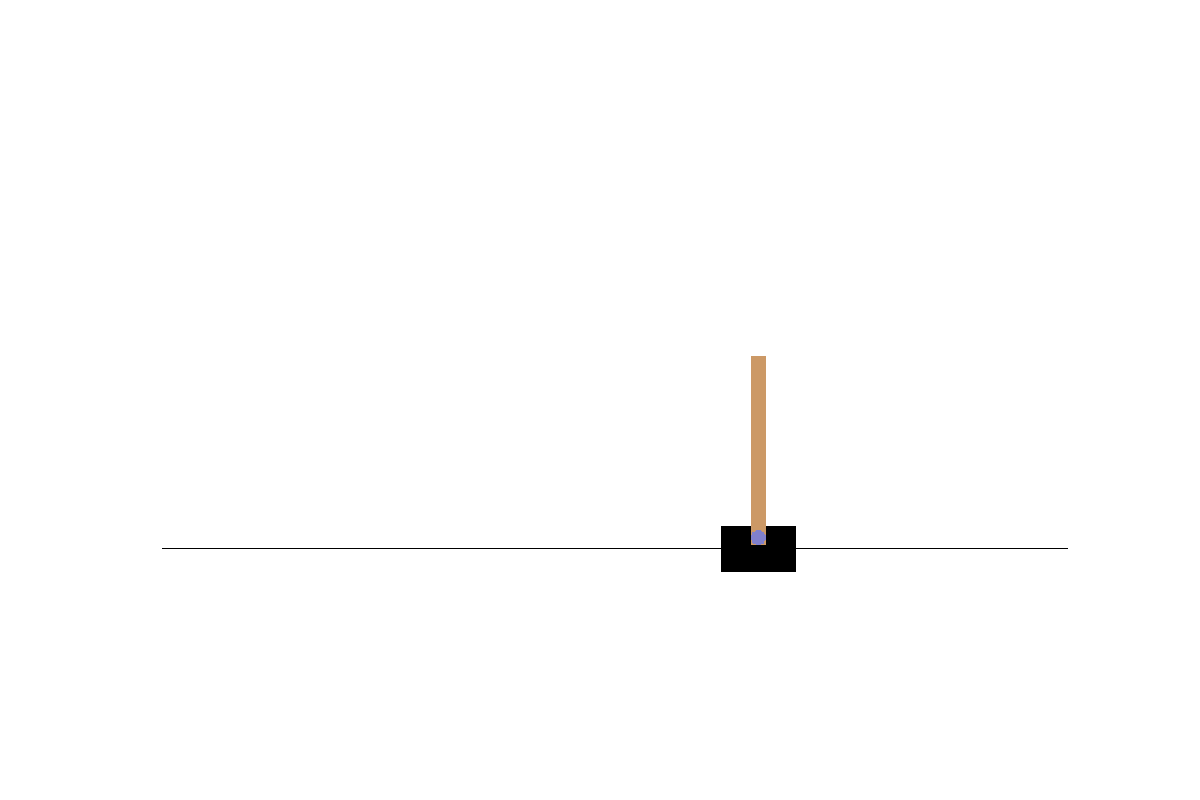
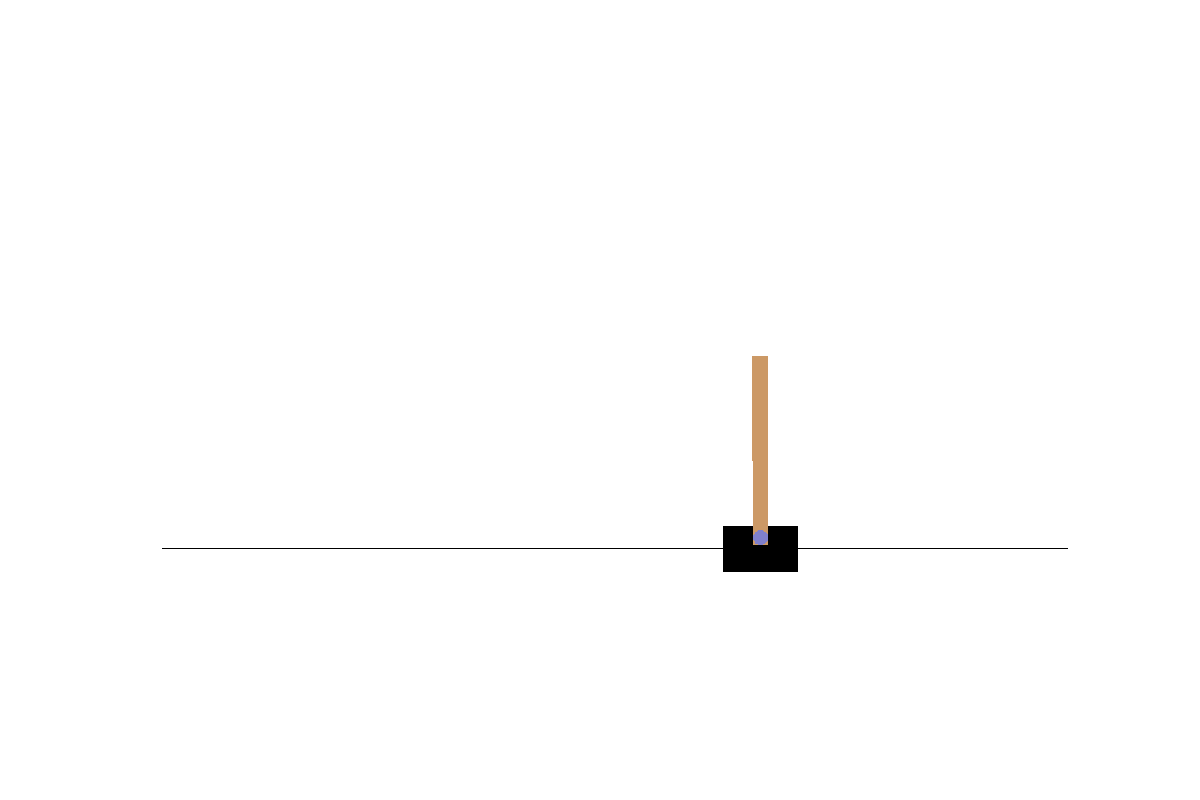
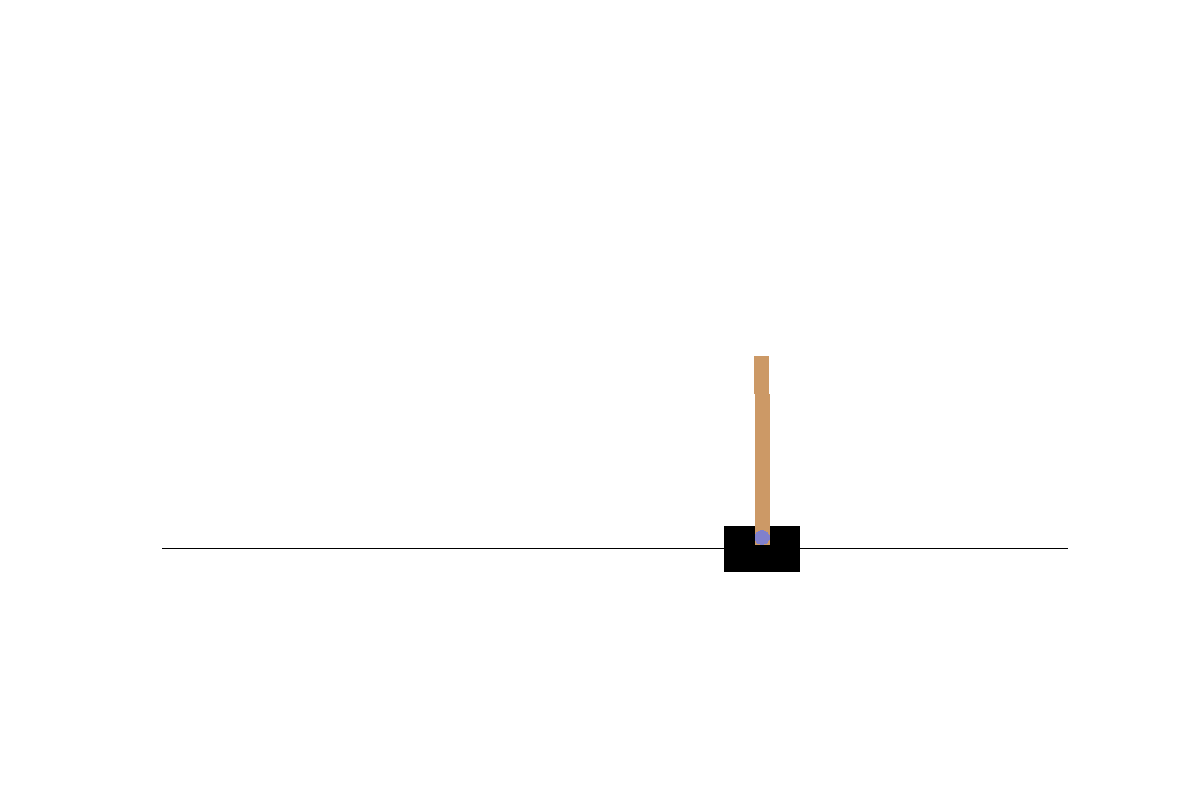
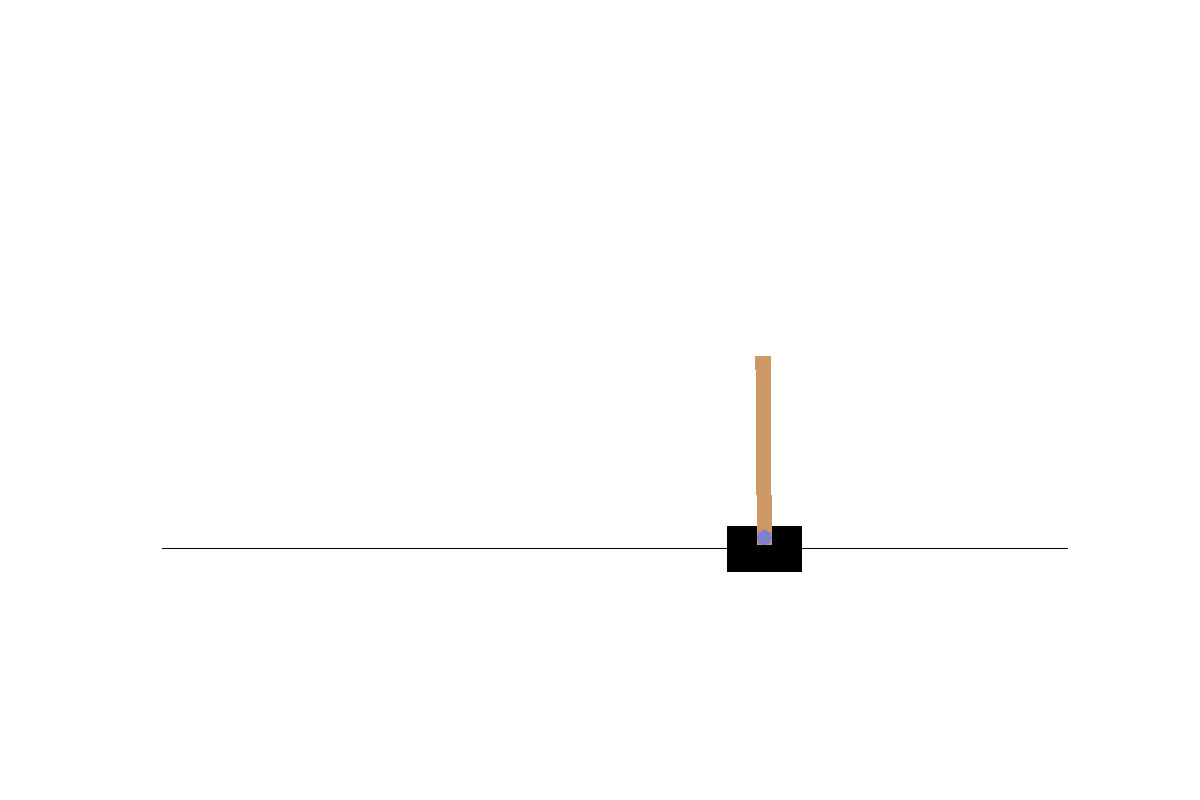
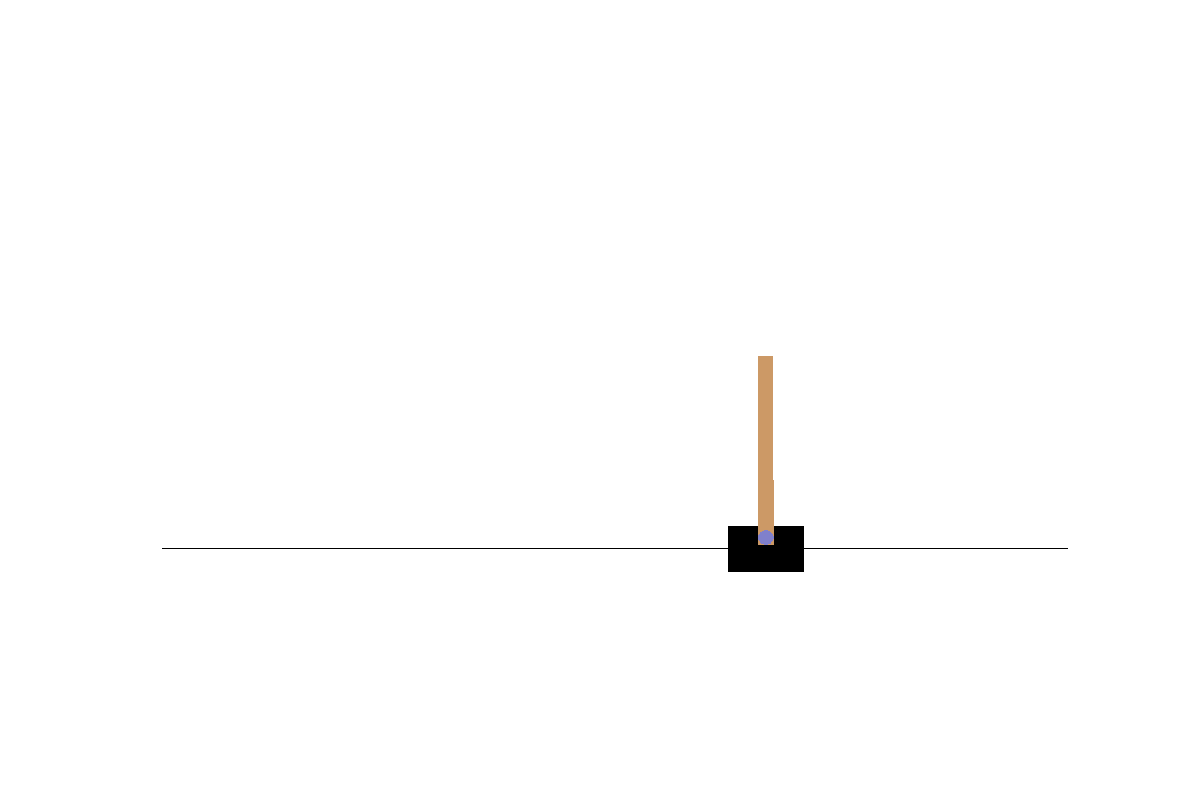
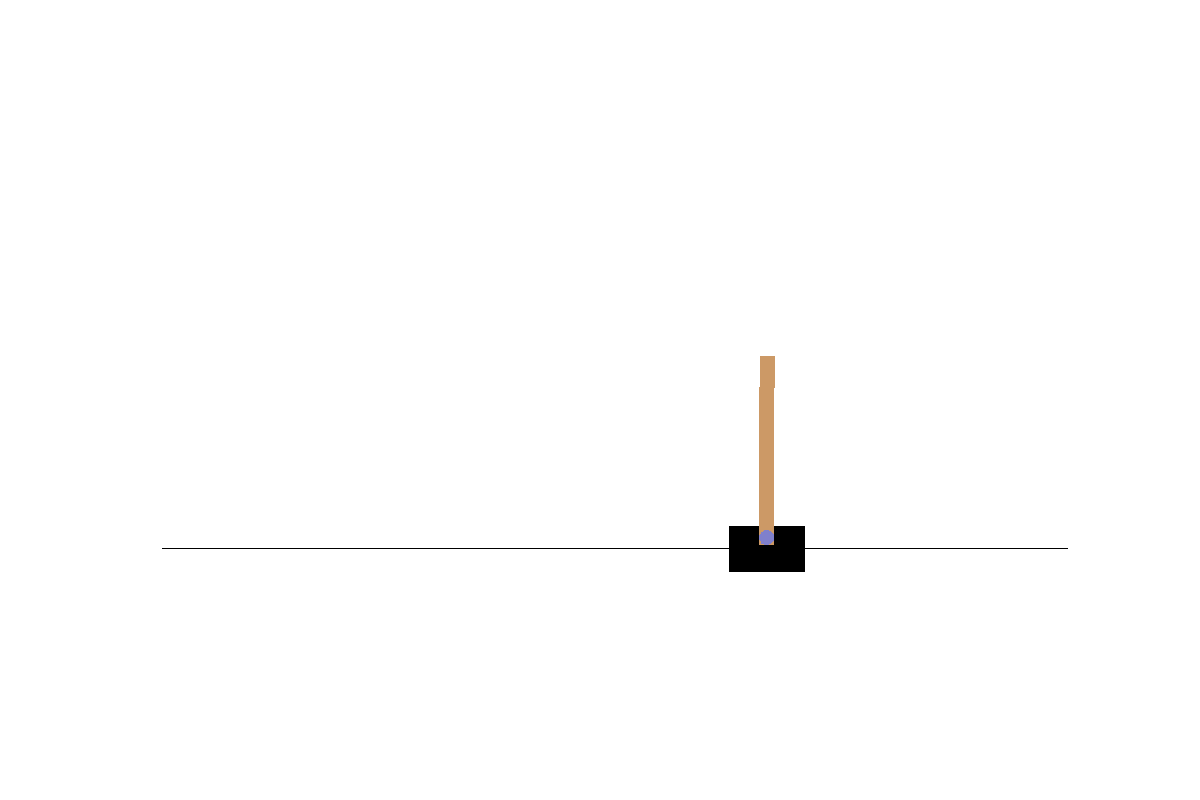
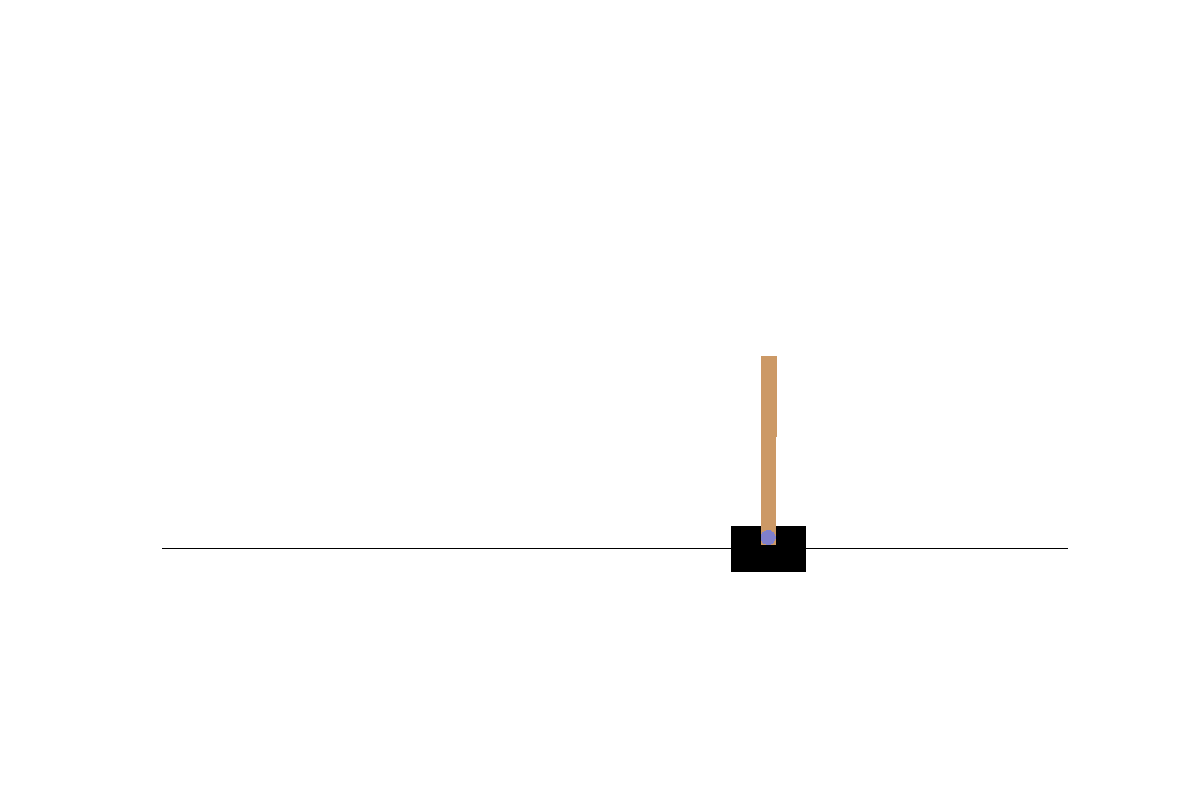
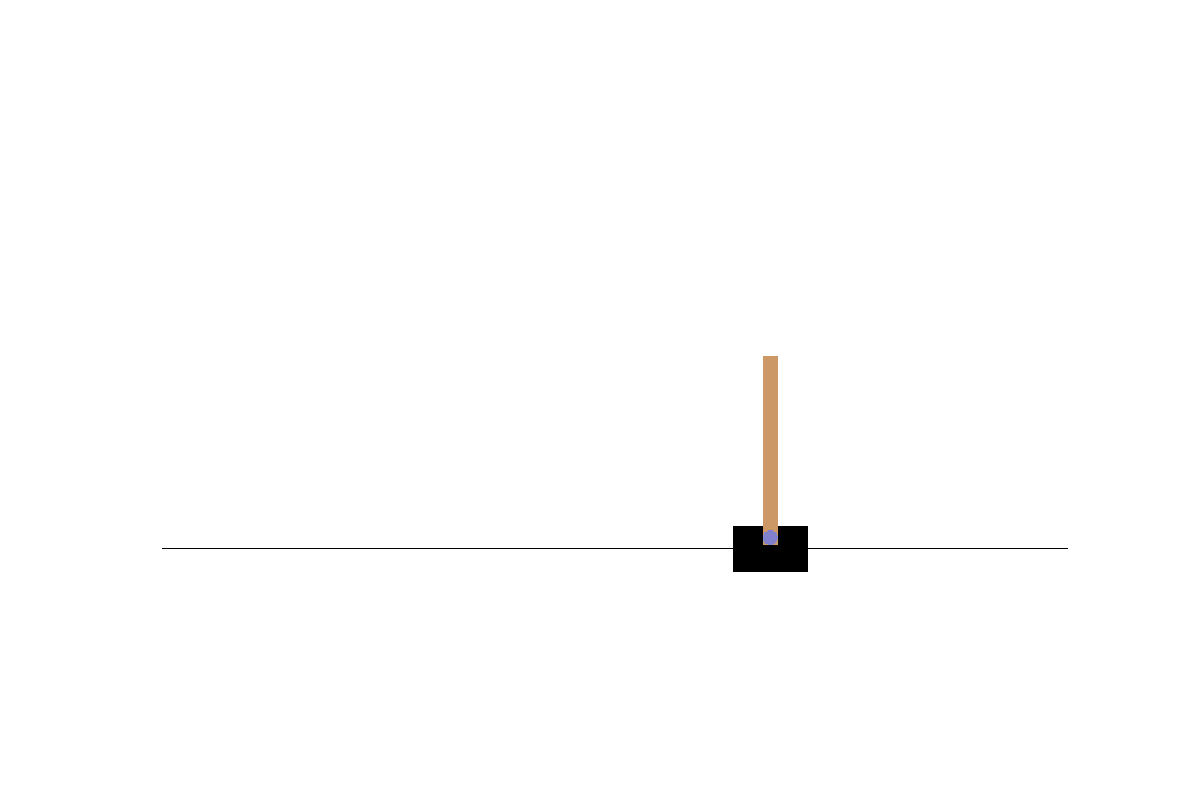
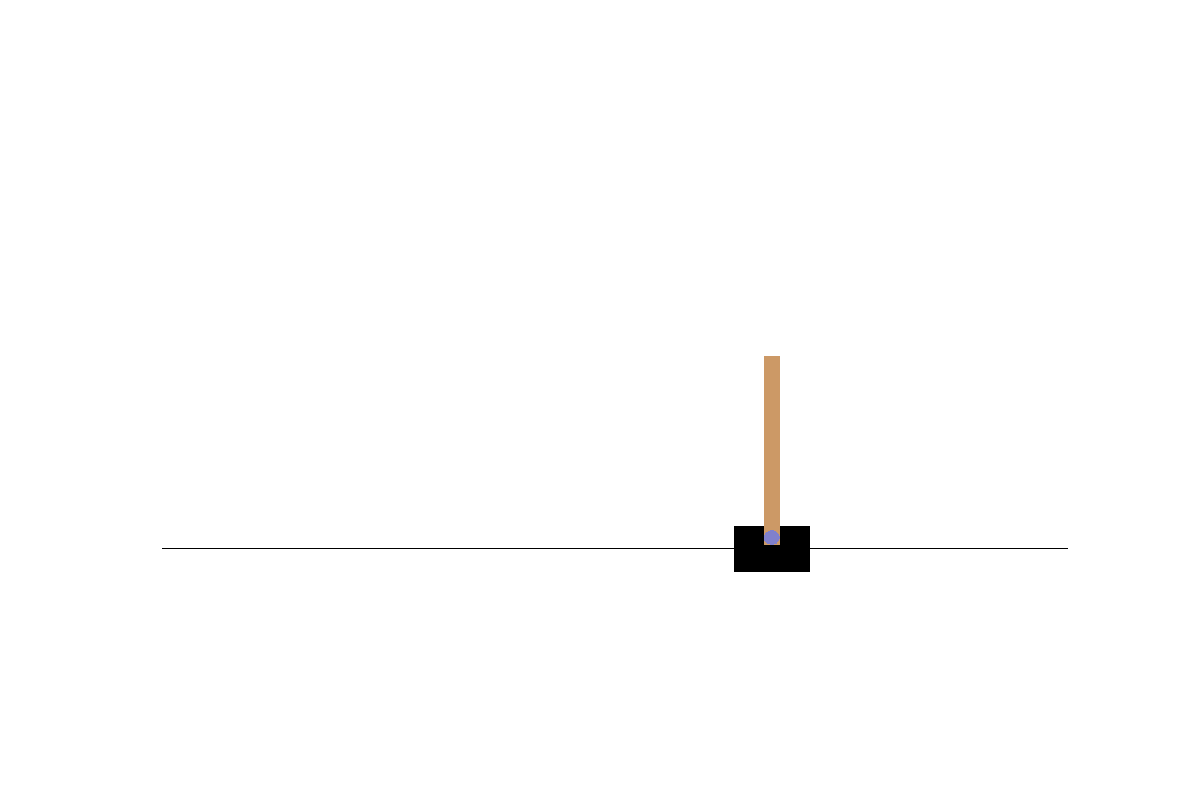
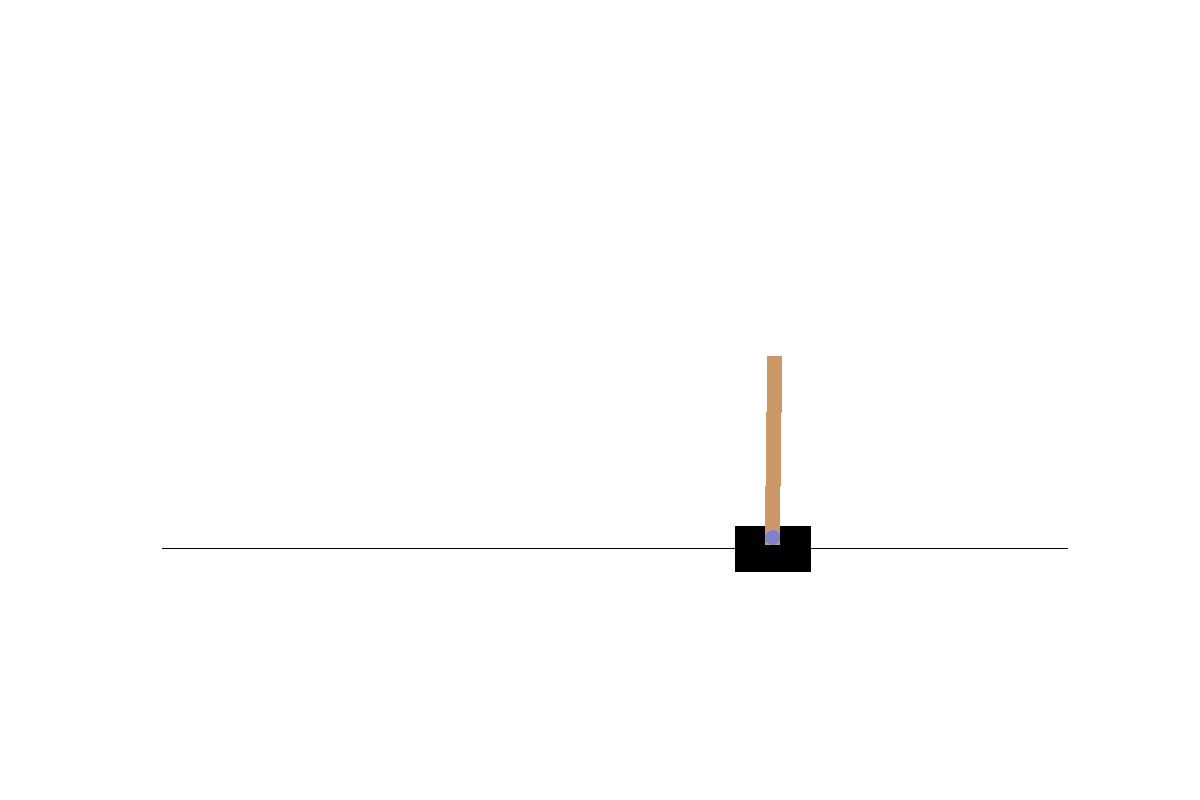
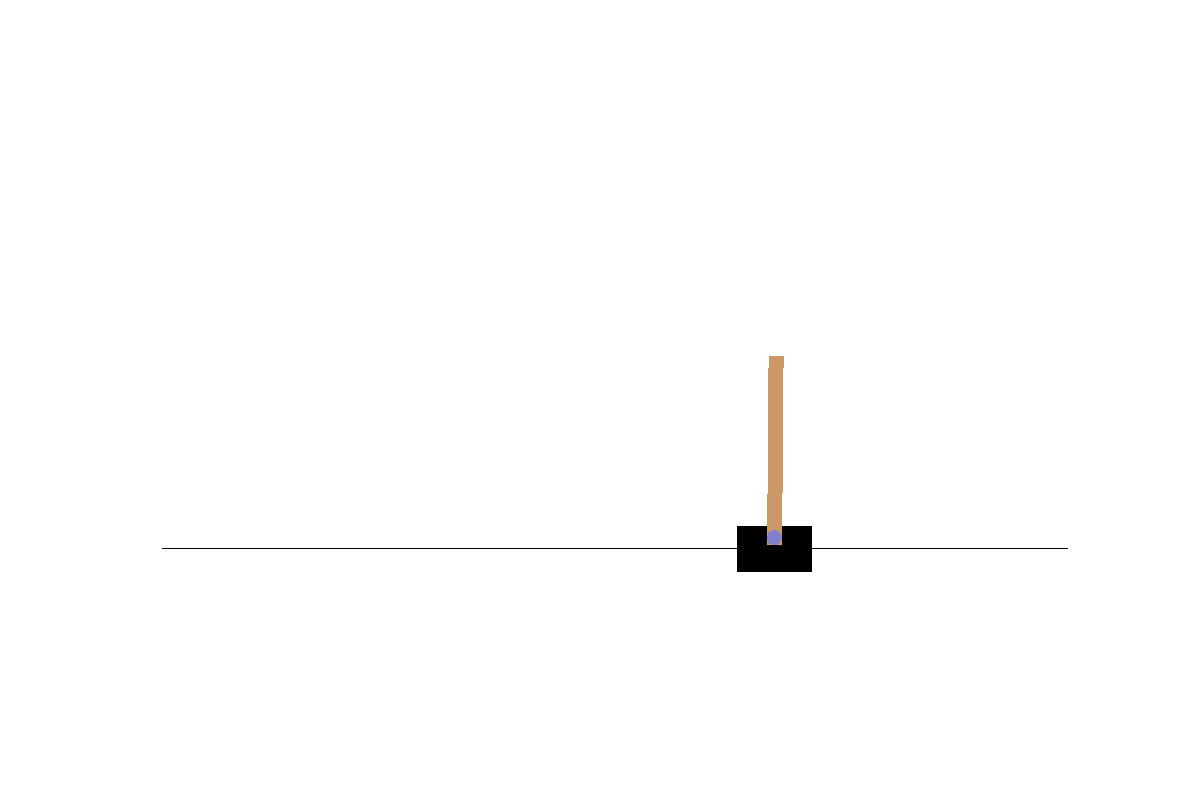
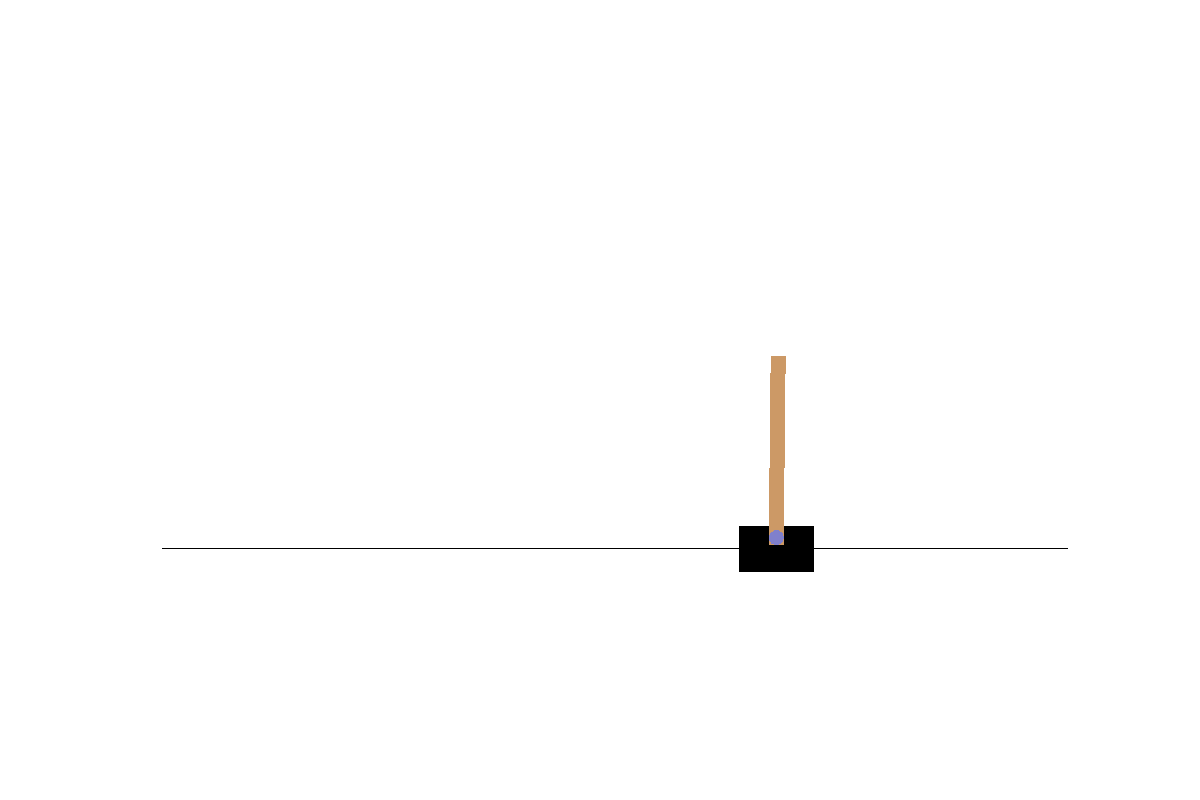
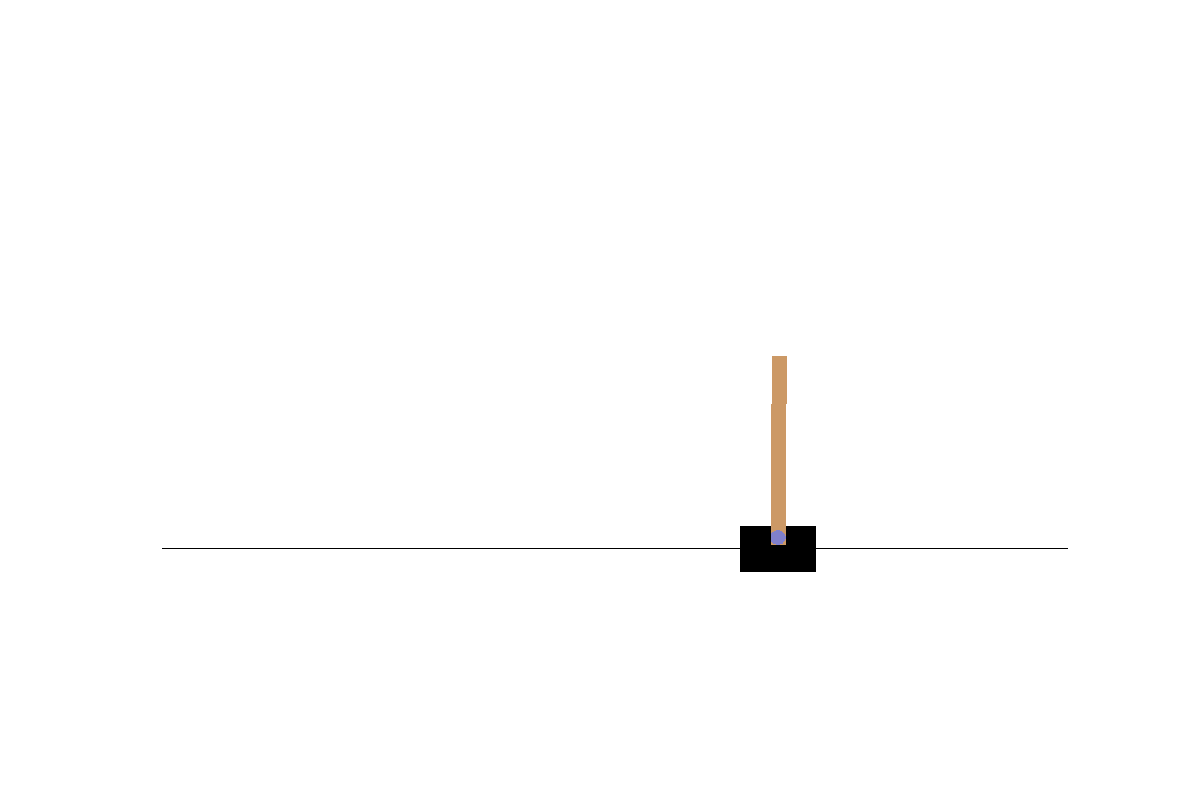
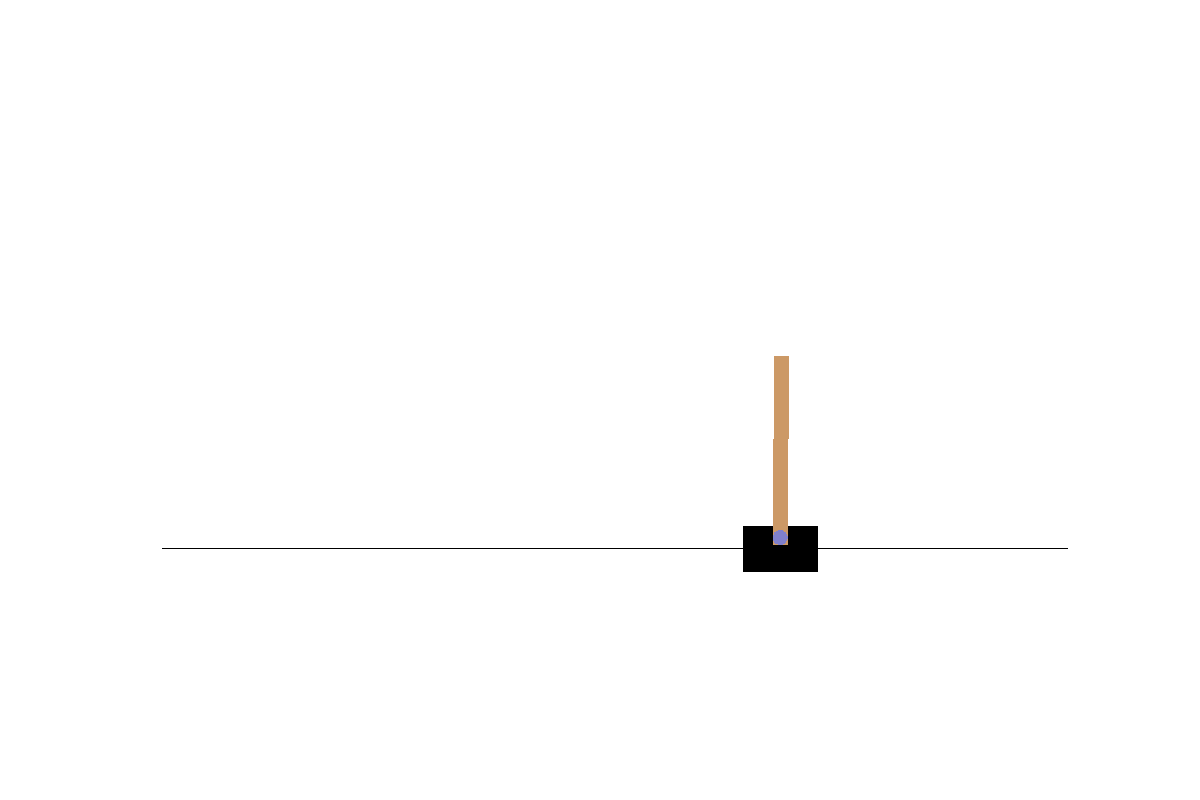
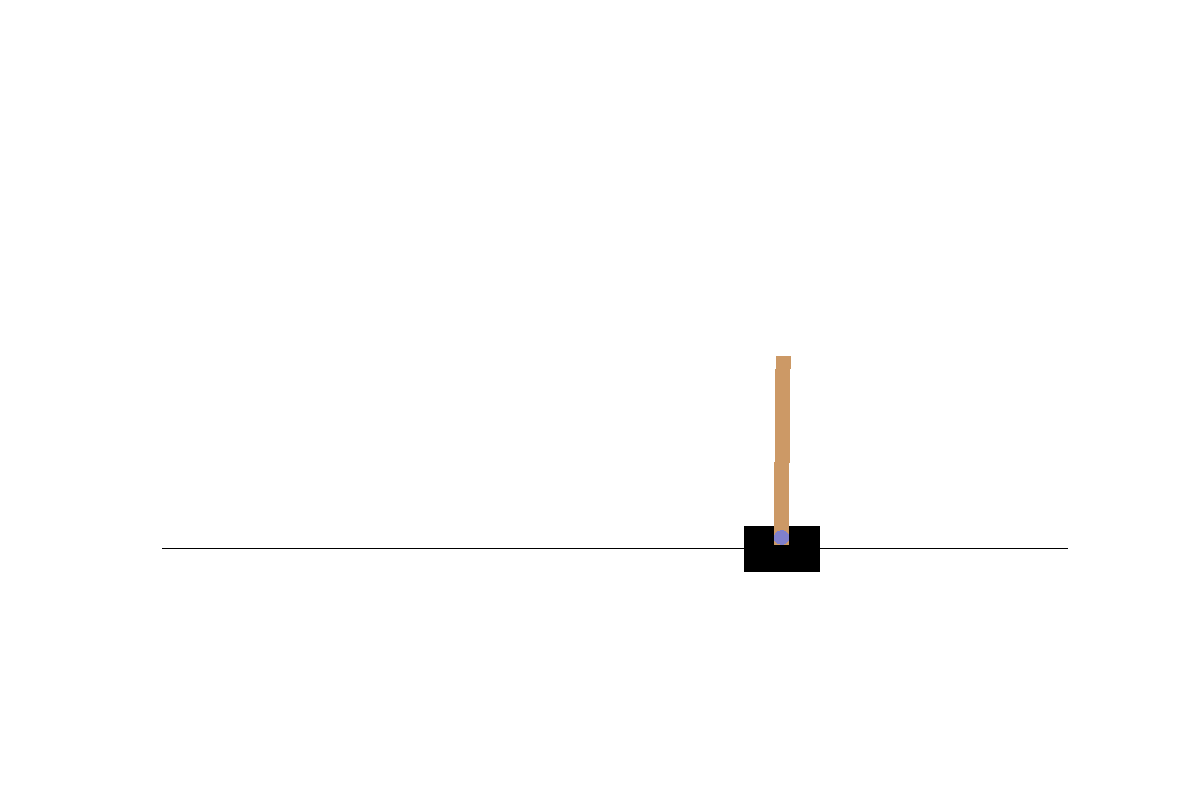
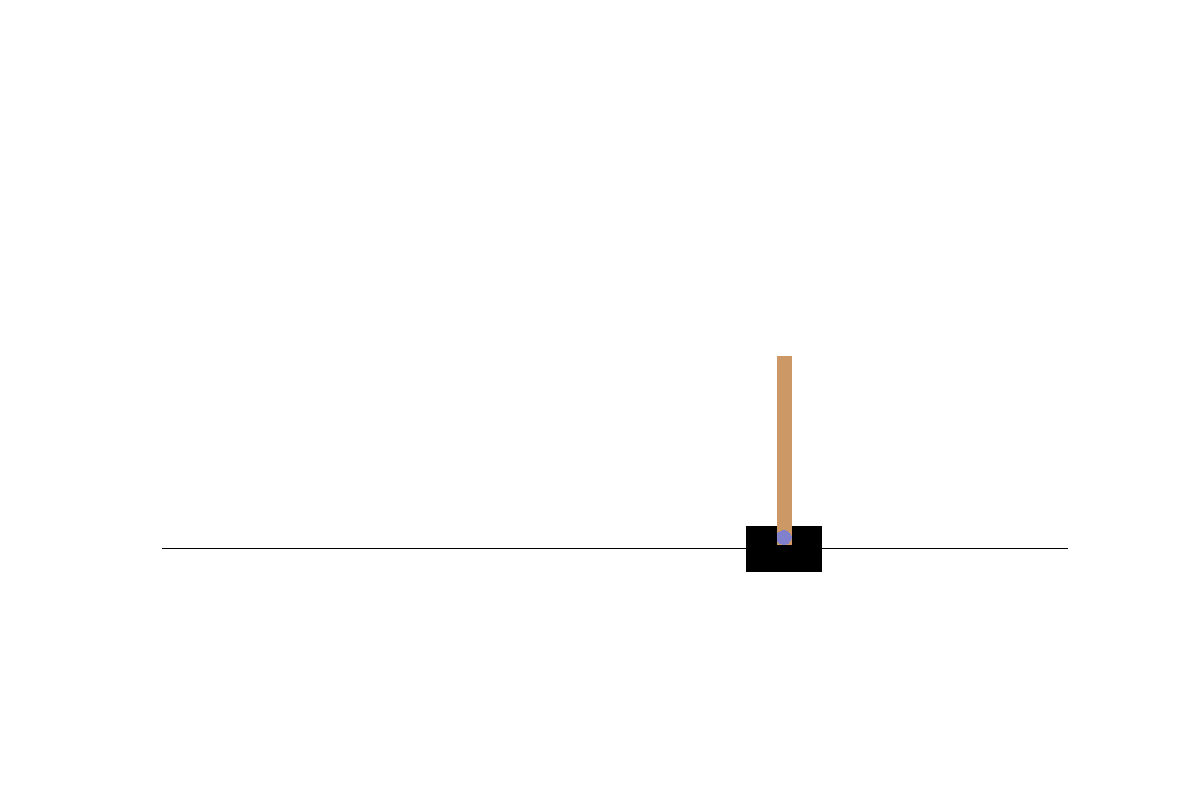
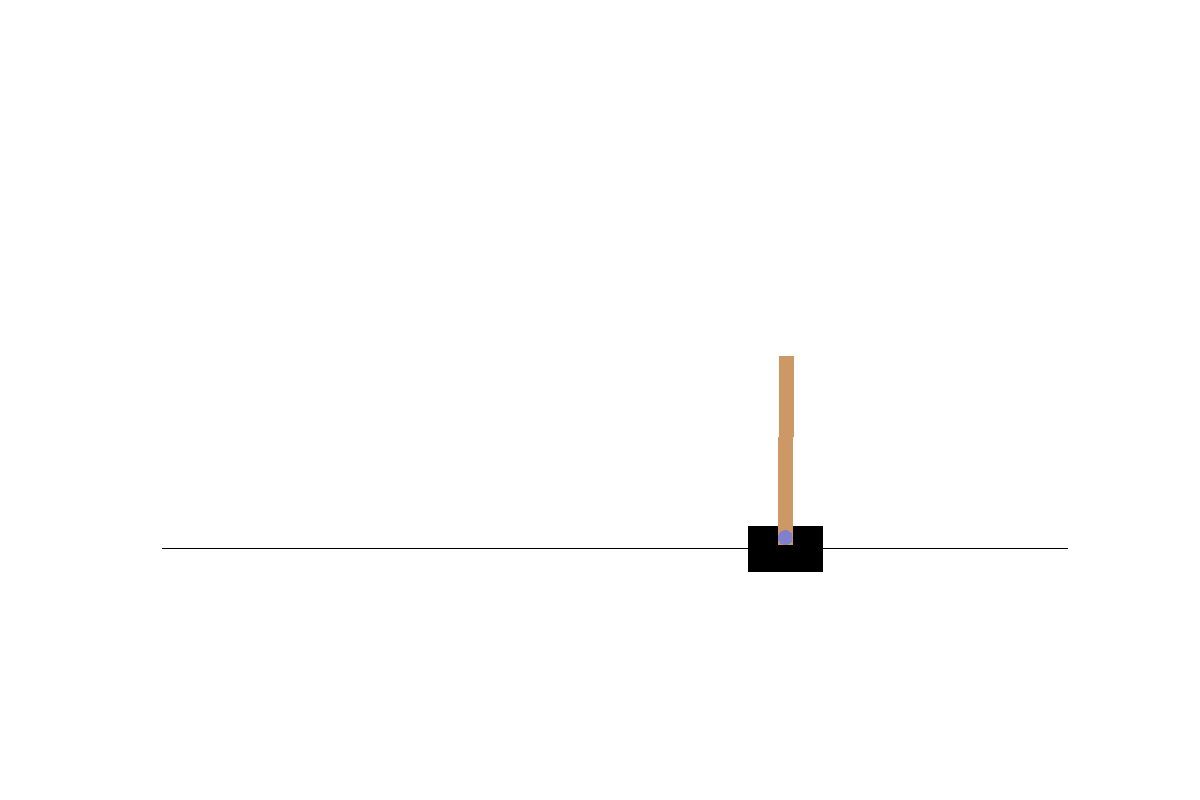
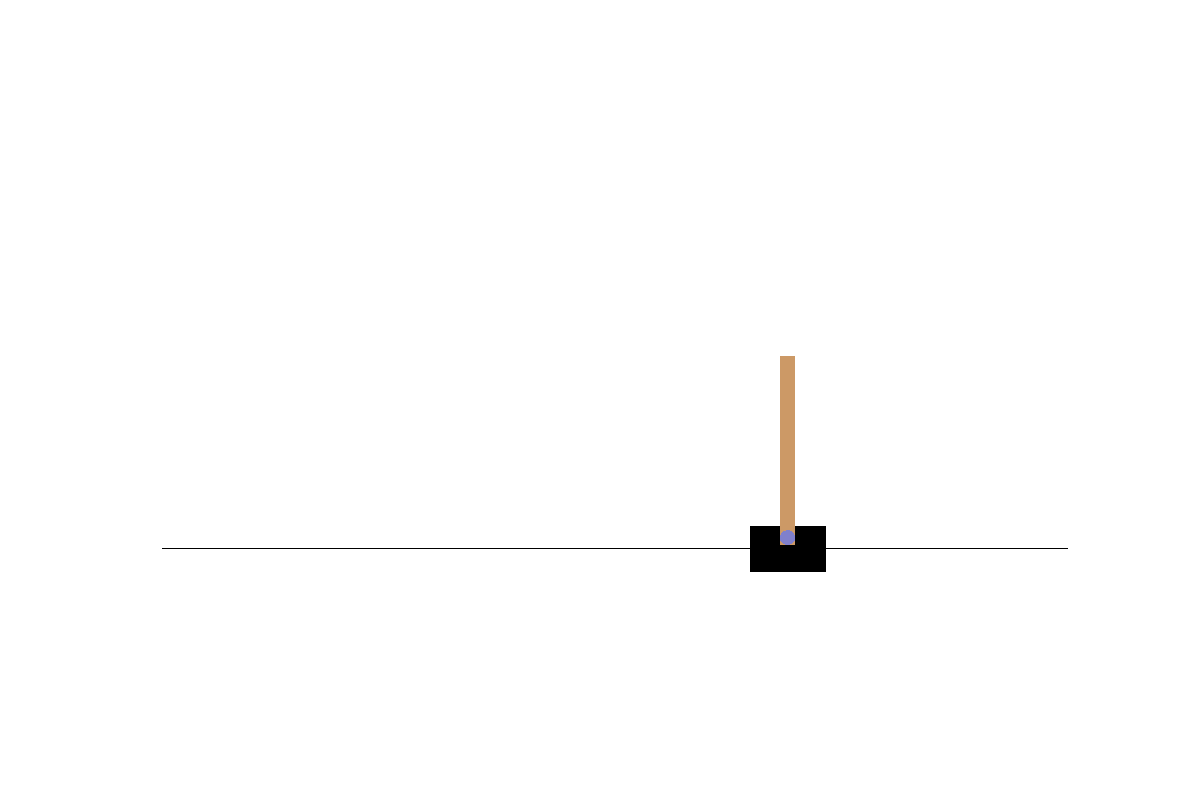
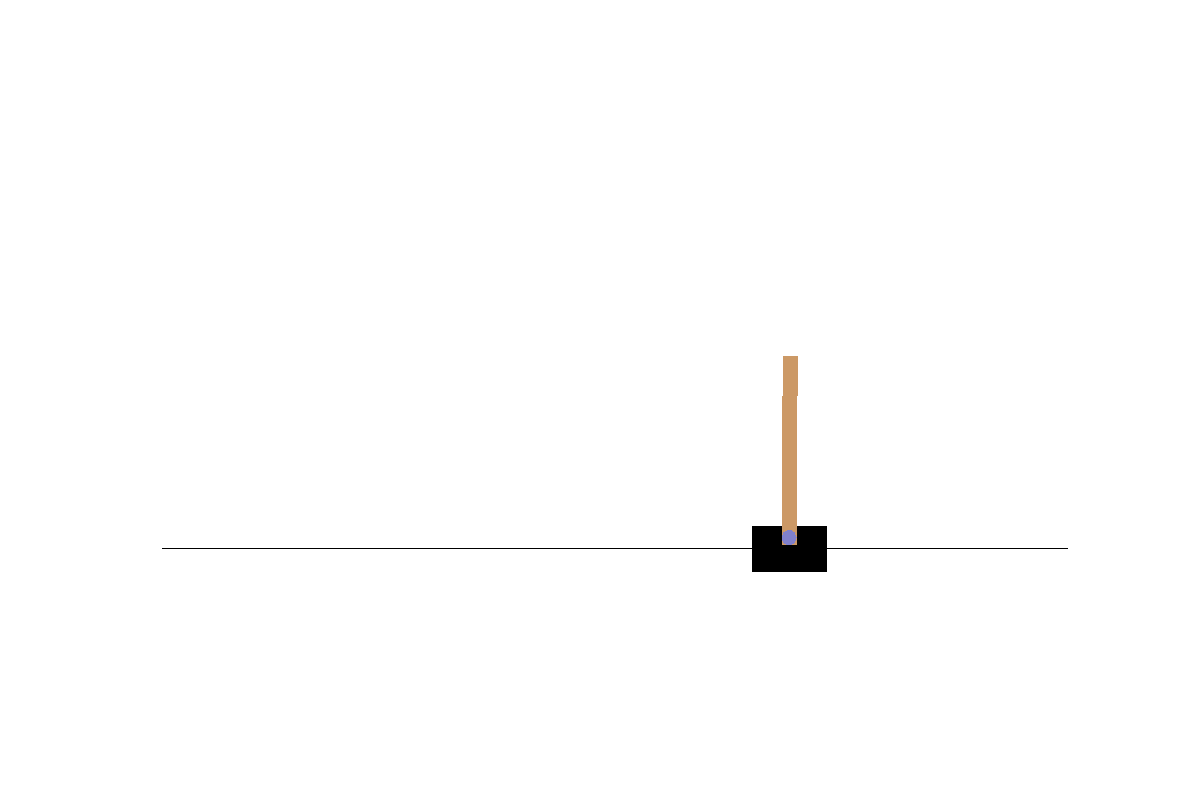
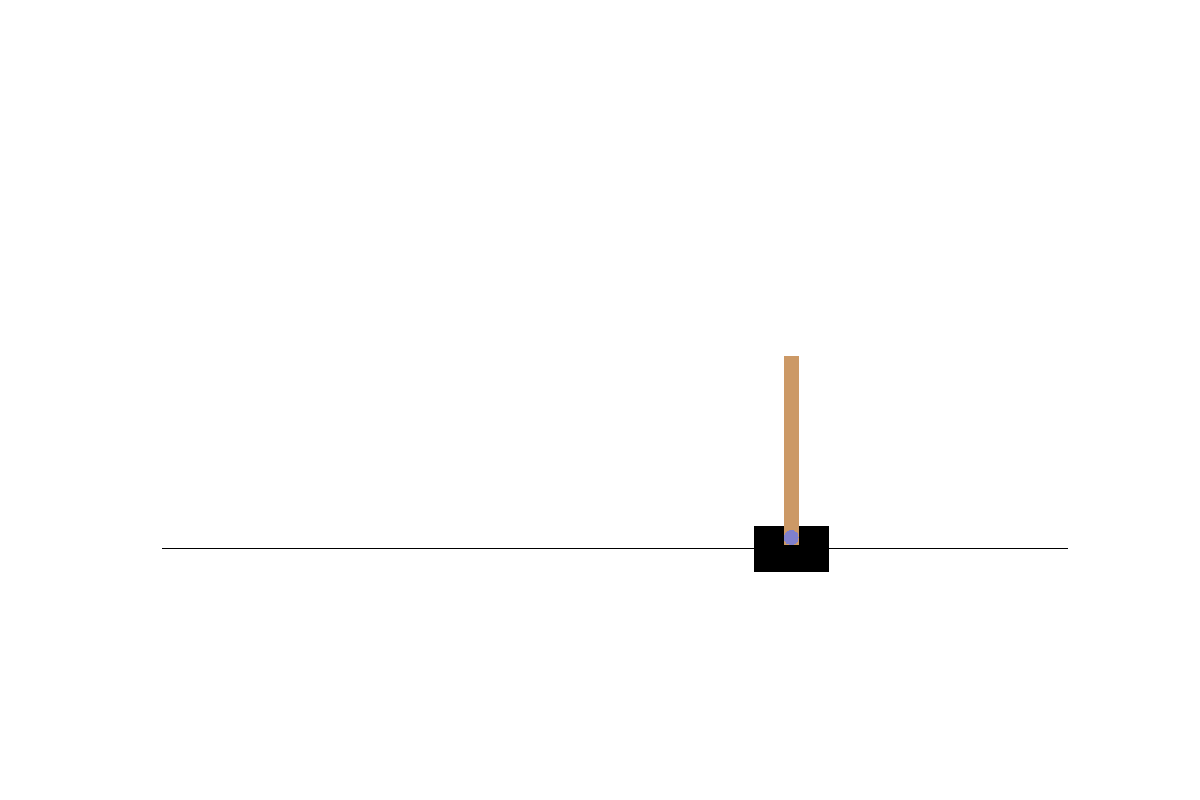
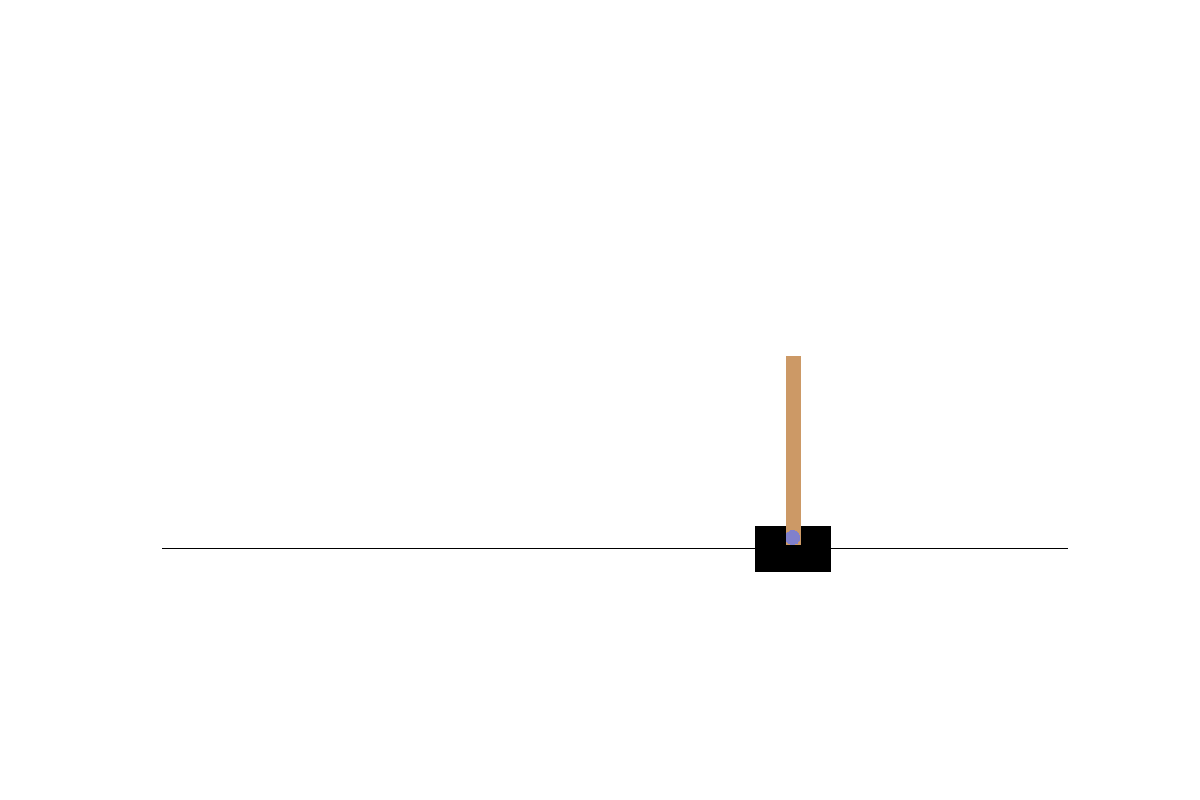
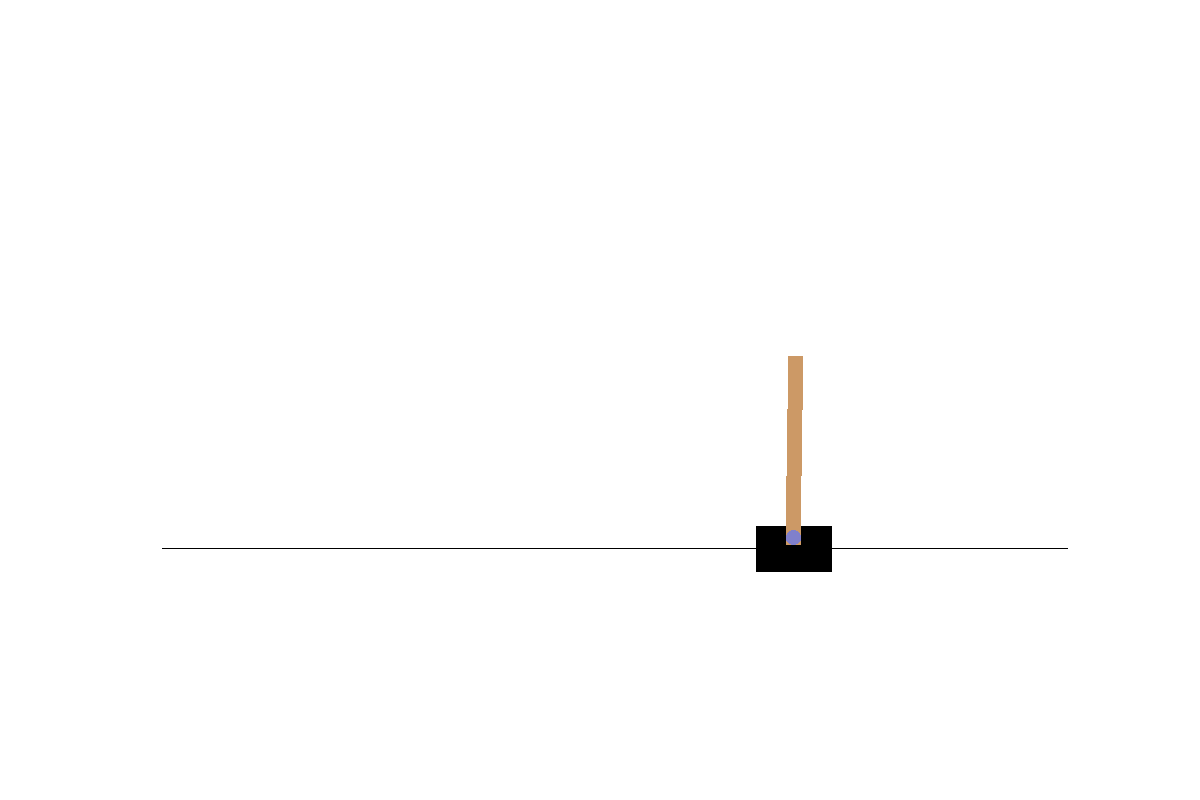
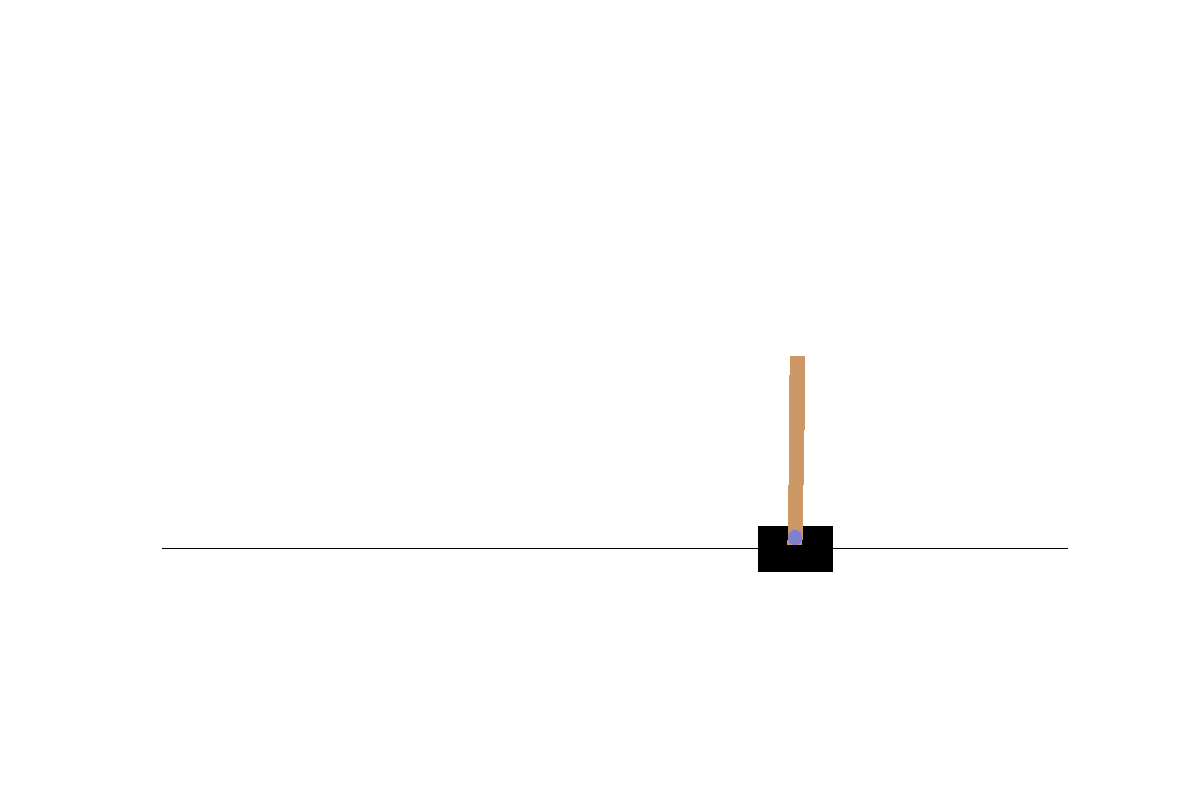
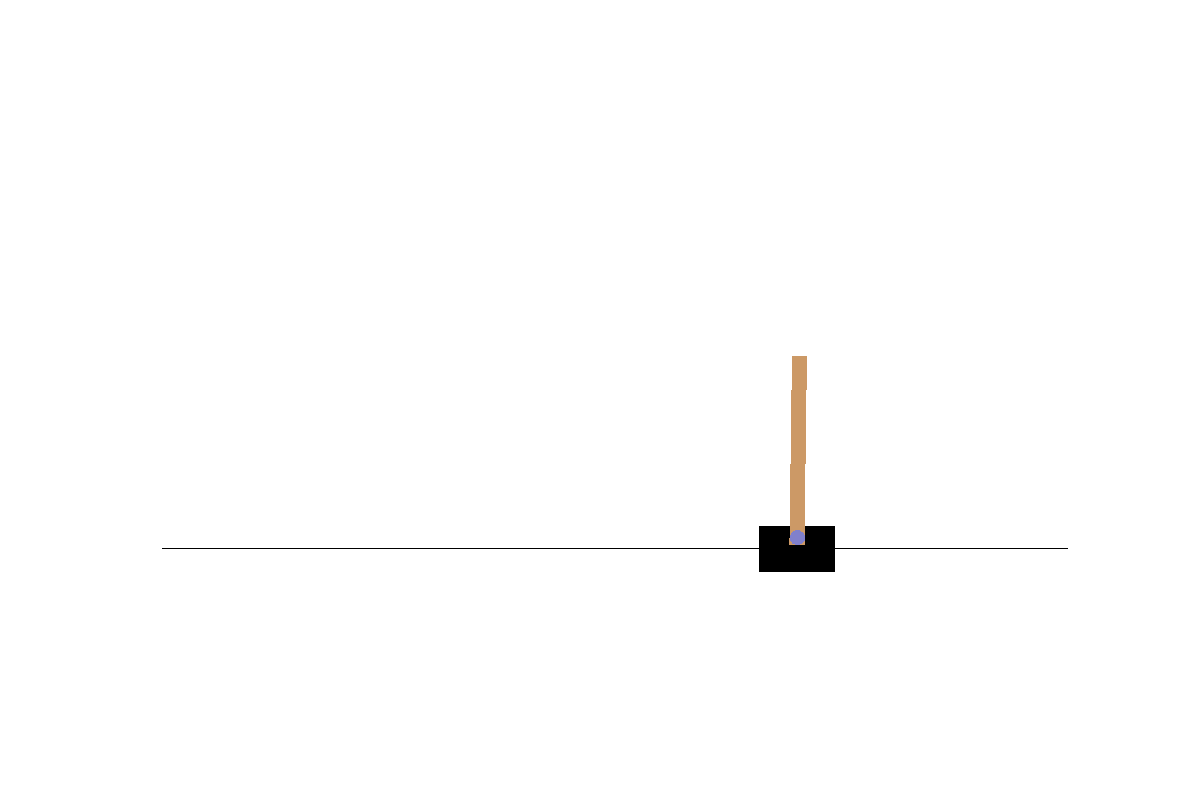
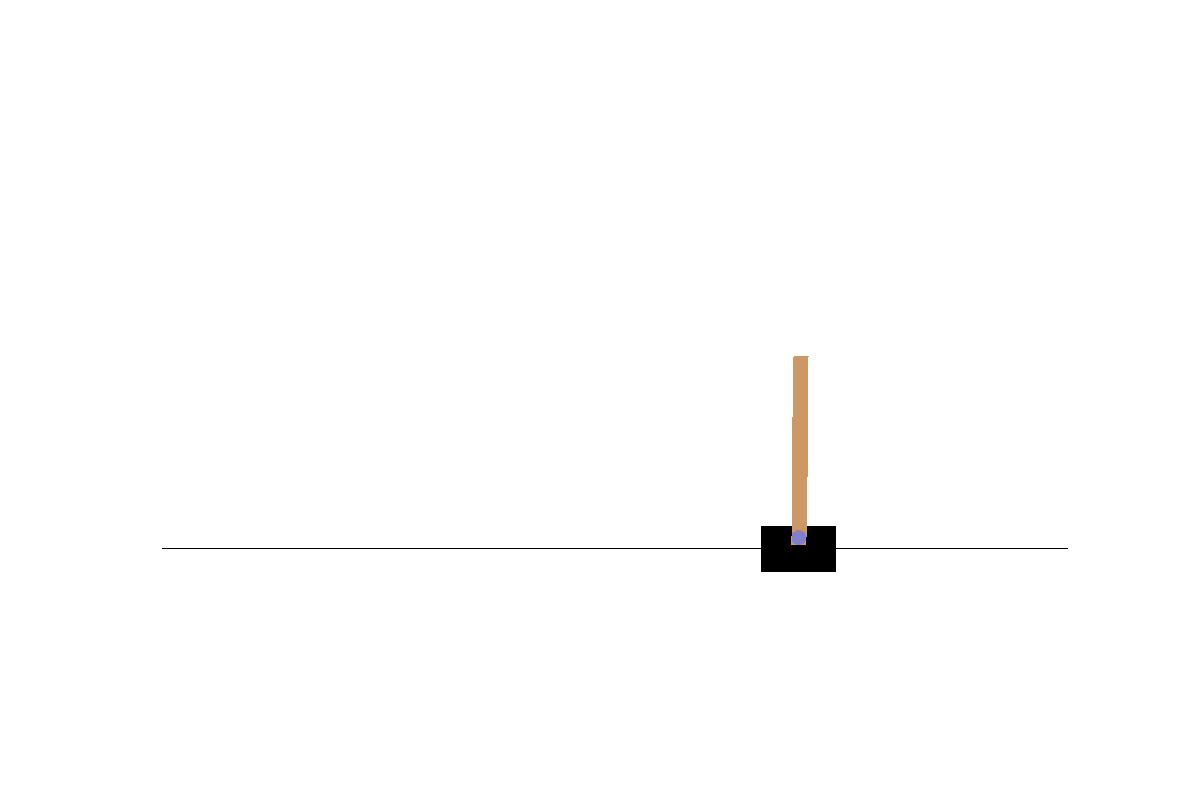
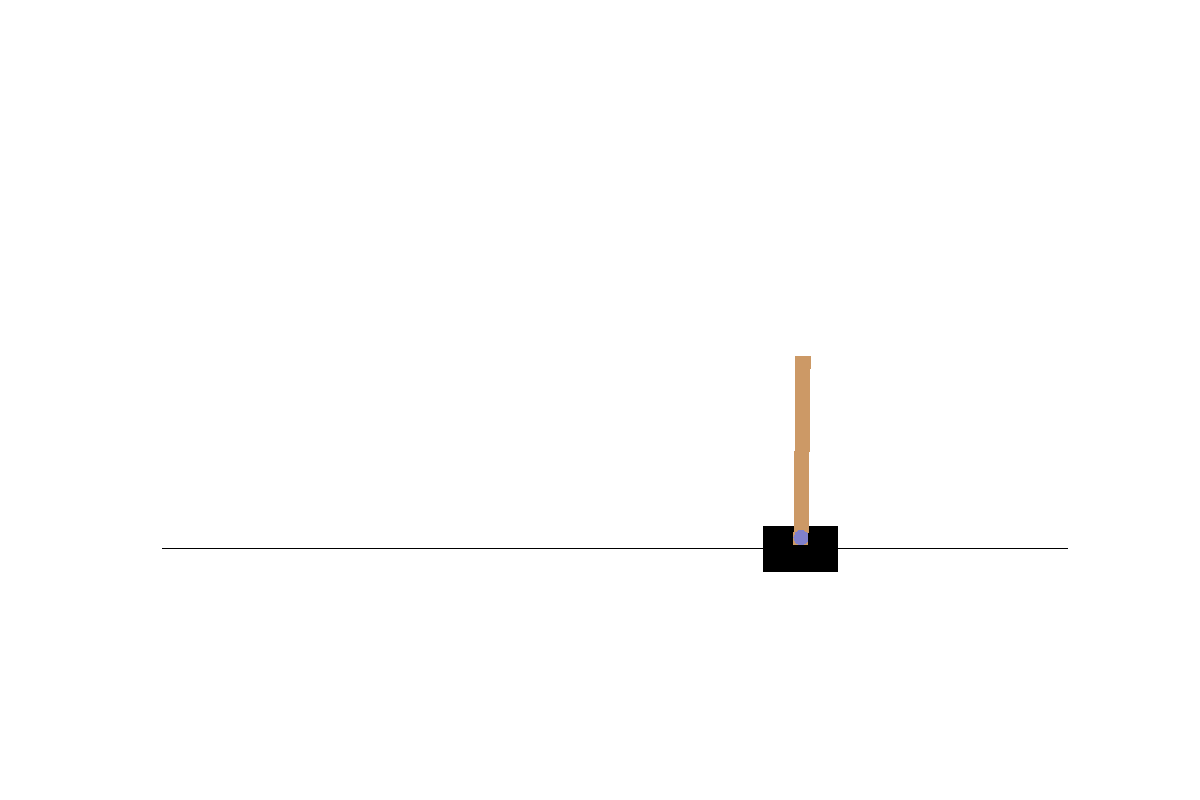
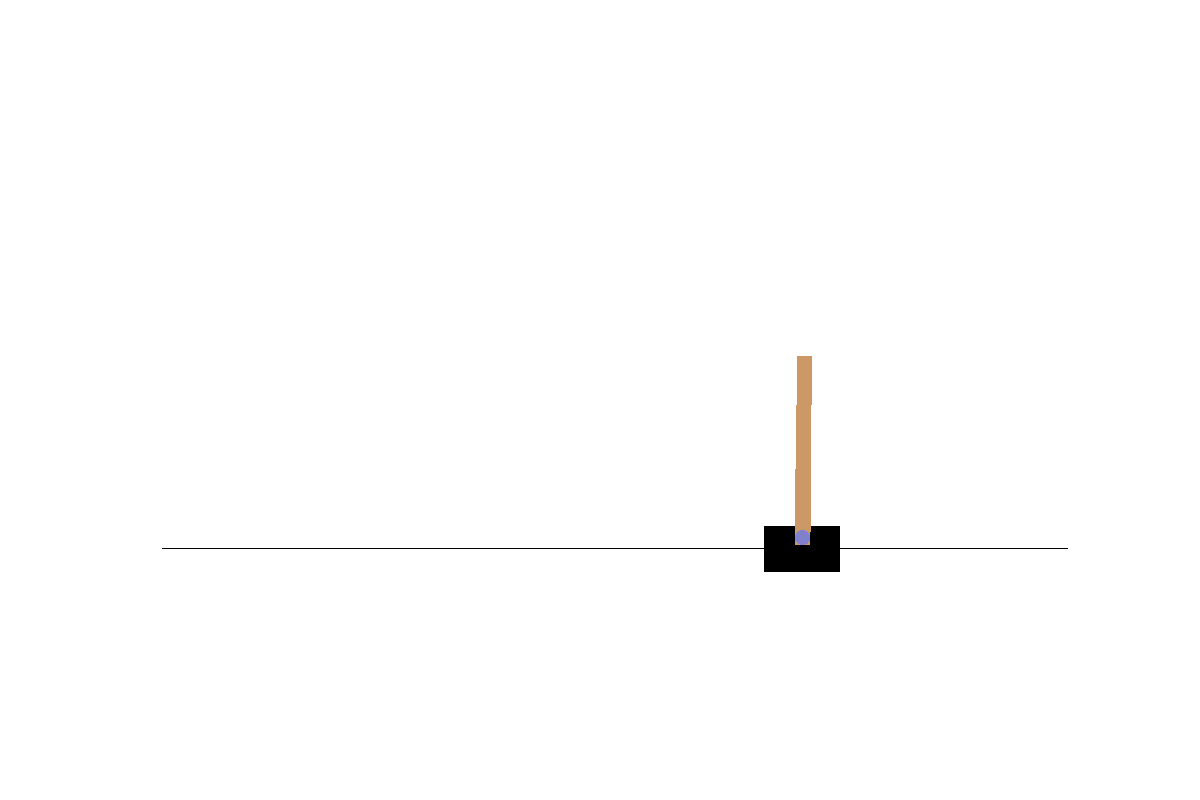
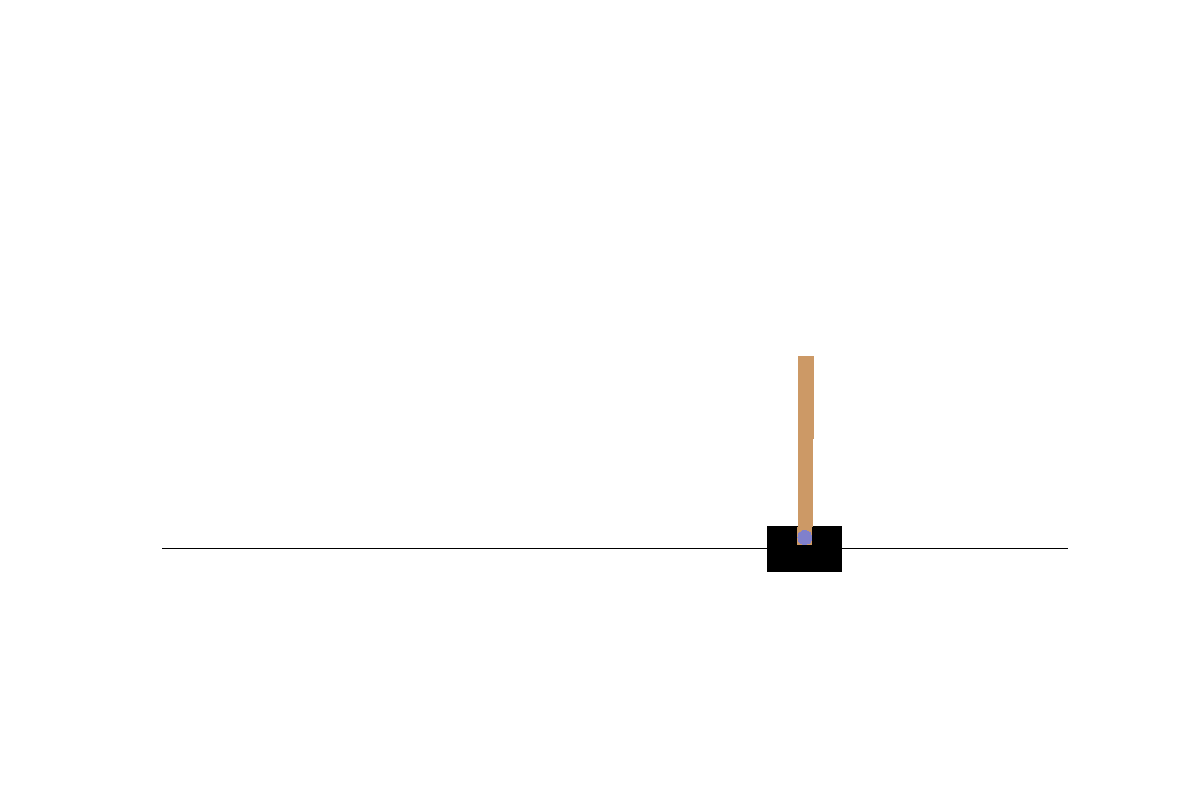
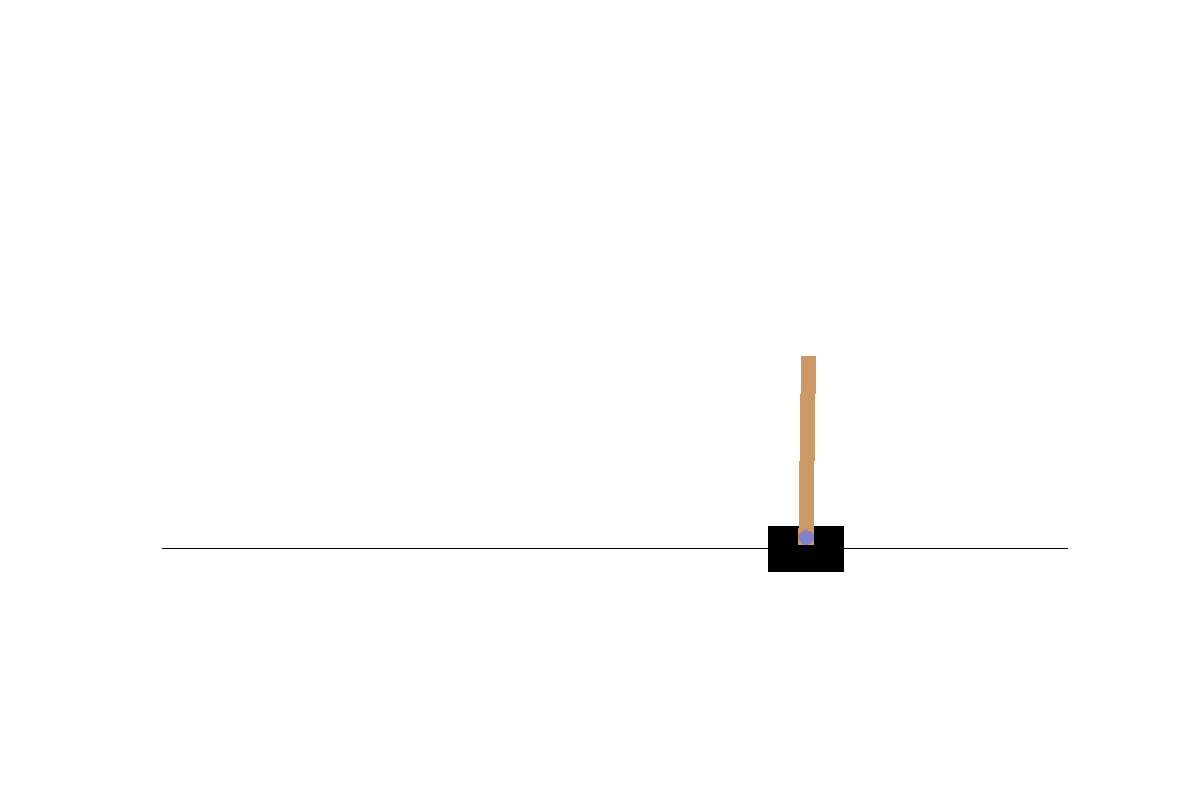
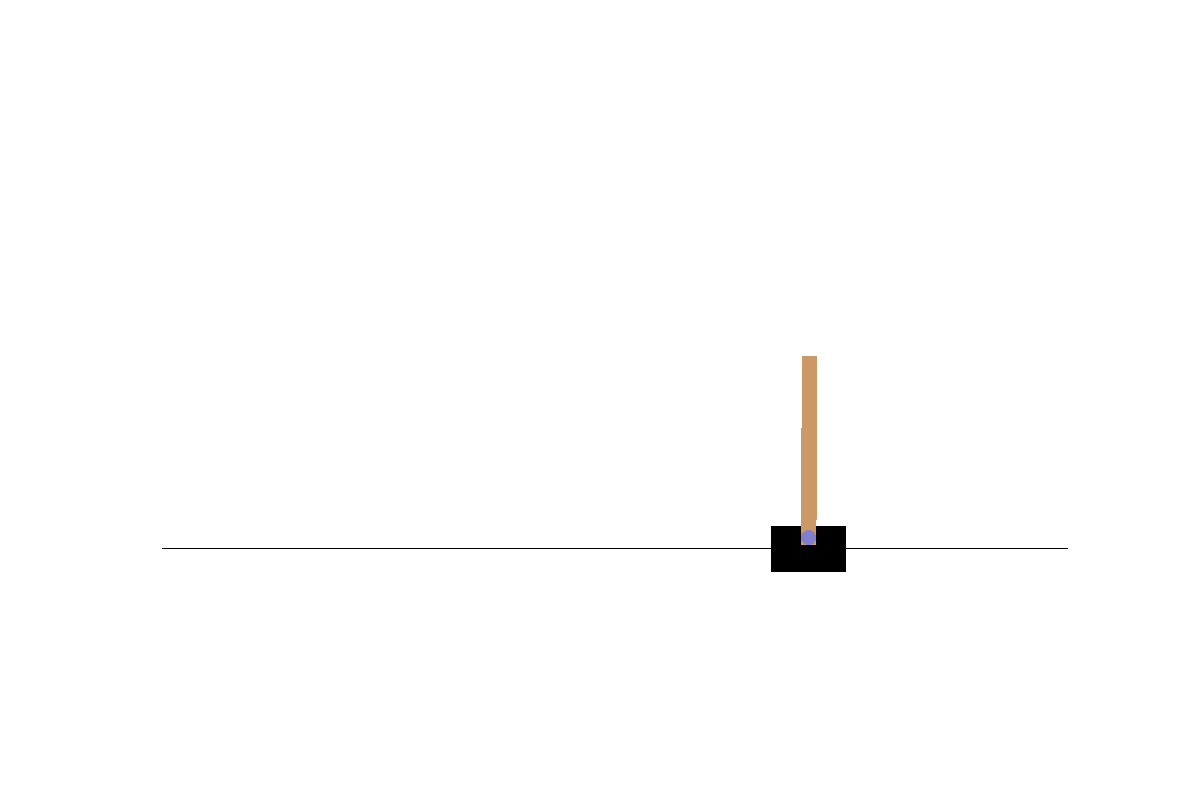
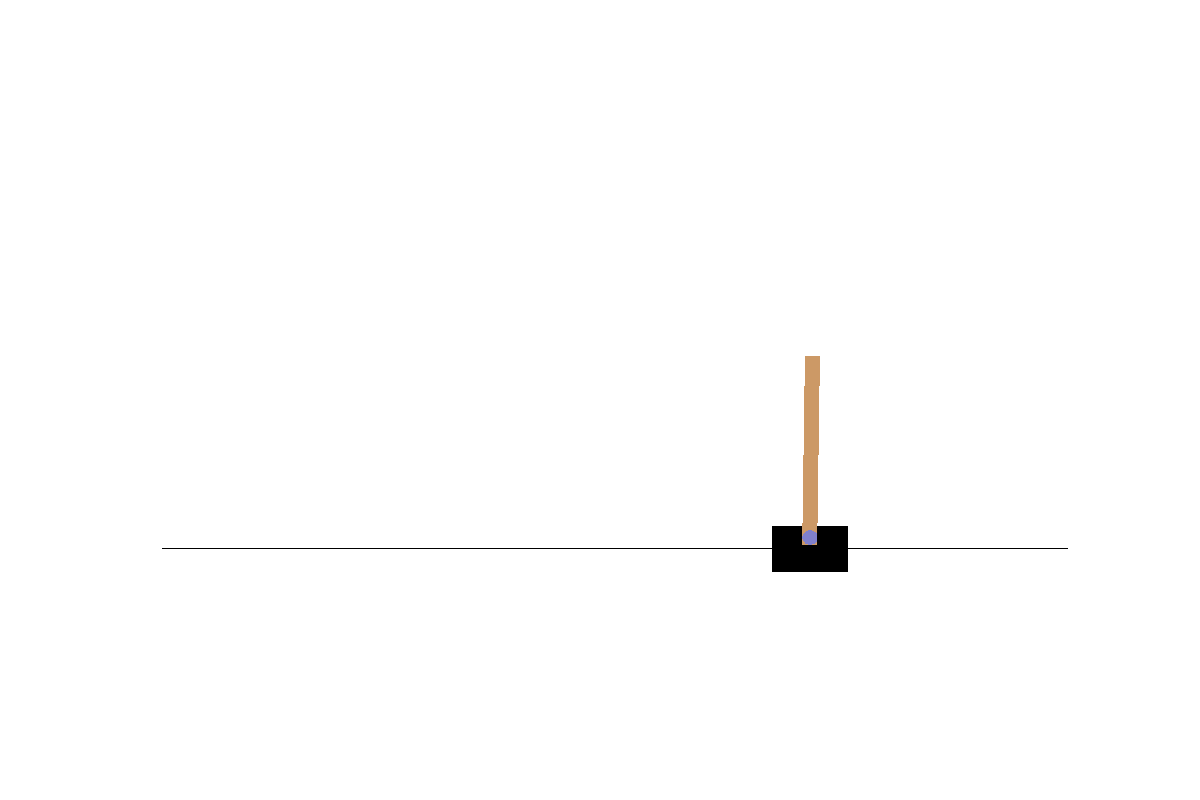
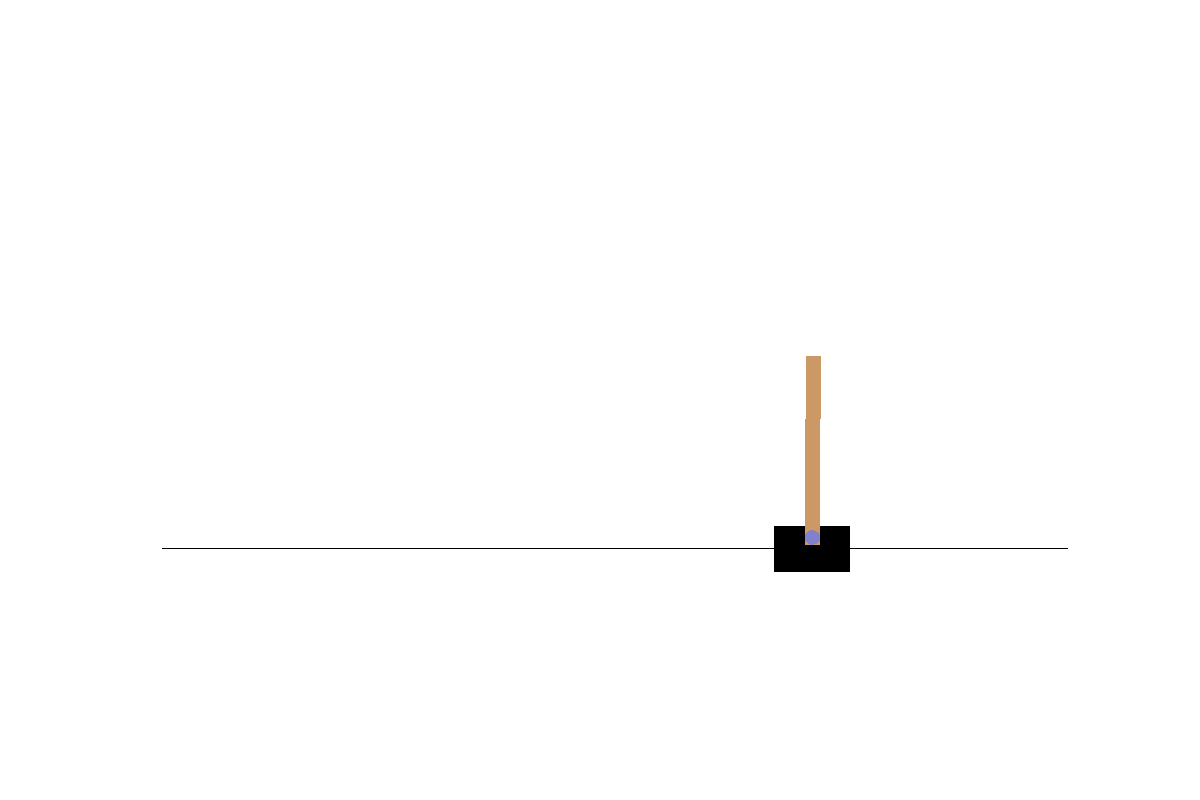
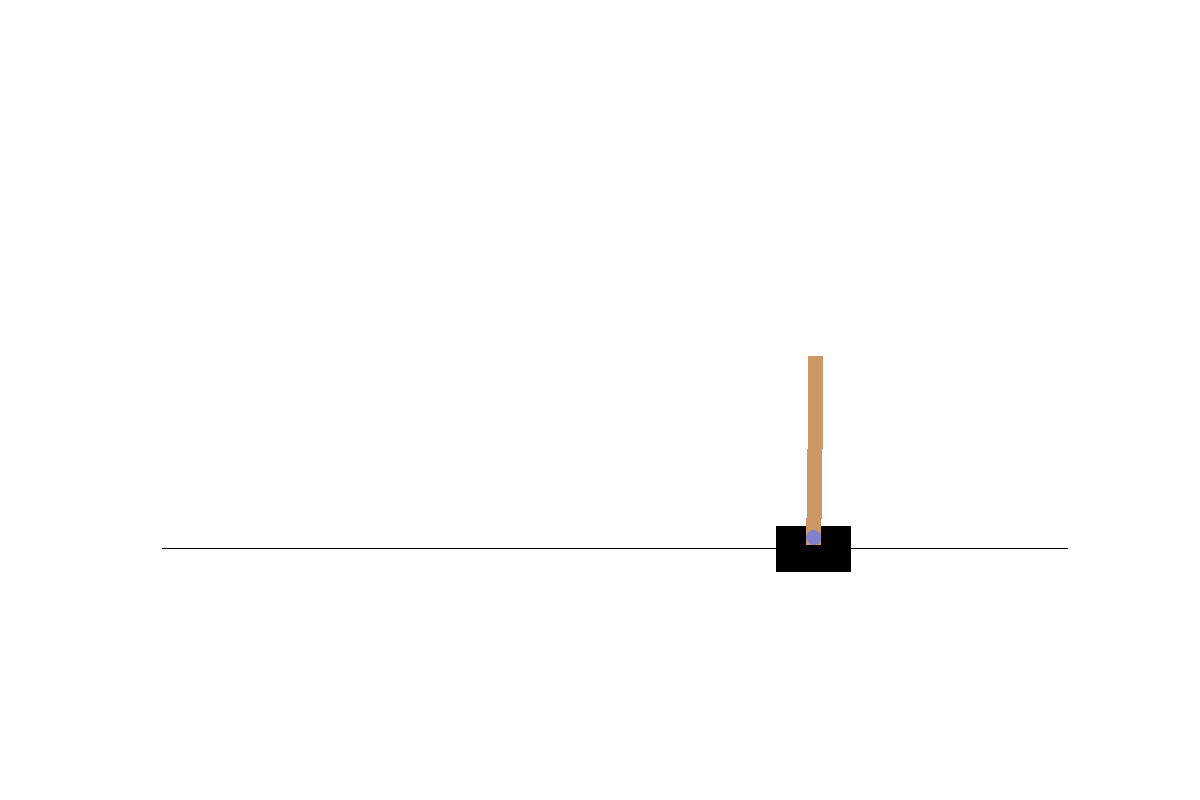
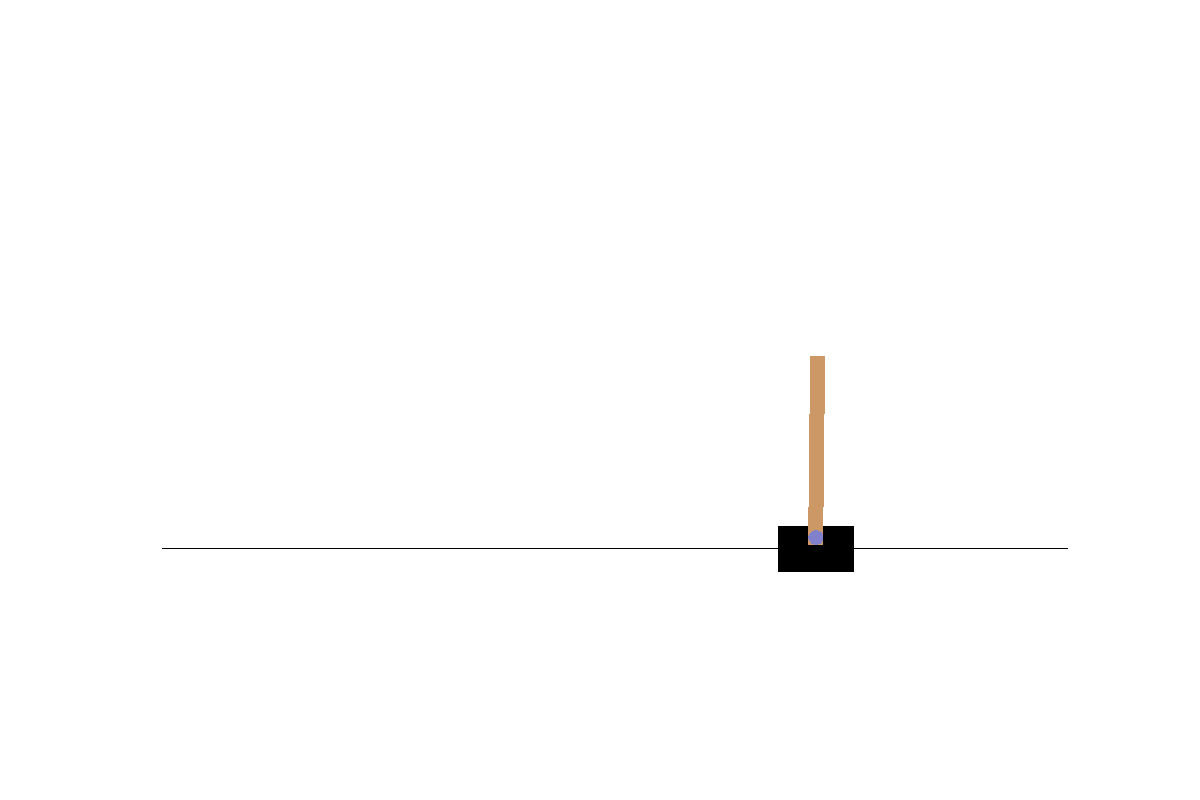
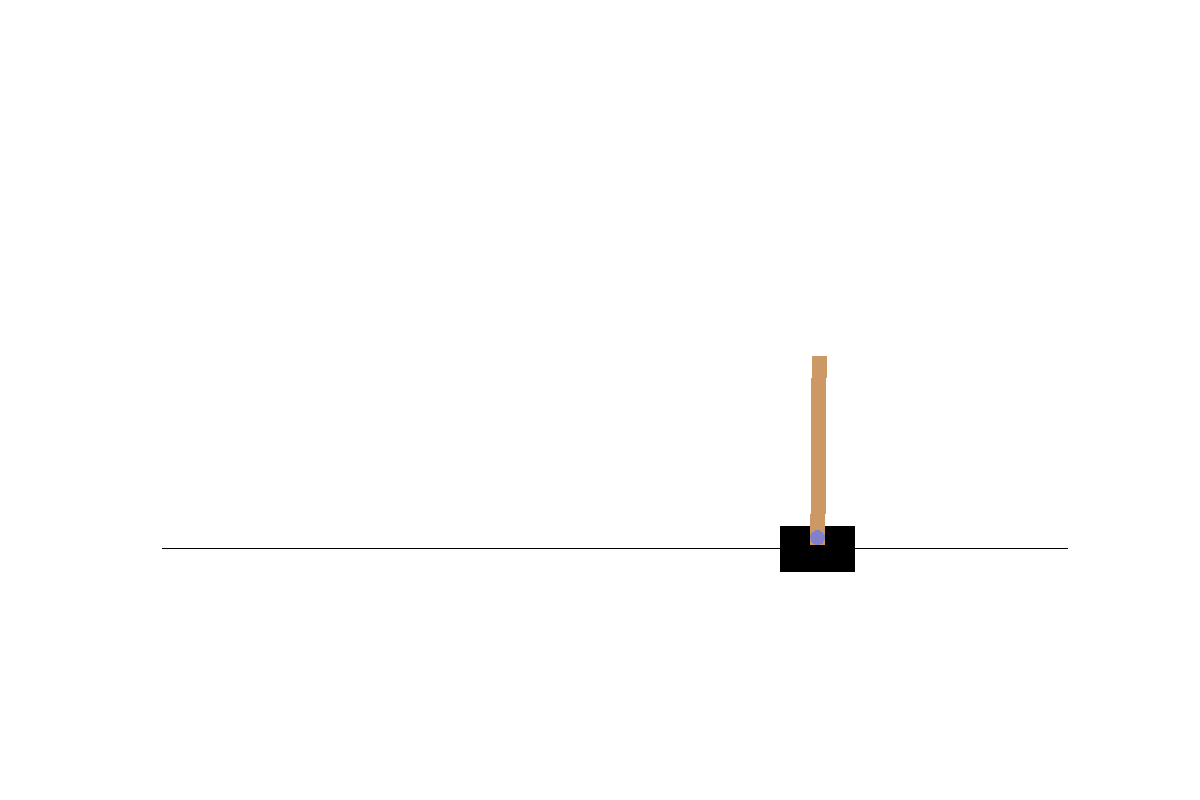
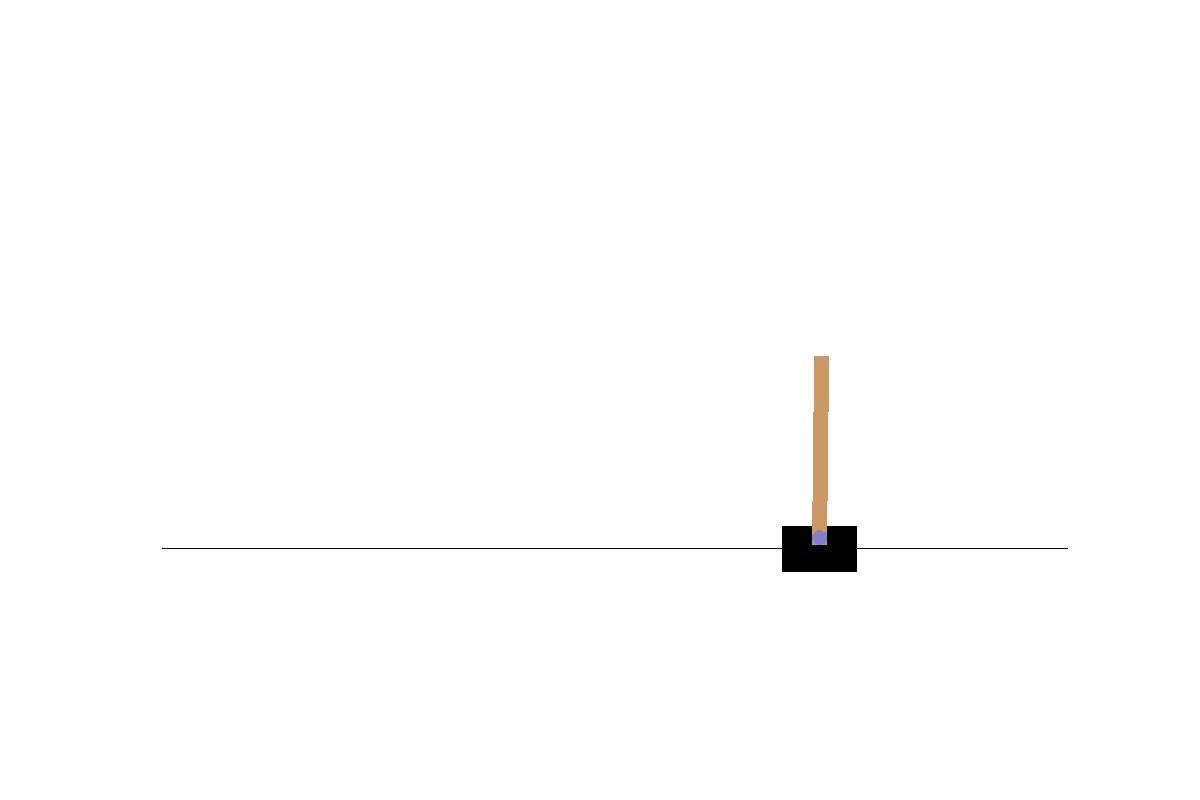
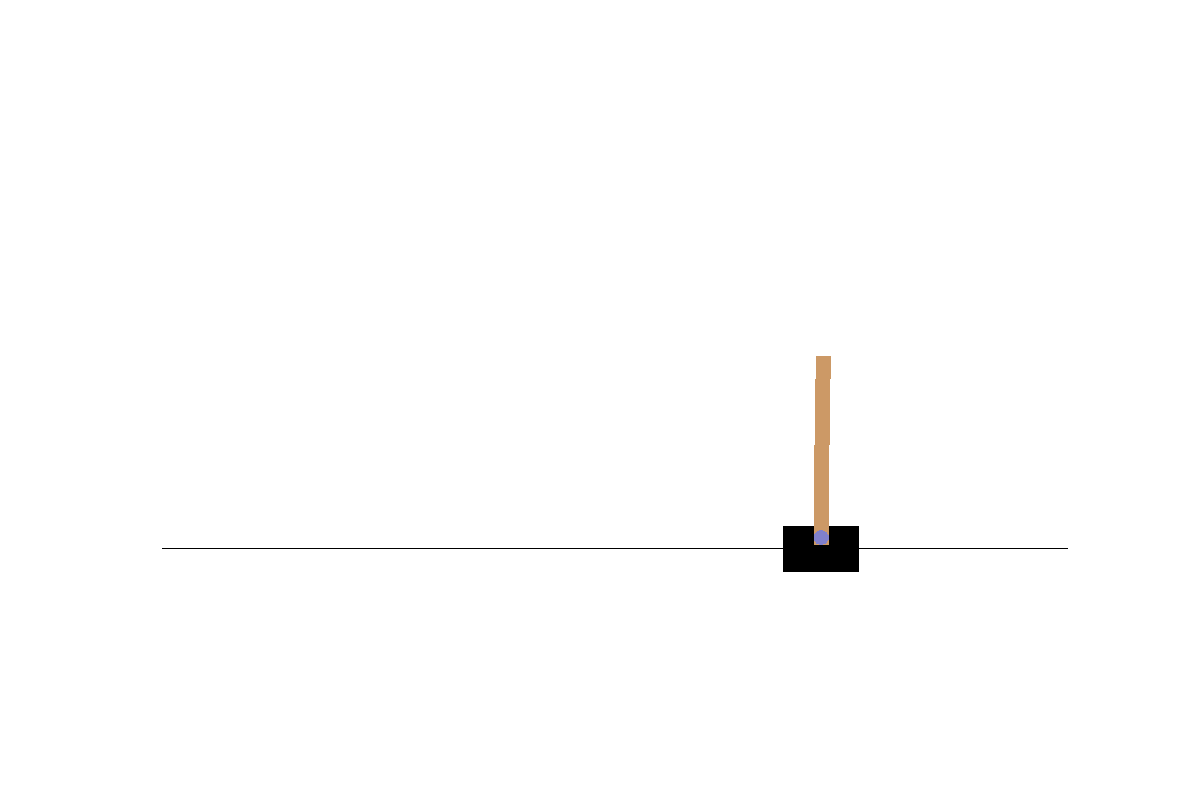
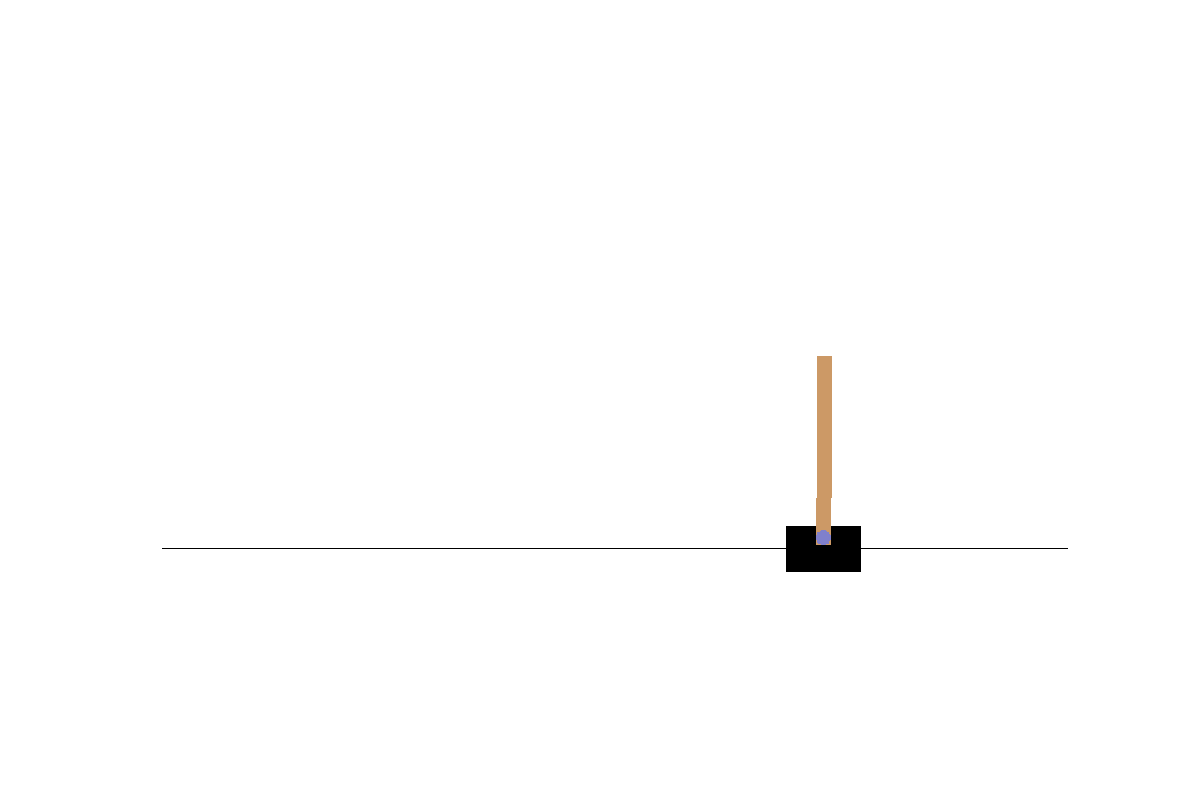
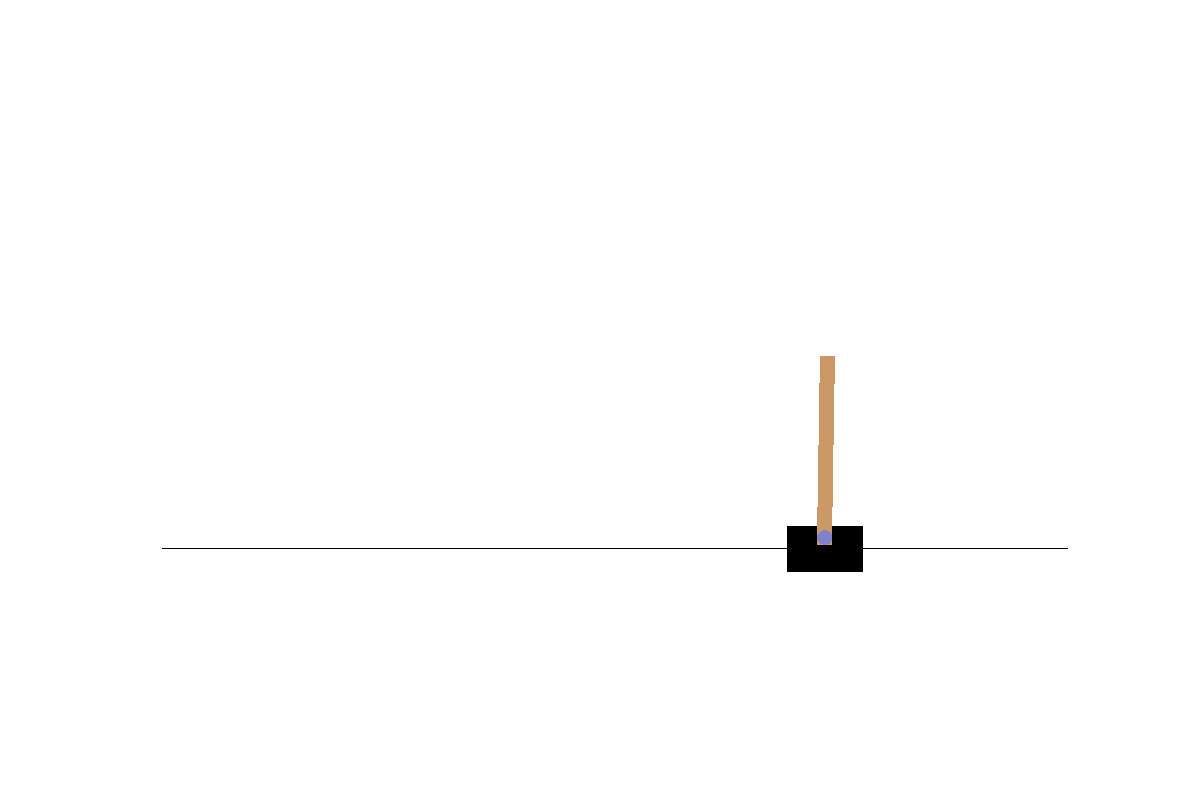
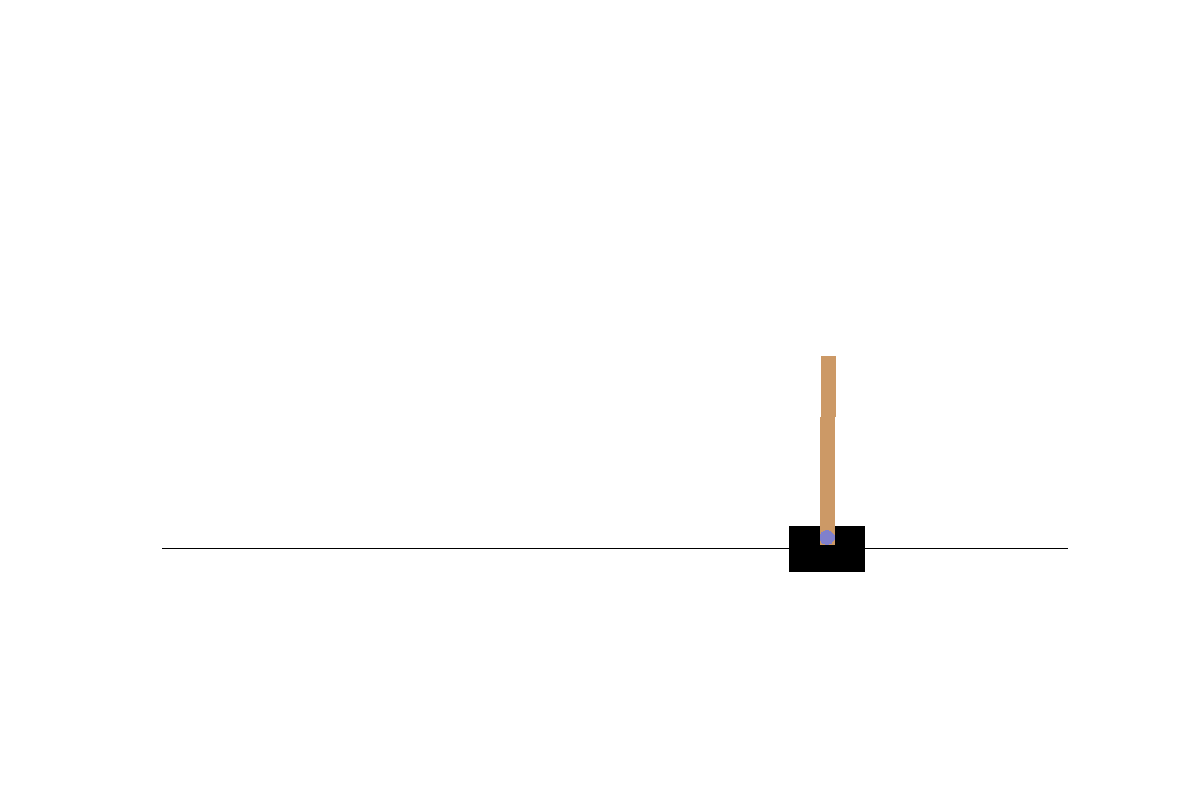
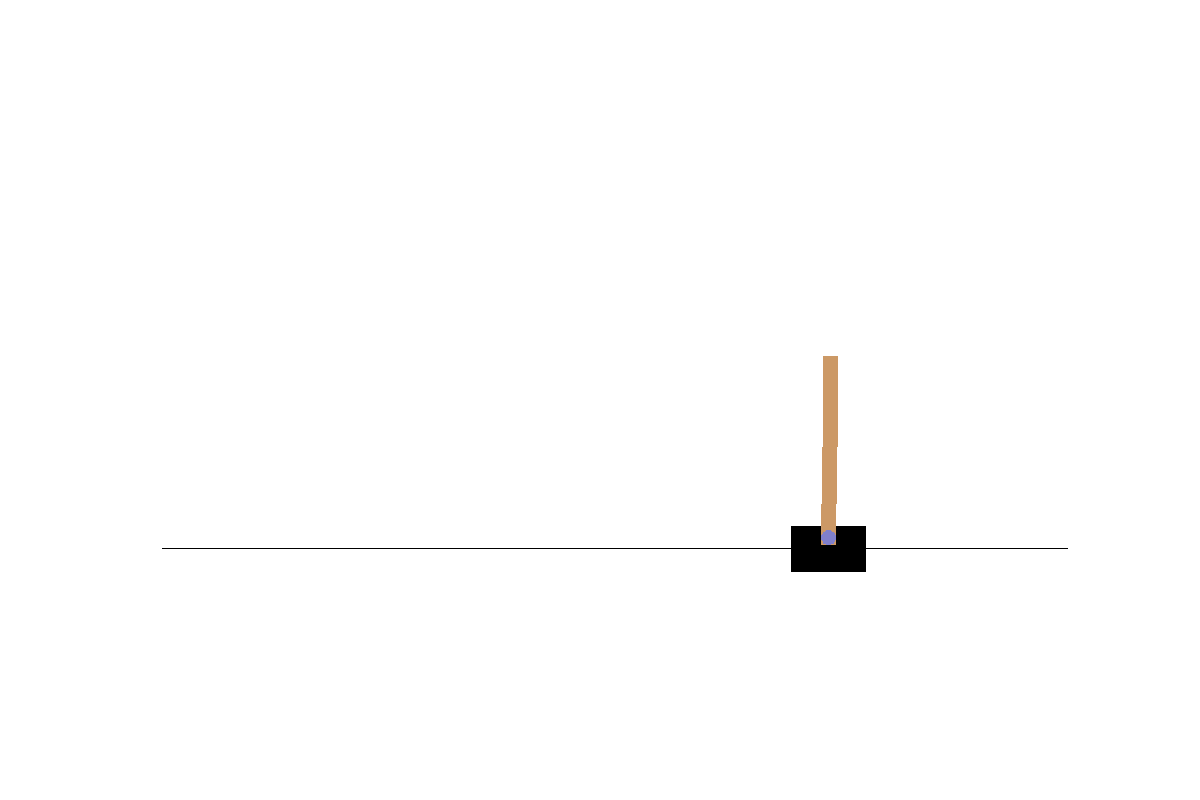
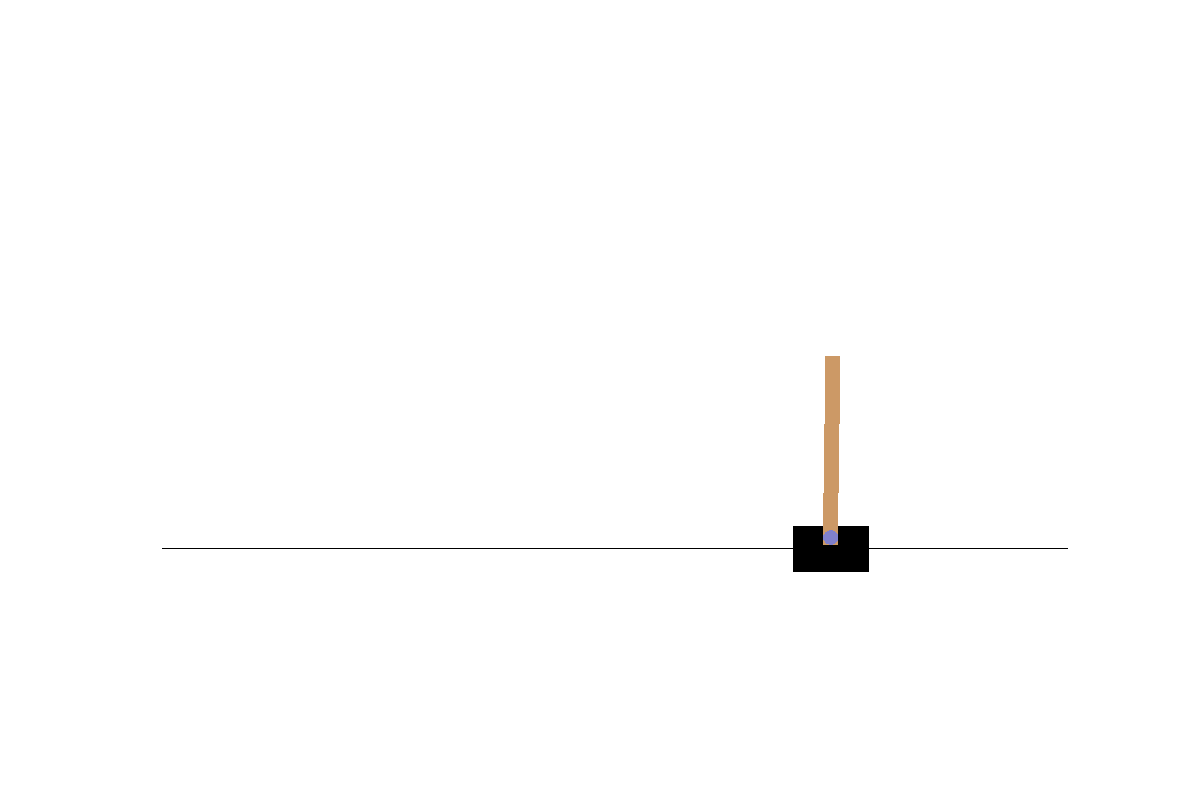
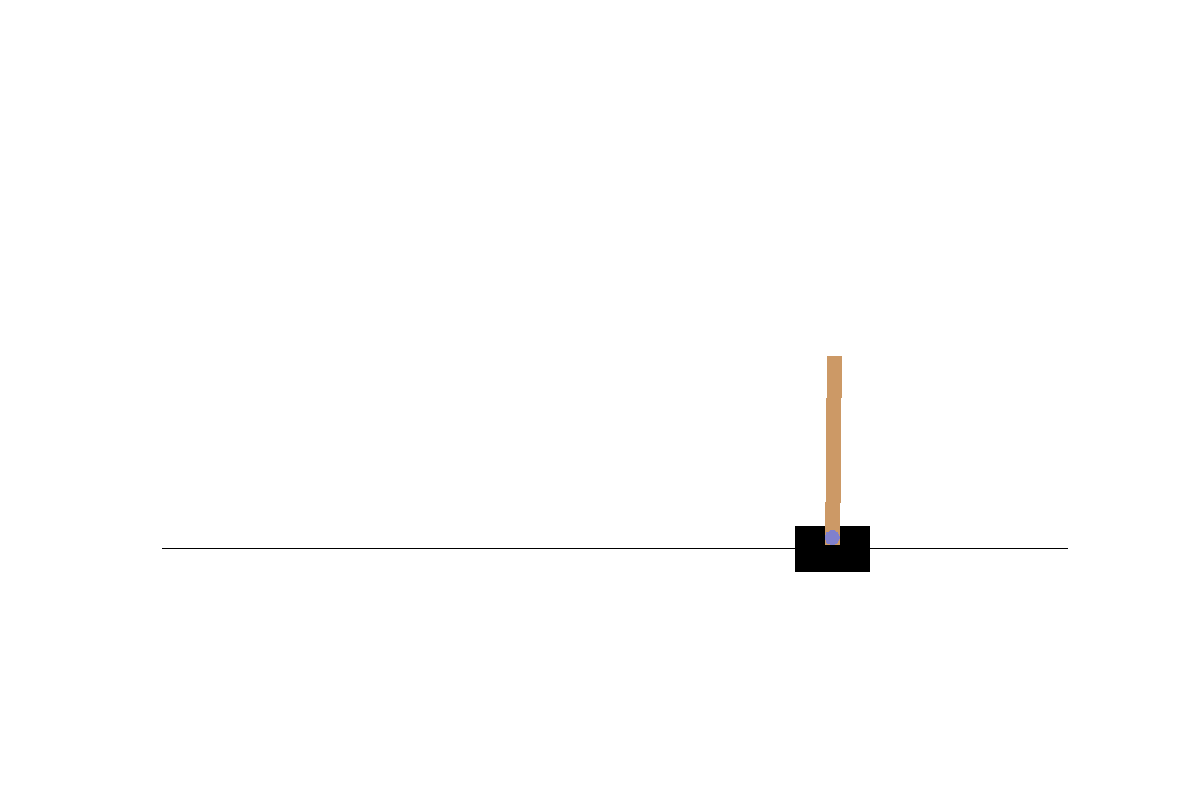
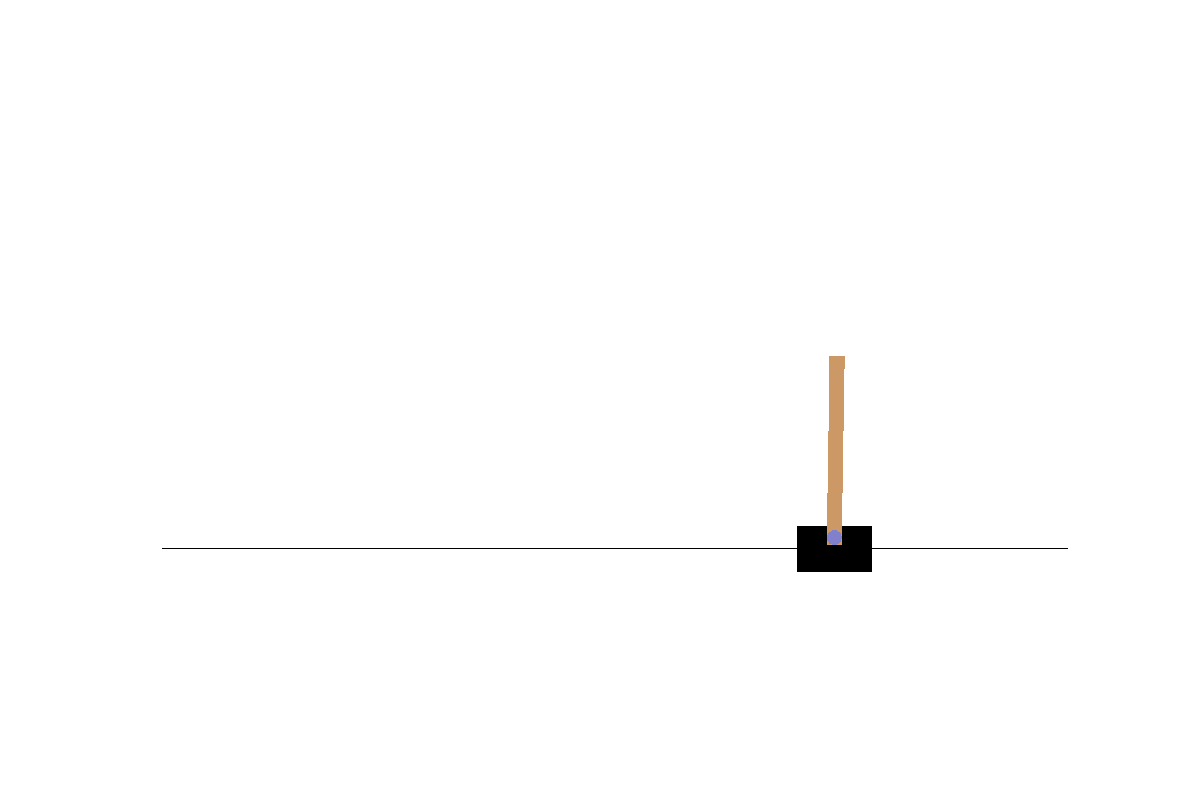
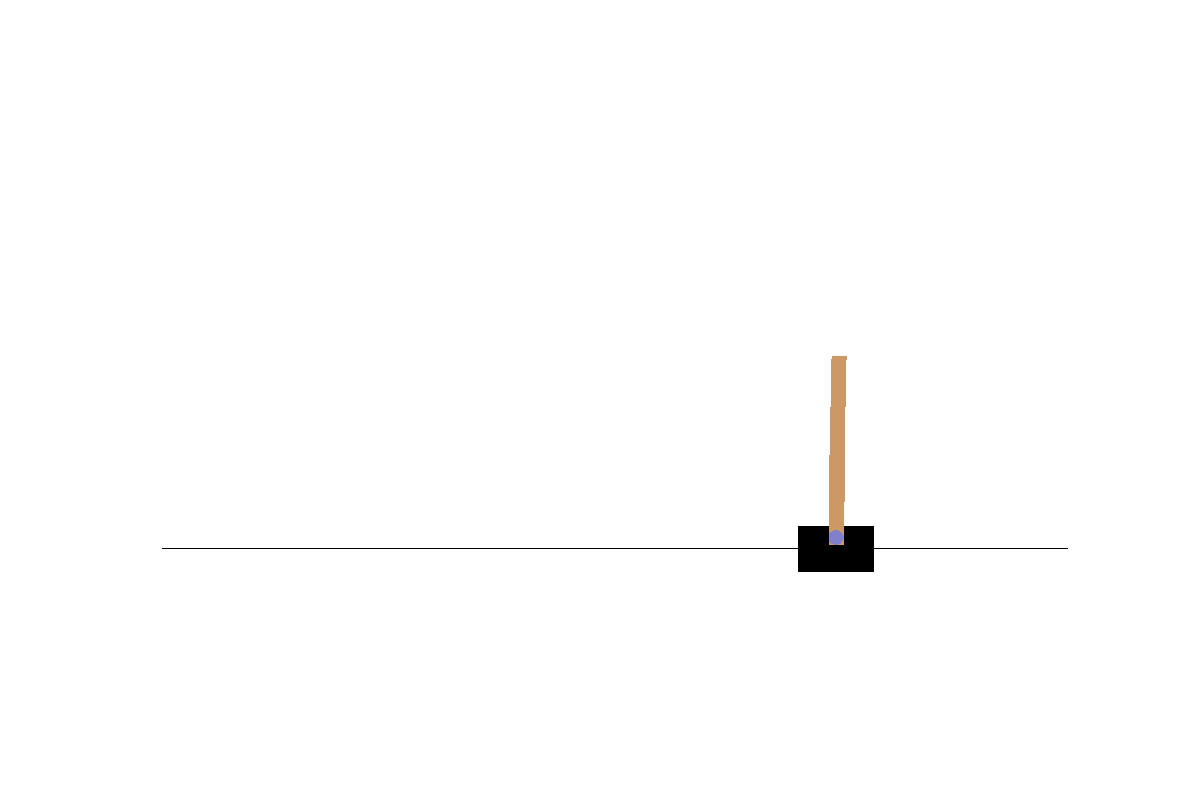
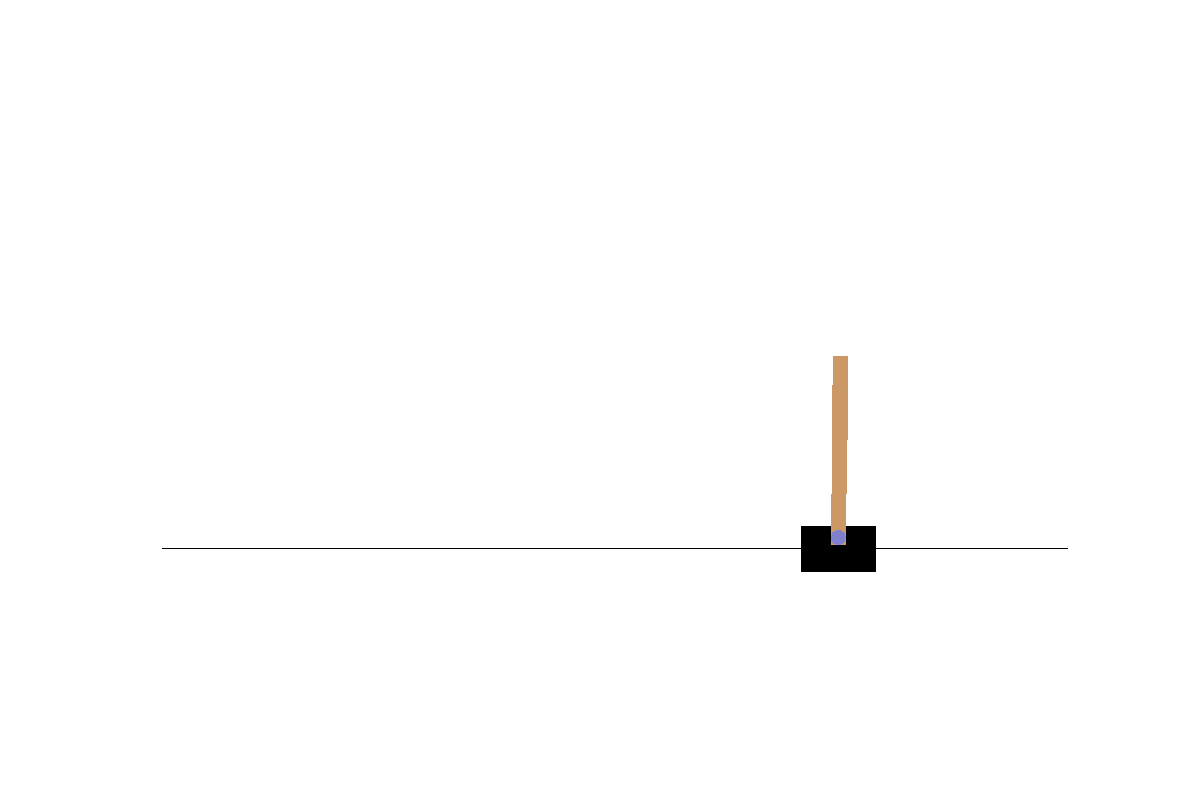
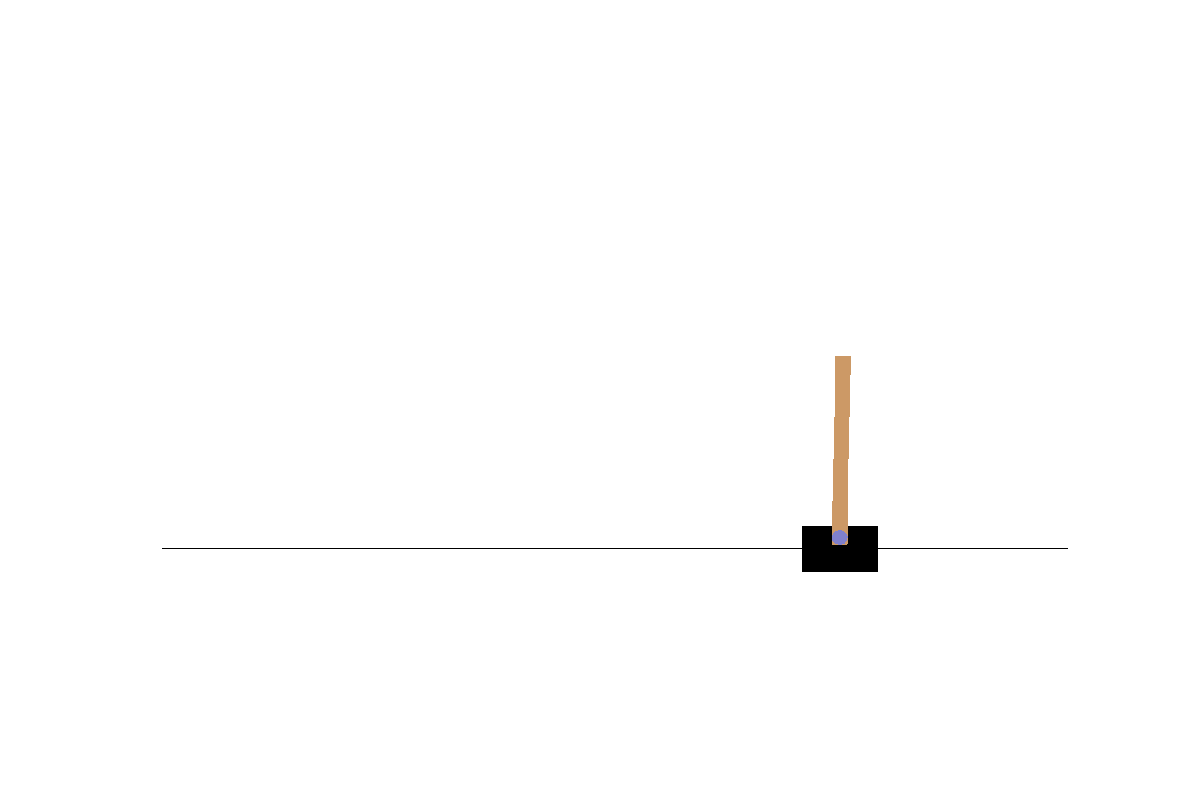
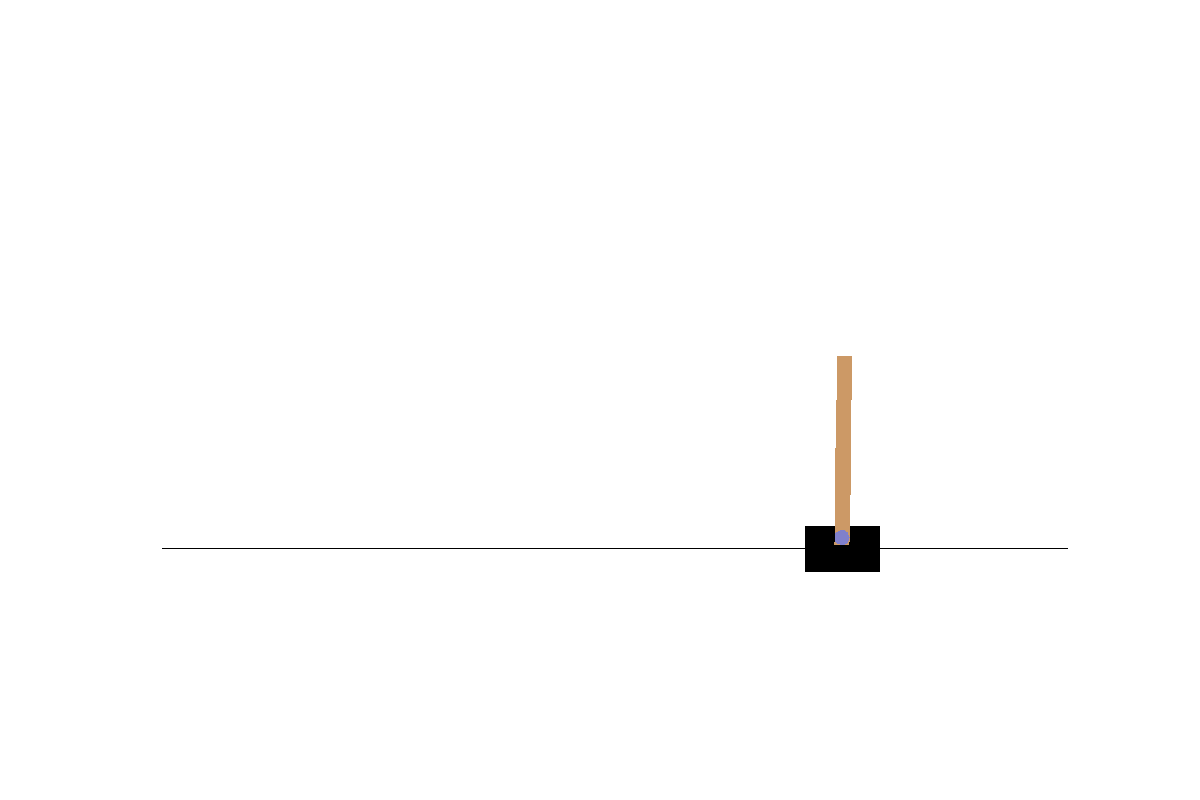
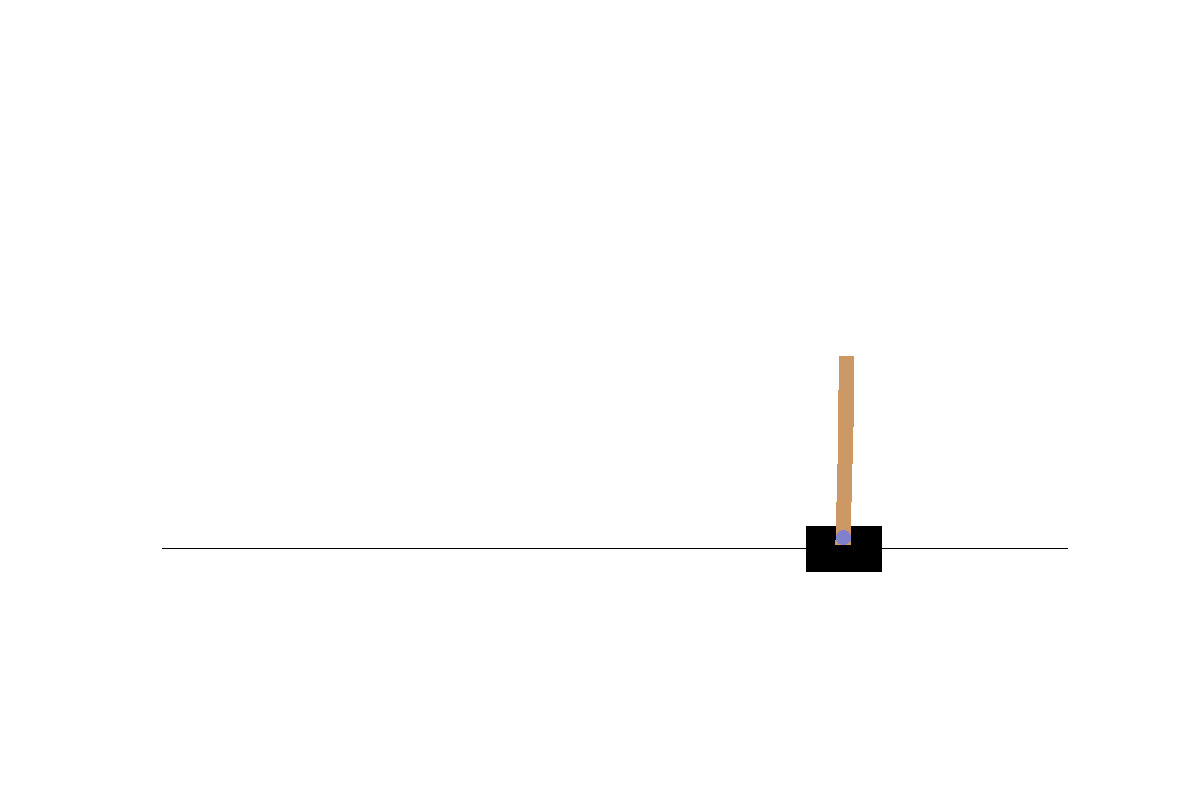
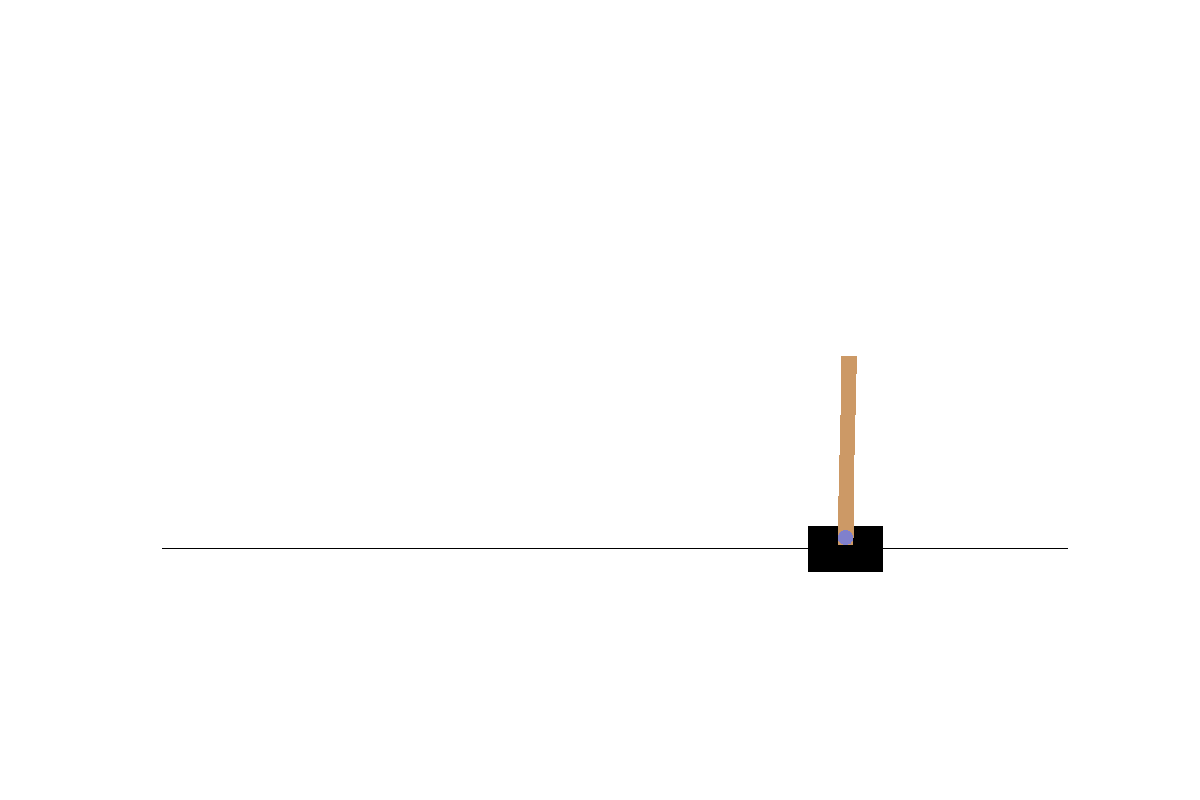
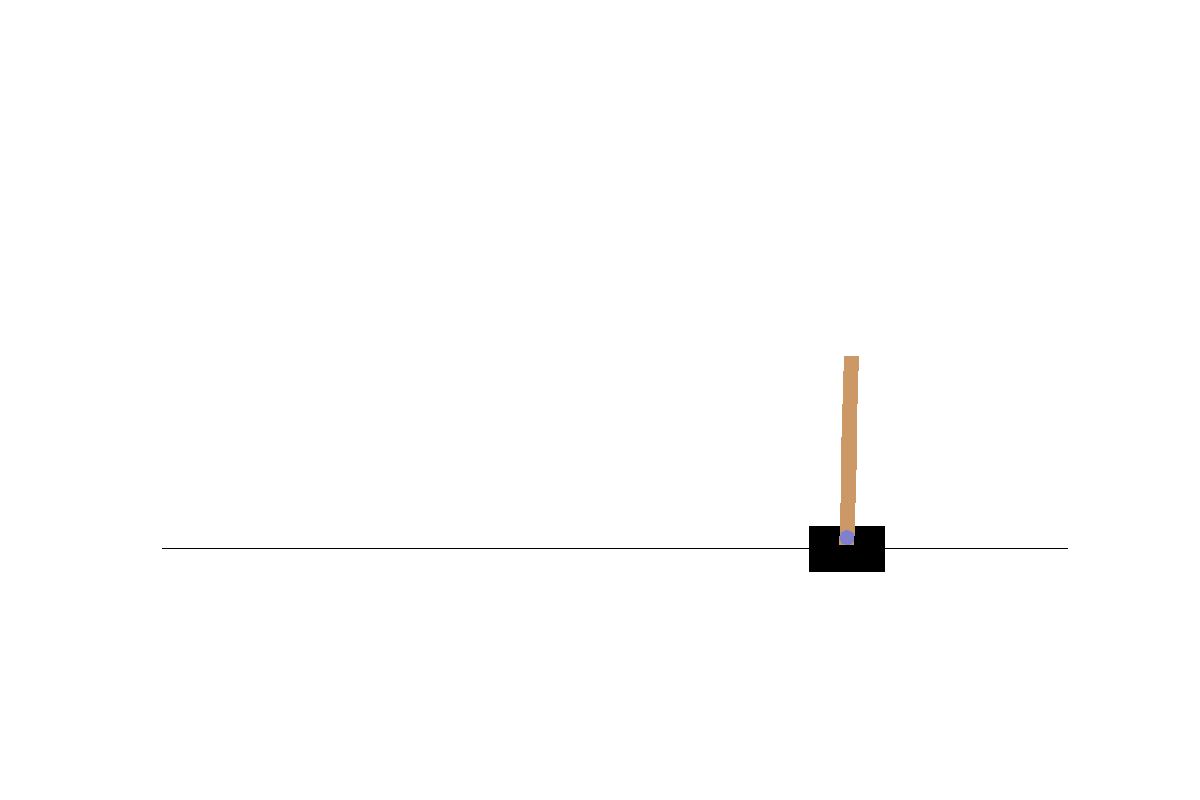
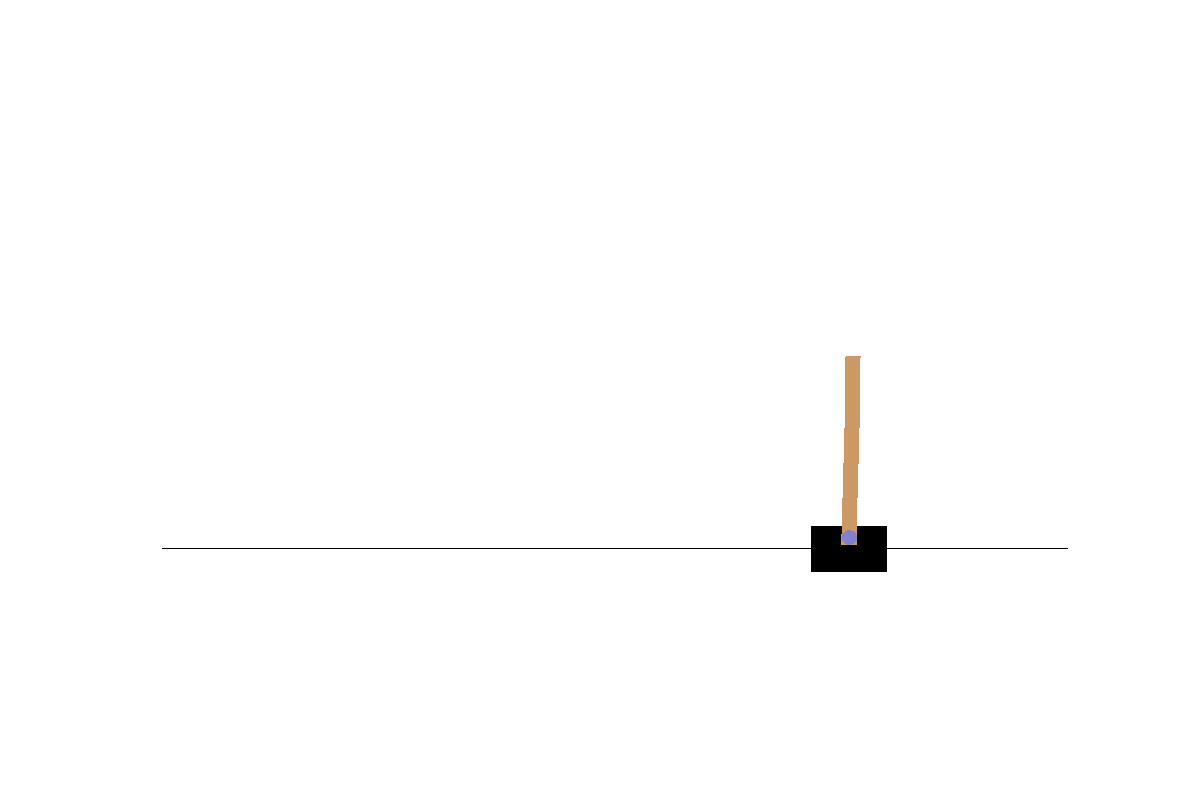
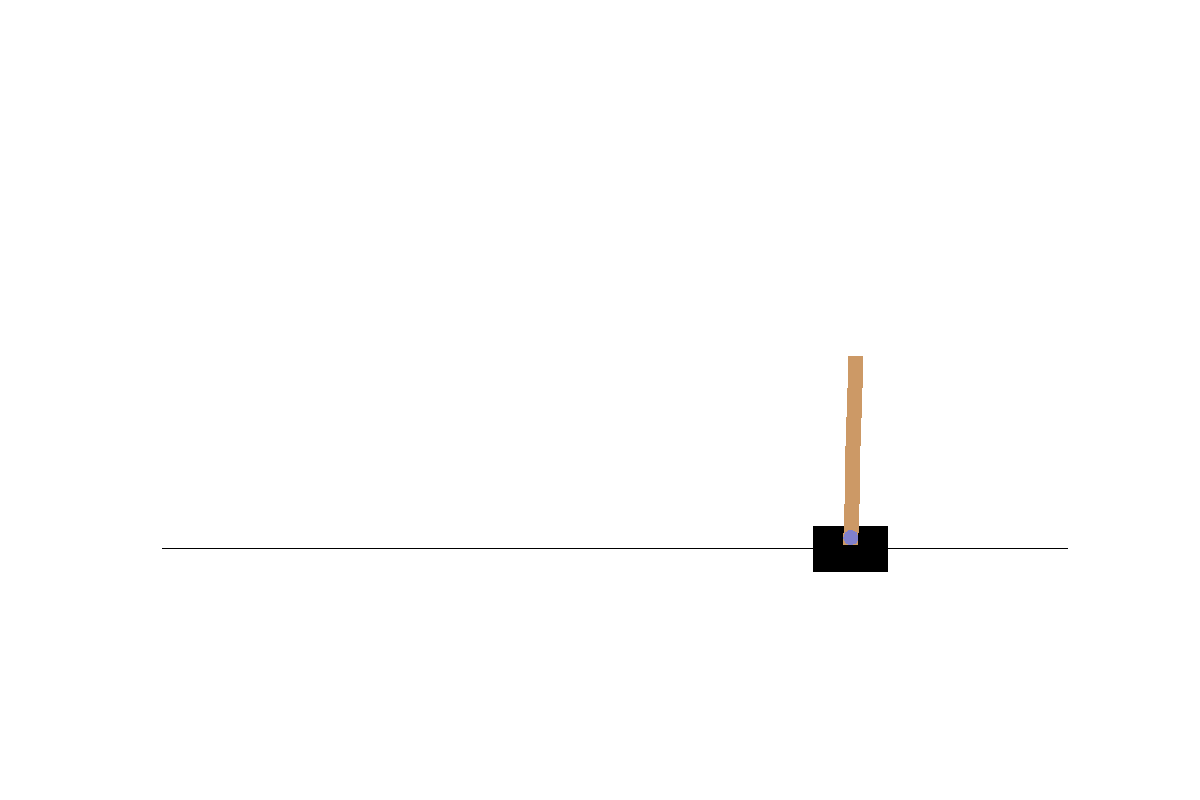
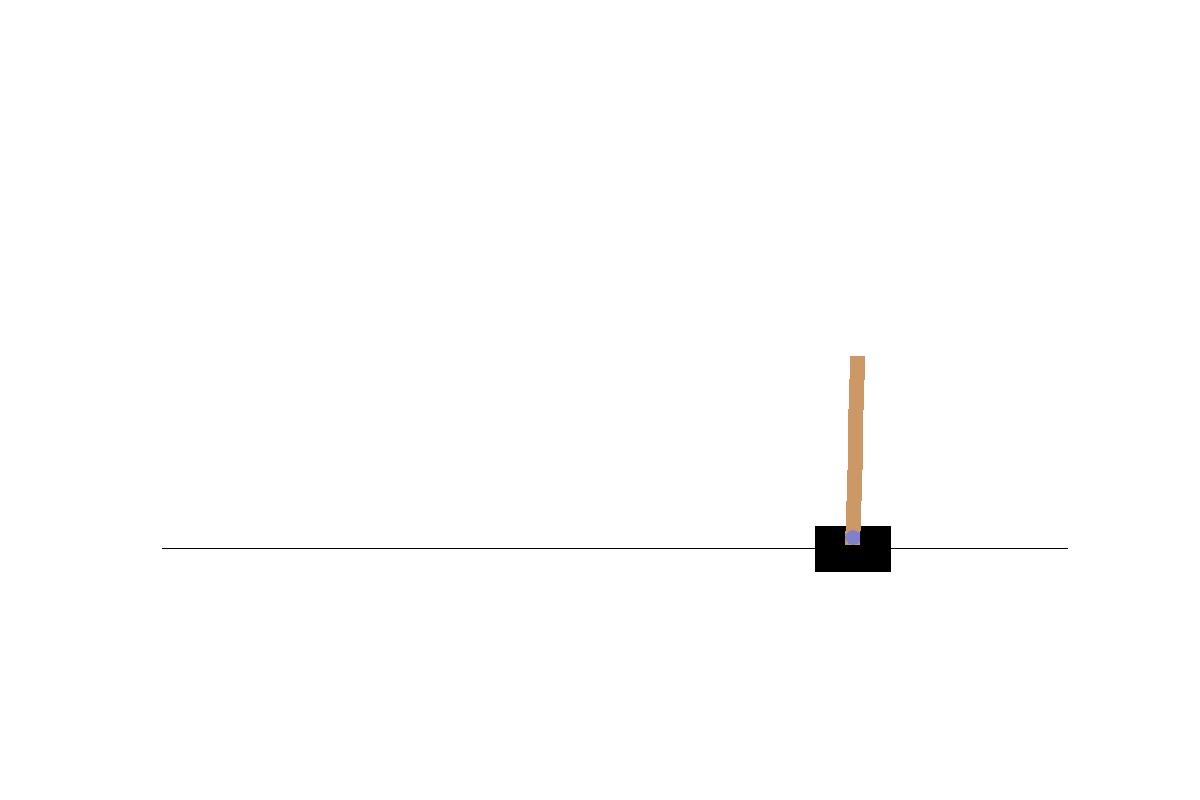
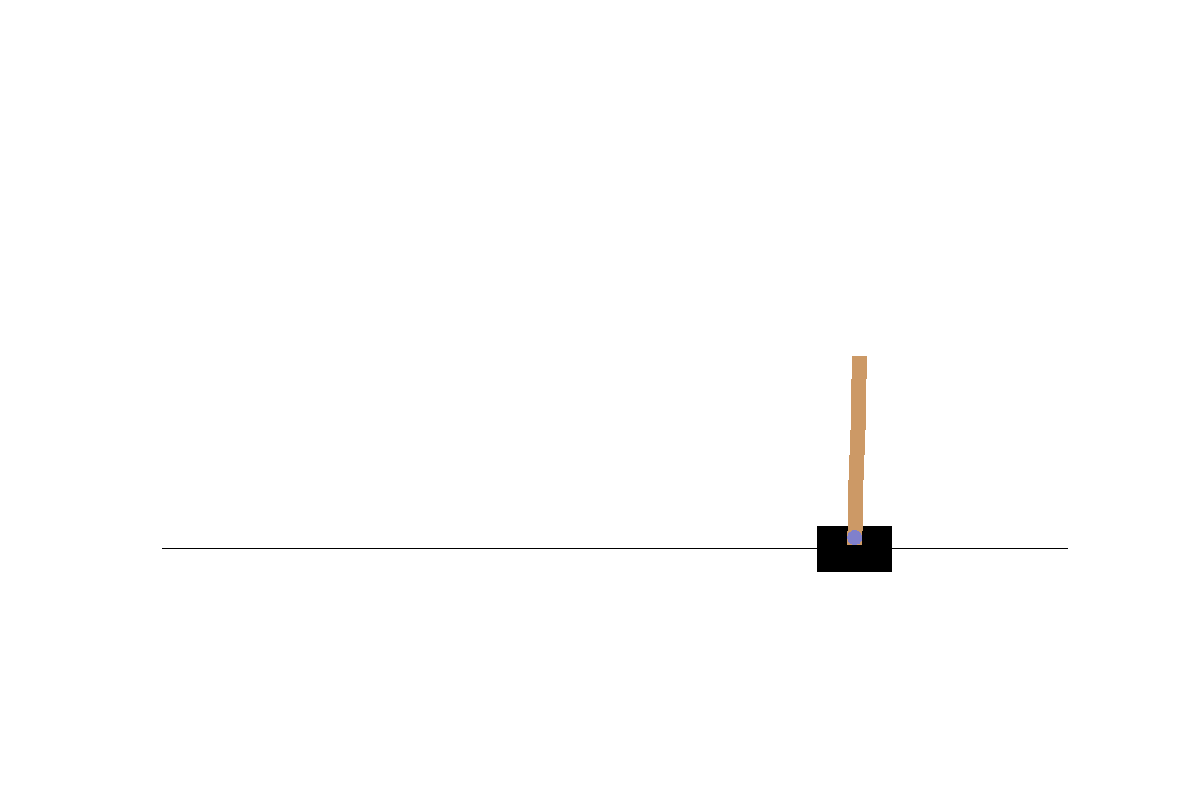
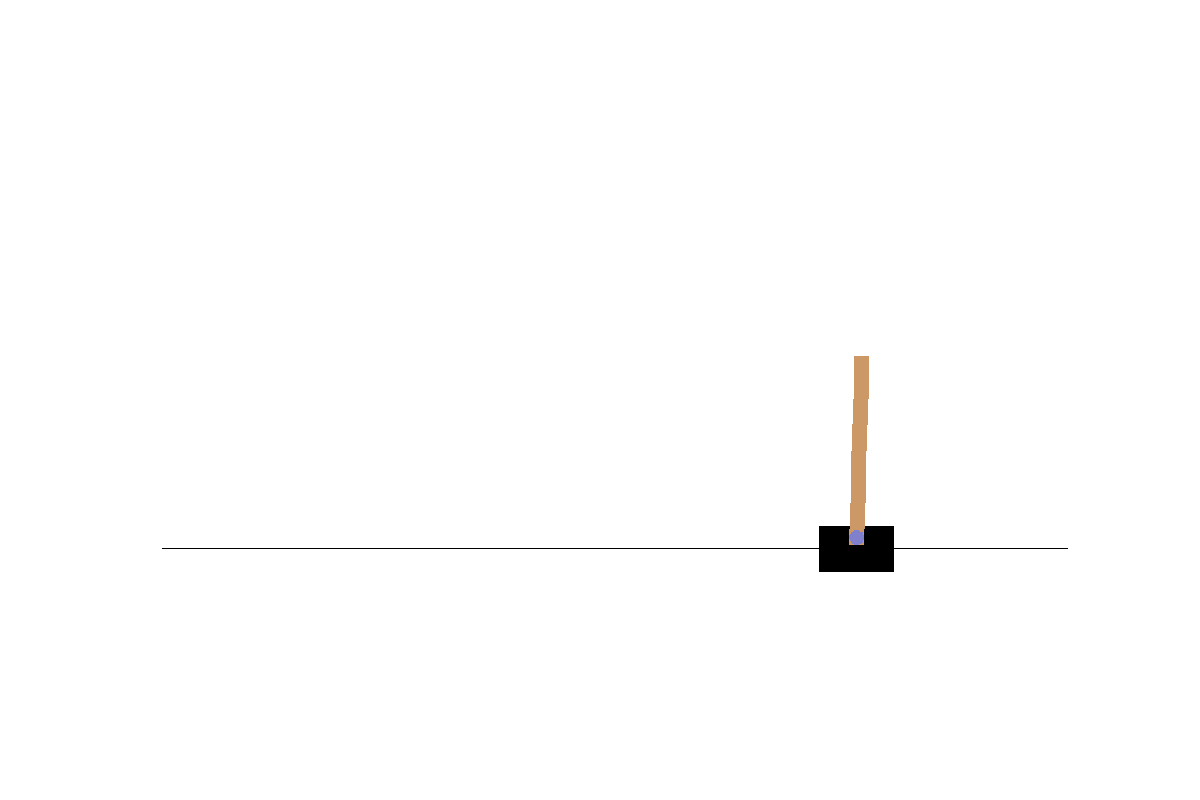
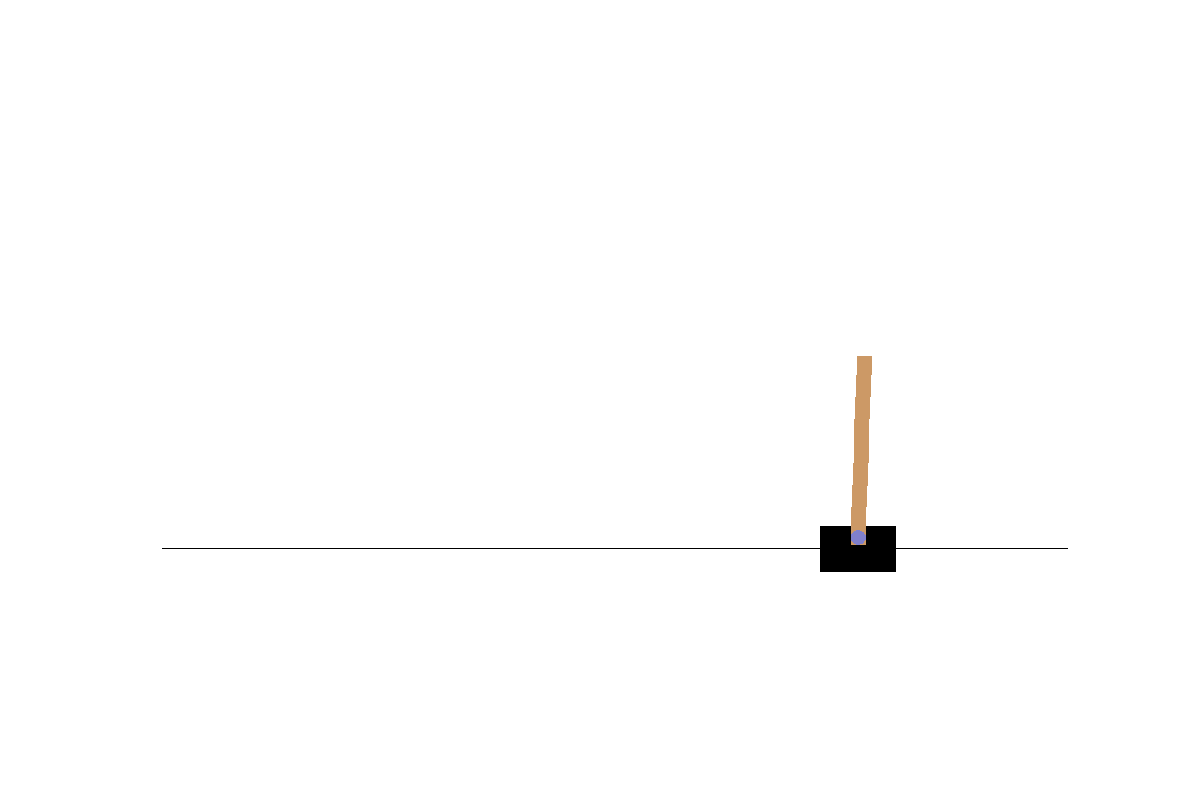
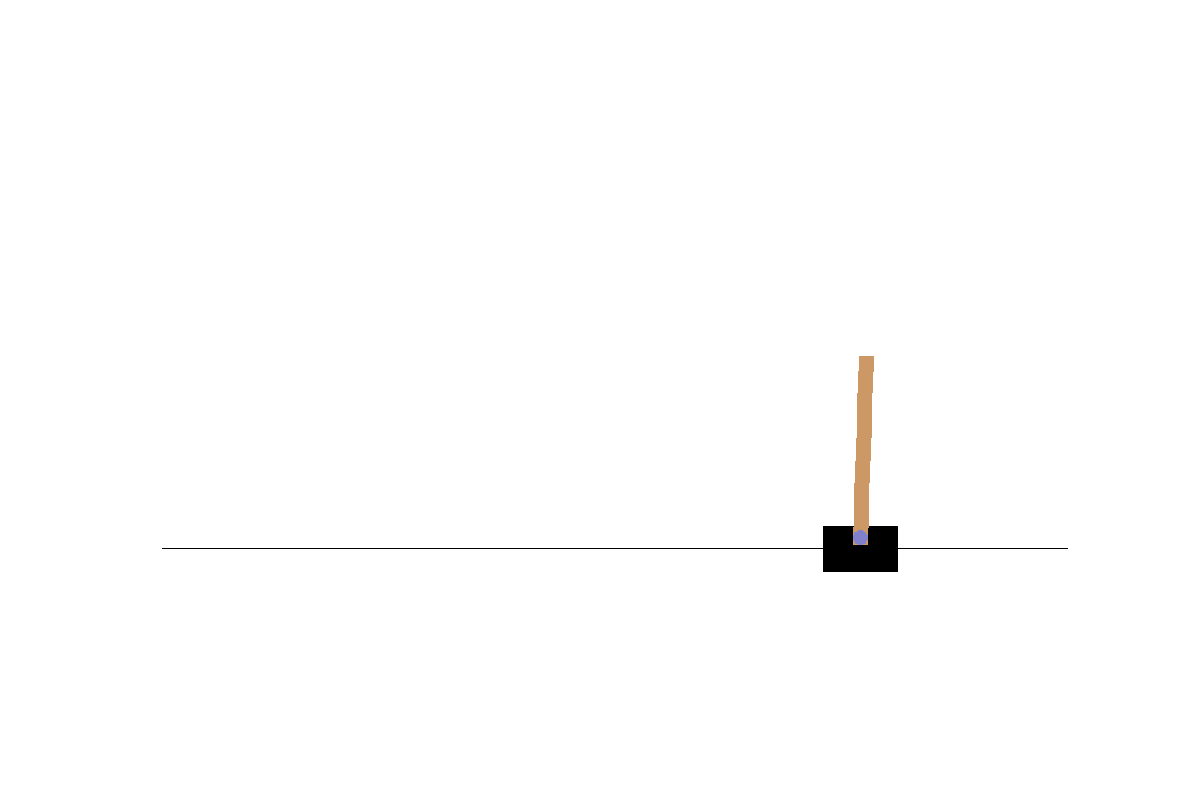
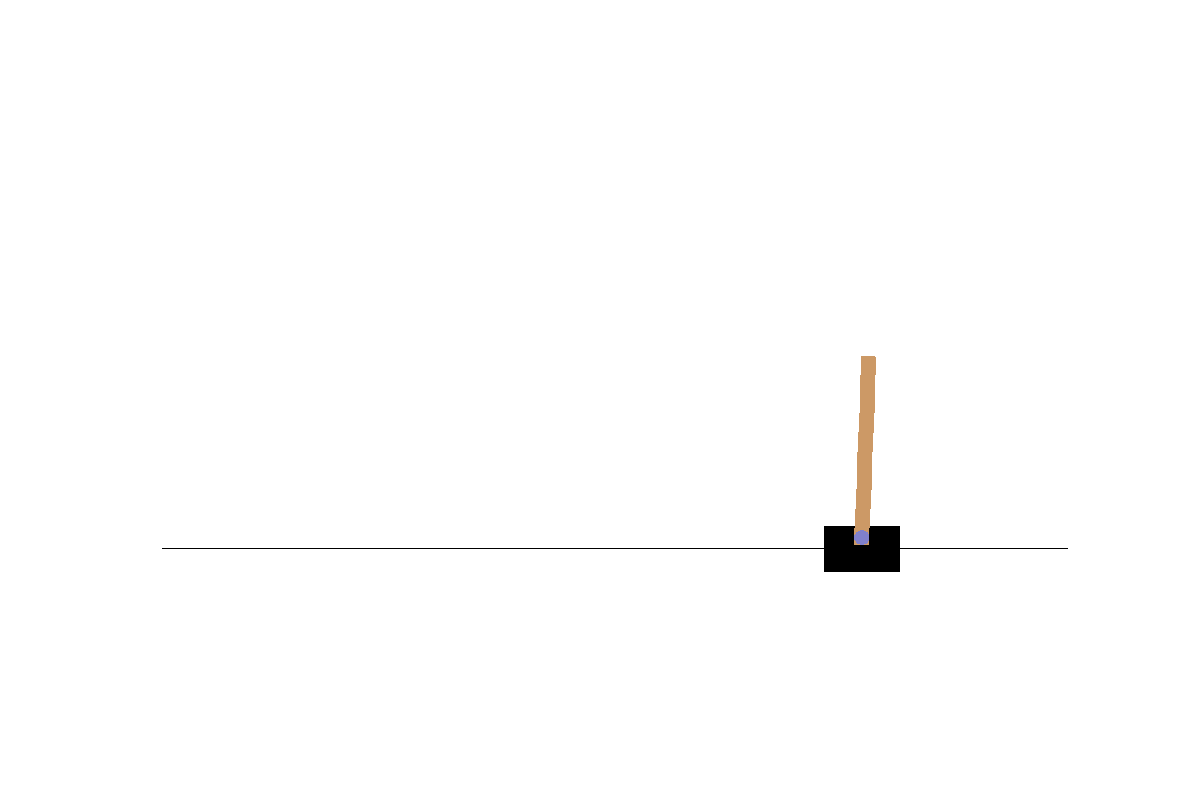
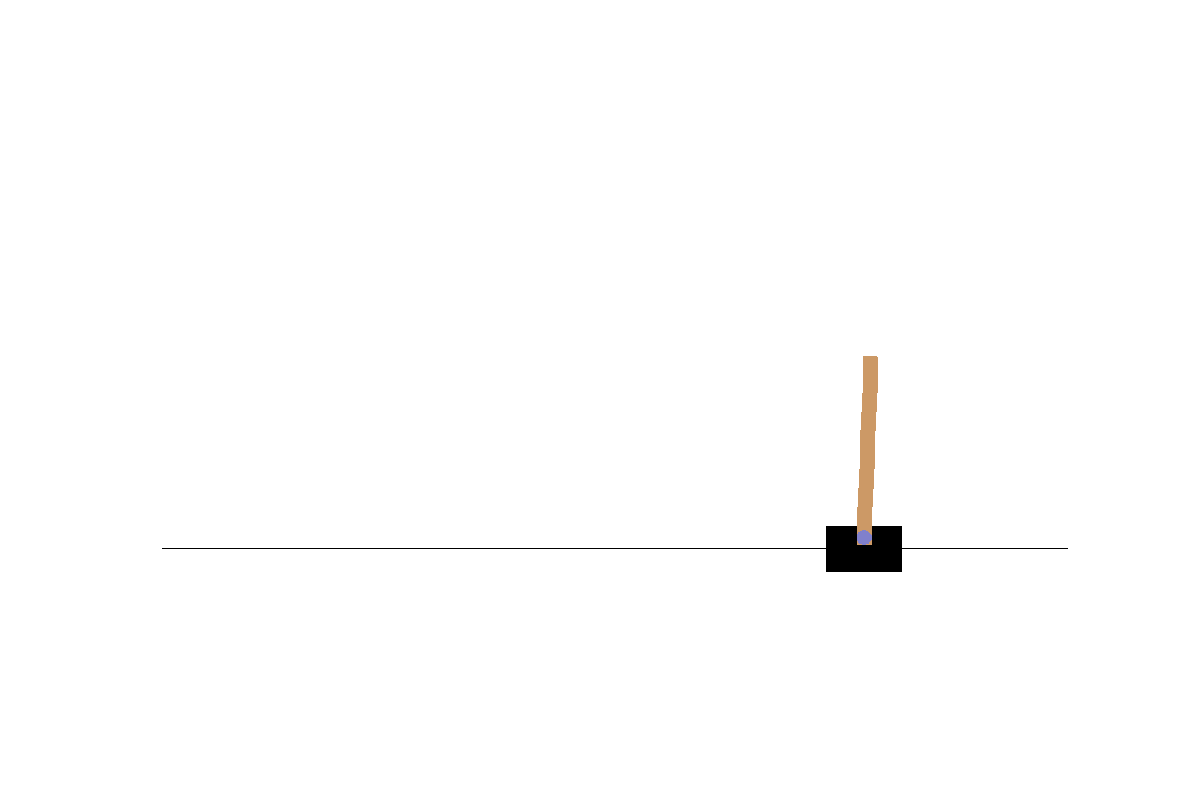
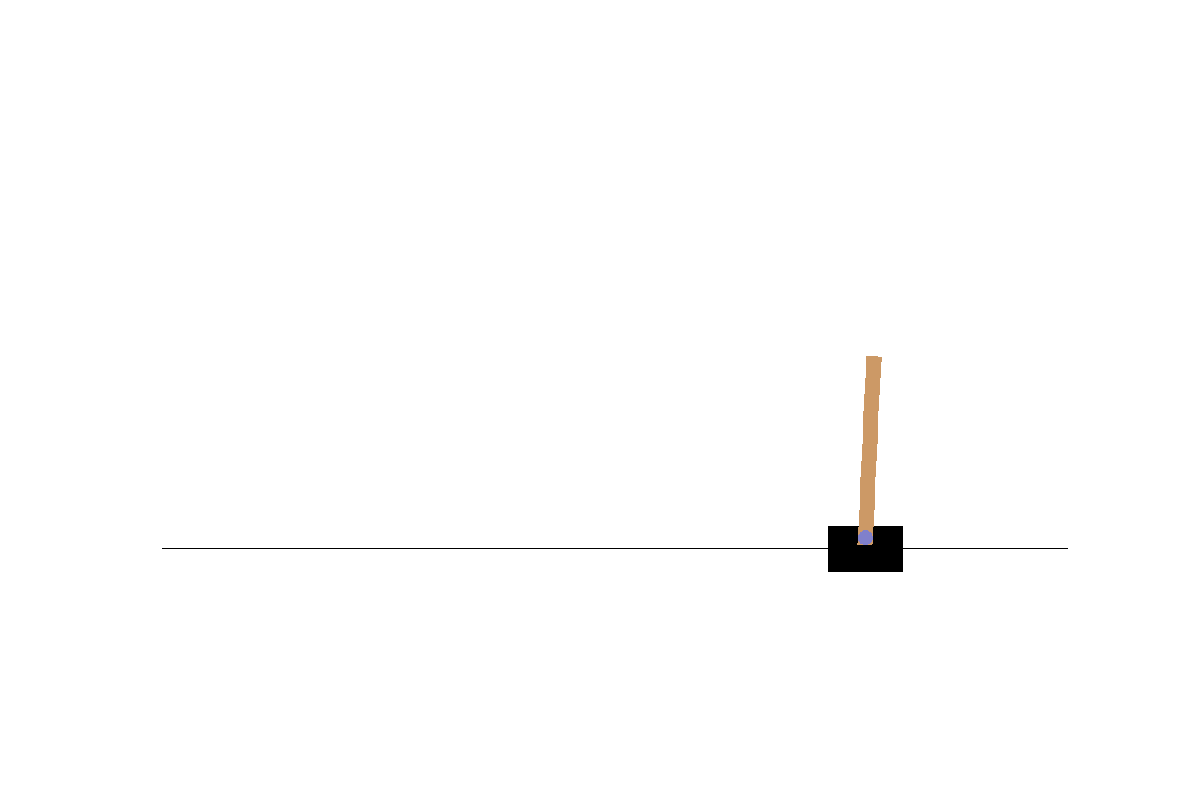
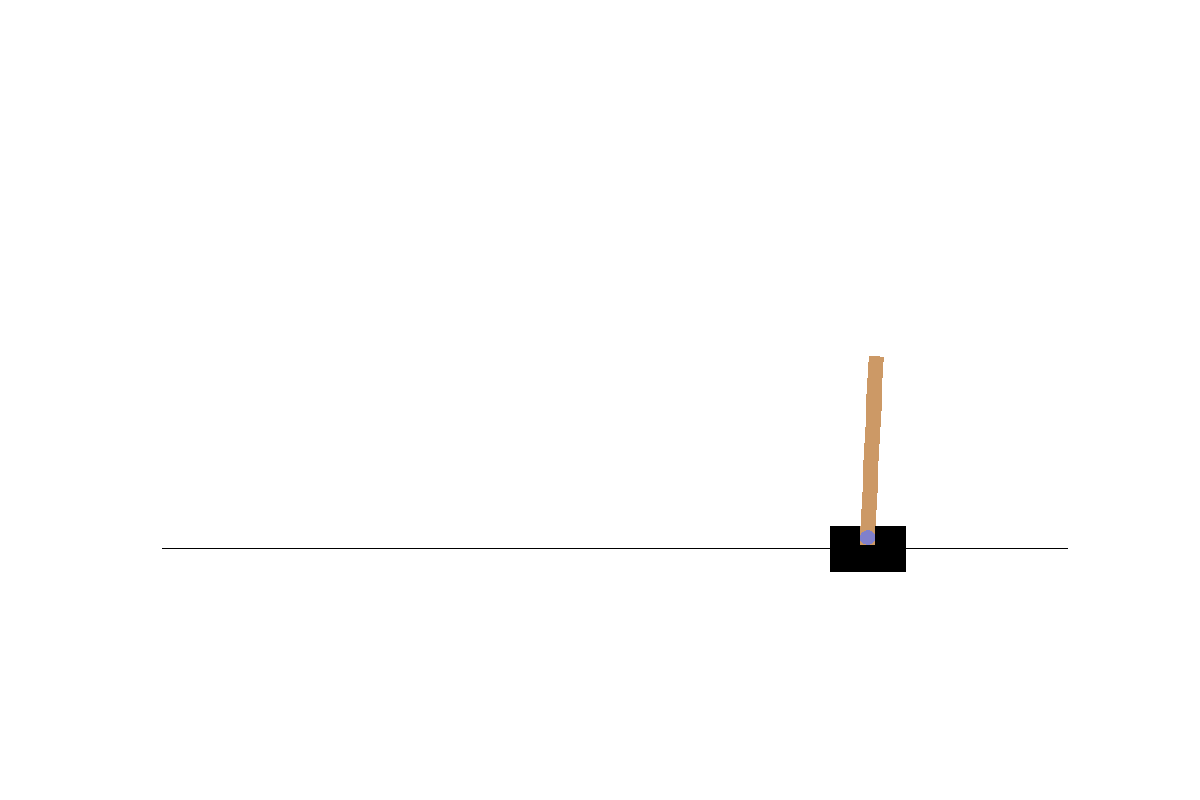
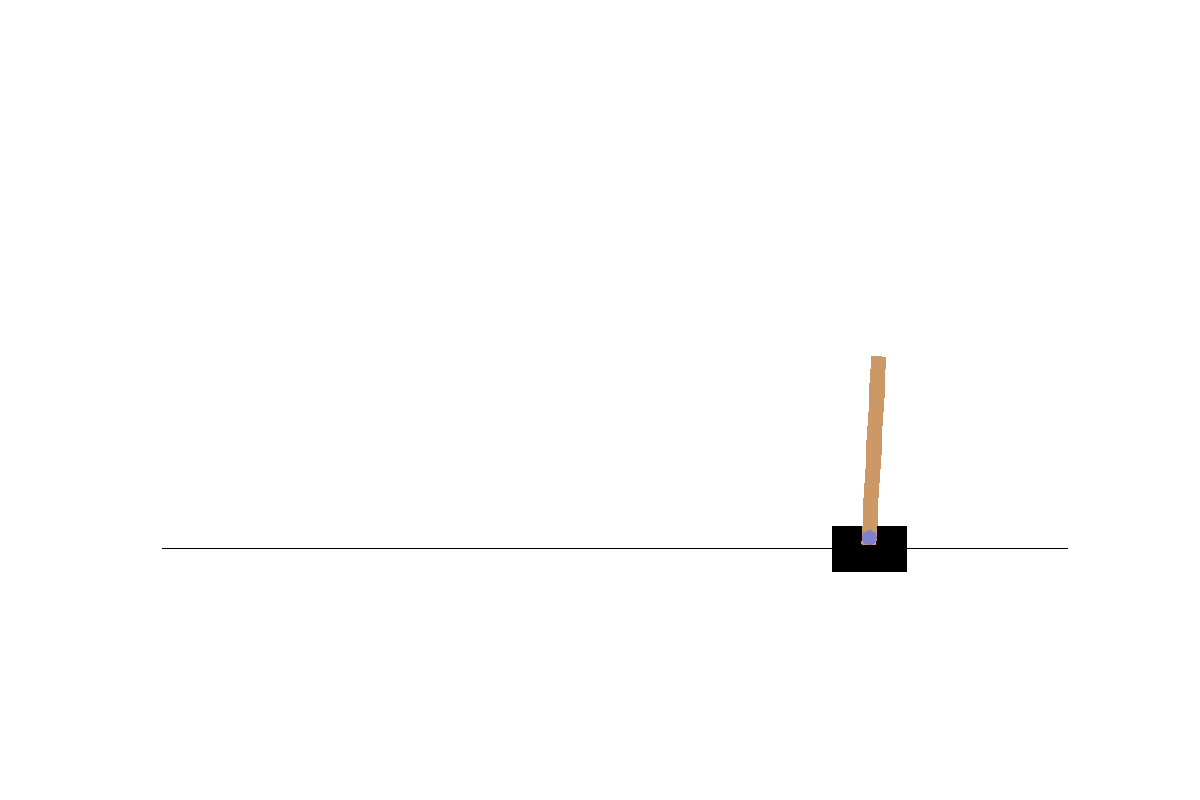
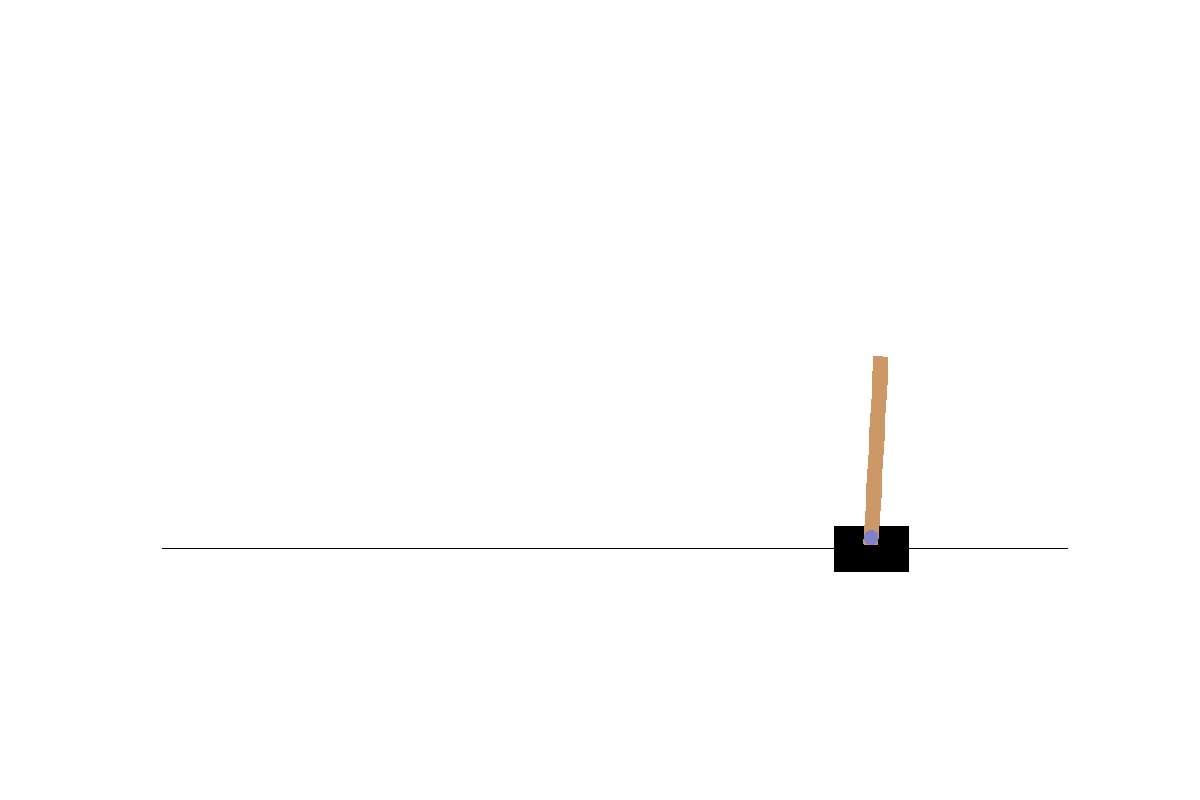
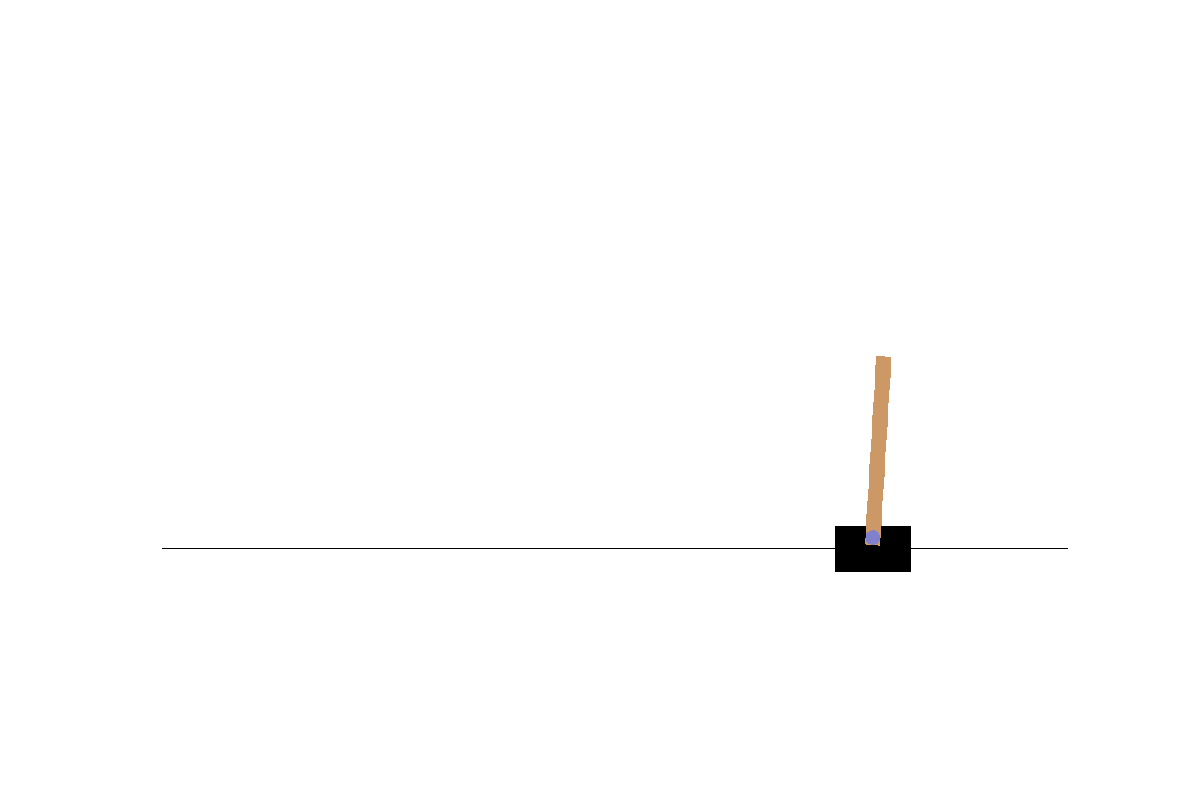
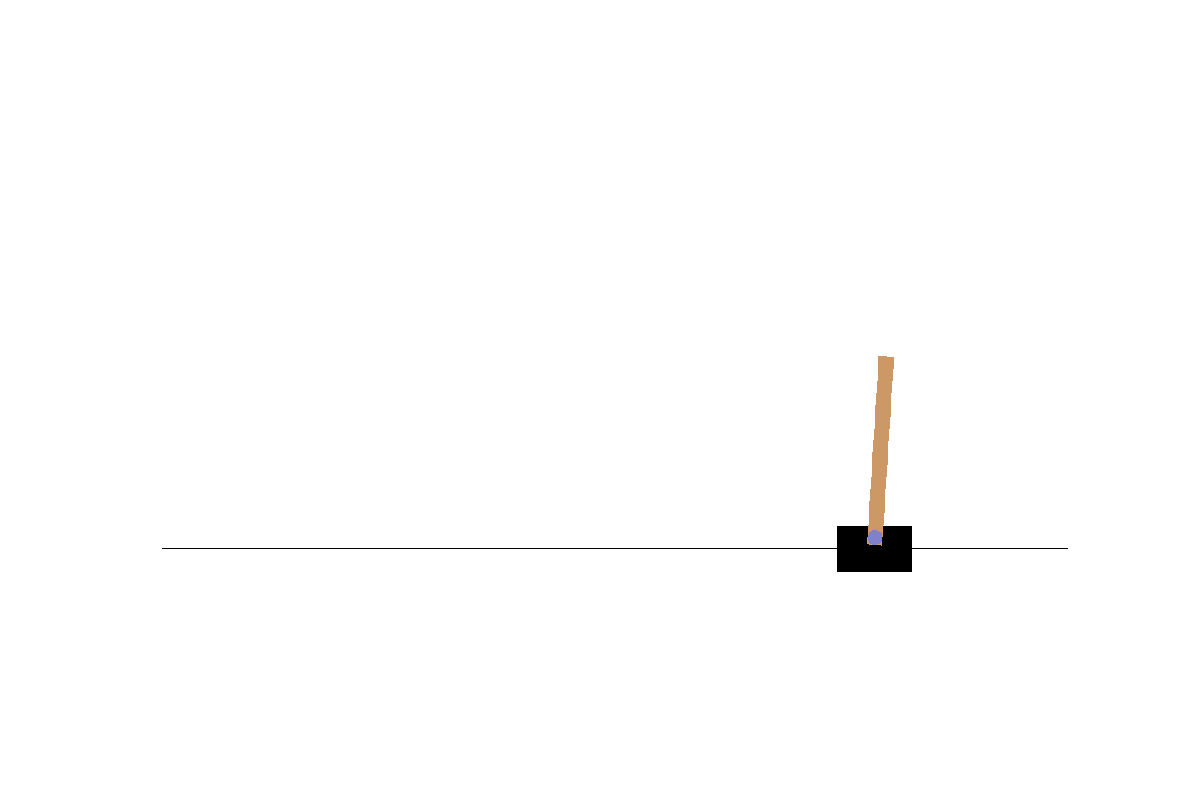
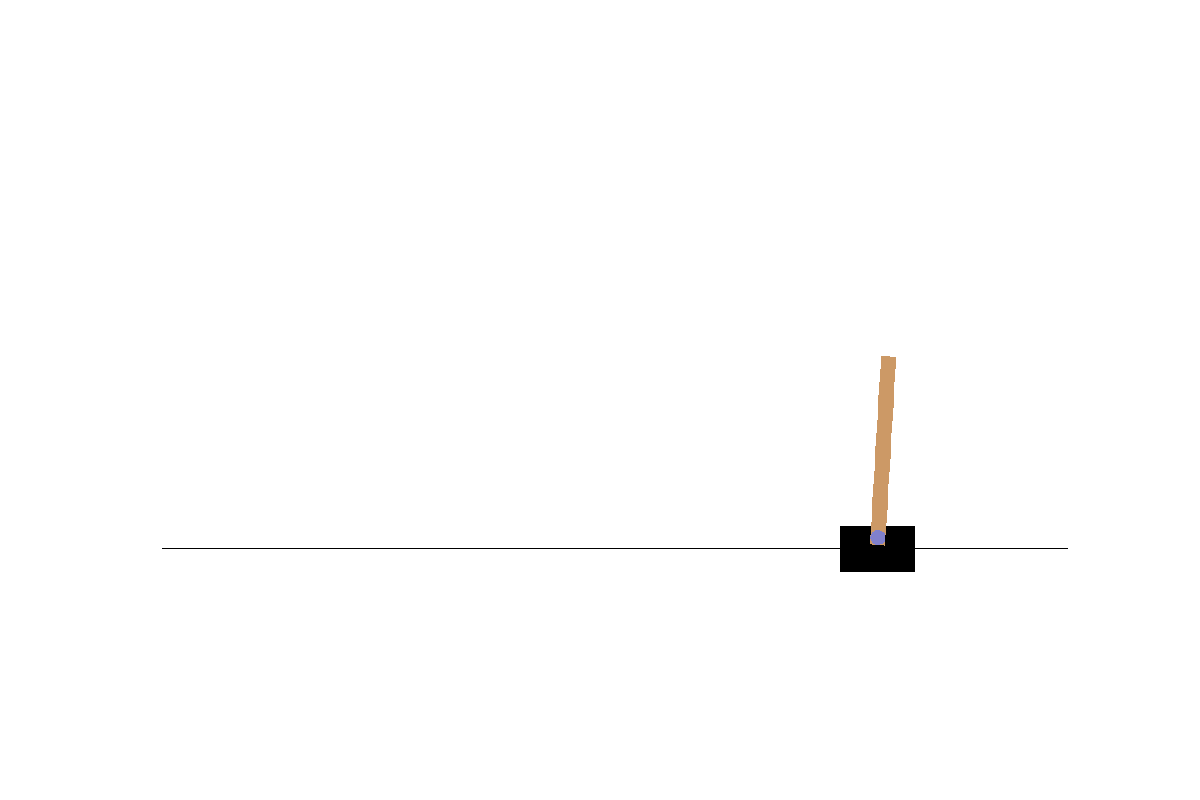
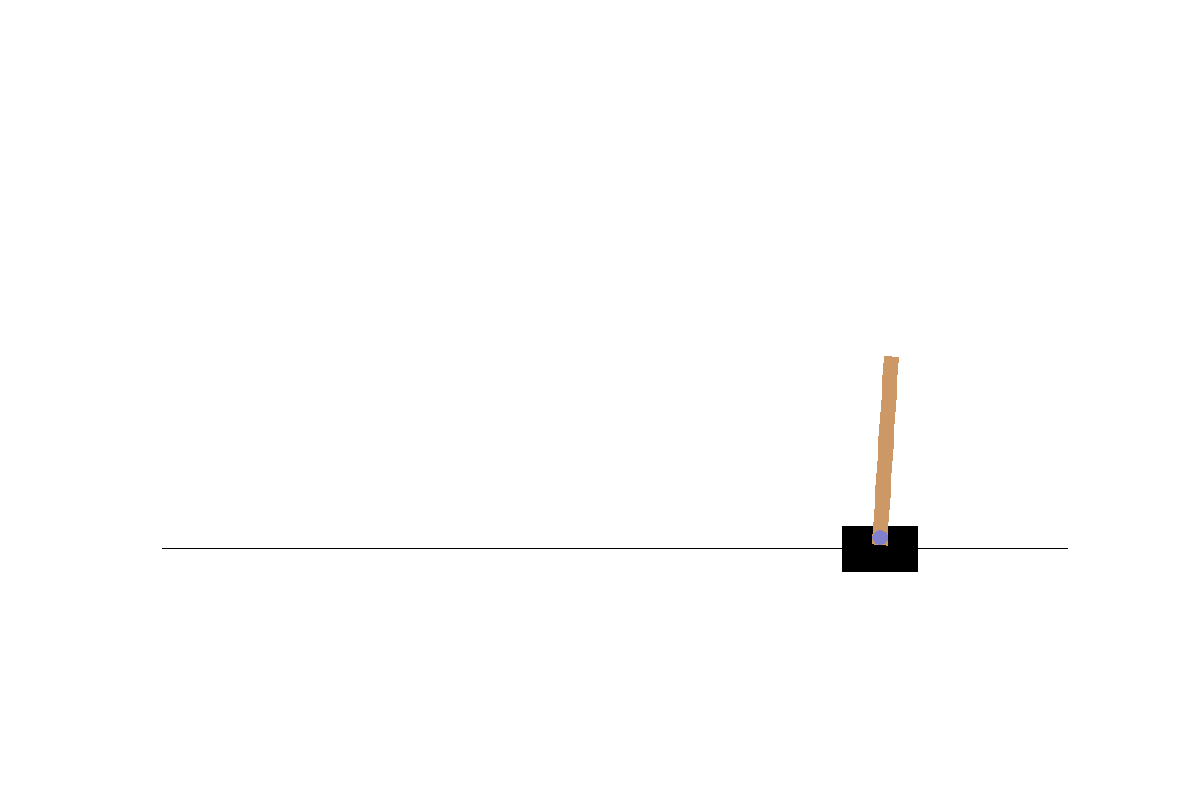
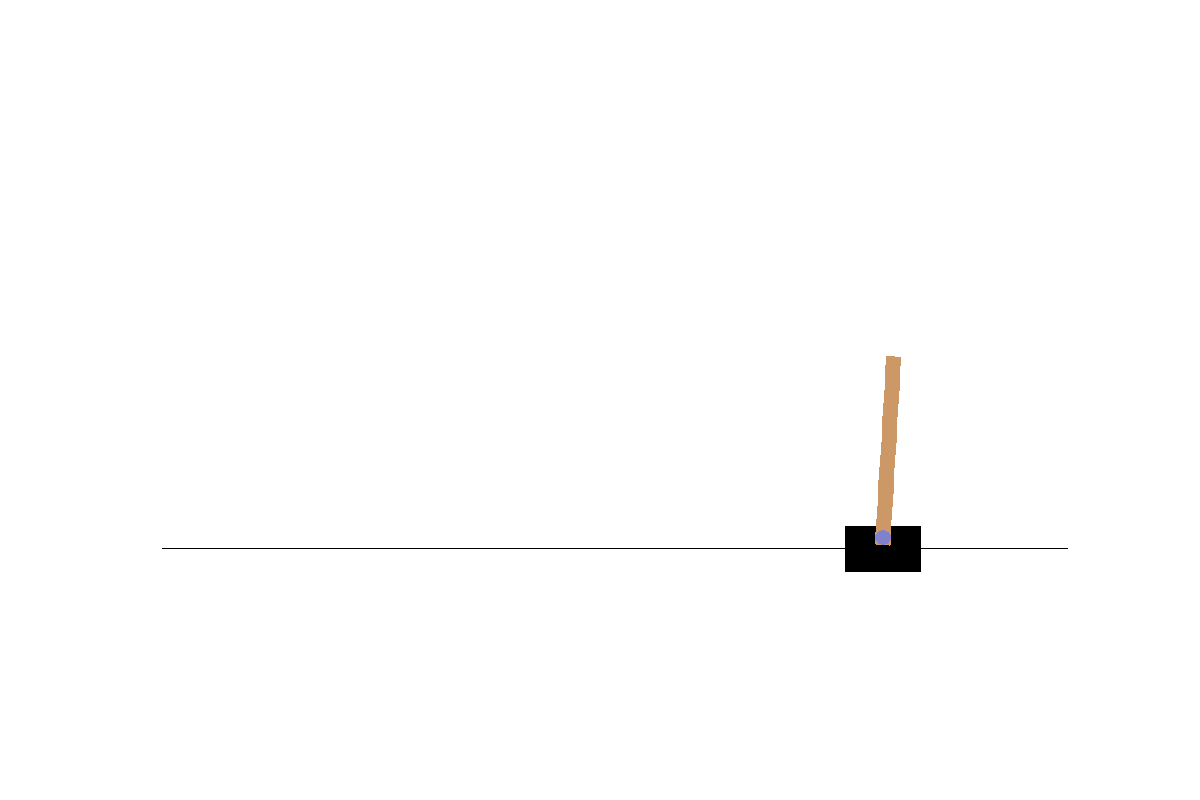
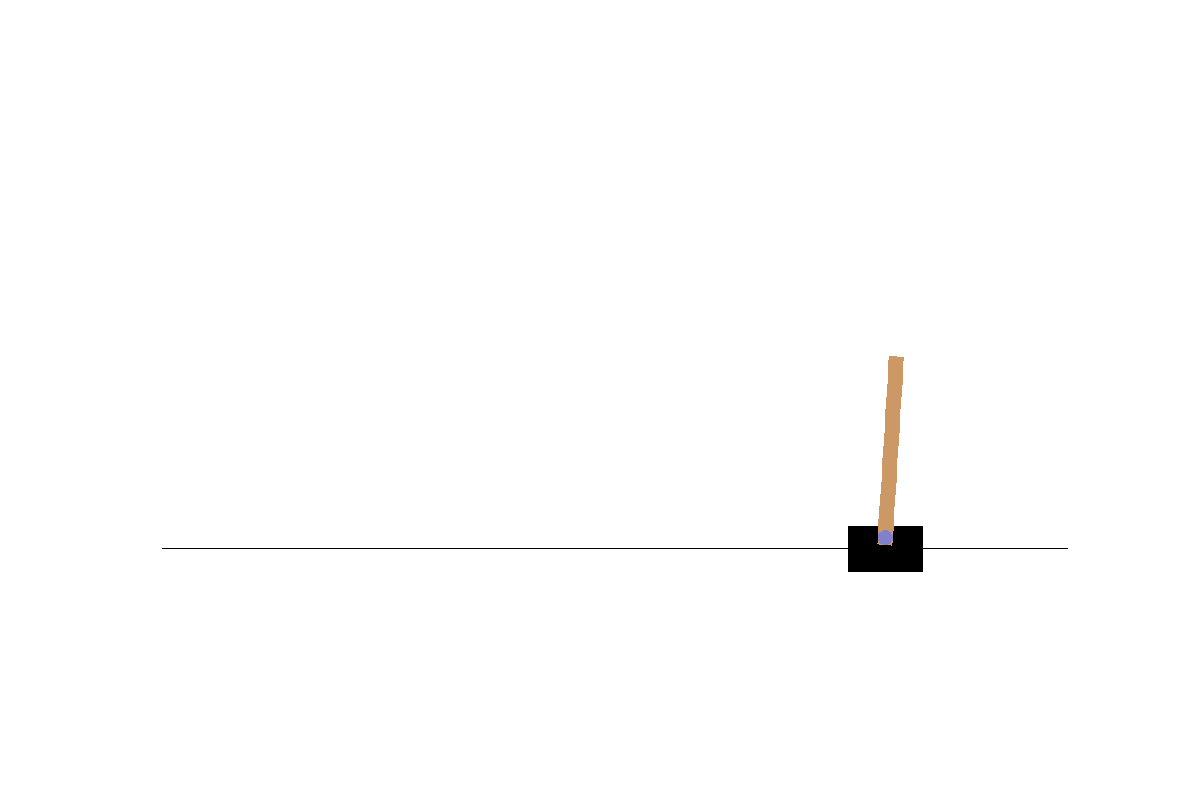
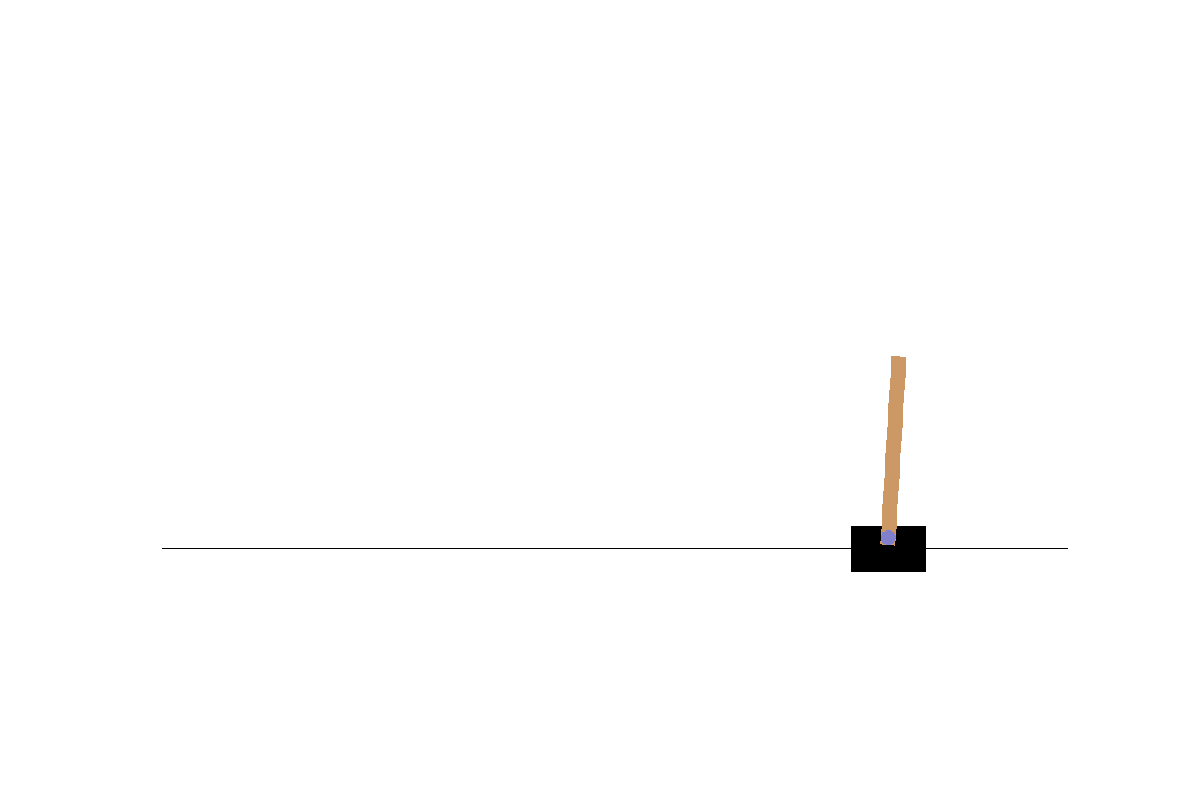
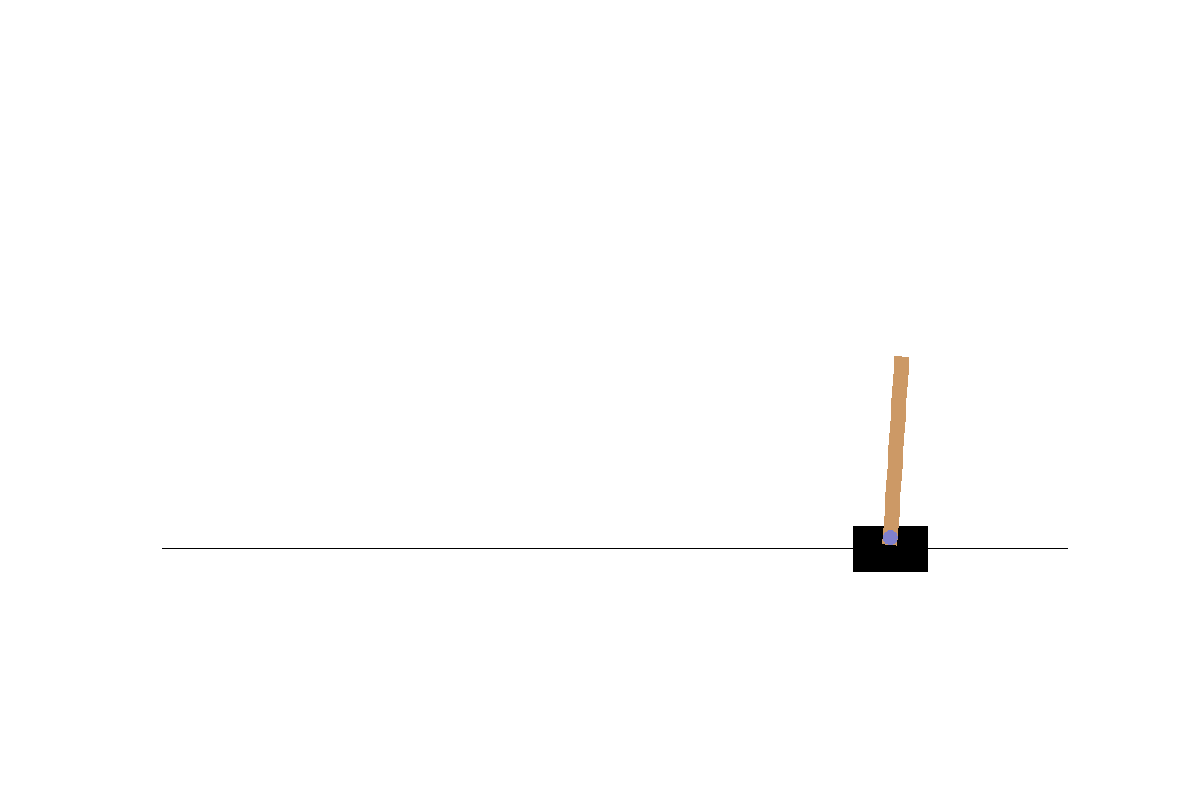
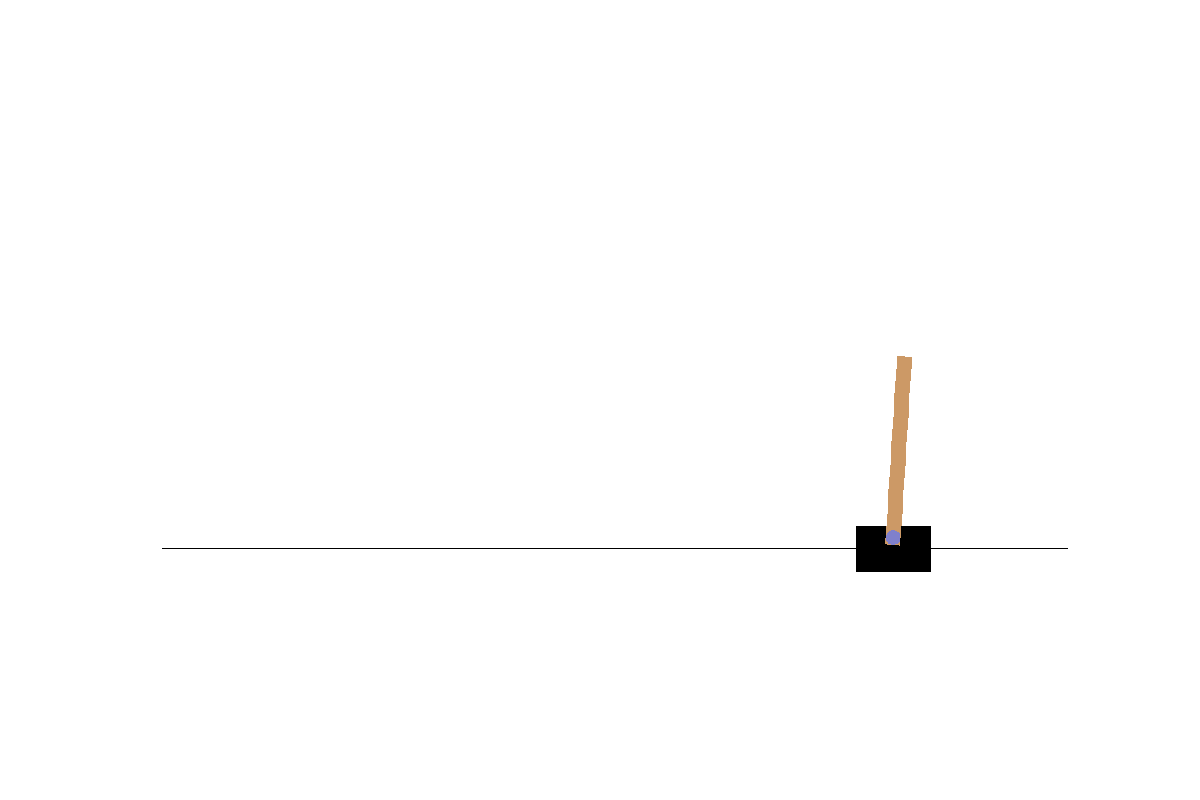
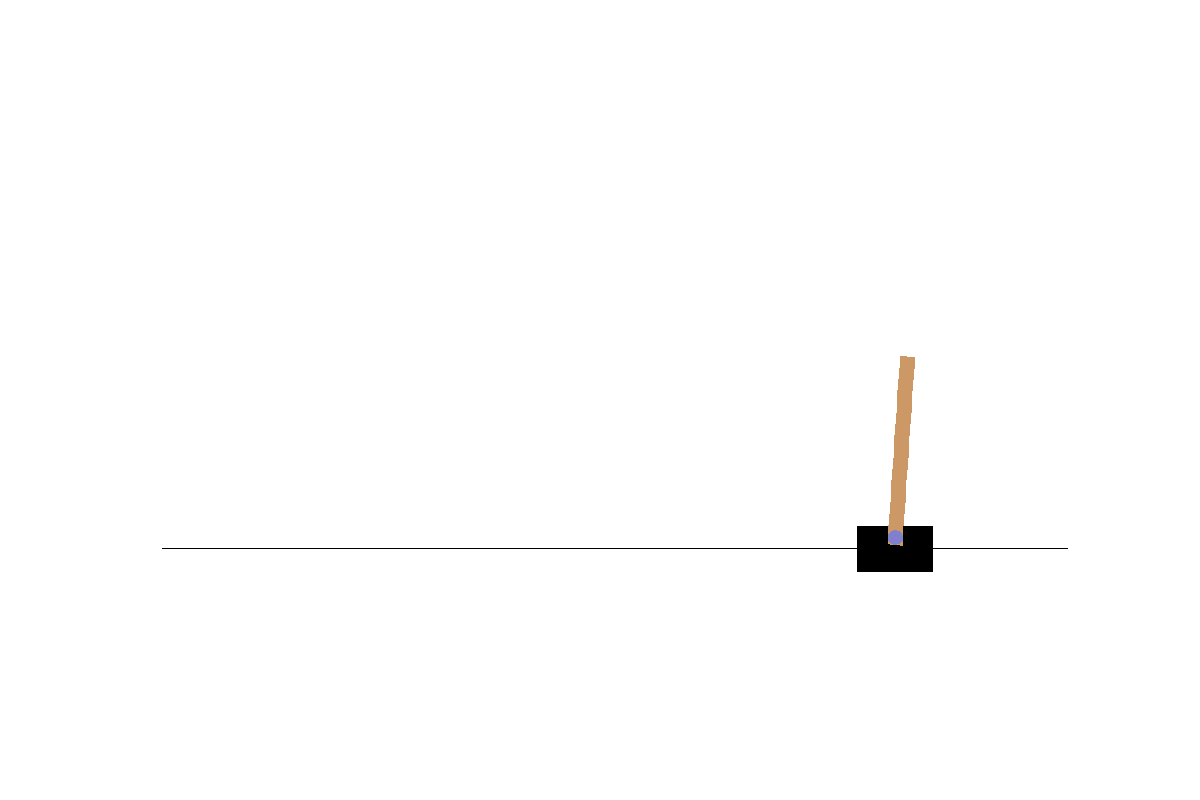
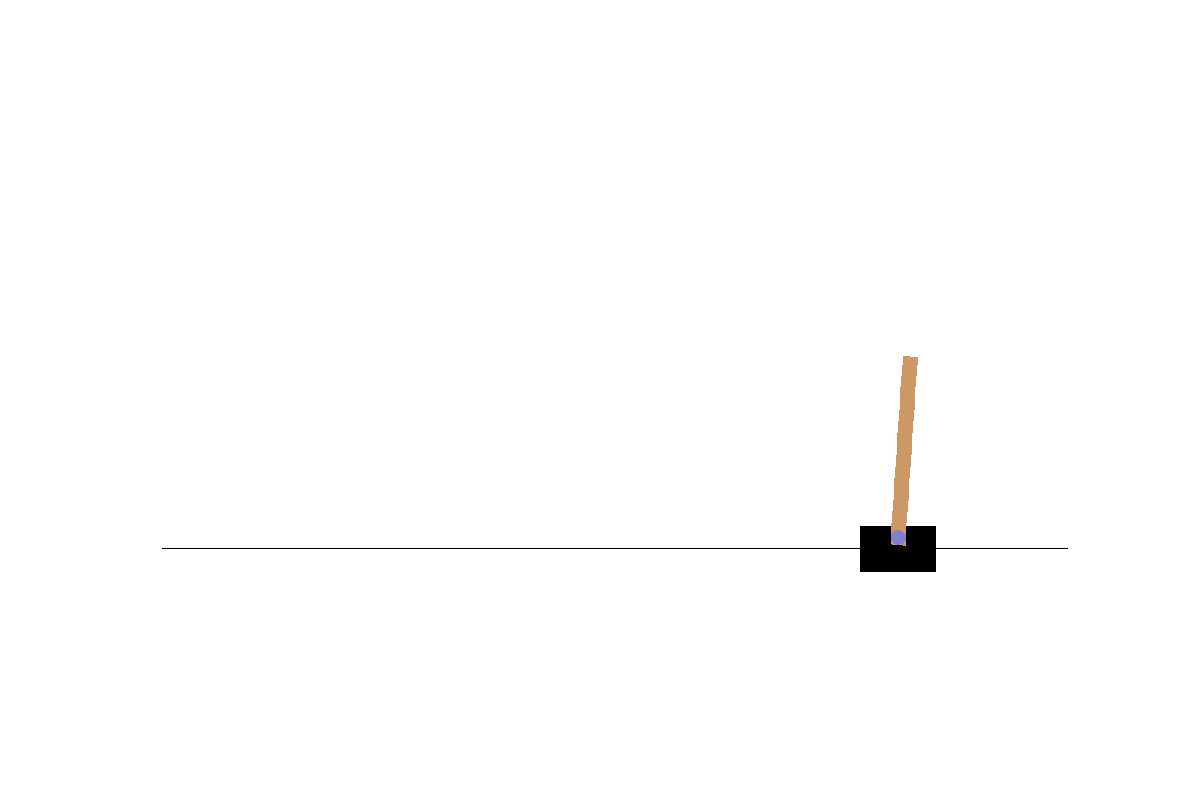
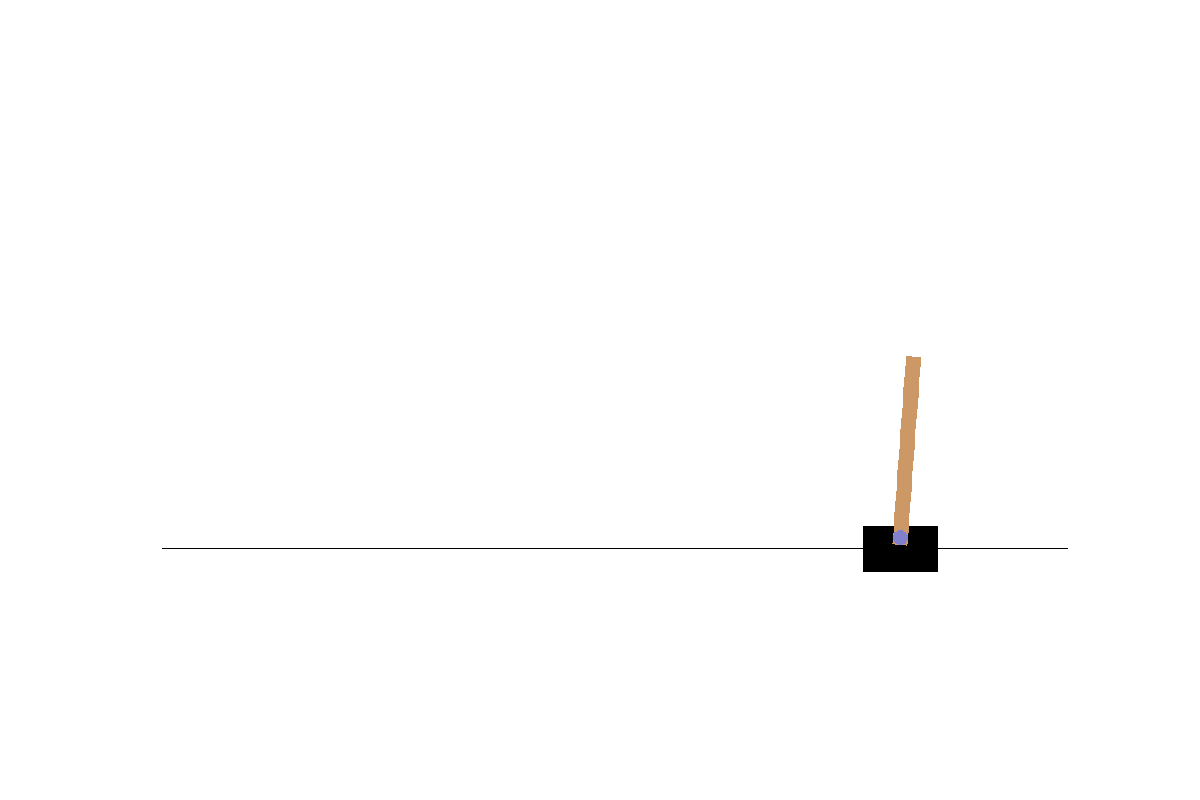
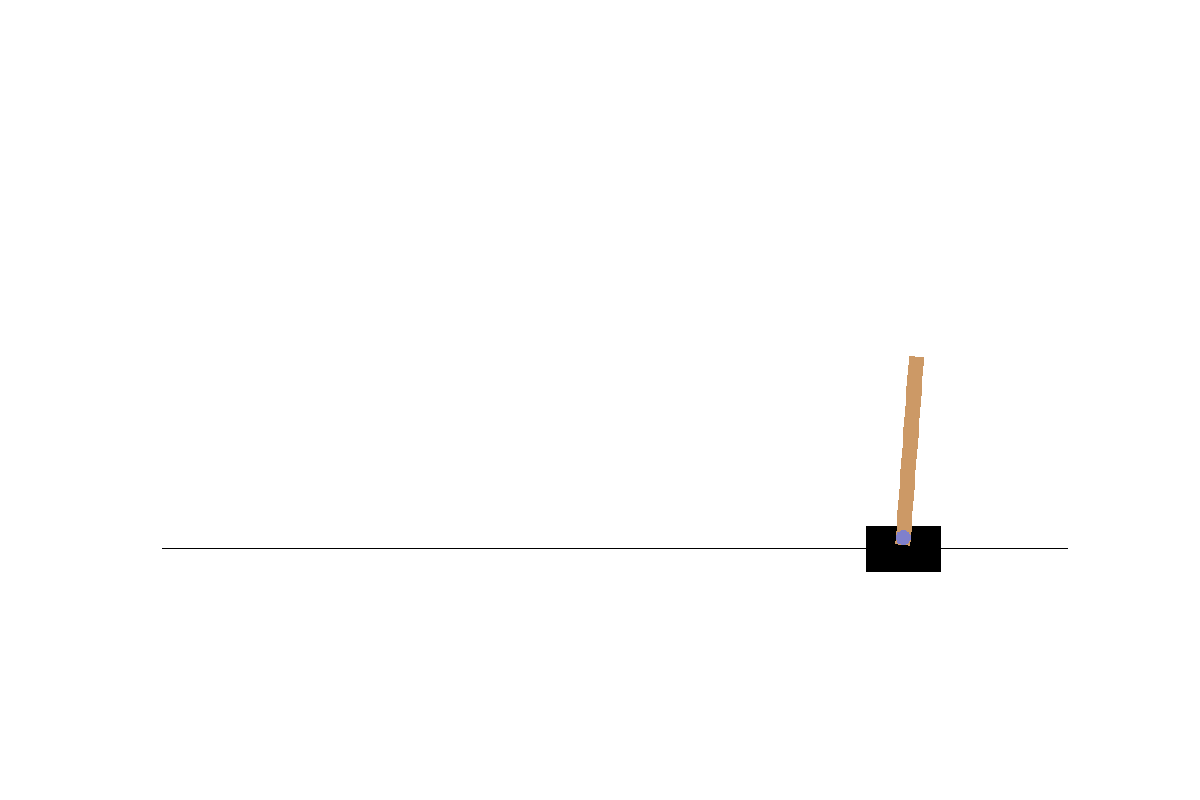
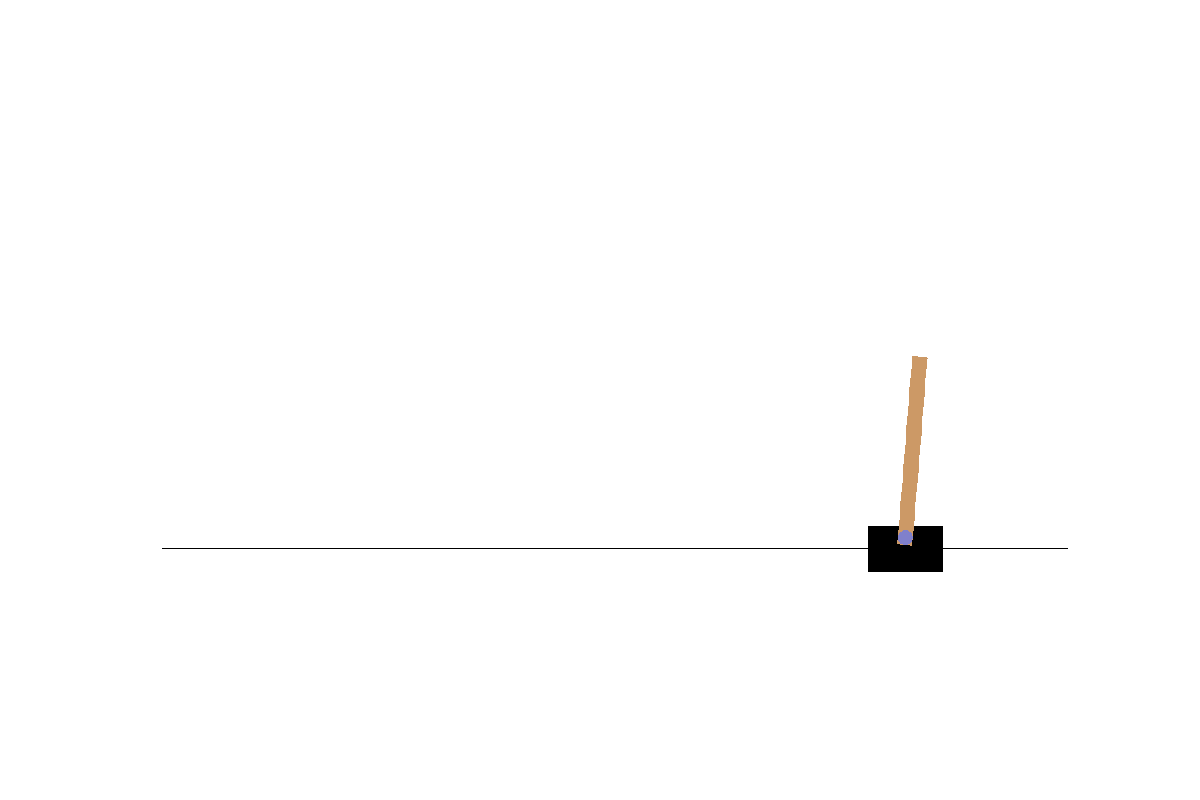
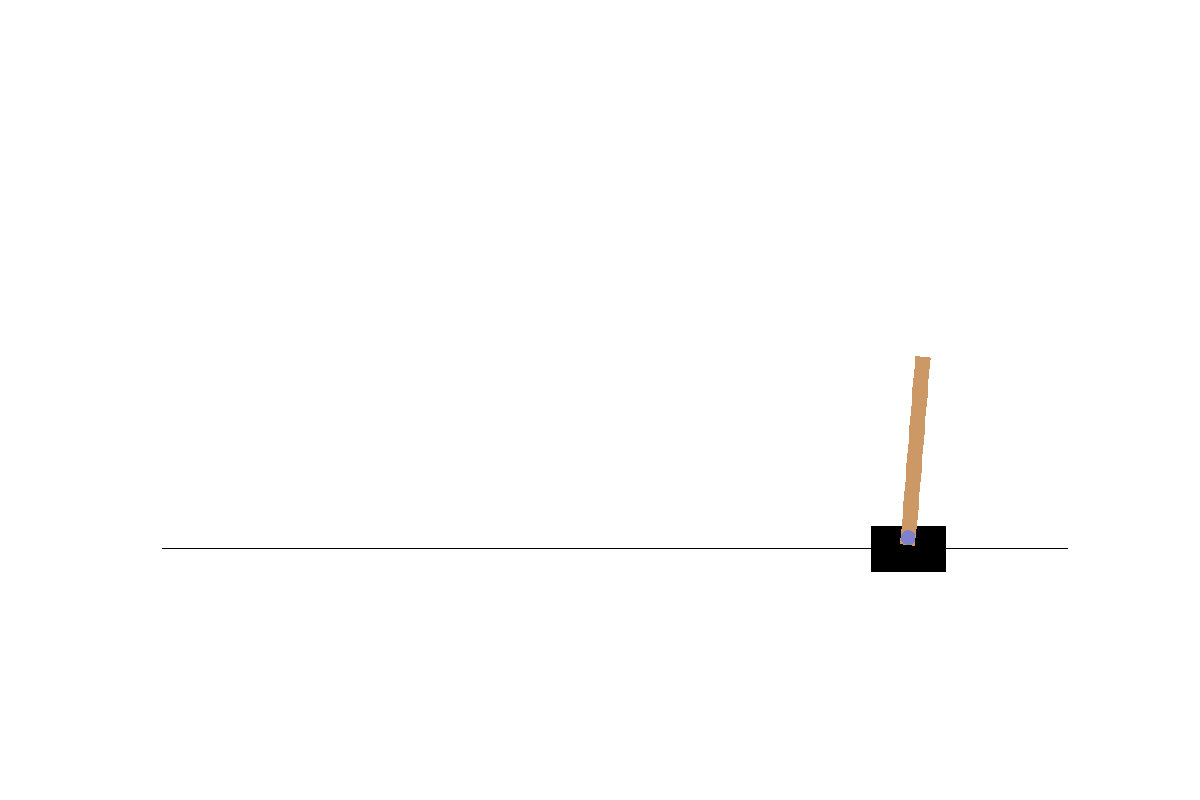
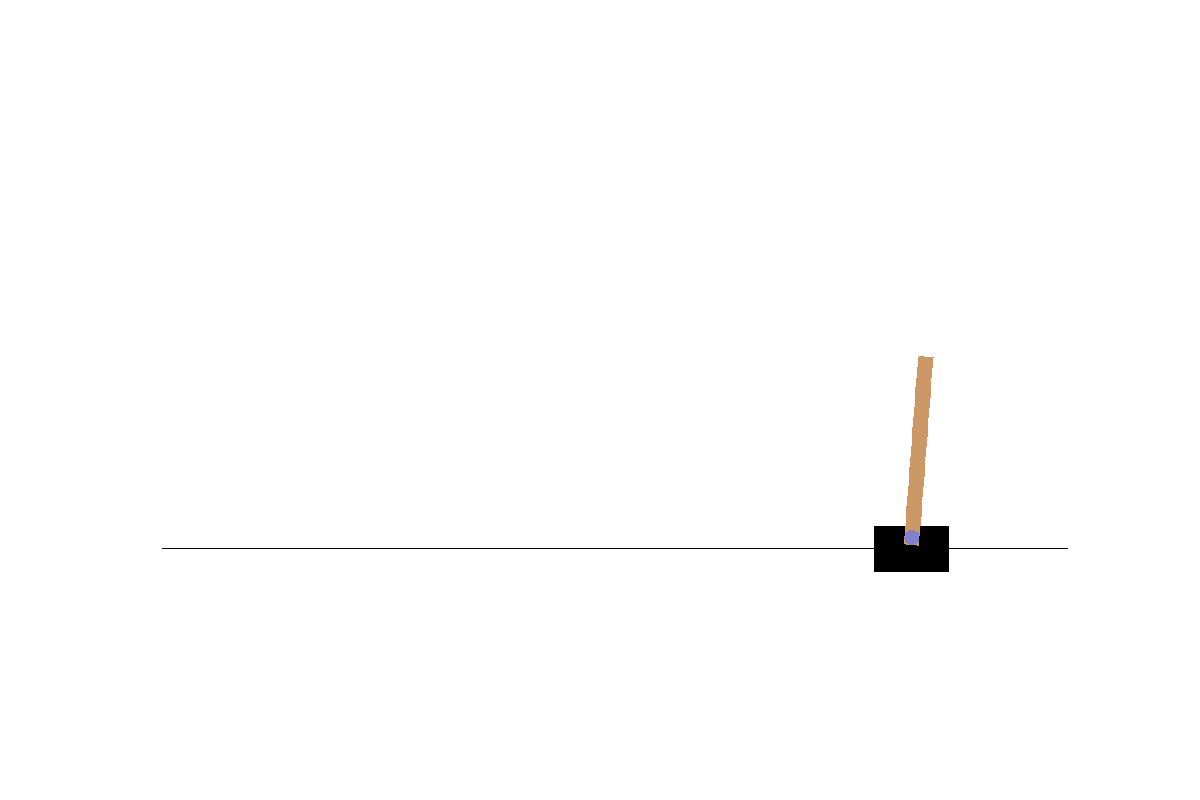
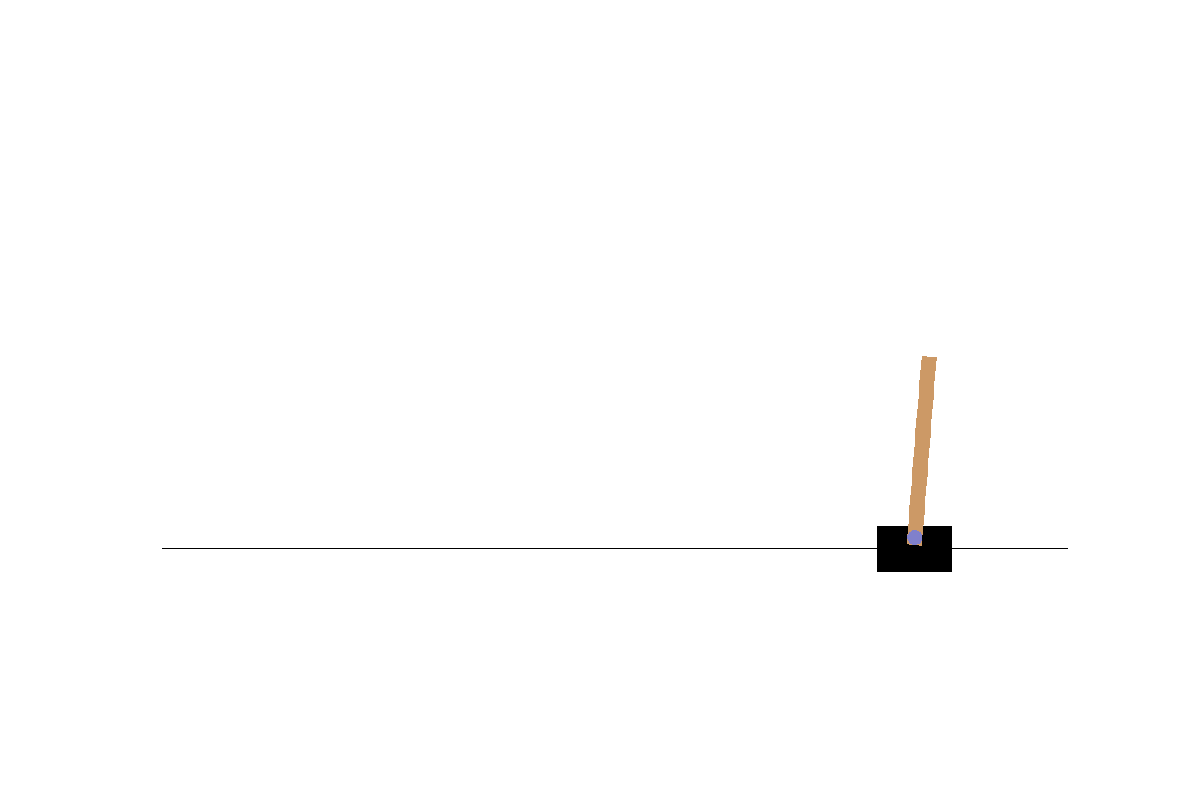
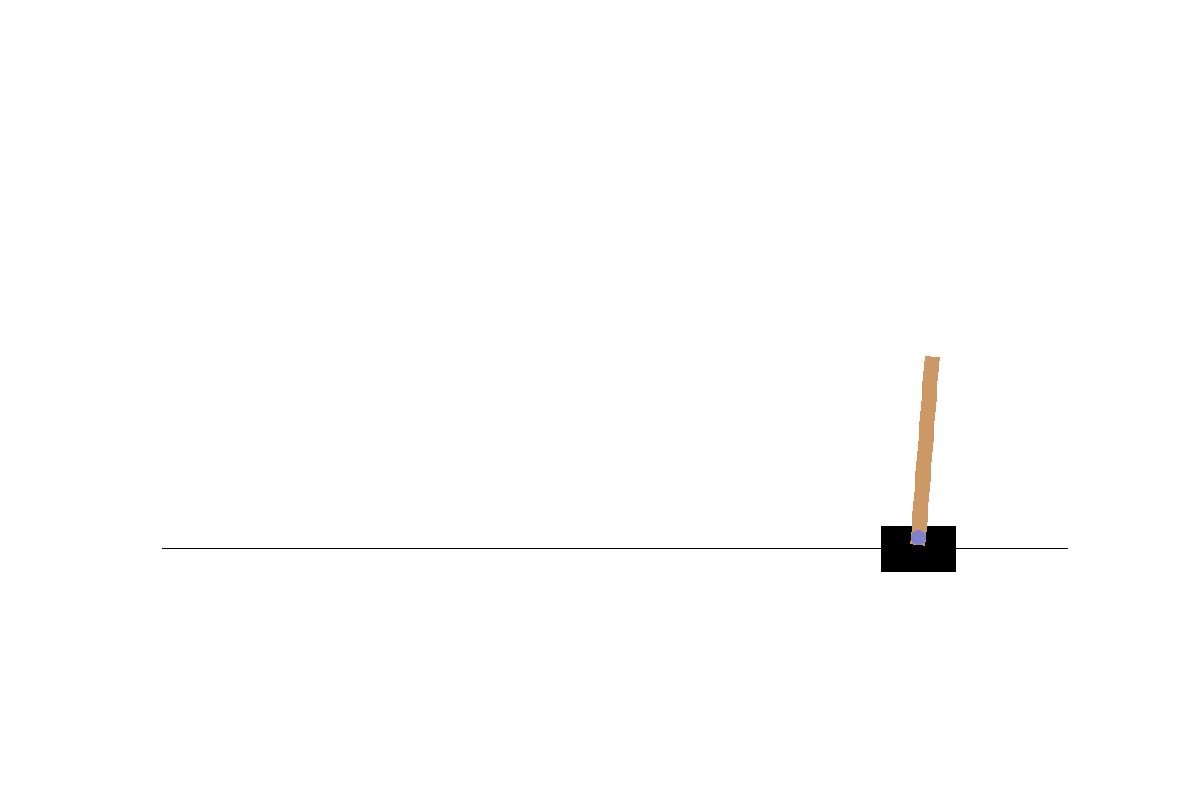
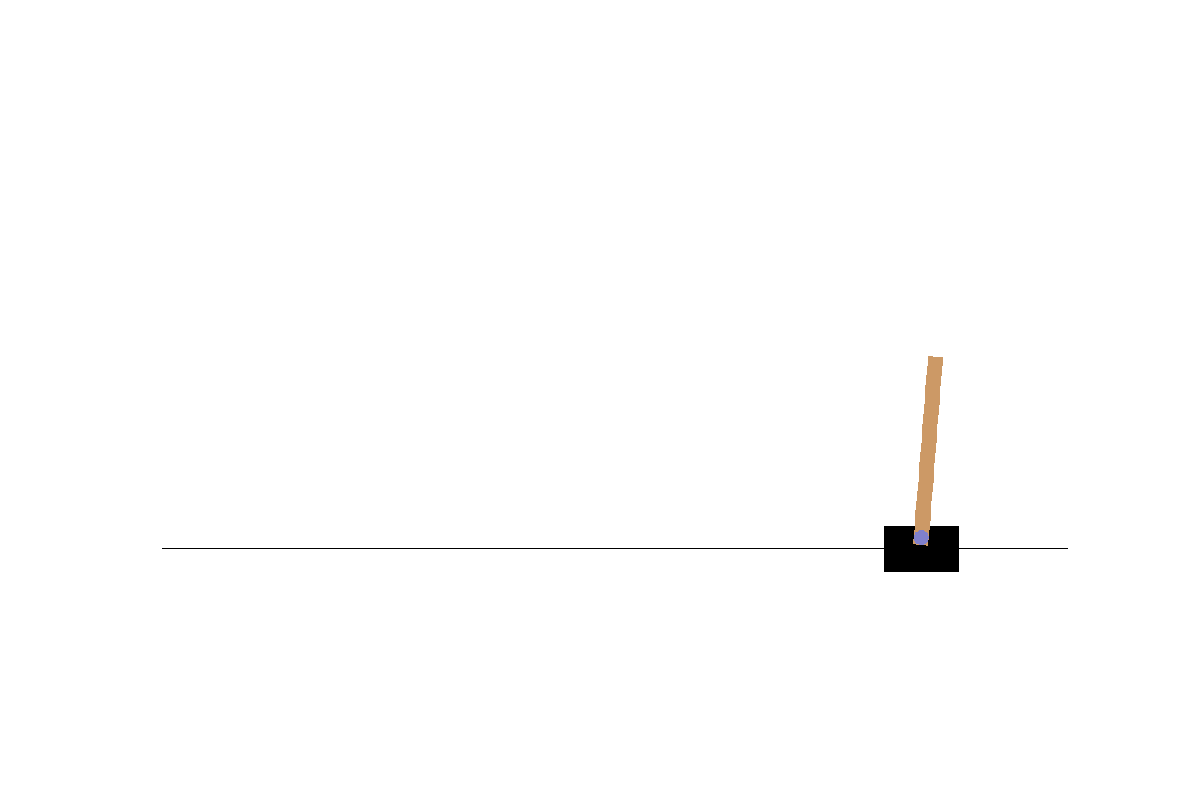
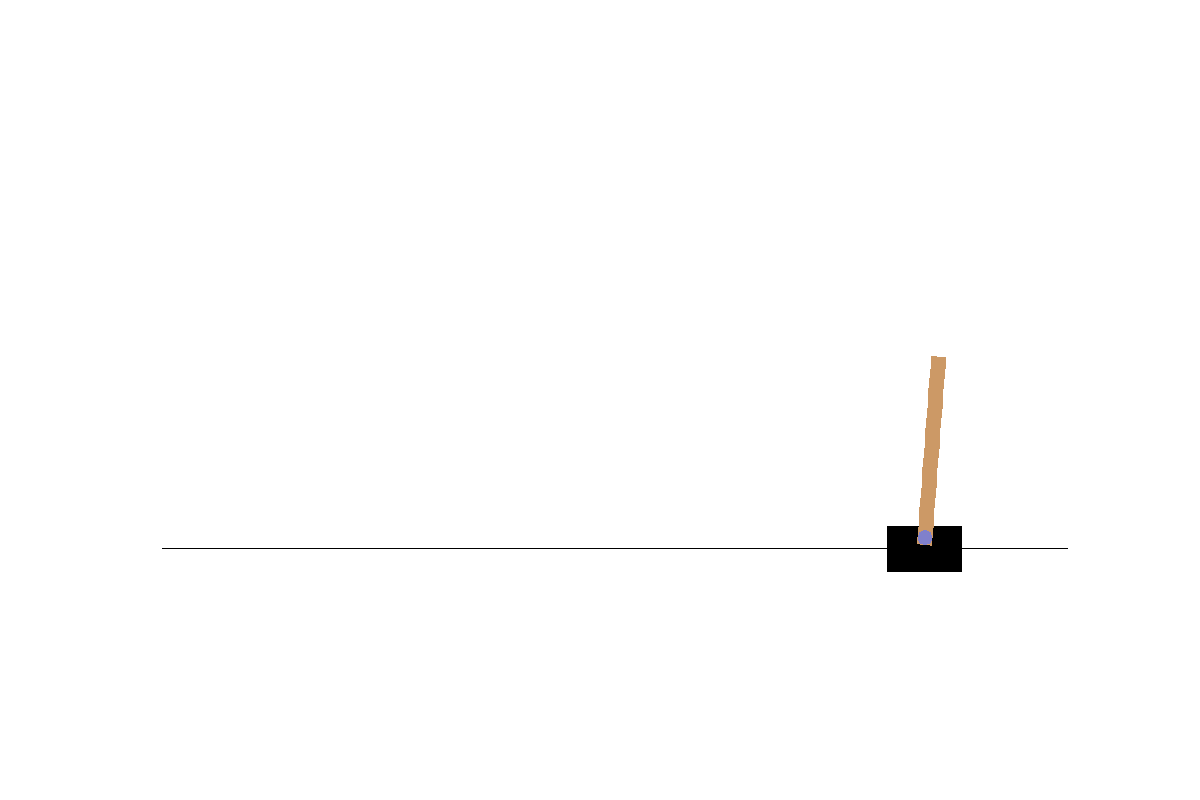
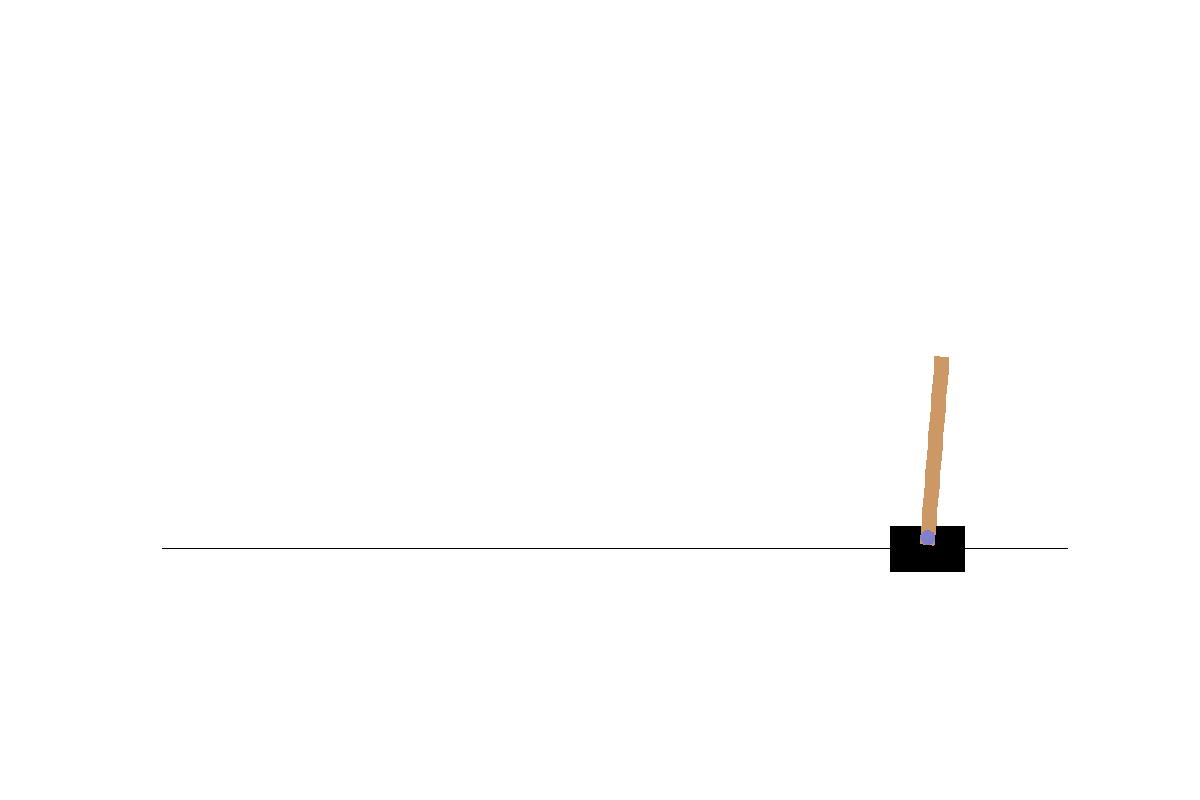
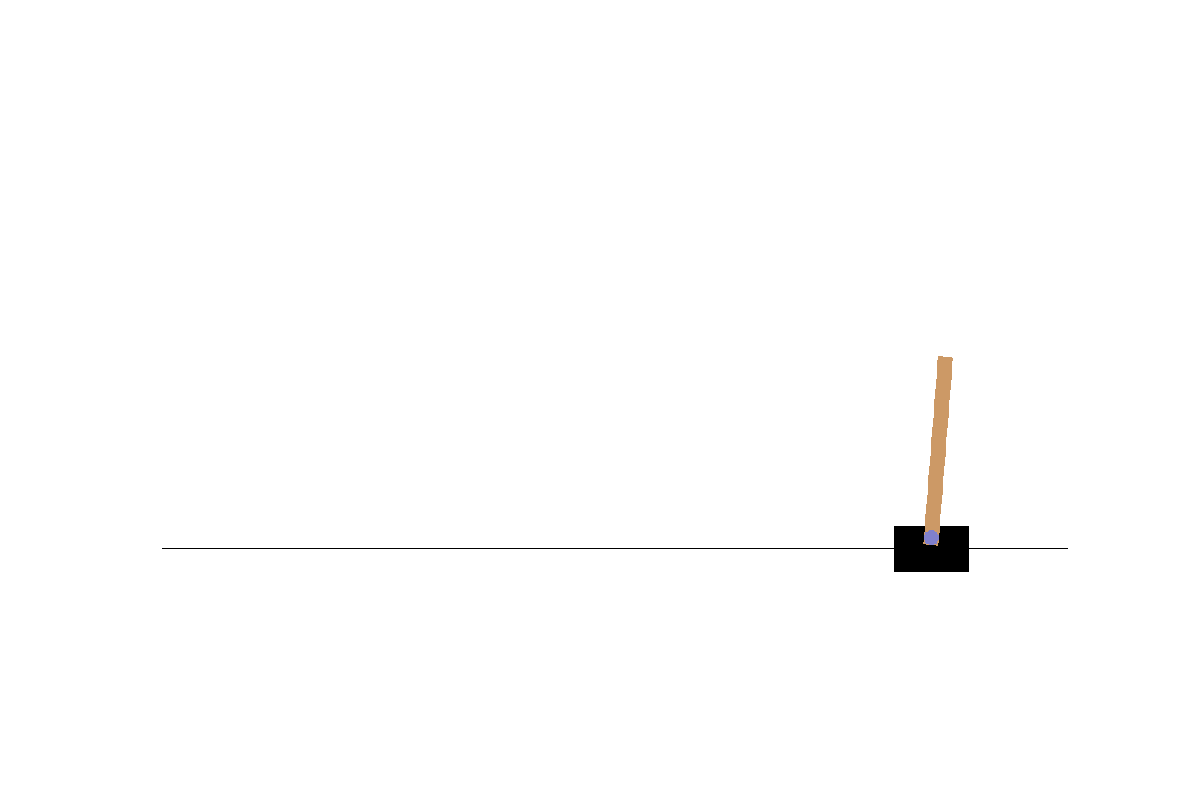
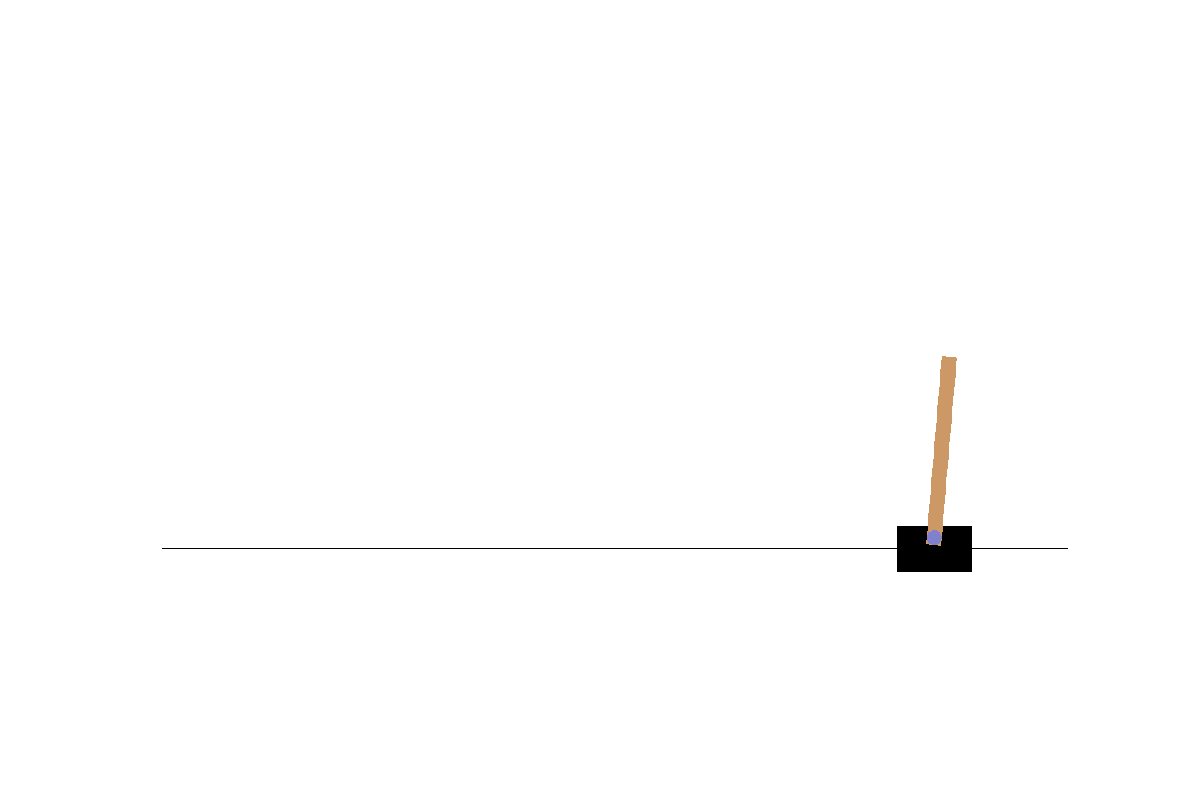

In [18]:
# Run
cartpole_env = Environment()
cartpole_env.run()